In [2]:
# ESSENTIAL
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3
import random
import os
from datetime import datetime

# CUSTOM
from online_portfolio import Online
from wrappers import bitfinex as bfx
from wrappers import technical_analysis as ta
from wrappers import modeling as mdl

import six
import universal as up                # PACKAGE
from universal import tools # LOCAL
from universal import algos # LOCAL
import logging

# ML
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

# Helpers

In [3]:
# load trade history from db
def get_trade_history_from_date(cp, _from):
    
    # connect to db
    conn = sqlite3.connect('db/crypto.db')
    
    # get trade history per currency pair and date specified
    get_data_query = '''
    
    SELECT date, currency_pair, rate, amount
    FROM trade_history
    WHERE currency_pair="%s"
    AND date >= %s;
    
    ''' % (cp, _from)
    
    # read into df and close connection
    df = pd.read_sql(get_data_query, conn)
    conn.close()
    
    return df

# lazy helper / consolidation for data processing
def process_data(df, currency_pairs):
    
    # init a df with BTC dt index (prob has the most data)
    xdf = pd.DataFrame(index = df[df.currency_pair == 'USDT_BTC'].index)

    for cp in currency_pairs:

        # filter down to current cp and remove last col (currency_pair)
        tdf = df[df.currency_pair == cp].iloc[:,:-1]

        # clean up cp name and append to col names
        clean_cp = cp.lower().replace('_','')
        new_cols = [clean_cp + '_' + col for col in tdf.columns.tolist()]
        tdf.columns = new_cols

        # add to full df
        xdf = xdf.join(tdf, how = 'left')

    # filter to 2017-09-12 and on (the earliest day with history for all coins in portfolio)
    xdf = xdf[(xdf.index >= datetime(2017, 8, 15)) & (xdf.index < datetime(2018, 1, 1))]

    # filter down to just closing prices
    price_df = xdf[[col for col in xdf.columns.tolist()
                    if 'close' in col
                    and 'close_' not in col
                    and '_pat_' not in col
                   ]]

    # NEO is not available on BFX until 2017-09-11, fill in these NaNs with the first known price
    for pair in price_df.columns.tolist():
        price_df[pair] = price_df[pair].fillna(float(price_df[pair].dropna().iloc[0]))

    # scale data (algo can't handle 0 or neg so MinMax scaling is used with a range of 1)
    scaler = MinMaxScaler(feature_range = (0.01, 1.01))
    scaled_prices = scaler.fit_transform(price_df).copy()

    # add scaled prices to df
    scaled_prices = pd.DataFrame(scaled_prices,
                                 columns = price_df.columns.tolist(),
                                 index = price_df.index
                                )
    
    return scaled_prices

# run trading simulation with current online portfolio optim algo
def trading_simulation(price_df, init_capital, train_window, trading_fee = 0.0, progress_print = 25):

    wealth_history = []
    capital = int(init_capital)
    counter = 0

    for i in range(train_window_len, price_df.shape[0]+1):

        try:
        
            # set the price df and date for the current period
            current_prices = price_df.iloc[:i,:]
            current_period = current_prices.index[-1]

            # run portfolio optim algo on current 
            algo = Online()
            algo = algo.run(current_prices)

            # get asset weights
            current_weights = algo.weights

            # if it is the first time, get n_assets by init wealth. otherwise, first calculate new wealth
            if counter == 0:
                asset_allocation = current_weights.loc[current_period] * capital
                n_assets_owned = asset_allocation / current_prices.loc[current_period]
            
            # otherwise, balance portfolio while accounting for trading costs
            else:
                capital = (n_assets_owned * current_prices.loc[current_period]).sum()
                new_asset_allocation = current_weights.loc[current_period] * capital
                trading_fee_per_asset = abs(asset_allocation - new_asset_allocation) * trading_fee
                asset_allocation = new_asset_allocation - trading_fee_per_asset
                n_assets_owned = asset_allocation / current_prices.loc[current_period]

            # save history and print progress
            if capital <= 0: break
            wealth_history.append(capital)
            counter += 1
            if counter % progress_print == 0:
                print('Date:', current_period)
                print('Capital:', capital)
                print()

        except: return wealth_history

    print('Success!')
    return wealth_history

# get history / performance for a buy and hold strategy with a specific currency
def get_bah_performance(currency, init_capital, scaled_price_df, start_date = datetime(2017, 9, 1)):
    
    # lazy map for price df cols
    cp_map = {
        'BTC': 'usdtbtc_close', 'BCH': 'usdtbch_close', 'ETH': 'usdteth_close',
        'XMR': 'usdtxmr_close', 'DASH': 'usdtdash_close', 'SAN': 'usdtsan_close',
        'NEO': 'usdtneo_close', 'IOTA': 'usdtiota_close'
    }
    
    # filter down to specified currency and dates
    currency_prices = scaled_price_df[cp_map[currency]]
    currency_prices = currency_prices[currency_prices.index >= start_date]
    
    # get init coins that were "bought"
    coin_count = init_capital / currency_prices[0]
    
    # calc performance
    buy_and_hold_trended_value = currency_prices * coin_count
    
    return buy_and_hold_trended_value

# helpert to calculate sharpe from trended portfolio value / performance
def sharpe_from_performance(trended_portfolio_value, risk_free = 0):
    
    # add to an array and calculate returns
    performance = np.array(trended_portfolio_value)
    returns = performance[1:] / performance[:-1]
    
    # calc sharpe
    volatility = returns.std() * np.sqrt(len(returns))
    sharpe_ratio = (returns.mean() - risk_free) / volatility
    
    return sharpe_ratio

# print performance summary
def performance_summary(performance, figsize = (14, 6)):
    
    # KPIs
    print('Return:', performance[-1] / performance[0])
    print('Sharpe:', sharpe_from_performance(performance))
    
    # plot
    pd.Series(performance).plot(figsize = figsize, title = 'Trended Portfolio Value');

# Init

In [4]:
init_capital = 100000

# current portfolio
currency_pairs = [
    
    # PROTOCOL
    'USDT_BTC', 'USDT_BCH', 'USDT_ETH',
    
    # PRIVACY
    'USDT_XMR', 'USDT_DASH',
    
    # HIGH-RISK
    'USDT_SAN', 'USDT_NEO', 'USDT_IOTA'

]

# 30 Minute Periods

## Load & Process

In [5]:
# load data
df = pd.read_csv('portfolio_export_all_features_30min_2018-01-03.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop('date', 1)

scaled_prices = process_data(df, currency_pairs)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
# print shape, head, tail
print('Shape:', scaled_prices.shape)
scaled_prices.iloc[np.r_[0:2, -2:0]]

Shape: (6672, 8)


,usdtbtc_close,usdtbch_close,usdteth_close,usdtxmr_close,usdtdash_close,usdtsan_close,usdtneo_close,usdtiota_close
date,,,,,,,,
2017-08-15 00:00:00,0.089524,0.012876,0.158734,0.020171,0.015556,0.027470,0.140205,0.137261
2017-08-15 00:30:00,0.089524,0.013123,0.157602,0.020634,0.016462,0.027364,0.140205,0.133580
2017-12-31 23:00:00,0.653989,0.576844,0.815843,0.678566,0.624322,0.791909,0.901539,0.617535
2017-12-31 23:30:00,0.649181,0.572964,0.821834,0.679788,0.622525,0.803333,0.900025,0.618834


## Trended

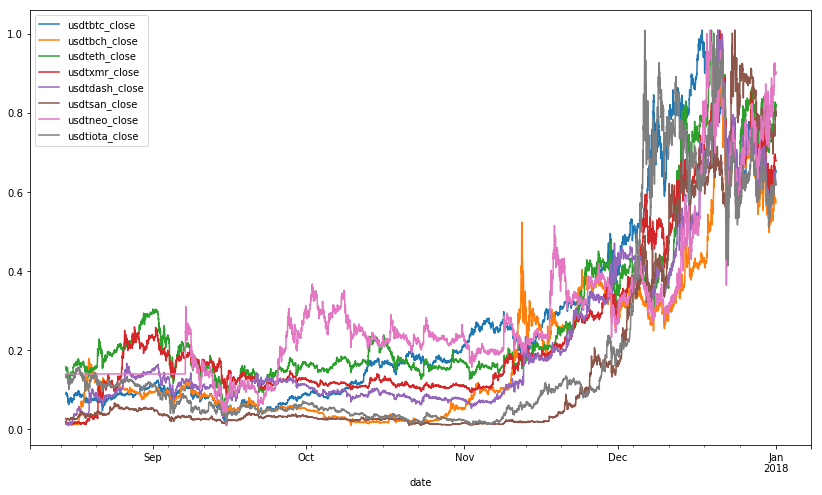

In [7]:
scaled_prices.plot(figsize = (14, 8));

# Benchmarks

## No Fee

In [88]:
train_window_len = int(len(scaled_prices[scaled_prices.index < datetime(2017, 9, 1)].index))

performance_30min = trading_simulation(scaled_prices,
                                       init_capital = init_capital,
                                       train_window = train_window_len,
                                       progress_print = 25
                                      )

In [8]:
# backup the results
performance_30min = [100000, 100268.47705187785, 101078.07995324985, 101300.68229169045, 101385.40563824792, 101423.01807882251, 101463.80087157089, 102253.78601417188, 101898.19961014656, 100580.32384851547, 100426.09242959309, 100476.94856533737, 101913.42263023581, 101611.09434659743, 100817.35694245571, 101753.27388125732, 102019.62962673836, 102735.35607914695, 103204.95074104019, 103033.37930463102, 102773.06354398343, 102838.65299995993, 102815.85432844618, 101988.5234405146, 102168.07691517883, 101741.78899250757, 101926.47121681632, 101932.39572451205, 100627.37405509021, 100301.2025969274, 100897.17325729673, 101661.72712043088, 101641.13433574204, 101392.49572012044, 101527.72717273681, 100540.40759920598, 100785.98858145511, 100484.35756524894, 100287.83230130942, 100343.41592830533, 100021.83752992794, 100067.79746041166, 98963.88534649885, 96771.559204950725, 98319.878357619105, 99170.127219458634, 99142.648002983187, 98379.703095693621, 98998.605467041663, 98043.889205649932, 96504.088458244354, 94538.407777843211, 94835.694645709271, 94374.850634795293, 94689.783440877305, 91416.234842862381, 91685.967300574004, 93779.731870737683, 94632.474519328287, 90750.424995972047, 88268.324496507295, 92184.628660415416, 93960.395140984023, 94356.038008945499, 93003.415928202754, 91044.324998147073, 91827.19439212358, 89285.944084320159, 89929.397273905459, 90294.709785169267, 91031.238279275582, 91898.389116785926, 90303.024507375245, 88302.672554984572, 84112.122271145505, 86961.914043457, 87266.518431702134, 86395.429590370768, 85875.096834259239, 82389.544609719189, 86652.759373221139, 84421.781818276562, 84505.846992684732, 85365.429665476579, 85860.371850452662, 84268.351175299322, 84007.786593106808, 83551.165480576281, 83749.65360704709, 80806.473823803201, 80841.738194578007, 81054.99762594534, 82142.239863914816, 84361.994921291916, 82228.297171062484, 83618.384167082128, 86350.482169959985, 88162.748737293557, 89768.843156181989, 90140.532238854372, 91038.280900564336, 90135.276509473391, 90816.372460393337, 90807.424397652314, 90324.331826893846, 93141.997167141642, 95601.140098307282, 95362.449636027479, 97141.706303892235, 96142.520343324577, 95741.991902847134, 95848.750094763847, 94765.073133366488, 95151.082438659054, 95686.126809777808, 92182.326832115126, 91154.98308805158, 91459.853162176994, 90205.948355216591, 87371.029411908326, 88177.334304452059, 86623.534648808403, 89745.346144288022, 86327.499722251625, 83665.006918570391, 83320.255174813326, 82041.949357662728, 83722.996219985725, 86043.28658515976, 87624.296370421565, 88883.320764266929, 90627.81332846258, 90039.29291710422, 88842.485008576143, 91508.488792720105, 92271.683682130068, 92626.787911589156, 91947.33131462356, 91305.659689378808, 90148.278612082504, 93875.542936754646, 93505.258603555849, 93490.593288729462, 94001.706212975565, 93634.775938894876, 91728.591132082322, 91731.841770964937, 90944.139796940668, 91247.970607037249, 90312.205516348651, 90190.298749204463, 89289.333432088082, 89644.018130329496, 89824.976101288936, 90750.573226343229, 91090.083875078577, 89521.992569917071, 88450.732780874387, 89551.391914120672, 86751.335767154378, 83767.095297580687, 75704.470500009906, 79027.719359972092, 79321.144033349003, 81370.87305762383, 81923.134621031801, 76659.887501505436, 69715.506356406579, 62143.214558145541, 57457.412040096489, 66362.926663824779, 73661.032475431886, 74800.343852030142, 75189.405212886195, 69974.625185149693, 67826.95941698557, 69621.028513081255, 70536.947907246722, 70829.445238601038, 70937.535757908714, 70629.481301516571, 79899.404721138504, 80817.91893850363, 89124.719693007821, 86580.602451715531, 85944.887664128939, 85299.616304922878, 91237.664807777677, 86243.197974424227, 81416.677201731945, 78799.988625191603, 69950.594316274393, 72873.056230592003, 74108.003365223427, 69027.118887283927, 62969.569966444607, 56344.137694479956, 58715.568172025349, 69712.79513080082, 62829.784882332169, 61723.727535393256, 62746.603275829781, 68258.180236854154, 61890.871491089849, 60044.927196846656, 66343.845225028577, 71591.902823909943, 72897.2830890357, 83177.234096849395, 77529.746255540784, 74451.425883955075, 72197.345469382839, 76432.934991034461, 77583.138915394025, 78774.429505339023, 76792.636474389903, 77888.793281012695, 81918.048008817044, 78917.533110158824, 81201.629495602596, 82886.760845626413, 82586.038761898511, 83552.92184700472, 81745.08623259257, 81227.842969256788, 82954.783491928218, 84827.746265729395, 88960.166466066556, 91315.831736408756, 93147.832078275125, 92298.807399184559, 94178.295521025982, 93235.44589184261, 91726.146058212718, 92102.271831277656, 93309.315854246888, 90401.307768615326, 89730.753677682616, 93664.300984309608, 94253.555170509018, 89940.737820001217, 90539.485686228785, 93698.264648203593, 92296.391886875586, 96900.440641088615, 95128.764702576183, 93275.081963597506, 94558.030921721467, 93657.756140758225, 91525.828681720886, 88095.801742326046, 89715.19494980498, 89457.669973917742, 88939.396801477371, 90725.152646093367, 93634.622040359682, 94335.273091131181, 94527.988900618671, 97869.238001792561, 98885.51205446817, 95532.062762471571, 96561.492308144181, 99960.212929457033, 97704.122004455116, 102878.37842062296, 101538.46809661965, 102813.64217320096, 98677.420252905707, 101559.35752362985, 103019.04174339349, 101094.0335121672, 102047.69013879317, 103519.72225769762, 105027.30204352873, 106356.89354577463, 108212.1478049088, 111608.91739551333, 110653.86687194256, 110580.86483648604, 110732.40301139378, 113216.84890111479, 112113.27875937987, 109102.74640882525, 110678.80443802563, 111185.00824837299, 110303.85177752211, 113399.39984728149, 111435.58769277569, 112869.37868008953, 112056.99764718441, 107483.5315944233, 103896.19018587837, 103119.89842699684, 105696.76023363185, 104976.23066514416, 107188.53355084396, 107436.41501296454, 106040.43929843482, 107461.6938279203, 107674.09604614435, 109120.63485493061, 107882.4083232944, 105735.03315416323, 105252.81418823618, 104257.62203652711, 104583.19179796413, 106741.03259003069, 109376.71253521855, 110195.05878895975, 117866.85169383946, 118080.96094190885, 119462.12173653592, 119690.641285889, 116813.34988454325, 121264.00617175721, 118945.48637953601, 119803.91185691686, 117713.7800798839, 118525.87163797539, 118741.56266036788, 118580.68781996006, 118547.16243947683, 116775.55658831968, 115185.54494380344, 115210.14927284748, 110757.04301598929, 108305.7678472581, 108448.45464749748, 108396.59801225613, 110788.23039577733, 109867.48944684825, 108174.16281658446, 107899.75959975916, 110870.46184542467, 108623.93697091358, 109862.15282219194, 110809.40873159296, 109255.21353776267, 108604.48557440183, 105581.92799133275, 103917.50730782837, 106086.77814552438, 104961.71572332305, 103638.00161159228, 103441.371022269, 109524.93049362877, 110047.71289624007, 110228.28379534918, 107112.03944376839, 106151.35316388179, 108577.30941138779, 107029.91881043094, 107990.50247224129, 111078.82579421018, 113735.50309900776, 111129.55949183108, 111378.08931863439, 110207.58484309568, 108043.4352955425, 109560.54701529567, 106600.78635990065, 107266.28397758337, 105681.86372305635, 98397.792218218761, 85914.413195580186, 75664.089546757794, 83666.990743340575, 82936.932477050228, 88759.033264406447, 91283.386706508842, 79562.79542071576, 83467.756302553171, 78688.725276435973, 82687.832592336883, 80242.326259247697, 79351.691884469386, 71903.665951549105, 77129.907128440507, 80625.755778530016, 76400.928570607895, 81497.889340345602, 82773.291729691817, 86794.580359316751, 90198.494815689744, 84275.308131179496, 83407.217564950988, 81083.43013448242, 80102.062251232433, 80974.011896294804, 80669.253183498891, 83413.818874796852, 84858.543674849294, 85276.749064808202, 83394.423262064476, 83828.148226712074, 87864.852251222852, 91326.393312456334, 92400.505155862804, 93339.631642439053, 93161.192502348276, 90979.833317601326, 89475.279360897446, 88235.088886170677, 89265.565224353588, 91490.983580196946, 91590.351881138951, 90145.307175613765, 91484.030278981314, 93701.862430821231, 92491.212484336749, 92986.781224490376, 89932.327314943977, 90099.804677966851, 84580.024950372346, 87780.976008113663, 87407.070483399351, 87701.779075097438, 87029.659019853687, 85847.538712361988, 83280.555468371749, 83603.352941825913, 83016.768765918576, 80599.519709266038, 83754.351241000273, 84582.886893501214, 84354.711609077291, 84683.485097388228, 85659.828355521138, 85687.215355209482, 85958.405564372515, 89997.758978252125, 89034.894980084835, 89494.616770388151, 89695.082484129671, 89740.697614307894, 86978.842104792071, 87154.695730812789, 86579.262374363883, 83957.377961053411, 86775.105884231423, 83919.872430785559, 84432.181686394557, 77694.505631154301, 76917.430059010949, 76083.89288374687, 74791.880770993361, 69157.67172697463, 71054.282616008451, 69237.607547045438, 75409.13058025045, 70101.830011342376, 70977.698658800917, 66021.271293015845, 65939.32926344045, 67076.239395954268, 67757.553358886755, 69722.313425506698, 68767.348983029806, 70569.401704611519, 72590.605868574479, 74248.05576062559, 72103.155602071405, 76706.470562449336, 74436.469645725039, 72621.987008063108, 74687.419636673119, 79498.328465779196, 82555.202897184034, 81801.275708856614, 79220.280229640804, 83381.818758785521, 81584.583398022631, 82463.070959713164, 77683.463469760434, 75102.477664624428, 73159.133753811737, 74432.197822160029, 76459.027852546409, 77332.060320871315, 76142.539078030764, 75822.477400811564, 76036.414646506571, 76694.940393321012, 78244.520970577782, 83114.658586384045, 83024.009111267122, 80310.937182600057, 83897.754289271528, 84423.827602463381, 77431.841185185622, 75884.327935911933, 75503.648468984713, 71918.019333250486, 75654.133471337875, 73637.551010893483, 75154.485949227019, 74730.572422990779, 71259.864767290695, 72413.99642645345, 76047.074706341969, 75161.843917209117, 77045.693195595653, 77826.690391819808, 75572.951866938456, 74098.87359974462, 74587.85783949797, 76289.64487759184, 73915.850250602729, 79549.953525339399, 78819.644713455564, 80821.062102014403, 79860.511256893034, 80002.654848770078, 81013.310303717473, 77652.87350442748, 77608.601412006275, 77387.102569333743, 79151.326974942785, 78790.085479376692, 76625.18543358364, 77508.087726831101, 77626.811180559962, 78744.688650507422, 78596.397024715261, 78105.664844960193, 79902.660910835009, 80686.471044452221, 87115.042431251626, 89751.429431808123, 102656.82542433849, 101360.3183490861, 101230.06725542489, 102837.29597490688, 100787.62850960903, 102227.62259142628, 102858.70911808673, 105265.93868980804, 105828.7178604189, 105348.29228538915, 106210.26298891645, 105346.14638620525, 106385.70200414123, 106875.79889688354, 105495.81994767726, 106548.72516962154, 105015.18791717204, 98897.892638089441, 97671.758327841613, 99742.47331119077, 98449.559293802158, 104930.09723447413, 107190.5368501778, 105403.45708115473, 104414.88331387402, 102682.19774421907, 100090.96453359423, 99794.147368026694, 100011.00356944531, 100567.89861527417, 99984.623858611289, 96580.54295813365, 97959.234117614207, 99936.165337177139, 100003.47708580802, 96046.020767682407, 85860.6460920955, 89178.266398751497, 91977.847354406287, 94323.893320013711, 92192.946197629019, 93041.665499600378, 95077.492845009867, 96866.518451029639, 94495.813165936706, 94704.610891785065, 94117.442441837105, 95533.912410669087, 89263.499560944067, 91973.986213279321, 91198.377734486538, 87280.788335334801, 83897.912068105754, 80925.418475806335, 76302.956287464011, 74506.032180592767, 74370.477468577345, 80639.860863189038, 79624.372166647023, 77964.770638155867, 80683.22427961287, 81967.153628498636, 76928.184255432614, 75598.443593478369, 76610.422669514432, 74631.079266747518, 77625.911603942397, 74163.729861763204, 73471.387373943362, 68234.84510204292, 63989.03574081749, 67099.725797044783, 68325.112300068955, 71154.014620235452, 70121.304135546205, 70676.804233159899, 69035.614699879865, 67642.063676249323, 70804.901657165552, 72161.082932653604, 73681.428658808596, 81582.655559814157, 81605.003827122448, 78362.451334715399, 79551.319703270725, 80076.924375940289, 77757.57510520966, 76841.937656905662, 79434.619631550129, 83023.519595163976, 82570.4529456538, 82607.050200630736, 86088.363178201267, 88822.631359947569, 86618.971805578301, 82935.500120723533, 83645.671894926665, 83782.088069457357, 81103.785542688289, 83760.594766362134, 80606.010285663288, 81684.082467919216, 77386.692973507132, 76699.578995316842, 78553.569964497772, 77017.408103105437, 80150.511166235054, 77692.594042576733, 78917.970791856962, 79750.829265261331, 84533.500167590217, 83002.863344595549, 80669.485387048655, 79510.69916265065, 79584.40613693824, 75019.848287938163, 73021.66860699511, 72773.51349126178, 66711.999787344888, 62291.971998385474, 64559.481992091947, 51401.789427905067, 53981.661616558471, 58497.427361220383, 58106.672304911925, 61404.154415438068, 59381.61216423539, 58064.798734075921, 56974.824414668066, 53369.250012327568, 49244.421124325585, 45102.543652191904, 49798.956968526647, 54496.294171903297, 53514.817205611493, 50732.745052355909, 54298.944300424315, 52932.781572162385, 47926.851605332777, 46685.284905889508, 50020.038979940728, 47668.714559469212, 42835.757917698065, 41666.088284384561, 50498.200254432006, 50420.331224013607, 53318.504145247905, 55458.880806051966, 59424.261021605293, 53517.382009900073, 50680.716333211312, 53738.653869883696, 52321.205436042306, 49787.735151590881, 48010.68295369258, 50770.787522128419, 43229.713401548128, 34815.366169534311, 35478.033484245287, 34807.593098953359, 30284.505954143591, 34909.783606057739, 26936.125144477788, 26564.470618661639, 26503.327239674334, 24948.655835743299, 18913.2749962218, 21925.043405141147, 44639.676716779213, 56949.910718090432, 54652.874957816777, 60862.970933078745, 75120.227952974034, 82828.077648729668, 74930.190129052382, 82723.395019654534, 79354.163170631713, 76541.216600985674, 70551.901380648414, 78607.460291997559, 79810.883948154966, 79293.487167142681, 83267.43016470244, 83731.104284019239, 85437.072237951914, 87525.283849164669, 95556.779832227956, 93900.622729470517, 84465.942271858105, 88706.427370312769, 82929.231340454717, 84585.544759613374, 85942.361086986202, 86378.564313497132, 88673.121694276866, 92911.878922151809, 92383.421337789463, 88546.848006839049, 89430.547344559964, 90199.084561626252, 90011.207122873951, 90727.775274533269, 98584.775967772279, 94488.293876862066, 87572.601633617873, 90689.552365769283, 91140.454561331309, 93618.990754001192, 95384.039979575289, 94507.030710399806, 93125.303154137131, 83465.940459094054, 76997.928234458843, 74200.13467078167, 78704.894266565374, 82759.383810815518, 76651.348354944697, 74447.410676407424, 71918.292653484226, 78096.518144580594, 79185.177207463261, 75891.702165812443, 77715.56483312964, 76699.432986309868, 77600.243547450402, 79516.061535644665, 79331.950036026174, 82175.092887459745, 86494.331593563169, 88166.531381471301, 85318.068795374129, 86207.086043563439, 86516.594462284236, 85092.89119318343, 82709.327844133892, 85340.708500045002, 87064.972970178584, 86271.093508940437, 85169.642746288708, 85031.51025880166, 82753.39112335135, 82950.477881439278, 81355.637335544132, 81649.140038182377, 82066.008404236345, 82526.093681365222, 82049.78358368625, 82725.63772492751, 79575.586652585174, 80075.877998239826, 78645.469983266346, 76439.044111601892, 77825.72364515622, 75347.546455698524, 75709.55992034373, 74759.050056202643, 71982.55799372826, 74937.883414724551, 73183.227311155162, 79275.315861421099, 79733.744596098913, 77806.007211133256, 77378.232694913211, 76830.091519038324, 77556.767471403873, 77465.793227598537, 80917.007932153094, 84315.934268623765, 84480.789990460704, 85887.528965179023, 84630.928499046247, 86400.457688389695, 90741.964399031844, 90236.135313395585, 91104.210468765465, 92416.474653987243, 91742.591188288148, 90451.61506985192, 91062.297178267065, 91101.686443356026, 93246.920831825046, 90164.196038828843, 89662.046448645211, 89091.469127992415, 90537.328123625834, 89690.22702714015, 87654.955396065663, 88107.667486753111, 91710.728702675042, 95654.907894361997, 103844.15431519813, 102673.09131933894, 106203.2931295161, 107922.67715221705, 104131.83630302068, 104562.14856393239, 102213.04172711217, 106474.64870179546, 112682.16290850882, 114090.83624769133, 110843.26133802262, 118679.7818320619, 120855.01586653007, 118977.22439687722, 119406.8931536538, 122258.90768147301, 126344.98882997522, 119495.57827212205, 118191.00776716198, 126070.2229232206, 125175.41311318573, 122769.06092489709, 129607.0064216195, 132214.31326038385, 131892.35113332618, 130669.86951432095, 131719.51594517461, 123022.58601482111, 127334.58191978626, 124700.27977269536, 123313.54514198097, 122339.27539947481, 119536.85889315882, 123829.85887727149, 125973.18793002519, 128004.32256082183, 125067.98815623191, 126741.78753572043, 125927.75882696445, 125855.19638106314, 129160.37463276803, 132420.79450142093, 134142.54163613974, 131332.72956231877, 132299.45109900425, 133881.21294389875, 136076.69121799842, 127611.60578901545, 124967.19039708757, 123771.87388397582, 121087.85763009096, 124383.31145066714, 122206.93416902577, 123124.16826423495, 122183.90770972056, 117087.64476744202, 115826.54988048525, 116839.32403927279, 117299.33718697613, 121621.56725713669, 118498.57801423864, 116885.76635413799, 120484.79883457688, 119052.33252625927, 119286.42361639402, 120410.90899876974, 122155.29989993124, 126391.88962814191, 124385.204100968, 123388.86210959419, 126821.37198174585, 125403.03882041271, 121382.46706106843, 118923.3389427487, 121427.88403385867, 120752.83627537159, 121593.92300977706, 125075.31883538717, 124028.2267928823, 124802.04093175224, 126762.21403416092, 122893.16443511374, 124040.80626554224, 122450.10283677124, 117322.81856120905, 116702.22929598037, 117807.53562146271, 115597.62056612826, 116725.75590283137, 115902.54723779619, 117875.43269610795, 115902.08180982756, 118787.70707864991, 114579.64404981886, 116240.93046266588, 116127.74130001033, 116089.54954234783, 113901.61246201982, 116395.78289956079, 114169.86015818342, 114940.51299013285, 113335.33687752917, 108786.87248075244, 110649.93854756225, 109450.08000188427, 114587.60892181905, 117650.31768096818, 120300.42833360696, 118579.62080010326, 120221.05979949849, 118969.25068588872, 117736.41447847667, 120330.35379175183, 116717.84157548904, 115053.74195703107, 116043.7091825916, 115977.40644143481, 115618.55556528238, 117276.09893452137, 117166.31573347497, 116265.22307357292, 123401.84017148503, 126165.11063030048, 125544.93563607582, 124722.73769413558, 124095.20727702134, 123846.90532791064, 126492.42935313776, 124662.63969413827, 125032.7829719086, 123638.18881266689, 124512.51865098796, 123459.41474416072, 121851.33705408142, 121728.92728960587, 122970.57228548327, 122885.10539558137, 121343.67036329242, 121987.81463835012, 121070.36986976805, 120164.05338817745, 116265.97318875906, 118109.46106690147, 114264.43112115747, 110079.85149472041, 109689.80900523077, 110108.90202813913, 111478.01790710713, 110084.38215565545, 107024.36964125885, 107283.28803005924, 109847.27682569207, 110294.33682638619, 110044.65222398395, 111088.80535530375, 109401.33359590385, 108759.9850476046, 111153.54294992327, 112475.5617105303, 109216.18160930062, 108176.92946383725, 109260.12820984867, 109934.93826130498, 111997.73384301551, 111095.37356114054, 107923.36443399914, 108044.79457414064, 109008.56768516968, 110443.61858785371, 109302.05757713824, 108706.36789587006, 101666.0254479276, 93493.353051200873, 97216.322148542546, 89920.052969589524, 91328.545514126337, 89152.797621811245, 87754.692240154531, 90582.217666239201, 88375.084287269987, 82883.96930549317, 84909.88629341335, 81175.66377652144, 90194.491829423467, 93903.669346410461, 90630.822596688158, 90974.172508935822, 88342.131252116495, 87354.747525274084, 87827.928356901626, 91050.482123223745, 91670.576918740931, 91149.580432167888, 91018.052195927186, 92863.821019609575, 88882.67749108377, 92295.137866180841, 93071.135574308253, 99025.065019639878, 96532.448297629249, 96752.82225551852, 96476.812715677137, 96263.244465592317, 98555.345123943858, 92657.465028513616, 89592.005186986848, 85668.453989108049, 90042.675588046754, 86462.661204306569, 82759.039864861523, 83142.900063753186, 83691.046344086935, 85032.730899335205, 80823.725992156847, 82594.539105759002, 86122.170624837599, 84611.393273569585, 82669.116916084677, 87068.035151594071, 86797.635287295241, 79801.898134207004, 81633.550220292673, 84606.855848292937, 84665.659387877997, 83467.000527113589, 84743.346594537317, 86857.377387348606, 85872.93451859332, 87321.772667704528, 88228.927588027087, 90865.753315458278, 88858.077607190062, 88151.697841890651, 91721.053532909209, 91752.157671165856, 90335.327040948556, 92453.618925668008, 90338.276636350507, 88180.57400732777, 89859.793624724945, 86343.974549708597, 87713.447748629434, 89162.777492770969, 93410.760417854312, 92295.642928998044, 91693.441312591895, 97372.178788000077, 98871.363427067787, 97563.36504167509, 97646.374195452503, 101169.80884962951, 98859.268193850541, 98869.364217176379, 99431.03824226241, 104402.09495866034, 102494.83077577643, 102697.53042714481, 102872.03362704579, 105689.03893453666, 109116.13262995081, 107611.9432911831, 110664.95574261597, 108563.94501962028, 108268.14409897162, 106916.70538832503, 108627.22676390424, 107076.49195704272, 105954.50971593964, 103077.40290780578, 102068.10507437449, 104087.89753811267, 107121.66225727837, 106269.04589341809, 104567.34920183005, 105630.13375443046, 104802.04413056989, 104934.9808784745, 106728.47624184245, 107336.62540938694, 107475.42726769595, 105313.68689411058, 104169.91046843218, 105834.66428726225, 105772.97404594519, 106576.15645009816, 108144.37369679217, 107484.85829503539, 105106.09212447341, 106288.51631924897, 108126.69719535219, 107171.1452716466, 107965.68132488005, 107562.03974725775, 108247.37963520284, 102625.22485895851, 97753.119928858214, 98111.430924336324, 99545.283031811618, 98172.968810680672, 94509.446362246585, 93329.707123944478, 95962.660760020779, 97061.050699026411, 97778.575234462405, 96314.608227822755, 97650.794102591841, 98787.509513079232, 96945.066378002113, 99108.95019608413, 97697.638254382648, 98238.127724893595, 99273.934024102258, 102875.36257055245, 103330.03493776388, 100565.89507477208, 99192.846786004142, 99528.852226772491, 100102.72683485242, 100049.21388974023, 99502.461813423419, 99144.642191939027, 98997.615357983508, 94850.38285575209, 95543.805746944563, 96583.333768577591, 98846.392180373252, 95691.088168538961, 96865.237386426073, 101380.29731631011, 100929.05936478614, 100823.63451282174, 102497.61997755175, 100104.66913939532, 98539.314000320883, 100856.02417713864, 100867.15100098735, 101036.6132691261, 101523.6545660015, 108290.69181325971, 108285.53254772894, 106430.37333743724, 107763.86052808925, 111830.30102223222, 111606.09345002266, 108864.19358101187, 108938.51707248099, 110139.45427882532, 108390.30228709013, 109499.67502283976, 110536.22600996972, 107069.83903926858, 108512.2016115741, 108676.43375466447, 108334.4422807839, 107621.03488501941, 110090.413113338, 107854.09274928283, 106851.25008599818, 106551.03554574688, 108021.86172812546, 107367.08790741643, 106357.87522952032, 116303.21493285701, 119884.52217857633, 117139.57042534358, 119892.33372477879, 120390.75464440804, 117991.19694411632, 116961.1804121139, 117383.91832893304, 119021.11190032076, 117731.3672747026, 118962.89617577201, 120681.8575609744, 122526.31775924233, 121685.27644875117, 121854.63036694487, 123581.34704409166, 122054.93116299782, 118988.76180714587, 119734.00809397646, 119753.69146948546, 119887.40361913457, 121088.03712483824, 120479.54252481279, 120271.17704035857, 118721.68028645196, 118488.11565265909, 115398.48506756256, 115143.95560822678, 115565.22934195145, 116153.70484115081, 110962.54567242842, 110879.82794138044, 112179.93746378463, 114081.56456384667, 113950.936997866, 116083.80733312876, 117072.64068569409, 118016.54334512957, 116519.39004135437, 118105.25390830752, 118540.68650007373, 118941.93270766853, 118590.77524049491, 120337.34122963625, 120713.03625645628, 117565.57327365289, 117405.52498347408, 116345.48254059069, 112202.6007844907, 114405.24304902612, 111291.04172297995, 114440.06688513584, 112000.17914884607, 112036.5676600459, 112907.84483583088, 112034.6502736488, 112129.77399709931, 112851.22968411351, 111499.38194035736, 112471.66519918005, 111076.98946800685, 110793.95979033659, 111821.42421234664, 111281.46113752863, 111230.55061860377, 108840.52112818364, 106482.55937272537, 107745.02828554317, 108217.73144821747, 110334.00269102841, 111629.11468551237, 109418.58480684643, 109365.45308634275, 109655.33564623521, 113486.70499816129, 111758.39333339248, 110964.74164620464, 108949.94960831571, 112082.73562231005, 112690.7912905667, 111333.92003132365, 111143.60308720361, 111215.36270156526, 110386.4010583529, 110690.24310795334, 111936.39355512324, 113316.04150891202, 112736.50046698767, 121050.2454394473, 121634.81342147659, 122778.70564694154, 122114.07153356393, 122064.81677474703, 123590.2228856509, 123138.94015188621, 120715.59102737329, 123048.2653629681, 123149.55819665286, 123734.63147333768, 121179.92689500713, 122104.16140032921, 121461.60029313088, 122492.94149557632, 122903.37377978633, 126454.79533952035, 129988.76353207749, 128625.56934671721, 130742.7270418277, 129513.80967214088, 127710.77591774378, 128007.09463096211, 130883.94434842811, 129158.72801811503, 129809.63764684057, 131684.06269076312, 130454.14252718247, 128036.09277497878, 128605.6762967442, 127972.22152418256, 128569.1468213039, 129910.01352420173, 130476.50267082901, 129162.1022873614, 128551.11978910936, 129387.60331807975, 131840.1059621702, 130480.27678728878, 129642.18283046098, 128853.46442282994, 129478.82904433899, 128520.28009345218, 128946.41728966139, 128278.20515754844, 129195.00024356118, 129012.21791483153, 130224.86680535602, 127442.83059432657, 124498.06400926436, 124016.6855575229, 125081.24212675545, 123791.61116009619, 124777.36482963218, 125129.76040517334, 124494.63630678403, 122594.45636167357, 123841.20086642128, 127097.52241294825, 138225.08957827289, 136080.66820172674, 139166.53599760411, 141032.46024147968, 142692.61387624266, 141671.67379528386, 138103.61210667016, 139301.55576131376, 137509.12552183945, 139815.47225027581, 139749.25987635268, 140926.58242405625, 142256.2790590162, 141924.30086744798, 139683.97750049207, 140387.35443293594, 141862.2764201255, 144695.13042237313, 142748.11600479207, 142652.62130949527, 140671.68656654083, 134086.99951016271, 126810.70808822571, 126468.60893407039, 124339.86266603402, 125729.48372316934, 125505.62752874194, 122887.89598456486, 123345.06013287949, 121232.16406246941, 130100.39399299107, 128570.78551177046, 131666.88031986693, 133061.93707085046, 131893.75346732599, 129583.7931194047, 127332.37454485595, 129220.55885638995, 134413.31326885454, 135352.7404036329, 140253.92839189339, 141031.5030480694, 142799.3627307259, 138321.45460342959, 137922.43212454871, 139783.5744180014, 139851.93809610041, 140122.60343201092, 141968.91068829939, 142193.27376978844, 141714.62087025639, 140986.22537145184, 138363.03036406887, 137452.83426109655, 135920.23353812582, 138664.9112412266, 136905.04738526174, 139609.6421215625, 138569.34074512112, 139503.99313844644, 138759.13068125711, 139076.91153959345, 137012.15448275022, 136163.87652391815, 137613.64931847289, 136228.30044291148, 138305.533393241, 140562.55869334179, 143348.06562187185, 142404.2620566102, 144048.74844838379, 142614.58070080908, 140387.13612032344, 140762.83019411031, 141689.40526333667, 142602.20944835167, 144016.82290646285, 146420.42978392454, 149204.2090342216, 148477.40470369026, 151563.26511637954, 149066.13461573955, 147951.07353541563, 158624.4820492221, 154486.45285407716, 156613.92892774488, 156914.43316288351, 160034.42127806839, 157356.91354018991, 155837.16947455588, 155807.77453194454, 154414.49923068806, 155535.72637690033, 156570.18977776065, 158596.9317454549, 158324.64501645262, 157436.89769910485, 158294.03884004828, 153131.47160362097, 153985.75286685277, 154183.17020288701, 155384.14676171599, 155353.66343485471, 154740.45046504523, 155978.94742269308, 157972.65538140925, 157751.91248953008, 156961.45658932775, 154396.82775335654, 154452.94648156475, 155377.45389484992, 155647.36552353136, 156124.86587136379, 158357.32539210015, 156888.79582813371, 154546.86180191318, 154893.29787781124, 152471.31744714704, 150295.02843394602, 150350.46063258732, 152071.98804578953, 152205.24250904738, 153021.63899610291, 153366.16693280995, 154185.78766719025, 155116.98028987023, 154887.03957542748, 154320.68143906316, 154737.82706560081, 153199.96673976496, 151864.80742463737, 150904.22023267008, 150411.57216199089, 151091.50132461483, 150873.9963843578, 150495.27629016573, 149408.35175266422, 148232.39918904228, 145646.50890270097, 144027.05471071423, 146414.49869204412, 147005.80231116893, 147865.59191186202, 148306.95785417728, 149965.22391081709, 150584.23415808065, 149337.92377634323, 148223.97303676751, 148415.65466065364, 147686.36593679059, 148991.60498959216, 148848.72628260442, 148446.31726787103, 149121.23955925842, 150998.89870495506, 153108.99990580475, 153508.76346606883, 155491.01002521359, 155538.43715754637, 154435.85377132427, 155056.26470345704, 156716.20231225179, 157890.61490719215, 157543.82743194388, 157649.95490251546, 158100.94134523239, 154381.12529950927, 154747.38616113027, 155225.23115861212, 155952.72295117669, 154283.82184692589, 154037.32200033742, 157957.41198024451, 157299.65958106014, 157300.84159011242, 157299.54979136609, 154206.92397856226, 157901.49430291483, 155027.48548952496, 154253.4449355838, 155590.75774042477, 154916.21332283504, 154511.74881444304, 153289.82451921742, 146820.61336118254, 147866.02441233071, 142500.16943758668, 143732.46433130087, 144854.68302993232, 146151.85969181749, 148579.23402160831, 146600.86835633908, 144809.4569602955, 148138.26343808896, 146369.36198184857, 143174.62581086784, 144311.02929269802, 144171.40944387842, 141153.42227362032, 144493.35629132041, 143670.66894050947, 143554.34726241865, 143749.31472222385, 142718.59918205821, 140143.70108661344, 142956.73805604401, 141404.48810542066, 142487.74924006363, 144930.10280234797, 144272.85059983408, 143696.09575463444, 142757.74146141647, 144289.82461984962, 146527.72958047426, 146147.31404169335, 146136.72658057086, 147009.84259739067, 146724.89482689695, 146422.88168247521, 140220.79731739446, 132659.5666518248, 130928.12351568516, 130645.1746273443, 131265.23048025015, 131566.76622776609, 134356.58202951797, 134941.796600356, 131340.69939664393, 130501.21330291049, 127793.80705731129, 131488.25103278388, 130834.14067824421, 130761.79768377074, 128705.26259258788, 125080.72104984226, 124187.50610624565, 122016.81106168454, 124532.65389057211, 127116.77043252483, 127360.21450380897, 130187.17449072933, 130489.83693374494, 127023.52706303549, 129834.04710640346, 131077.26563083139, 133147.3702355393, 133482.8365379709, 131393.92412691121, 130093.32901542587, 132477.40016101641, 134313.01235186035, 132561.18161744863, 131710.33284437098, 131962.29716859185, 133634.82063902094, 136036.66898833882, 137277.14407973352, 138975.03764487052, 138703.23948505416, 136323.25858279809, 137131.00874506854, 135626.44826568081, 133897.68424251123, 134000.33532322544, 135661.4690698217, 136367.67051669487, 136832.76077655322, 137430.86853423974, 138587.42141717707, 138497.30876790168, 138011.47908061405, 139515.03514680616, 137838.439622251, 133235.06438734307, 131901.82253969897, 133113.93904058216, 126824.63300844222, 123224.75179400202, 125456.78496598997, 126493.20169253298, 127287.62018304985, 128641.11410225744, 122397.63562566607, 122285.34492970683, 127573.57191255887, 126765.69702362153, 124608.57769516089, 127550.14701844644, 127430.08111596564, 126536.39432264118, 128522.13038741663, 128336.67150525883, 130852.11200077608, 128693.57258865656, 129468.97481680363, 131088.61114129468, 129695.60837652226, 129050.33351323762, 127052.81965493469, 128785.07802540698, 130615.04598367022, 130583.90643086386, 131125.72346384902, 130887.72492536451, 130553.03119881777, 129319.89196146767, 130625.20983438514, 129742.88663821218, 129729.5793458175, 129481.54500597164, 128778.66267410869, 125568.95541775302, 124193.80585618125, 122216.71474537085, 122605.0151720291, 120554.29576120806, 120493.30829612145, 123021.47350460046, 123550.11977540975, 124959.82444833778, 124166.00355001667, 124834.37721607875, 125169.97010979414, 125927.57271683787, 126571.79500159746, 131355.62555117984, 130925.65031625686, 130123.33727936062, 128991.92267111695, 133758.41413086728, 136037.97248365293, 135935.04153773538, 136353.79509588383, 136729.37737251411, 135470.4280539318, 136320.30796402425, 137944.44527033629, 138937.7320674365, 139608.37519562803, 138071.07283629494, 135600.04522971672, 138710.31223322198, 138749.14541840559, 137597.19783501496, 139397.61924993672, 137885.42492971831, 135972.55719036632, 136833.3474002399, 135498.71082304625, 135864.11710735748, 137502.61370638042, 133743.60298231343, 133248.56348489405, 132160.38151827652, 134385.52830293198, 135083.55542182669, 137335.67598807666, 137297.47398379381, 134588.70042358417, 135276.57633224037, 137209.3638704606, 135892.90439726599, 136449.6221534505, 136122.23225991713, 139820.44211157248, 138739.35231155175, 140187.62228701249, 141722.26129102154, 141767.06911063986, 140182.34532907174, 140489.36588183496, 139835.33695883321, 142526.9757711642, 141073.05669515592, 139513.67818647923, 139837.93698981806, 139248.8225681672, 138858.17114606858, 140685.48677439446, 137606.98963481368, 135078.08129776575, 137339.35797673644, 136910.93617199498, 138023.74763540167, 134184.07492873777, 132357.33028659422, 133132.85401355691, 133812.70554980286, 128134.77723441707, 126082.47433790858, 127663.56820375402, 126001.52194668175, 130341.93274404923, 127796.00762993783, 128014.06888122676, 126798.70704260289, 127149.60285480358, 124319.55980413206, 122400.72936741452, 123495.87905379737, 124010.95919445534, 125343.42239049086, 125456.28088126516, 127935.00040552212, 131015.05104152099, 129086.76567931331, 129060.86588063178, 127418.04515324048, 128308.83774483444, 127345.78376276905, 126944.29365234461, 128647.36934324977, 128130.55979374683, 125402.10141153623, 119510.69924004238, 122539.32870356578, 123043.48677964028, 125283.26706658499, 125127.45830771647, 125483.34931888922, 123965.66595218763, 123736.26348472947, 121626.23851937137, 120942.7125597347, 122735.69998055432, 121124.01258351884, 121771.73357845558, 123737.33133724429, 121803.20049156743, 125057.43259943314, 124796.46919335955, 126043.9464076703, 126937.63733376976, 125557.12087530595, 125045.23157486258, 125556.63107173939, 126703.11914515671, 126950.49499619441, 126386.43128113874, 126624.43703823537, 125872.94896440132, 125661.58433893224, 125494.53733506039, 123952.52983543361, 124267.43579137235, 126957.53585382018, 139135.3634285325, 138113.89678890456, 137410.91875057359, 138624.88008437649, 136675.89500232963, 133306.77510773958, 137310.36708935024, 136410.19703647032, 137697.05559572327, 137306.72948470729, 137186.32647133095, 134919.1123250057, 136077.3194481137, 137082.37579421478, 137194.74590816931, 135854.94284502347, 136329.10405729257, 136338.19645836754, 137608.34557877469, 138273.19888210858, 137612.09847558738, 135699.09580837435, 135811.66331089239, 136683.38762964922, 137096.24215545971, 137104.20290040591, 134226.41207475826, 135605.14100886113, 133597.38445639197, 137476.91838562844, 136689.82923560136, 135912.48018092735, 136090.08982823358, 134730.57548207452, 133489.13719847213, 131335.90207739256, 132174.29043543537, 134656.70739355948, 134336.61090149495, 133116.81984719285, 133100.16034741892, 133314.56972438958, 134627.34877824393, 133417.25326401816, 131489.98329664089, 129788.64754407897, 128270.80204711398, 128466.0914191792, 128183.25458939496, 128511.6583909925, 128088.54177782817, 125682.07882042721, 124274.18953500337, 124898.45290898155, 127652.35887721472, 127315.64143761569, 125233.24501837713, 125447.82635391364, 123919.58074941883, 123453.13389263093, 123548.5802911802, 125976.26016796115, 127995.24867139134, 127025.56489290862, 126301.40694055453, 125993.12302903215, 123170.89045784395, 123126.32278475008, 122793.51841424382, 122234.64570454237, 123766.2468448576, 124154.52744344808, 124598.75500750508, 124929.85399580689, 124447.98539208935, 123488.62338109498, 121360.80349609433, 121390.37636840541, 116877.23077037527, 114557.46165519221, 109236.74817360505, 114688.94781161073, 114266.81583300672, 112957.24950268536, 111416.83635645972, 113378.7432389312, 110638.09824857967, 108479.799443745, 107346.0125686894, 109925.12844028475, 110326.85058268937, 114105.78630800676, 111335.33096846333, 113521.91280215512, 114643.89574641471, 115194.14978292464, 116322.00126185044, 116317.04346456144, 117839.06052836793, 117086.24948860134, 115223.19711896771, 115845.42074162526, 116491.54679870767, 116271.21237700636, 116238.58093678084, 113700.14390281218, 113404.72346426401, 112539.14804058177, 113344.63657716374, 115934.58756898121, 113493.80015575167, 111695.95998270003, 113210.16822441263, 112291.19560147915, 113320.09890304698, 117847.70857511673, 116917.79296528104, 115958.07775989428, 117459.21264432636, 118334.07993191572, 121562.46953917757, 122191.37999219027, 123235.05107979602, 125768.51507588397, 126601.56059462989, 125275.5577607389, 125192.62170044107, 125929.33794643781, 121917.79390463703, 121627.8058868642, 121838.64924225589, 124611.41987302675, 127018.40979422757, 124314.82505261881, 119669.77451330489, 121726.3138537349, 122933.30462494676, 122402.19422878974, 125974.38269838564, 122654.70897369257, 123493.66309002838, 123234.11420273861, 123885.49750958174, 123252.63844174428, 122539.57902155534, 120072.26270691799, 121721.73850842252, 122336.81102436931, 121430.20639881957, 122129.94589016515, 122589.87394403799, 124499.90573363693, 123575.62205756732, 120972.71048024078, 121102.7446523299, 120039.80888801077, 121295.55615341177, 121032.34620118178, 122118.61582986983, 122137.68343105848, 121897.68659289302, 121135.21563636139, 122381.48465672438, 124287.26774001757, 122238.39328320025, 119818.81579907124, 119455.66294216076, 118170.07710997408, 119665.508478944, 119386.6735753105, 118908.34074282739, 120445.01503281033, 119714.65947086641, 119423.59654799246, 117961.31568072227, 118901.48469941947, 119958.64967502032, 121662.7618089368, 123936.02373553236, 124436.12030862083, 125649.56561475055, 124963.72362827594, 125020.59230289278, 125728.01317125137, 125866.1943012095, 128836.17356388632, 126493.26147070376, 124387.25147790983, 125695.91851112657, 124322.26882739001, 124397.9498539835, 125203.31371274362, 124488.5132334372, 125078.3976670648, 125369.37701980182, 125828.63559858315, 125567.24927383161, 127232.79195543745, 126782.54580060139, 127677.9682786715, 128260.79838526176, 127053.00471638335, 127429.22389231474, 126915.9063354768, 127152.12342807924, 125969.29074145408, 125973.06650244947, 126168.15350329225, 122570.78412347849, 114751.36838482833, 117708.35678458873, 118835.34052717137, 119727.53253680197, 120806.93613347097, 121154.33067717956, 121102.31018467047, 123117.43449293952, 121452.81257637596, 119895.71065538602, 121443.04250747198, 121516.41628099384, 121107.33140783085, 121527.89421400987, 118644.2807567229, 116829.86891079159, 118037.22356751606, 117790.35532077844, 118119.3834502492, 113633.86162658874, 118181.83712640061, 116897.72297215454, 116319.6351494806, 113018.33441828378, 103370.42575571522, 106548.40503813114, 109542.5426596633, 89764.779973706361, 95387.828908997326, 106113.25501442519, 100964.17996372486, 109304.98736145324, 113169.65879034664, 98719.563818418901, 100217.13139065489, 101580.78384768168, 109526.86897102722, 109684.62979985475, 107003.35148157318, 100901.29396012067, 107677.2231653708, 109095.37804526667, 108547.25970243667, 104497.40039559008, 109273.18551249738, 108127.86868976986, 110079.30505455067, 115793.09763289941, 116767.87363214671, 113027.51510649764, 114850.78666851314, 108436.38990028857, 114190.20208970871, 109848.6465485079, 111006.75330936941, 114431.05911471287, 109030.49289568543, 108733.7066365389, 109012.88248164515, 110739.42421346894, 109516.61998049074, 106074.98571920849, 97088.802387843185, 104884.76678634, 107404.82352786692, 110479.98640423044, 105842.85979368637, 106284.05263726659, 107607.28364085991, 108177.55464592864, 109252.8985798325, 108398.73218269779, 109819.19462316799, 107646.27636552441, 105674.78076833479, 106301.82193710646, 111689.41268745852, 117580.21970341781, 116487.97810149528, 119939.97892064217, 118125.74756366746, 119966.44468782921, 115828.64474217713, 118232.42071919036, 118967.19919930726, 121637.07572519394, 120602.74675972549, 115783.32842870857, 118049.19263405447, 118729.03864153782, 118855.78992264529, 120305.84400711933, 120707.31670154048, 120296.57663137291, 121434.59116194918, 121960.84341684674, 123999.13406172759, 132974.52463358268, 133573.01492177538, 137650.5317277828, 135210.62991051443, 142811.74412588152, 143140.24511723698, 136831.02280373708, 133802.58543269092, 133846.39046956794, 134849.97095424731, 127907.74578467419, 128000.76450852168, 125687.54282507405, 124657.06513935898, 127866.77160420324, 133150.34969848025, 137254.05299889616, 139518.58796355425, 136431.32594646639, 137605.28601146003, 138307.56995985605, 135133.87770294788, 135894.75534471447, 137303.23667357003, 135873.69584366688, 132391.33990538307, 130502.97055598126, 131653.22842238416, 136011.66582887841, 135227.6966413325, 139442.15555123179, 134338.24314063476, 132962.72293885931, 131739.4523384179, 132631.50873684295, 133220.03100916784, 132089.81785755654, 133171.63790842687, 129082.67884526849, 128384.79592476459, 125170.36000312537, 124019.82623515668, 122855.75886863882, 125849.29233322752, 125904.6541146254, 122745.60367263276, 126378.4981348142, 127189.40557217973, 126992.74433973548, 121342.87755053061, 121547.46860724658, 119548.02627954845, 120556.34575184033, 120740.28374003667, 110126.31885180884, 110074.79477416257, 108903.9522128838, 113344.77968907215, 111043.95053759185, 114492.12390417691, 114394.1198986214, 112154.57320862405, 114884.1402431008, 113864.60307244041, 114986.08584859331, 112539.1089943874, 111327.70752473197, 111540.31709165222, 110212.54139908448, 111522.62479286609, 111606.11786143409, 110701.30589231303, 110231.29067835043, 111392.66230345539, 113967.58479376257, 112090.64571319958, 115180.51551303302, 122556.43443614553, 122621.66169665373, 123596.44090704428, 120183.7214213866, 121729.07147173476, 122750.79858262735, 122598.0253164657, 122005.19972705454, 120205.47072064161, 120291.11167696587, 122577.08354596568, 115432.82878540784, 117841.43383660645, 112236.49066600455, 113532.34779439642, 117248.34892640603, 112539.36354349283, 115080.83850327772, 113327.21117778978, 116034.3466035734, 116303.00156257053, 116443.69309736526, 122981.09340445235, 124762.22879136332, 126192.80690625851, 122547.9225394652, 125067.34354965603, 128069.79583899937, 130570.16731328482, 132339.91586654022, 132907.51324953637, 128831.92363649041, 127801.45404892291, 131719.19400481059, 134136.48316682683, 132673.70011967717, 127656.74299194998, 125469.36550531953, 129614.4387674485, 127365.11398689231, 126230.77406524692, 125931.98030812418, 125314.54825302763, 128444.91508039218, 124496.24739532555, 123612.854390662, 124703.97841741631, 125006.24335396125, 125334.82846715818, 127162.79094016735, 127793.52750414872, 127920.5873600981, 128778.34169503901, 128352.62827695441, 127980.18744029792, 119739.78707850163, 125401.13137618097, 122890.91430966729, 123048.84080969886, 123297.44887777499, 122228.31115478545, 124102.3431030834, 124916.06165514688, 122346.98078072511, 123941.75062757786, 125791.84506448185, 127635.50129196132, 127299.20448143396, 125057.97281720678, 127129.26605436683, 126764.61451284774, 124922.75505071113, 123889.28036568029, 123972.76619099273, 123742.10686788923, 121860.13077708529, 119266.98686955587, 119367.35962928641, 121186.13654039115, 121087.12262029777, 121828.52006768013, 119211.54251511858, 123574.71904338145, 120752.63160148333, 122794.77039852201, 119710.68006213705, 120587.34763617646, 120433.16079920155, 121241.80429971921, 120088.56056260309, 121927.56942816966, 121969.34243738859, 122177.75713164936, 118003.72925582147, 117947.94157260361, 119979.82275402639, 140859.315653775, 133956.64973914047, 143491.86799784022, 137624.92529348616, 139776.2626562095, 131849.67267088787, 126220.24670504846, 124695.75786307084, 125467.4942725291, 128472.40908652233, 128515.47279987746, 132597.23524803159, 137115.30220295291, 133412.6833047448, 138755.83712841669, 136671.65326771545, 139244.13294554828, 125435.19846759571, 130544.53170278417, 129661.9633286516, 128114.47932612397, 128098.72182768305, 128674.84019709501, 128801.06032278304, 130267.02558100363, 131411.70478451421, 132373.29395639419, 131550.08411267665, 131395.7447032085, 129559.69903932838, 123659.07300737861, 117005.71134348694, 117343.9970388489, 112646.16579051709, 112619.18552623015, 122366.68453310381, 120457.25993334074, 116951.65937012275, 117494.73956560364, 117292.0855814254, 120352.46447803851, 119886.21132586051, 122034.36568240797, 120130.59500929208, 120891.25140497713, 123338.42631743124, 126671.4248635234, 125589.38494339386, 129176.93746339768, 128168.64649978583, 127842.37779820818, 129949.28029162544, 127843.6456182999, 127345.91838564043, 130503.69708484523, 131407.8613644327, 130647.74467043053, 130667.43713696304, 132511.28025212575, 131648.60424578248, 131995.66985429998, 131416.57270790054, 133956.16410508304, 131782.99360966161, 131465.43260260986, 131349.40015951841, 130567.50062732131, 132321.00635918026, 132278.96719261061, 130771.72162797686, 128214.18411084756, 127760.43067317313, 115036.74280926958, 120125.16454714815, 118441.24186362472, 119986.19152212568, 120325.97347294239, 123149.48131414338, 119601.08071737101, 119767.88746841907, 106707.89866300729, 112670.90033308792, 118002.85806858263, 112652.74446030069, 114713.6790556167, 114964.15202569324, 113743.80825782544, 114234.64474679975, 112895.57307064516, 113747.73933333956, 114866.90656785981, 116477.99925489892, 121698.65276871862, 119957.49250004666, 116066.3045131907, 117047.64154972004, 114784.76862969235, 119505.99673839609, 117192.43047268409, 117595.02252779878, 118557.92385148739, 101007.35019182207, 110360.47188075657, 107332.87173459829, 109782.56528410826, 110439.92715001329, 110884.11884135666, 111589.06992874536, 111950.73947967874, 112740.70686392882, 106330.18051732835, 104098.03229571959, 104230.94648955073, 107514.74873293685, 108996.635181395, 104968.64116146974, 101763.76722297305, 106815.81748527662, 103487.95251316509, 107035.31979394457, 108339.43920281438, 108231.30038642752, 103140.17856165017, 103713.49816484912, 105630.37994039405, 103861.33118117834, 105092.4276762824, 104474.36935852149, 108237.04751105874, 108287.29502081982, 98105.656655078652, 99099.679671691556, 101373.43562064362, 97845.914387994781, 96867.495274195884, 95842.000610211224, 98576.202291533409, 101647.10174602842, 101507.37842642597, 95706.753013893744, 93042.836510499808, 93640.452374166227, 91378.217582960118, 94122.280783752736, 91475.884774156759, 92752.190504604645, 93087.944892749336, 97375.465127369214, 97442.26391248146, 95577.092138813037, 93026.849821130018, 92386.070374390838, 92476.961169948147, 89543.252710525077, 91149.970203304489, 89435.983846174466, 85063.488623676822, 75409.826745603757, 76715.663022361885, 80439.979288011978, 82732.568964390623, 78067.021492240194, 74095.246969326559, 73451.759153450097, 70707.578537107896, 70967.38784237302, 70596.623004031368, 71958.077871157118, 73373.014479143851, 50863.848540081184, 47970.9923118023, 59663.823174746722, 69386.913933903328, 68179.735485483456, 72536.042498080089, 71049.239146426436, 65010.54557794422, 66070.241031356665, 69764.218649283051, 83931.511416261652, 82194.545567316047, 83345.222677271464, 81156.606687503896, 81831.615997336412, 83510.550293145265, 84365.387226136809, 83375.62588171431, 77693.001488610302, 81272.308042598248, 79635.003219391117, 78418.884896887525, 79955.81260753439, 81567.9222816236, 88319.432538177134, 94931.759501442401, 93631.300622325347, 97172.914407325588, 92283.813821656411, 98072.791630527558, 94198.476619993875, 98883.741967127062, 102512.11833779127, 100202.63667374066, 99559.17018267051, 95536.346399829461, 95369.563809761981, 92522.317607745965, 88892.692855381145, 90156.432402539154, 87608.029663088251, 88666.550961790301, 88841.033430605195, 94465.499082877708, 92746.521866648487, 95278.751000612698, 99849.217417948152, 98009.356158997427, 99390.881892185629, 101613.43213034637, 106860.89871802012, 104151.52150053719, 101426.93699559373, 103085.78409212492, 104856.60089335978, 101919.5765514294, 97072.546961436659, 100635.22720219857, 92775.103078612447, 92602.751869737607, 90714.069858905743, 94630.484204866094, 91786.065755833508, 93329.03556258764, 98222.492861640392, 100012.56473109259, 99958.938372178542, 97633.413459575066, 92529.098316331103, 91081.679316682959, 91077.85685015627, 93182.581248735311, 89182.480468165551, 92173.591173750945, 89264.054948889767, 92309.003077181173, 93379.052627464378, 88934.744995428729, 86807.259998854715, 83566.764600710754, 81846.352468370664, 83129.611654391309, 82637.536406041385, 78558.017227221586, 79270.448349612911, 81631.809679377489, 81613.422197128952, 83432.169079909101, 82315.232235805568, 83403.020224442924, 81247.749164743756, 71605.363221952211, 77855.173713184224, 79005.316975476904, 77864.664072425498, 80603.840037833812, 83024.247719889026, 64274.966752404296, 69468.792070361014, 68198.742110854029, 69776.846217815662, 72357.075107498473, 71735.281631948892, 71624.100116254078, 73616.384924111611, 71815.535794533556, 73179.334838212322, 73384.865906111925, 76243.919318439672, 77129.152418563492, 79472.225280906714, 81802.219123089599, 77918.480620631177, 80328.072513562598, 82022.374601182906, 83455.498094957249, 83567.868683351058, 85052.966962761275, 91247.009906036081, 93426.346066210142, 92502.297983311539, 94346.513690686188, 93904.183969640522, 91269.927046950092, 103018.94163025706, 99109.746812778103, 119919.5621964991, 122221.53174602723, 115414.32420957739, 100947.38160448865, 115388.29013448603, 117556.97491353528, 120110.10240433599, 117338.49125358449, 125484.38898008634, 121191.41083200743, 118800.18677142482, 123556.27555925623, 131748.026308008, 123895.42142159876, 128828.82714709581, 132300.36169667263, 130867.5646365789, 128814.58190843927, 130350.30634225458, 127475.31640891772, 132287.49422400244, 137646.56878089756, 146068.70063737917, 151047.16699724141, 162421.35881170139, 165963.17894068052, 172116.48979905015, 172362.65374685862, 166270.67929973226, 158217.67468703183, 153130.88449675567, 158395.92904699637, 159290.95906754641, 160757.9898902126, 160962.78893294174, 170400.8513779412, 160540.77267297124, 152721.13965351958, 154589.69149478874, 141140.74456409909, 145448.2629066378, 144634.6413327436, 145453.10488249012, 147924.55722755753, 143978.50091047413, 147378.16385751721, 146215.95643641593, 138747.81896493261, 136376.88732894789, 139396.72077387443, 132555.28701506276, 139514.40016079787, 157670.20406147453, 144873.5283184346, 148577.34241142921, 141877.36765124853, 143717.42081573405, 139324.94754461071, 145861.42599811402, 145067.0233733182, 144635.08539895577, 146567.1022334501, 145081.35171800456, 139237.77822508782, 135329.90273872262, 133287.33628332708, 129958.11039006685, 130307.97147339254, 135786.81073032567, 140178.13163687137, 135099.58745491167, 130717.98253800097, 130924.58487586335, 132307.15453390835, 128874.20076117066, 129186.11155880991, 125336.4494298098, 131205.65763465807, 129462.2866237672, 130782.00069073179, 132880.70446410877, 131398.17325278418, 129943.35142175101, 128502.13346029836, 139428.66139986514, 136691.92316899978, 137489.33298658399, 138698.10453983786, 140293.84659780684, 139797.00641669484, 142567.78891394669, 138142.49061619362, 136349.91109437088, 134880.71597682673, 140551.36082787294, 139924.99464574241, 140978.69900272906, 139582.6636005216, 139254.69053904054, 138863.45515180795, 142541.52297429499, 138391.81961366336, 139319.6959564999, 139815.36510715671, 139522.22945771427, 137556.38113791333, 139238.39000563603, 136999.09188750418, 138786.45072989268, 142327.63924586138, 143440.74784687028, 143246.23889245762, 142567.22856426032, 140183.75084992056, 141920.87249053892, 143230.25279656367, 144980.27969440105, 139434.81712225519, 130957.8241811245, 128184.38497242067, 133539.8750841452, 131174.31549173011, 130252.93951937226, 129299.95540176978, 127079.613653648, 126815.92171326251, 133496.39458710386, 133357.04023792705, 127126.71688177627, 117832.88004103098, 116285.50537995181, 119163.87265311788, 116433.38333279715, 120208.61982688817, 122582.40375734588, 120063.01058482083, 122143.44968979782, 122366.35013823265, 122761.05751221435, 116708.46785817042, 116847.37354690913, 118776.1722257349, 119830.1532711467, 119938.68860578259, 118983.08555883996, 116555.79148315924, 116892.40917279043, 114441.63353885984, 112418.65057910753, 115698.91663199064, 111836.79510393424, 112297.22499631641, 101665.61672280003, 105630.41412179719, 108490.74745542994, 109635.1075885988, 118869.73287314788, 124306.69720948578, 121770.45253101439, 119527.28657257486, 115967.84609452412, 111196.47606050684, 111817.60527131763, 118768.42559614973, 112220.15085867692, 113580.2975557687, 117458.22626359494, 125381.84646586144, 125508.1733684621, 123595.89546456438, 124587.27632678134, 126932.83762874466, 125238.64444346307, 128021.88503026238, 130552.26351593825, 133823.94934863676, 126455.43209837837, 127103.81880172934, 128467.37218465371, 129662.92550337518, 129638.9272482529, 128055.30556285192, 127229.5787963883, 129074.08715557827, 126574.90356385805, 122129.28464488398, 123586.33508437491, 122195.81120205863, 124553.44249612001, 124852.91454248672, 121041.42205109337, 119011.44075901204, 122237.28786051137, 120726.48657530347, 118459.61778582967, 117968.5830857035, 117622.72204410369, 117351.13619049576, 116988.39590078477, 117495.77963296657, 119277.34826857764, 125045.52959836369, 123922.77025542749, 123244.18185819642, 126325.3295949194, 123051.61883364859, 123675.11789874232, 125708.81883052032, 120933.08126939637, 124356.48260029338, 121314.76869399777, 118548.50296383252, 115575.21908293079, 117399.01006992624, 115239.69303082541, 102867.18957283272, 105683.89293109032, 111192.5023664201, 105824.78827032825, 108502.19433025237, 108976.18452752552, 108758.93080484183, 109207.18735984612, 108617.37142288662, 104131.29844379063, 107023.592034015, 105978.17856368823, 108769.80061634882, 111722.12540453911, 104676.29453064095, 108369.28454935484, 107129.20318131929, 107345.26871091906, 108293.31146424462, 103183.54589488199, 102924.60205541835, 103307.52901780726, 100497.13175508811, 102137.58533789848, 100529.40082805278, 101181.16612039617, 103617.43615703967, 104851.42421742064, 108215.35022403674, 109312.25245546641, 111218.78604172282, 110653.13874059568, 109220.55703434181, 111623.80263608193, 115199.84900158076, 112993.79297723153, 114014.30885211183, 114145.10437725896, 112999.59750737665, 111058.40899139247, 110397.06624595757, 106803.23759524904, 109135.92551501049, 108181.7697108787, 98253.703271081249, 101610.29893119739, 97189.217383529947, 98893.998470612656, 101263.5805673791, 105445.64326408964, 100201.39423389122, 99562.2439854314, 87998.083876103614, 90627.459472456554, 96239.036130892637, 91145.167121338964, 83447.076536551845, 96681.063126614856, 100205.20938529994, 102401.83206403506, 107852.92139195654, 111583.03958560251, 106918.20370973067, 105062.5449265136, 104533.47929248105, 103622.85506358529, 99067.699693022209, 110928.39577737235, 106744.88310307381, 110856.90932299405, 107337.30755620445, 107069.95289610386, 106779.7699715536, 109971.96337894221, 108434.39124305079, 108071.6731979527, 105825.34808810704, 106175.59956414902, 103965.93744411145, 104426.54925237119, 106610.87633000132, 106653.23301903064, 104826.22424572727, 102958.53499874615, 104675.1392748041, 106638.67702348054, 101061.5744212073, 106321.94973400963, 104987.13444371569, 104971.9327780757, 107152.29973609155, 103096.92762904371, 103023.31989142882, 98409.715508805384, 98977.180526303287, 100997.31079386361, 104165.61116692504, 105016.18846452393, 104920.60721838743, 102878.83746672826, 103641.51013855811, 103186.78013657162, 100461.40129408278, 103114.1846661459, 103537.88251385698, 104935.91537993199, 106624.85222004137, 107537.36709864419, 107690.25856546649, 106865.93145937668, 108397.27934338254, 108789.75279755353, 112521.8375200036, 116274.3051784164, 119213.86975446308, 115977.85852837452, 113337.48413439836, 114370.19038886944, 111201.03605396394, 110008.95899116879, 110885.71848716965, 112614.33529241532, 109044.66236209699, 107501.76691868134, 107956.83575450607, 109611.1283088362, 110623.62912052133, 110808.75608042275, 109911.01989493115, 108374.85565268817, 105014.23283245442, 105496.53711074212, 105546.47616689141, 103938.63155322541, 106238.69844353636, 106256.02673995322, 107625.93659178386, 109563.81788288274, 110120.39683418574, 110489.6341679414, 110708.55144279532, 113532.8074029157, 108903.27421390897, 106185.61878873508, 104799.89061353086, 107513.49948760704, 107462.85510420254, 103588.14336503383, 102937.63379047241, 104111.50430772826, 104771.10520165636, 102988.32283170246, 107887.52108195568, 109113.12375888249, 106676.70833434, 107831.47097441509, 108162.4897444215, 105560.47023775212, 102365.63115512407, 100843.06979868772, 103439.76443751047, 102272.4088217918, 100731.42378893514, 102322.46488274776, 102219.17506729413, 101607.6166277663, 99758.466293908845, 97909.536619307866, 98893.19246873504, 97159.283622958159, 96741.432783817756, 98084.161164262041, 98170.186235584813, 96024.060735705556, 95717.784144877296, 95174.910228024222, 94308.080205635983, 95818.842220666382, 97568.380905405967, 95882.337352823262, 93977.090476331286, 94997.537103214534, 92587.12683063891, 88188.054300950171, 87959.282734462278, 93410.847901684989, 90450.941510616947, 89819.022960347356, 91437.944961560876, 90806.916842728257, 85846.183935651017, 88488.83355786567, 85190.816170156104, 85487.091695685551, 89827.151724064795, 88014.456460808986, 87874.589357866149, 89093.567626960838, 88686.903682933596, 85120.400276031985, 82538.413609867057, 77965.511205325849, 75702.689987634265, 79337.783944212031, 73724.873376847288, 76414.43962325438, 78627.848412609514, 87287.940919363769, 87154.168057440358, 86681.587936723648, 87343.082575120061, 84398.244905176776, 81813.44323173193, 79176.736186905939, 79347.642973438036, 78130.745615661261, 71656.497558774267, 71372.174912200309, 67366.208014525473, 63780.46563413315, 66240.933944073753, 68223.380440885303, 65555.139385079892, 64907.267366005872, 65442.147321672026, 64026.749262246289, 65559.002685974439, 66744.960426256526, 61315.471129853686, 62482.087043790452, 62903.813512148641, 63915.445247439289, 54491.099688152412, 49538.811892747493, 53967.324858546592, 45023.077342410928, 54597.046333289501, 64625.245431087889, 63498.184994134659, 52945.878518757592, 52131.798461125109, 54173.512119071893, 59918.226918476561, 64977.312149256475, 64124.446766962123, 66505.340012245855, 61651.731697383751, 69219.595125670166, 82454.681459831263, 78466.652997073703, 86983.558598048709, 96158.817519940931, 81293.59211252362, 83492.919646894981, 79131.577566610984, 81672.119229534874, 86628.826672224561, 86815.765592516371, 79608.413138793752, 77224.605116838837, 82572.630137277039, 80754.466447736515, 76686.142332672302, 78566.14838060255, 79553.224851135048, 81391.698920795592, 84509.181158352541, 85294.380237823076, 84483.044819949529, 80019.536496011031, 84531.076642092346, 89842.123823812959, 85890.978877968009, 89988.182997945245, 90842.44317246713, 91655.280869087306, 94237.941204487492, 92365.936550209459, 90171.793238617349, 86535.26545678424, 84717.280742233939, 83819.329834020784, 87047.187844205691, 83682.912931361367, 88224.421892640326, 84317.722239624767, 81565.562325079445, 82629.668648361112, 80600.28389903091, 79226.460257446277, 80680.357390634221, 83503.361270242967, 87121.684292280188, 88165.560819124075, 87476.361921809221, 87342.408683689049, 82686.112012593294, 84120.315887537552, 85061.96205289154, 81993.460222102629, 83335.355407994386, 86091.818893670614, 87010.734289063199, 86318.224261077819, 87833.266715570484, 97871.67455485776, 95684.080316436521, 98534.775960368628, 99841.474134434247, 106247.08814041587, 101842.08840340259, 97755.349276606648, 91156.736113307474, 87002.090647767123, 84525.91494817115, 88649.71041486389, 90785.527109103292, 86125.153529437113, 88405.288759295974, 90458.332057213993, 90578.502230732629, 91943.107069330843, 87395.472237374779, 89781.524501118824, 90494.425989919473, 90275.090636855442, 89794.694915136133, 90096.730578154631, 89627.874334592736, 87085.549183093943, 88812.217209032387, 89554.254786204285, 89339.664292592919, 86228.212805000818, 85549.101542465156, 86332.230020836272, 82890.589267119634, 83140.217753000499, 84085.182682419123, 82963.982057732035, 86240.324054503566, 86239.534362587903, 85953.273992661401, 85514.019409877714, 85016.931112041624, 86133.305346119276, 85885.094101829658, 86644.746599544684, 86909.686868953417, 86909.571331138242, 92361.615811348325, 93782.789518012782, 87814.577573988048, 86393.668656102745, 86308.256717977769, 86309.785044002856, 86051.63981631193, 85891.052648092518, 84388.264127761693, 84700.534189401398, 84863.2521511386, 86099.061165386345, 83825.451559561756, 84856.831761895432, 83991.221206495073, 86316.241230136831, 85886.328123894156, 79679.613274554707, 79468.569493400923, 73442.457778122756, 72814.20365578463, 66421.070300712148, 69332.812326276966, 71017.281999115745, 67814.950632133434, 73791.100678199524, 67802.206868105612, 65201.608280819462, 62284.24325205791, 65350.158917631707, 64325.118884564843, 60251.994737773726, 61919.471723697388, 63031.524841387465, 61815.246326173627, 58053.836922805545, 59635.058727467484, 58349.234360873044, 65203.857619805109, 71719.816129049446, 68636.780180638219, 65557.567924455434, 64897.920131028048, 72245.546456160533, 71898.180927677371, 70831.206353876798, 66963.780836276084, 69991.149461433524, 68254.552934298612, 70867.265806049545, 68687.492791088909, 71291.968356944082, 71594.922590835093, 74224.849683299384, 69123.876433024561, 69644.688844505727, 66172.725339642799, 64955.910521860053, 65390.317612559156, 66154.763961008852, 65833.540961536331, 69125.046094611884, 69559.321731865799, 69211.285848386178, 66173.9278766676, 62727.877791362873, 60651.98334706384, 60443.675890393526, 61808.027258596616, 60096.089764081182, 59722.26768876813, 61912.267804136041, 62086.166737903011, 61338.972763285943, 62720.675054207124, 63780.927639398782, 70176.740978368573, 72948.960935241645, 68172.707677487007, 75440.685055840193, 78542.931853926624, 81128.76446361476, 80773.183852011134, 78255.662356884524, 77992.127588159026, 77298.044357283143, 75221.743250541273, 76960.530376116629, 74874.030119274568, 75221.591754897818, 75298.406781579208, 79934.261189352284, 80583.938160189748, 82440.729012016411, 91690.950791127805, 92213.980995481732, 84416.51030492314, 86859.449737163726, 84038.452546465938, 75198.985970047637, 79090.131789602907, 81608.045734010258, 88288.36559347462, 90017.49805882042, 86293.776611242356, 83146.225879498437, 87812.973598429409, 88295.182970656824, 91770.778906203806, 88216.862592503749, 91006.558947886893, 92048.591259754816, 92117.23766734387, 93234.488185607348, 93504.800374535436, 92710.475068346146, 95187.240869252433, 103544.31006451255, 99554.995198888326, 99814.543965920981, 99430.72395776982, 106373.22904570737, 108155.44426146657, 107224.67471546076, 103845.68068284341, 105970.22423455285, 107240.35232750871, 105609.92407106691, 106983.65349210659, 106329.74631241655, 97836.414201202351, 101097.03752793725, 100611.39711577492, 97650.321377053449, 94471.268004939542, 94302.832170078531, 86849.736935775421, 85327.860434310816, 84909.541933988236, 93123.800710146723, 88361.213835136179, 90640.514038132227, 91813.754469708962, 87936.209330706071, 88530.872699129846, 86336.178783385272, 93374.567438739832, 99612.95995678319, 99572.95547696123, 97810.760147754903, 99827.75201301495, 97294.885410593415, 97838.835463527808, 100832.79849870257, 98911.211349294128, 100089.74781554769, 103880.9299643618, 107765.68926929659, 106309.2005035188, 105213.52791446654, 104311.21025928242, 106896.3909642823, 107306.97957295364, 108192.62557925498, 123475.11321067436, 125163.231957788, 131775.00249028168, 128986.87200559038, 138520.29463841429, 141117.0884312494, 140361.05548131675, 141442.12389291381, 130390.8197477982, 127295.76759869416, 131272.74973388351, 120441.97892116873, 121059.99961099935, 125595.92122018963, 130870.68078756226, 133259.11629431532, 132334.23878446672, 130406.55928478317, 132479.34409689481, 141292.03573050653, 166807.51794234413, 162110.85682941804, 153041.04581577741, 164386.70062183487, 184449.05357731687, 163851.86605078587, 168163.56287223514, 173441.31887349856, 168112.64394832772, 187569.23495590116, 176616.18183825185, 175063.14987623005, 169597.81088656487, 167682.25869309279, 159018.25405990714, 175879.7761091876, 173837.32529286659, 176704.08817149652, 170596.04787360525, 171850.5601422133, 182117.04247321328, 183224.08573115212, 189825.08490030264, 194274.89623860124, 188872.01536856199, 193025.12780057173, 194365.25650415409, 202966.61503590611, 224310.06006962352, 240928.15993093245, 237683.68291616926, 235264.74790715749, 230311.3526002359, 228447.82833107875, 224729.72271151692, 240958.7066574042, 252714.43017124021, 256678.06675786671, 250213.89376610122, 248675.20878107281, 242479.15008908277, 235503.88706210523, 235755.88412573544, 236583.01179453288, 241064.33376126687, 251913.69354268268, 269766.84412139148, 256099.37413845267, 265254.44567012205, 261238.3281794475, 270766.13658800995, 269864.68738451396, 253931.39580661821, 254768.78874776847, 262489.39166739758, 260690.76392118155, 255138.54550476524, 249627.01427846082, 243212.58364061863, 229272.50493072567, 238915.45946174458, 243281.51329096933, 238409.9648110749, 225877.4670140672, 222195.69245883258, 227479.93448826781, 227054.68820601946, 239786.11861885479, 231363.39290331583, 227653.92710424177, 225018.31913251965, 232029.80968963032, 231477.43078809037, 232554.12765539272, 231514.03353973324, 230562.8769279602, 226895.94113426187, 224104.11631878413, 224418.98474755135, 223845.96409683037, 232714.09418800249, 245084.52900185704, 245620.20026524729, 233769.88715065047, 237767.23018629209, 236993.06656404224, 229408.57909135058, 199591.5081479534, 199301.62921044562, 172622.94902011059, 178397.45932664914, 200412.40037892619, 193313.90028345704, 193113.5192751835, 202057.23079557013, 202784.58750405908, 206083.17645264615, 202060.55006810147, 180896.03508968369, 181020.95621609985, 169463.57175736572, 164205.01446802905, 179385.17455801723, 178453.73624277886, 180186.29889260654, 190469.65682845071, 211905.99488862796, 211693.53263889693, 212570.95940421664, 200078.42269632526, 205965.20310522994, 198745.41881204949, 204014.29637440032, 211272.7668317986, 206184.30585251891, 212537.41916128973, 200634.19467882067, 209231.15078831051, 198130.24179794602, 198069.94013057547, 201565.84129524836, 207153.98897439661, 198121.68651980459, 198299.5983956143, 198212.17284910963, 198971.86736922874, 211138.31720443396, 207880.85999347115, 227169.62696278829, 230575.11753734053, 229705.10605152458, 228092.15846055583, 236746.5065396456, 215447.21578434855, 224535.30793256033, 221918.67982335677, 218919.86942613206, 221856.99424809188, 218306.38755523483, 234264.52058204272, 232209.84039136677, 235609.92742759344, 229687.31673764082, 220763.91128369508, 220819.34545327726, 234928.52517466043, 253930.40677350794, 271961.03267109452, 261239.22292828179, 258205.12181454449, 258521.08739612685, 267596.25819347356, 254717.10449492591, 261798.61033761763, 259495.96957114773, 263412.47736686573, 263313.12927940692, 263912.13396387408, 271713.4982263468, 298747.7243042498, 306417.34266311052, 294509.86470797483, 296596.97755363391, 292036.28526048758, 281798.48792652623, 276775.33223303145, 268440.78411020763, 259275.46008016352, 256296.70605614499, 254231.70512102579, 243070.10316720733, 224936.7120540078, 221666.69627279864, 234735.22705356602, 235256.09990553543, 249969.86199663379, 263630.47747930291, 251438.4880431467, 247499.33787954133, 255269.99962036888, 261380.19976125544, 265959.09431607334, 275509.78324857686, 269794.32512481615, 253252.30375331026, 251754.85242403302, 248586.7148340469, 251779.50170037881, 256966.27734886002, 265679.68857444992, 279243.95698508125, 270169.29563945089, 272691.88393660577, 266127.26364134182, 255143.79498023499, 259685.47829173747, 253442.38894016802, 277131.57044320332, 282027.89007214864, 272328.47066809348, 275857.50656128966, 271523.11285756802, 269444.81959498749, 272908.50376836397, 261646.09104186462, 259888.80718323225, 257152.97180119291, 269932.5604252718, 266359.39824606123, 281466.68167944252, 273659.24014934927, 273644.37224612688, 281901.0363842785, 291521.88079062995, 302820.70238272374, 303686.14573577704, 312974.18690970354, 296781.06520299311, 304441.50075060775, 309506.20217523363, 305681.63528158906, 295283.72370680084, 304252.52609263005, 302881.13100432593, 305549.72326084442, 309447.5803745992, 290555.60721202818, 290698.77241441957, 284598.73297545873, 281922.16982056695, 281869.03915276052, 292727.20757141948, 297913.61468218605, 293901.92882996931, 292426.98538513243, 281358.81416082842, 275216.10509668582, 270107.16869477503, 275270.60334669449, 295084.10008335428, 282415.10818668141, 279795.27456247754, 282044.94160334172, 279791.02922217647, 274185.28994981514, 282654.79937736131, 274955.67756222445, 267295.09074010031, 271793.9543913051, 267233.10336443834, 274270.76686673961, 275687.56820833951, 280490.67375124153, 286215.57044041407, 277547.38909090351, 270825.24188256339, 278544.28239628091, 272465.35140988394, 270299.43953676004, 268145.01017100509, 263565.01043707458, 263636.24246673373, 260092.05305507145, 259661.49794190133, 239182.23711293744, 253697.4637976666, 243307.7269016855, 243774.58931313601, 253239.96342959645, 255966.46693612987, 259788.62777036254, 251648.43021394836, 258991.90756673549, 261887.60756957714, 260572.68792996812, 264887.0633992058, 252874.92162566815, 263463.84131188405, 263607.35976530518, 256912.40488402793, 252054.44049394867, 251890.57371681539, 256611.57662753243, 264094.09467742505, 267977.93145935738, 282114.26388028648, 284605.89090497559, 298741.09517863329, 280720.87480445561, 275466.40899794718, 285194.75558974815, 285693.23399395135, 281520.48919678025, 281205.80213076447, 285960.57225628191, 289262.38647039549, 291140.11317308666, 290654.29652675864, 295988.80704563181, 301392.49710704089, 295615.54099474655, 290284.44048155571, 291646.61530598992, 292560.66694840079, 301970.10349798703, 303959.19275854115, 312761.24386980548, 320238.00460202561, 319887.26456673769, 317374.23487054138, 313713.98275388009, 296057.06977080868, 299295.75837493438, 308321.28001550672, 309081.53605337697, 304682.41247524181, 311711.67459326115, 307137.86083857215, 315021.40516758675, 311858.46431405534, 313567.13664523175, 318831.05861427606, 323601.92633766227, 319275.97814348346, 344699.34320125339, 347698.8384900571, 355815.22210170323, 360367.52717624675, 354410.4018291831, 341914.98837375711, 350006.89666586608, 351834.41409578349, 352536.93684299622, 350785.46466343832, 354047.60758047859, 353042.3687997557, 359282.30631196877, 365472.60160946939, 378398.14494613267, 373521.91365627502, 379198.81423130538, 368319.43754134554, 379551.93010257109, 387143.27561967331, 393447.54038167535, 394139.30359693943, 395605.3849608255, 400945.08191409591, 403044.44013156724, 421293.06957871275, 415875.40347743029, 434272.75352817849, 418903.79040916043, 398751.52473683649, 391797.60277361772, 380667.2316038225, 397163.00261307484, 384754.04352264019, 389528.02263492782, 424173.66765140474, 424455.74722611869, 415161.89943694836, 414607.38086899783, 415171.46589985653, 401715.00669881457, 400214.27356399846, 412564.31301737262, 426394.94399076555, 418605.69519076683, 425927.4270993222, 403508.3332216519, 410291.66700801405, 422899.30125585117, 419470.89336823934, 425733.96775229456, 427877.22706085007, 431516.6694439241, 439310.64318272116, 443357.32407115406, 426398.26451923628, 425290.50750801794, 429944.78040020989, 437433.71274422866, 432225.21777278936, 440554.71065952751, 454779.34920425643, 477144.4550184941, 489258.34962102823, 480152.51078936365, 479704.73489321879, 479065.64794153196, 495025.912370848, 507520.8130788104, 502391.73990790668, 512805.64983807498, 512432.77732313098, 502028.46890097077, 488908.25305360899, 473487.31892094598, 465983.12934459676, 491027.24185440922, 482984.23938443966, 469096.65949453018, 452316.67731444346, 438185.06325963733, 474319.76610350533, 472861.99254399008, 459627.10661519808, 445736.82779794862, 436582.63039419829, 433001.98244241008, 454774.43452213838, 439957.1766232283, 444033.20129371126, 431745.47228856478, 396039.53014530375, 418046.47527414473, 412332.97303165367, 405170.43847327091, 417399.7375500137, 420519.66800321802, 453839.3187930173, 476038.24645497883, 469994.87459768692, 462562.15689909394, 469270.63447085174, 500126.34162689513, 489245.79841592419, 499090.23855522601, 479026.18819833646, 477844.96275949053, 453398.55305635859, 443318.12183674343, 459028.39116674988, 452985.28819141485, 461650.72447451361, 449897.69412817777, 453067.01160780445, 435888.94272657722, 427085.65861522139, 421530.15485485271, 427615.4773425273, 446510.53090421227, 452903.38839723787, 454531.92421621201, 448846.59514457273, 452314.77898642363, 442570.61821167474, 423690.35220718448, 430903.54481151194, 429969.52213153231, 412052.02800756902, 418809.94666507305, 415846.86319824378, 426835.12017072178, 438690.01103353623, 452842.92602190247, 447212.26972093451, 440122.05322372401, 452706.35178668401, 447788.1987259945, 452030.26973048295, 442060.35426945466, 451410.26755472302, 449502.75073635177, 450234.64641530899, 452138.36269943003, 455575.82616295852, 448790.23503082001, 443738.34728309273, 437547.14587407326, 438763.07125959743, 443371.80072227912, 439575.43713552173, 423749.80643471243, 426581.32552316989, 425687.15482156165, 421948.61147862329, 427494.47327945253, 422463.05938824173, 424687.12189318187, 427492.51152781746, 444953.40833027958, 442308.11927368399, 449482.67128746357, 450925.13582171284, 450146.4766697181, 446701.8352150381, 446825.98750019941, 458411.94204160303, 485457.39098925202, 466984.59291301033, 474055.96396279463, 472520.76568497979, 473183.05645530933, 467303.4797251462, 476732.68872666999, 476965.45235225535, 467847.30885989242, 469543.69260505901, 474215.54066608544, 477405.59033086436, 472180.39042697963, 474266.71036326181, 476603.51897694508, 472036.37272876652, 467335.55398090335, 464185.01656431053, 472028.5137040182, 471930.06293202523, 465725.22607951745, 469121.47555680189, 476174.04481621721, 479472.0051099945, 478949.73815320787, 478915.2613114441, 481699.2748599812, 493610.38444248849, 500763.340866527, 502456.29124151706, 510837.6974332509, 495165.85958626959, 510502.91292980494, 504825.60075707297, 513190.28543672158, 516217.54879492451, 513018.5150707119, 509778.81208914961, 507494.60873885773, 496572.00837636867, 502328.05633722834, 498295.0887869859, 508554.09804500995, 519634.02410060499, 507386.79618245421, 507405.44126990659, 501602.6111993168, 489598.09654331824, 497624.44192500948, 498212.59329868742, 506028.05447352544, 508659.28856699815, 510735.7054627781, 497717.69632130797, 503708.12086314568, 505886.4528151782, 507583.52398437302, 508362.92394975713, 513157.70673542313, 518900.17922108632, 518581.61504110735, 522114.39520253363, 527703.71104852087, 531604.25691164017, 541564.25781388767, 537942.34478956414, 545316.66300920199, 553696.75770880305, 556600.88357335026, 540243.52036910772, 544365.92937386234, 558084.42370692862, 554784.34652996319, 545298.48801996803, 554619.71081246459, 555923.84931481397, 571527.13338339573, 568886.45722828514, 571490.33397444617, 570901.29502413026, 564463.00991965225, 565542.17032957647, 569962.28160785011, 569149.24685834663, 567758.18185601209, 565633.58000822575, 569073.68056097941, 569964.42383637652, 573067.79607921501, 572529.93790494686, 572554.45420026721, 571860.37999558554, 576404.35795335367, 584863.76865991612, 590580.79426400096, 594171.37262723432, 600076.75337313779, 602668.44536610972, 601904.19707325101, 574024.29875678034, 588962.22076364956, 584889.17322505172, 587105.08631997311, 592233.12329740438, 581552.88614425168, 583622.05926355964, 585896.96470494685, 569583.5929843802, 545815.60334198899, 505511.87450778956, 464482.71042427327, 473208.22477102495, 498639.03694203246, 525074.43668034091, 510774.15814386302, 505519.75445584755, 512214.67867710674, 524164.67566997249, 545794.46176459105, 551179.86815116566, 517846.57327197032, 532427.60728133772, 524239.72055909282, 524338.16234126128, 513633.16766431718, 525352.73470590659, 541752.63169733319, 520077.59227110981, 520852.83459211094, 517395.0243411212, 525542.2213165724, 529240.95919201744, 543087.0432734543, 564977.54138667323, 564899.63352021331, 554006.08833854925, 553055.10906389251, 545649.420074475, 558991.95858002407, 546941.91109196353, 546443.42573827936, 520283.04485859245, 520211.88342437986, 536476.52088767313, 547709.75313305692, 530732.95692642604, 521425.63881210668, 508417.99264279322, 531882.07234357507, 526726.15790424892, 542382.91985357017, 536946.33167324204, 542828.0705039287, 542995.81564729509, 529919.53660195868, 539479.45145122171, 539321.80537268007, 555783.58083097951, 544604.40201706963, 550660.98805207247, 556032.59616625344, 551499.04632095888, 553183.01709513646, 552879.79179974808, 557330.56923399831, 560604.7235449556, 566717.53692895849, 563021.28311495588, 576347.44588287978, 580941.35641350318, 575779.37399769598, 571081.37679906108, 563335.09867703938, 564134.25141237688, 544940.01613453624, 548327.07135938585, 546004.70767986705, 531149.80393431662, 533431.11080195138, 533312.32233232085, 541062.62074777263, 544821.92174882244, 533948.79755353602, 536172.64183205552, 524912.48168481397, 523454.80893350369, 508811.38506646676, 521506.99256836943, 533799.75654338743, 522542.11137860594, 524487.85198346619, 538045.91334815882, 532840.50200818281, 538459.12914888631, 544241.55300000962, 552552.26360419928, 547886.25127970544, 544132.33482344681, 546306.53360846767, 544954.09885579662, 536136.53979246947, 529895.03234682849, 530896.97720661084, 543908.95656721166, 536485.48996420531, 528609.23850507534, 521185.10575776262, 527461.57756151038, 540685.09959430597, 547444.2233836758, 542309.74140940118, 543931.4716313543, 536357.89916011773, 546531.76108345448, 549644.26820560033, 539834.71496817342, 533821.62129500462, 543481.00472874043, 546322.68223590381, 542446.56377452228, 551769.46455365967, 549505.22341750003, 549294.18695047323, 548169.18815188413, 553462.9435018592, 547755.83323701145, 548955.00486123713, 539472.8662341563, 540396.77323659777, 538221.16238668584, 530652.34163307422, 536305.30872449419, 536591.18068996153, 524056.5788863246, 513199.30949842575, 489805.60004246602, 479591.65781154286, 507130.02604888059, 526658.17262916418, 515755.01386804139, 509058.86709262343, 498719.59491291188, 506820.74644156953, 491222.14397703798, 483902.07978080935, 452332.07072974229, 447090.10191038286, 442930.39545279829, 462913.7268780896, 441522.42668750073, 459528.30572374299, 454982.95452075265, 455388.83421465592, 444724.74999812304, 445070.13483418187, 450218.0460964829, 398281.83815169014, 375250.21590490156, 406237.65202158503, 388447.65151465533, 400548.92571758013, 426866.59027075575, 429180.17993183079, 428941.26286510605, 398034.51510478364, 429863.84121372394, 421205.72003367468, 423452.31846963364, 403780.67654991633, 405888.91858377971, 394042.13658098166, 405083.97074633435, 407475.81168470805, 400430.9575566405, 420802.78620164667, 413740.6537634852, 406862.18835536193, 405585.43864126335, 384003.98210493068, 385922.52426491212, 398636.95518708776, 389484.3370374426, 398879.64157778246, 407113.36625919543, 419463.18857708783, 425050.21444110625, 431853.38518158434, 431399.29086429212, 429055.34969091835, 447069.534199188, 450318.3311554527, 444268.39212510135, 454447.35953027144, 464217.84012367774, 443770.90958063718, 425963.6566902278, 414081.49405241921, 394966.0922640182, 414549.97965375544, 412401.87817162613, 414630.5301725762, 409632.63548007933, 415995.02070422046, 416979.08036831772, 417133.94154707482, 423115.16022957378, 417294.39722921018, 451284.45356945379, 437810.35284039221, 437967.57608410169, 432683.07976231287, 429288.14284812124, 438608.58652823436, 448922.60445611866, 449652.69921996701, 446031.74487948464, 447237.28002950409, 451489.34315235895, 463932.79759938753, 480926.55844935431, 479747.02791170665, 495184.0288076984, 499874.20099343569, 487603.04536474828, 490325.76888129825, 516783.06720964494, 523220.00811237749, 517976.47038769373, 493867.98181681742, 498876.4800557369, 498202.73943020246, 482148.32580747246, 495566.1573429142, 505017.62103372766, 498416.03217404487, 490029.61010205123, 494110.14054174913, 487041.93519165029, 470440.37477758998, 477772.52137279761, 476517.54715110105, 483807.00682240148, 482854.45226758305, 481657.91829806019, 485197.87805385585, 493164.6167357107, 489168.53873637656, 486940.00184385676, 482438.30892362911, 483565.12192424899, 474922.0875979329, 480207.01234631648, 468917.40393549169, 458491.99964121066, 464964.18494044628, 467130.47847591725, 452218.77339989523, 445545.81639982102, 449885.50366228382, 450892.84725262615, 451714.88858556625, 449851.85846481111, 457877.6859425967, 465017.86304086028, 457944.29757785285, 472931.65637461032, 455987.51723032299, 453646.64855932002, 458653.18300626084, 456775.54234514997, 451637.45027880743, 452787.00876140728, 460344.20347192959, 462589.52834771178, 460427.09976754239, 476880.26073101512, 463938.2265952552, 466494.02271076152, 467720.89781118231, 467715.25434378622, 466559.9220702881, 455224.83870548691, 470998.61694974243, 466011.23028670141, 482906.01337518526, 491596.30002660822, 497244.54850822018, 493162.41816657915, 491603.71314833092, 508899.05175109446, 496907.93083654722, 495299.33450556506, 498186.86437915277, 498168.19629935751, 502338.44952384068, 499963.0095547394, 497513.36441831727, 498138.9408042414, 504040.34296487778, 500228.54010096606, 504840.11250387435, 497573.99669520144, 498804.5238798816, 501116.13465307374, 520311.10242333257, 512779.08919008711, 509378.64226132486, 506968.18410471105, 478404.0591584855, 484072.93336562248, 487600.81979267165, 590114.68742693344, 574771.26308738813, 583943.14385532285, 596460.33915763698, 597313.91047210537, 609145.48234705185, 592504.87796507182, 594216.09890006122, 602629.55650314246, 609585.2510023294, 625834.97062332649, 619809.50842929492, 615037.31546243781, 606661.29352068412, 618332.18476783903, 620527.29465221765, 615748.45946396911, 637009.85344232025, 627915.65611912182, 638118.91029429936, 640716.94513819669, 666778.86373603763, 689831.55242371722, 693251.84480836522, 712866.8970535082, 700036.54954534676, 687653.00361223181, 737018.24620768032, 722118.4027052006, 724148.35696396092, 784227.99508151342, 810502.14148176031, 788441.49455471314, 745466.09454132407, 784407.81581742072, 810210.08470688225, 783349.00297977962, 792281.7877819459, 778905.158273565, 782136.28967982787, 762248.81184190616, 760094.52291592292, 722350.10830033477, 692753.98612134287, 748378.08728955546, 711668.73303858994, 708652.49351592129, 715180.47124086844, 707275.34373816347, 717607.87085653003, 743799.66527872975, 711886.31726422871, 705833.09107337974, 695620.42152648885, 683850.89827061095, 784415.20547873026, 830204.17468219274, 870534.75675572583, 839787.49165644834, 860343.61130681366, 862218.17069284257, 842175.09251679666, 839045.76809242903, 836244.59570693469, 846369.13897192653, 845197.93597387255, 854150.83572981227, 850469.24267945217, 839323.35734493681, 933176.23973468714, 960737.94797232607, 996132.87179007812, 966429.32168736903, 1000238.7755295768, 1024492.6989469777, 1027910.5267843745, 1027748.9564131792, 1000234.1259236268, 968220.74021691526, 999039.29588518897, 1017889.7857566876, 1041513.633989992, 1078573.1881834785, 1074924.9448918921, 1064199.1542725628, 1057576.0684974138, 996373.69670145749, 1020484.9627277298, 1023547.3874265573, 1062918.3902300424, 1054869.8122243031, 1076082.3825720206, 1064501.0567547076, 1050069.1043245618, 1055587.887401307, 1042801.1250648063, 1032718.847515648, 999821.98339959979, 1000652.4554448124, 1016633.8664991593, 1046554.0974522803, 1069466.1468580815, 1059947.8524821016, 1038867.7367818976, 1049390.3019060439, 1020379.1419180006, 1004376.7245290275, 996706.55404339405, 922852.16573553975, 975748.16265709617, 1006000.8009152461, 1020493.6384895353, 993890.70266733703, 923048.6812840444, 762247.71148986765, 905677.28487600503, 822101.22115719551, 880681.37433138944, 929175.49739140854, 944434.466131569, 911644.85227815388, 856538.58079447853, 856173.42741722788, 899232.297540289, 893673.87566398329, 941690.8319717847, 949942.750075566, 898910.75571590546, 923790.92625176278, 933589.87939715479, 933832.80251115176, 943234.94191968464, 950781.11013393744, 932675.86088814877, 911895.62805087317, 871869.79718587734, 869280.63613318326, 890940.00503518491, 904963.24942553742, 917640.64847763861, 935764.58041989733, 918122.27943908458, 906280.03132475191, 870790.962177068, 816230.47134902619, 857012.21758299589, 844555.97323266033, 847139.49680371862, 853564.27484277973, 770651.08531040128, 733814.63629532175, 750717.63148535485, 815418.20009183977, 770858.85072217812, 783611.39471189922, 804930.04078612465, 814089.46354170411, 799846.60902436171, 840220.06691371545, 855926.83860961883, 864111.36341337254, 899116.21512181009, 914927.18010089314, 887047.38559002068, 851523.74072336871, 863455.56032732222, 876701.73087913753, 904096.21172686026, 891085.79137294262, 929451.42864197493, 906564.09669905633, 917335.48329782579, 912020.59276502347, 876872.37197007611, 887503.72775027459, 857926.33545551077, 878596.80516676733, 860944.18480584736, 871945.81548918644, 889441.93406743917, 890670.09280301724, 856313.32075726381, 852815.78054202686, 852021.2401791038, 832853.33071020618, 834192.30140347627, 845289.77567041444, 881773.64022080798, 885181.71944508061, 894452.10614216188, 928559.23048098059, 899075.64906778943, 887130.05545842845, 908079.63732090848, 922426.52902080433, 966544.1470591909, 957179.81658878468, 969719.66469528631, 995353.47661927191, 982203.62286833534, 980154.76435240044, 961772.36554032331, 977985.18837584788, 980284.07316144858, 981619.55706847541, 982828.02725361392, 980322.11110638245, 985250.03896372614, 982894.76637212874, 984792.61107425706, 974740.00936384173, 993705.97083941114, 1032638.2016481138, 1056729.8505048596, 1043094.1768557417, 1026718.4578045666, 1011107.9249727257, 1005250.0307364479, 1007707.0358344555, 995698.47696520889, 974531.77286612336, 991484.38335439598, 993417.20311740879, 960719.97266855452, 978230.46981434221, 945787.25862880866, 942958.94861403829, 931057.80998749426, 968149.32547660382, 955410.82800498744, 993420.71221437887, 986159.7296400849, 980783.79841488134, 986596.82057439175, 987401.97885412571, 993930.38371961133, 986073.17573167989, 1007919.1490154933, 1022887.3204161681, 1015642.3859175165, 1000576.993813545, 986556.53052026127, 996781.82643009466, 994263.55491234327, 1006974.4636869072, 1012782.7682259253, 1003513.7692795971, 988434.42087961116, 1001495.2584328495, 991220.78284275532, 969601.29325793323, 960868.13792253844, 980405.58686998358, 991552.04055086069, 989932.58243430965, 994611.40187611163, 990161.40142460912, 994390.61169663782, 990221.06744583242, 987683.77341540623, 989319.988412873, 979431.16883758572, 992767.88549090084, 983238.87164962571, 995351.87284857454, 1002327.3424720996, 1022303.6989520275, 1042595.4330742967, 1035621.1143251074, 1017748.1230943208, 1029761.3805604988, 1032122.5773167262, 1027388.4903480164, 1022921.7454219857, 1029596.9069665247, 1028273.2721446999, 1038533.8224758209, 1012149.5505506161, 1023512.009226369, 1023176.6535820618, 1026864.9868087871, 1029533.2310089938, 1042619.8418918158, 1049355.87950854, 1055402.9054248368, 1095415.4263989485, 1112357.3145490875, 1118656.1062562158, 1120568.0319018073, 1144377.5770839348, 1154239.2511675584, 1156357.1351811565, 1150193.5625150786, 1223550.610300262, 1249813.4114803795, 1276180.7148143656, 1276498.1302280393, 1304766.3649592372, 1376285.2382846621, 1360860.4631930429, 1415305.939073266, 1375836.0217974563, 1376630.3790868733, 1369900.214926905, 1392284.7176680458, 1372087.1286546239, 1373650.630689007, 1392326.4302048208, 1307586.7929040662, 1285261.1207850692, 1284869.6140051482, 1302742.7985752407, 1331085.2051403539, 1320213.7714329427, 1326156.6619164916, 1338595.0942567533, 1352334.2977139563, 1364452.2007708573, 1394823.2670086883, 1402685.0889744356, 1444183.5194892469, 1512007.8403818742, 1539054.5722726248, 1552512.4497418283, 1662912.6193342868, 1681521.6303900753, 1635490.6932714577, 1639564.9405753182, 1652694.7245448737, 1730572.3757392245, 1790297.6470261179, 1788916.3112991597, 1746153.6419639876, 1802095.2005320578, 1703605.8782390747, 1664572.8674349461, 1605629.901031153, 1717108.3592818647, 1629849.3336386112, 1659289.6755748612, 1619703.7193490774, 1631984.7762083567, 1738227.5533448616, 1748144.3376192397, 1775765.158458733, 1968416.6404341171, 1999644.5923950656, 1996610.7596284728, 2011953.8058595252, 1971929.1476205522, 2036716.6828595791, 2053902.9775276768, 1965407.2899145093, 1936487.5548324161, 1950825.9300339792, 1919687.5526778703, 1933187.5577597506, 2011916.0695620724, 1952868.7698487958, 1892278.1020028805, 1889544.5819841782, 1904291.5370213725, 1921809.5312157166, 1889096.6421653884, 1884105.2545144539, 1725537.5970853488, 1765762.3961870591, 1649974.9005273608, 1705953.0296961104, 1744886.6903708212, 1798545.6370183523, 1791740.8956639215, 1838824.1122257621, 1865359.3711003975, 1889651.0903153401, 1946899.151409511, 1957295.1316357665, 2019157.6614496657, 1966015.0687637103, 2024313.8559429771, 2078651.097954981, 2197185.8456148892, 2351955.1299091363, 2313555.5483000749, 2285630.5696131713, 2225335.457195377, 2282071.9189476673, 2236617.8760219011, 2213555.1111168894, 2099366.8807888902, 2084137.5083250417, 2188316.0702111977, 2148602.8616504208, 2312121.4042387232, 2386622.2106889002, 2427047.1449796702, 2387258.3391141547, 2438302.0467092823, 2362685.6979533816, 2304535.0712585966, 2385403.5796667226, 2466832.1731719924, 2501967.1299897749, 2488793.1886229208, 2494201.9840569752, 2476197.5665191622, 2534144.6780999964, 2634508.4870738252, 2688050.6059932848, 2786669.6738411263, 2645929.8782624518, 2727004.8371964442, 2985389.4741832111, 2953400.3202124457, 3191287.3772212476, 3244066.1392055685, 3032129.6010157727, 2968319.0325961164, 3208638.4922315264, 3082488.2195710237, 3070070.961574486, 3163921.3511295374, 3196294.491818578, 3240910.3312945059, 3497770.0207412299, 3562533.1094223056, 3713495.3975914726, 3587999.1950295428, 3473443.6776781376, 3542437.3437998602, 3313168.0863629482, 2875069.0872648107, 3239876.3618143895, 3159393.39344473, 3310056.8084793766, 3502364.386235035, 3249044.629118647, 3320161.1358775334, 3216407.5692515494, 3015689.1605487438, 3014899.7701611356, 2840400.401372849, 2642406.8500656169, 2924261.9203600516, 3010476.348270142, 3140913.8033627407, 2925995.7538670329, 2863085.8409188022, 2880547.9254183127, 2728018.3961294135, 2761100.1655525765, 2685999.9267516686, 2910901.5492269355, 3044085.8160201609, 3162041.1050174381, 3140143.7325903377, 2917129.1093007042, 2975534.1261102129, 2988858.633609469, 2875883.6288211443, 2798796.2772289282, 2698332.1386987297, 2703594.0986711653, 2853808.3620954319, 2764777.7323900401, 2873651.8146420363, 2905934.2569396277, 2839318.669917848, 2802112.4448429532, 2710044.6468273886, 2626687.2364930199, 2535713.9183670757, 2373292.9424329074, 2419919.1431293054, 2519014.8614380541, 2567636.0106043126, 2440391.6545452042, 2387131.7543073115, 2480661.7610712117, 2333948.27208651, 2185585.6265074732, 2207872.9480531337, 2285982.1568929097, 2278362.0181771708, 2372161.3140766113, 2590399.9862635457, 2700598.5831481721, 2645108.2090573939, 2672630.0355019905, 2614958.0783436997, 2541932.975453468, 2423890.6391623141, 2342308.1734360792, 2542280.5351785487, 2529108.6257128576, 2472700.7306412337, 2608843.2451208495, 2612008.7423162367, 2650350.0253014248, 2747739.20108274, 2983657.0633499688, 2803421.3141098162, 2910194.700297547, 3046188.7928198976, 2943473.1539821527, 2971951.71723232, 2812745.1445632405, 2938870.5683220131, 2661068.1608657772, 2697534.6305516781, 2760305.6133378348, 2716854.1686471901, 2672432.9773090337, 2573129.9096508226, 2626872.728450119, 2615998.241903692, 2624607.7666577599, 2478162.9291175292, 2565961.5657704566, 2615499.2001319677, 2755993.7812432917, 2767671.9815641083, 2711352.9904597271, 2891314.0729402024, 2862050.7758071655, 2886441.8587554293, 2969329.3104291083, 2930973.4906950118, 2914559.7233611313, 2766185.084078568, 2786726.4204895128, 2880869.4413108323, 2848550.9085966549, 2914199.9270936809, 2932849.5687390836, 2927669.1039554095, 2824221.8953784616, 2882045.6622966337, 2997856.1149885808, 2979588.9380798582, 3126109.7036887226, 3096060.4580408176, 3047371.1845712569, 3081483.0206203647, 3141396.7883512424, 3230046.1001641224, 3154955.1442120257, 3097128.0150266392, 3117780.1567157456, 3164454.1563963508, 3171055.4410345349, 3256537.4677894791, 3342877.4287640289, 3368684.8809351139, 3470693.7715167287, 3443758.0112980679, 3393524.9069938324, 3470942.6926668393, 3396559.1903167726, 3456834.5585885858, 3474117.9461498922, 3623719.5066601485, 3619203.411657054, 3577559.4904819122, 3522119.7368290462, 3560818.1678261664, 3409216.7758725388, 3407448.9580682805, 3450165.6787577108, 3467762.1456705318, 3538474.815809763, 3543519.3639898384, 3470756.8942970554, 3388679.9033980202, 3404987.8028303729, 3298842.472122007, 3194914.556969773, 3336198.1499800612, 3323153.0548555646, 3361731.6832968155, 3305844.1519390708, 3422236.7654176606, 3429198.1426519956, 3413043.988267717, 3382056.6113338815, 3296955.6881327294, 3356624.9526309329, 3247770.9145868868, 3206797.186011177, 3163308.6651762947, 3059544.2573636142, 3152406.190628828, 3150669.7652621879, 3148365.6391673004, 3198000.8663274464, 3252742.0960460748, 3225817.9950199267, 3190605.9161678557, 3262564.3270757156, 3258499.0451769503, 3291136.0306439823, 3240630.3785216194, 3267389.2345717251, 3107971.2529237433, 3059751.0928191259, 3003646.5127040199, 2882688.2676767102, 2954901.1843841625, 2819582.7960885768, 2876892.7569874017, 2581809.3310175375, 2617960.3857104932, 2836543.9484076486, 2801594.3344803317, 2872661.3198846099, 2924892.804651361, 3013951.9728075499, 2902644.101729753, 2946854.0906340899, 2812206.9231877895, 2850307.1800039508, 2861540.9307481511, 2948834.3129566684, 2989444.2408490283, 2957770.5945941522, 2967430.9126183181, 2940792.2298115683, 2889425.8867857298, 2967428.7360111335, 3059389.021887389, 3085257.9414005587, 3080745.5100885108, 3058324.9875139706, 3093803.4682008587, 3100128.6723131253, 3174864.2484151646, 3113337.3091198979, 3153966.2499612239, 3151622.4116446041, 3063558.1509706834, 3080113.1949673328, 3062336.9042962072, 3090092.053006568, 3002896.1189087247, 2860975.2378707705, 2856211.0795501135, 2790542.4616800323, 2786365.9655934731, 2827678.8900773935, 2971936.4991179346, 2898277.8786986014, 3008592.2244860404, 3010111.0030873772, 3045136.2388532767, 3030353.2187842955, 3047271.9628480677, 3169715.7803756958, 3193475.6301711202, 3118409.3019251642, 3127113.1687659919, 3078512.1338356864, 3065718.1404821412, 3059127.6828421894, 3114178.0533411917, 3100254.3503243919, 3086570.1593085704, 3095268.456170592, 3075171.7171187429, 3061285.6615144713, 3054641.188917446, 3158112.7650839165, 3136758.1473354194, 3119335.5176132661, 3045086.1322625102, 3023756.7649590755, 3050583.1352247405, 3049939.6435149042, 2979846.6099355761, 3055331.4305159962, 3007968.0838867053, 2977464.8448562846, 2970230.7050871961, 3002218.375789294, 3004234.7331009558, 3054112.2980076103, 3080936.9982137997, 3117195.5746999802, 3145822.6600147923, 3138982.1558298082, 3213486.2160018613, 3153383.0417461102, 3130779.3838459174, 3124656.485833344, 3166196.5560931028, 3168224.7085822402, 3132268.5549785793, 3135037.2348497305, 3165096.2900435952, 3169644.010141491, 3183014.2715649139, 3155348.6313839769, 3187950.4040396009, 3197660.6440537148, 3153656.5337685267, 3182384.2777929814, 3166840.9272170416, 3165498.3946131705, 3189027.3507976388, 3184137.2788457372, 3155181.5641057272, 3177620.2381468038, 3158887.241442495, 3313882.6427121991, 3549411.7535182931, 3651948.1445193691, 3546706.2547061238, 3560098.5750976568, 3596426.8454040135, 3681097.4248210387, 3685929.7709533675, 3693736.380134338, 3603454.6747406935, 3575244.051532987, 3578282.6626775046, 3553141.9406514456, 3633758.7183454926, 3613850.5017681736, 3581836.1031332035, 3596323.3010975868, 3680658.8184823305, 3601075.0137950857, 3606983.0403055721, 3531399.1375870351, 3524835.8979649851, 3456159.3044995428, 3486514.1156765078, 3679603.3787474032, 3563818.90499915, 3543719.9665209213, 3587410.3502993612, 3451939.310175057, 3480022.7548404266, 3592491.0695903525, 3503385.3021158981, 3633728.4282666724, 3662177.8570132991, 3734753.4477839698, 3653156.5047372999, 3646354.7458531139, 3548035.6701719398, 3505604.121296268, 3419584.809579893, 3260374.5375147178, 3254661.8433770305, 3324179.6082290709, 3249232.2471195776, 3281519.1131232781, 3348627.308323198, 3464810.2919304655, 3388749.4638265609, 3435081.1471322849, 3458879.4748991234, 3394614.0522524985, 3311608.0861168676, 3365411.7121121441, 3447530.6749244644, 3433920.5810110844, 3457392.894543482, 3333117.9378248914, 3377921.0129232286, 3323663.1702129873, 3468825.0935730133, 3416443.6217610715, 3450873.2222247557, 3457830.4135381375, 3558743.2008837042, 3504397.2697895267, 3519175.6961085051, 3402447.7321600653, 3395224.1334013813, 3444290.6526027648, 3328120.1698974129, 3322721.5377688608, 2954328.5310947672, 3165039.114319609, 3242133.3989275638, 3267553.150749818, 3222788.2604101687, 3116552.7395691955, 3211618.0499636922, 3222636.1225713389, 3291428.9689451288, 3296135.9082515282, 3347535.1107164384, 3306043.8214408718, 3254147.8112778314, 3356076.7342350613, 3447258.629269361, 3484025.6031190441, 3409030.0613349425, 3445786.4814837649, 3377291.0593240163, 3364680.1871410972, 3448198.5671880445, 3534607.2159000505, 3498746.5137724811, 3433567.0307233869, 3439640.8085243097, 3394883.1844935175, 3369588.6361071062, 3378155.6454018634, 3396287.9724845337, 3426329.9174687807, 3485589.1486004191, 3382318.3787451591, 3418027.1557051446, 3295385.4400095497, 3229688.4314808236, 3251007.3925366458, 3336061.0903254203, 3328320.9575139778, 3268004.232635743, 3234527.8747533173, 3094619.5443523866, 3038807.1685074475, 3120549.8051515482, 3236178.4236935778, 3167777.4245523717, 3218470.6663989192, 3232790.8128282698, 3111580.1573996153, 3119074.6395704187, 3052426.7629723977, 3074714.3402042105, 3056739.9429246015, 3081273.8881032141, 2796178.134668625, 2696243.9006638154, 2841306.9790424109, 2818693.2288835859, 2965179.8651759373, 2860341.2582613151, 3040060.1067000339, 3088718.7988335993, 2917204.3212653319, 2921637.8525002655, 2717943.7623785175, 2845701.6677564122, 2710158.9196665529, 2731456.5585357375, 2737983.6437118929, 2873940.789739382, 2999792.7649041936, 2964851.8291440853, 2966299.1085994081, 3071262.9173327913, 3042519.6937261182, 3166722.3852062845, 3109909.0971619412, 3290265.0125634409, 3320967.8830647608, 3245710.0416957997, 3180039.7548156525, 3129935.7963358774, 3080481.6400870802, 3100681.6879574927, 3102906.9269374134, 3108204.3521399954, 3173073.5836115582, 3191638.2883084873, 3190194.3549642158, 3174393.9277718752, 3133197.9711933867, 3177497.3056044611, 3197844.6305969255, 3196267.5475175921, 3232661.1266777636, 3182690.6924869404, 3158335.6447587116, 3134960.7043749881, 3109403.0199071183, 3073464.0936192726, 3069557.3165579876, 3078416.9130101837, 3140813.9950743644, 3142391.1420145095, 3148015.329824436, 3115802.5284719849, 3149771.894275317, 3159888.0493486417, 3198333.472546719, 3174140.8206085851, 3184289.581628188, 3327312.7993103652, 3202468.8253994947, 3203498.2079023654, 3265527.5252562296, 3224704.3460080484, 3238008.9744108766, 3238276.9922376499, 3203047.2513492405, 3223460.2863692129, 3293277.207447052, 3255195.1351967142, 3209103.4206199208, 3236284.1453079283, 3171464.6831649118, 3116251.6141260862, 3142276.9151991461, 3143704.716639868, 3130934.193666914, 3098396.2554886737, 3094315.5993134486, 3083423.4300065548, 3001482.3623426803, 3049851.2549655931, 3035558.2280810275, 3008459.8076695129, 2951233.1342819347, 2957048.4501360808, 3022578.911787265, 2984565.6621387373, 2952713.5382641586, 2970062.9089564518, 3001959.2666073591, 2936865.1594261634, 2926014.5873962333, 2854152.1756517035, 2850517.1150985686, 2863182.8950765841, 2853993.2441745582, 2895979.7686975617, 2964403.9723893693, 3072542.9975661412, 2996692.805018404, 2950850.4829416759, 2985557.3054322223, 2982748.4693078594, 2969193.5820021597, 3067753.0402501607, 3021698.3195376904, 2980065.1155068083, 2962797.6070925873, 3009366.7354342928, 2999554.8894755282, 2934135.5175737618, 2968623.1552880597, 2879472.7479633563, 2865192.1026196536, 2896462.4468957586, 2859000.0918231178, 2874463.0726433811, 2915333.5302651459, 2856806.5734932916, 2874215.0409495258, 2904277.4581924262, 2914899.890502735, 2905093.2489873003, 2906352.507692337, 2900974.4180960492, 3008176.6047627283, 2984321.418495845, 2947875.9142024159, 2945347.3226450202, 2940618.4373824205, 2993661.6476679258, 3001958.1592795062, 3033053.4521577167, 3013681.7811933053, 2995513.134468473, 2985937.043874769, 2941278.1496900357, 2912863.5898637921, 2920527.4508393621, 2937380.6791361542, 2912754.9940950875, 2932589.3712597149, 3078862.9749528151, 3133702.5929967775, 3192043.1787396153, 3220872.6969633964, 3261953.8711935817, 3250869.5101817283, 3165607.1960627083, 3150204.8668464571, 3082190.502803056, 3122139.9209497608, 3010357.3987226486, 2961708.5662910515, 2934589.7362084496, 3027380.998738538, 3035492.4257474416, 3029193.5979447314, 3064428.6749988035, 3187401.1847688397, 3153899.4179025032, 3139848.8094028248, 3131679.3895448102, 3082402.9050246682, 3113061.5050492478, 3121871.3986202097, 3130476.0882909386, 3094516.0617213021, 3112597.6475665877, 3174158.927299439, 3171327.8597146007, 3234300.8368827826, 3286791.3344524065, 3371175.55197604, 3323322.4947351557, 3379741.8470903528, 3461241.7875493225, 3348292.7312614429, 3270851.0309918099, 3294913.6716703498, 3261642.0573729747, 3312864.607994678, 3274931.7939279634, 3255346.7110222639, 3334750.317328359, 3337979.2577298698, 3380654.1776058753, 3429812.3419204876, 3454307.2292645415, 3439252.5054528029, 3495130.4813506794, 3587284.440116982, 3543462.9790708744, 3481500.3583859131, 3562043.4548567152, 3545705.7727631023, 3522106.4953070786, 3510777.8752125213, 3501000.0981221013, 3492462.0874236315, 3486030.3496751986, 3544537.9068774492, 3511536.3071829937, 3471699.9848069958, 3497091.4024914028, 3506840.8211530927, 3460769.381699298, 3474312.0352090457, 3508363.0242938166, 3521490.941166203, 3518668.5294530392, 3509863.0320001226, 3505163.3497555531, 3546229.7963132104, 3631401.8258711863, 3627518.8781947452, 3587995.194344989, 3572950.4923131121, 3563403.2256587422, 3461038.4970606226, 3319545.8495578086, 3266495.0345667233, 3260888.6679828227, 3204819.8051775452, 3285149.8694480164, 3275932.3049941021, 3494103.7577272821, 3647784.6100582234, 3867081.7966808886, 3998151.6963583799, 3995472.6862818031, 3961585.1894595143, 3868115.7560320529, 4104030.0385082252, 4319170.3304064432, 4489383.4378934409, 4500684.0942107905, 4501017.2860250175, 4437281.8770626634, 4598771.949953855, 4590797.5418333095, 4598737.871537948, 4270887.429631386, 4075018.5992351361, 4336073.4513705513, 4168095.3211106095, 4416640.1549647786, 4432359.4120027767, 4084014.7614295096, 4082654.1465862105, 3863422.0936386916, 3840273.5450801207, 3994609.5054182978, 4173871.6382214101, 4173839.7977201995, 4093412.6560554621, 4178588.2846304309, 4308855.0539642228, 4235010.9007210461, 4151401.3505576723, 3890150.2044893545, 4106363.3217571592, 4148833.3904864648, 4143067.7455677888, 4160494.5266734748, 4349204.5518482812, 4301924.9313987996, 4392946.5058549698, 4562991.5005252156, 4474945.4657510761, 4413827.9276753077, 4526833.1886698008, 4510019.4642293015, 4463576.0724091996, 4272701.1959289648, 4260654.4282382587, 4268462.7371034455, 4259074.0379266953, 4297875.5117524164, 4140435.6319244434, 4046178.8037072076, 4159004.88420536, 4226451.1414697878, 4287389.5228413902, 4190024.2569066864, 4234319.7991811754, 4167451.3059181483, 4171272.1566139627, 4148964.1599636655, 4083701.6363425618, 4054648.0043255417, 4007847.523633698, 4027570.7249474735, 4101199.871141864, 4054965.4307674365, 4090111.1535234749, 4061081.7103001154, 4139105.6123722526, 4113992.797976742, 4119370.4493313711, 4088659.9687789157, 4072356.3016319368, 4124604.8715341347, 4236085.8182745241, 4211101.3351723514, 4246748.1213729596, 4214763.7603340112, 4188598.4442599649, 4230579.8089659316, 4355105.6710637286, 4196834.2720741518, 4214325.1884871852, 4163224.8792001139, 4149083.7997949584, 4201085.0362164872, 4167159.5143269966, 4158231.5296501415, 4199289.6951730456, 4191019.332114357, 4238824.5279509062, 4438802.1312875729, 4363671.0020091804, 4330129.4315878833, 4221305.4842942972, 4243226.0071799699, 4141005.5265080519, 4085060.5756609896, 3906229.907379346, 3993325.9191982318, 4003834.00011269, 3942517.6822067047, 3941069.396841093, 3995269.1573709482, 4031967.0317491633, 4018774.120855012, 4020454.0031809728, 4020458.4370788955, 3979034.9222401646, 3962551.8950646366, 4038833.5019865874, 4009527.5384440999, 3978552.9617962991, 3993489.174853669, 3985407.8402924403, 3969082.4386010319, 3821756.9327620482, 3783210.3697659536, 3666442.0371469916, 3762249.1107736668, 3491604.7201564531, 3137455.2554483069, 3024294.0128160133, 3183929.8150624563, 3314776.5585411037, 3249475.8355595591, 3046113.9290831215, 3157348.0396433971, 3020697.4773216769, 2091651.371151452, 2525949.9689361211, 2696365.6304074959, 2709740.7132879337, 2938450.1455179937, 3039889.809185544, 3125839.1961427345, 3200303.6380378786, 3022440.4126327978, 2922592.9374433076, 2889268.5351206735, 2835810.1812511203, 2347980.2023295113, 2002318.274755935, 2123054.9349367614, 2153608.4843991878, 2326218.3730300893, 2418237.5691917771, 2063187.4813735802, 2332463.9644812392, 2572260.075332555, 2577807.7853103373, 2636743.5354662747, 2824469.8411026569, 2759848.3740360346, 2787342.0759958467, 2859852.7799698748, 2939737.7771456842, 2913284.34899831, 2838163.0003468264, 2917368.5806117561, 3155331.7936257599, 2790214.6823240072, 2833273.5625663088, 2986868.2953221179, 2826188.1212388608, 2883724.1255780272, 2955904.0342955287, 3071403.6838805382, 3035846.624427102, 3078162.7653707815, 3205107.9218510278, 3280829.5411224687, 3255168.7002057205, 3224131.3258105968, 3097249.6103298892, 2939798.625172432, 3060289.4740270665, 3127901.9626455046, 3108085.8304926986, 3205801.585878124, 3156877.0565213505, 3136737.9418104221, 3193069.7629784392, 3151918.308009651, 3252335.8375175949, 3292709.6649094149, 3447145.0914238729, 3343694.5240148199, 3353025.2344251727, 3325655.331700094, 3347449.5559428129, 3377725.1639510118, 3370922.4323051982, 3298672.3879280225, 3232276.1425243071, 3283841.2500523687, 3316412.7900646897, 3325261.1196400537, 3278426.5371788689, 3289800.0764460564, 3221498.8035313189, 3222337.2485406413, 3235508.1079039811, 3240287.538744058, 3265701.1184203918, 3232841.6831926815, 3260297.1638647919, 3286703.0964439213, 3157486.7067296505, 3132689.4376976467, 3006256.4113147673, 2835976.060508999, 2955322.9252768913, 2881482.1469651842, 2757431.1425348455, 2766205.5180021189, 2558718.7741934392, 2798479.035859908, 2814721.4806638029, 2777341.3592344001, 2792978.2167423088, 2835569.0308797979, 2828893.2072021738, 2859513.0400599395, 2968126.7288275049, 2973276.954438665, 2897657.2070517815, 2899887.0411983677, 2975277.7034719335, 2952982.7402165304, 2838115.7767271604, 2645779.5250431169, 2647631.7522810991, 2471034.6719194092, 2593019.2873661797, 2534043.7841052799, 2564597.9602444302, 2628251.2879715497, 2757045.1796746873, 2776173.2798456186, 2812139.0313215572, 2731969.1391360592, 2733672.2520432672, 2761688.4635029454, 2719216.8436843343, 2753885.7147167963, 2682107.3364838334, 2673188.5279488941, 2593564.0487619806, 2562254.8955024248, 2584437.6139432108, 2764340.3781605242, 2723654.7706533931, 2697102.4418159844, 2735620.3658380113, 2727406.7808229192, 2818476.8330921326, 2887821.8356673801, 2889490.7293273224, 2880170.9361452907, 2880426.819938683, 2846846.6086514615, 2865999.4754740773, 2843941.0563738872, 2786636.4439261165, 2824457.9847898786, 2767142.4288284234, 2838316.2319773417, 2832398.6823160662, 2806936.4941274598, 2822958.8466244419, 2864626.316631211, 2848911.8833093904, 2865251.4310808387, 2899648.8886975972, 2967587.5539290272, 3054285.579042152, 3108243.7956113219, 3072044.2947897278, 3129599.7561273384, 3095044.7508644257, 3113711.7483728491, 3131465.4816403459, 3164196.6875256947, 3221324.629854172, 3115685.233432679, 3031512.5802193671, 3050445.9923608401, 2930836.6858081007, 2986443.5794139784, 3020425.3310225047, 3061263.306752197, 3079655.223773649, 3027141.562653204, 3034238.0576323494, 3110658.8675434524, 3095370.9879868915, 3109067.7271658005, 3084822.7169033489, 3080621.0595197477, 2951942.9684142889, 2994028.460233706, 2971930.8335005972, 2922647.746070541, 2949472.9109133701, 2942288.1794292605, 2942796.3277014326, 2978115.6083001755, 2946906.3630765681, 2957831.4342634585, 2997337.5066625616, 2987993.5199498092, 2981006.5444858395, 2992474.1008147709, 3078771.940107014, 3105223.8176418291, 3115665.7961517577, 3128646.8104006061, 3079243.0999083421, 3140511.2243941496, 3127914.0548583525, 3092712.0408826023, 3084143.2741234214, 3084934.9504515748, 3025564.0713336952, 3032311.0748817017, 3114019.8772830563, 3092738.8009250299, 3075479.8087041727, 3022905.3284375258, 3043320.2699730676, 3026780.0140621294, 3041966.9441197566, 3064730.5229129838, 3046757.4866734729, 3081320.4080049009, 3079884.0098082758, 3067738.6070012841, 3115552.6901831613, 3160703.3717883537, 3126376.5690037459, 3079156.8493617307, 3072125.16334737, 3061581.2342747841, 3058909.4732877524, 3102987.1475492101, 3098895.3871967867, 3138197.6941583604, 3117141.8404811625, 3122709.4509607535, 3129899.2140791593, 3192740.8791726269, 3235996.8415789013, 3185882.5956609342, 3231402.6474680589, 3211160.9155117292, 3287417.0650716946, 3312470.8786976123, 3328967.6012294125, 3277789.2346695075, 3401656.1488421722, 3419121.4570813286, 3418336.0055473107, 3536985.9574597357, 3474080.4471026598, 3468725.1934307152, 3556802.6575816283, 3481845.3159634192, 3487091.8863152354, 3530270.1785351937, 3537037.8714930918, 3655099.1108178208, 3621172.5858132881, 3639417.8746219198, 3499052.5105288289, 3275672.5619848208, 3404000.4403449637, 3401617.3135319031, 3392213.3938348573, 3453035.2221586411, 3478117.3747281623, 3425871.2148349872, 3388316.0593708511, 3363338.8491159906, 3316572.3023110465, 3289455.6874959916, 3243347.9565915121, 3220251.1589508979, 3103242.9423758546, 3186506.3535991837, 3236653.7723832, 3248116.1725793104, 3231346.5772845228, 3245812.3401383199, 3196823.6509191711, 3188615.8408890367, 3159738.7959354245, 3257126.8884478798, 3233045.5699913115, 3274240.3733916758, 3260365.7588696741, 3220959.3908948842, 3173538.8674035915, 3169541.6108375033, 3160970.2596909609, 3187191.1078514969, 3176207.6674424196, 3136963.7364343777, 2866150.9132554634, 2885467.0175432973, 2991088.4244452794, 3056909.1411379511, 2957644.1017098362, 2919105.8243515021, 2787867.9085318688, 2872830.819533729, 2837969.0954735563, 2927860.3481932655, 2927583.4816487161, 2855320.1394719789, 2919639.1035101935, 2963438.2611101889, 2957941.8849336277, 2943253.5233677798, 2786182.9131080941, 2802854.5978738004, 2842681.3400743073, 2826232.7970814575, 2865073.7202416896, 2902294.9545935891, 2886634.5710751205, 2895365.9240034581, 2921433.7489921311, 2977175.4884260166, 2957344.6561039891, 2984914.1340543688, 2892803.3187398938, 2871776.2201176966, 2925176.7264554263, 2906817.554166642, 2827144.1976495204, 2912285.9378302856, 2913684.5139049338, 2950979.4581371155, 2941791.964472631, 2952783.7600201471, 3011836.5218856623, 3085151.4843508732, 3038616.392459041, 3039805.969786447, 3112355.6992614428, 3091453.8145849751, 3048442.5531261251, 3052820.1128613153, 3056559.8388988357, 3133265.2481948333, 3194180.7736273403, 3245103.2950637583, 3262210.3364991201, 3296949.4988453696, 3230982.4912167885, 3204155.657876764, 3243876.065923301, 3343449.5701530939, 3289826.6565567167, 3174703.6541284006, 3139480.5317407167, 3144497.5838289661, 3142338.1572678583, 3060488.0250808559, 3004858.2221921226, 3009022.4234614996, 2940685.312009153, 2999974.0781406667, 3078150.0877543492, 3040387.3943409217, 3052040.4035781436, 3041353.9010406621, 3067663.4350727708, 3115400.4768892303, 3145803.5616056984, 3134080.8329654094, 3199860.7965723411, 3229865.3789534234, 3188882.4374277145, 3217168.8626848212, 3186266.8257441511, 3152140.0406355513, 3127287.6187377153, 3120443.1676110299, 3175742.8916573967, 3127206.1068851282, 3057066.212957127, 3040160.5238288003, 3063519.1330436608, 3088465.1750277816, 3132751.6601946247, 3141402.1719107558, 3126764.2739053215, 3136640.9367024424, 3065907.0161045324, 3029095.7907774984, 2888185.120602543, 2816582.2524382742, 2804785.1398455468, 2782632.845459606, 2794426.8259524438, 2887295.138563253, 2753717.1936002928, 2847461.3315019729, 2874892.5295093334, 2852976.3733049245, 2824353.7037645765, 2930604.7581901597, 2920796.3194634635, 2893468.8717860756, 2897304.2541165836, 2864691.3490975136, 2877768.4694729922, 2812334.7988797664, 2826559.4582134066, 2857422.5289615281, 2851336.0752508249, 2723018.7683498161, 2628348.4453613888, 2598782.1117051677, 2629675.9913956295, 2594316.4855974228, 2616292.7110292153, 2634009.1114160186, 2605054.1602077, 2549832.2759062434, 2491760.8674351047, 2595958.6264378345, 2702328.1997767519, 2599804.088493743, 2682169.0611952082, 2775766.304183091, 2890090.3067215891, 2812073.3098954409, 2840020.5333171282, 2775801.5704125357, 2807464.3493394447, 2842041.9323556405, 2858510.1207781504, 2857667.9759164238, 2759370.7954528024, 2824429.9012955092, 2912083.4214552389, 2977471.3599919206, 2850398.4241305203, 2937573.3314237539, 2998042.7329030661, 2978163.28879047, 2914664.9497590438, 2886725.0426369426, 2879790.0786110787, 2989089.6035805796, 2881130.0548774377, 2917970.4650514596, 2918242.6554348529, 2907727.6528989552, 2921591.0123800528, 2917902.9628565852, 2830518.6513741063, 2824750.6785362316, 2789094.246708605, 2806388.9995273491, 2879543.6315790946, 2896772.5449429546, 2916884.7353871651, 2920472.6319658058, 2934630.716522512, 2890584.0824856549, 2902656.0906513417, 2943834.3361111418, 2982400.2099498827, 2944533.6255287346, 2982950.0000035418, 3100689.8176192944, 3075805.0637567895, 3081981.3880596431, 3085244.2037740122, 3055696.2651475188, 3042987.3083328526, 3072545.3951501311, 3057016.6516668536, 3095301.2937375959, 3102037.4194632396, 3091211.2901914152, 3074061.3005928495, 3044632.2394004455, 3023729.9838713421, 3009494.0107698743, 3017195.8760880241]

Return: 30.17195876088024
Sharpe: 0.359383263625


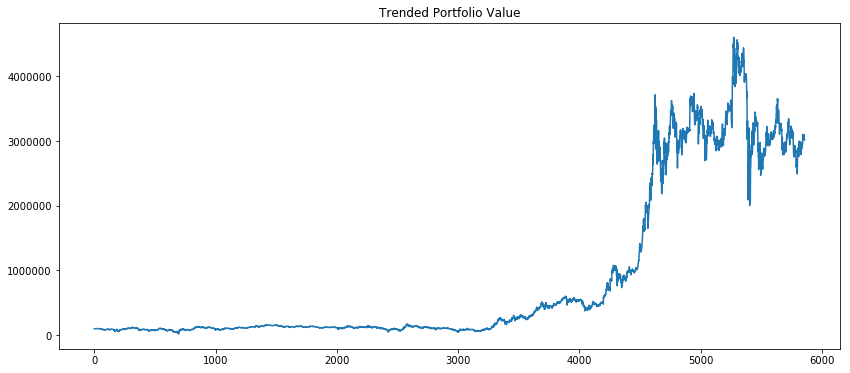

In [9]:
performance_summary(performance_30min)

## Fee: 0.25%

In [11]:
train_window_len = int(len(scaled_prices[scaled_prices.index < datetime(2017, 9, 1)].index))

In [12]:
performance_30min_fee = trading_simulation(scaled_prices,
                                           init_capital = init_capital,
                                           train_window = train_window_len,
                                           trading_fee = 0.0025,
                                           progress_print = 25
                                          )

Date: 2017-09-01 11:30:00
Capital: 102101.004213

Date: 2017-09-02 00:00:00
Capital: 97896.5489129

Date: 2017-09-02 12:30:00
Capital: 83831.1283052

Date: 2017-09-03 01:00:00
Capital: 89607.5546428

Date: 2017-09-03 13:30:00
Capital: 83025.8476949

Date: 2017-09-04 02:00:00
Capital: 89470.7305027

Date: 2017-09-04 14:30:00
Capital: 69037.0137405

Date: 2017-09-05 03:00:00
Capital: 61665.717616

Date: 2017-09-05 15:30:00
Capital: 79432.0285773

Date: 2017-09-06 04:00:00
Capital: 89297.5759828

Date: 2017-09-06 16:30:00
Capital: 103532.836622

Date: 2017-09-07 05:00:00
Capital: 104649.834342

Date: 2017-09-07 17:30:00
Capital: 111771.063904

Date: 2017-09-08 06:00:00
Capital: 102834.001112

Date: 2017-09-08 18:30:00
Capital: 77489.8387796

Date: 2017-09-09 07:00:00
Capital: 89755.9375717

Date: 2017-09-09 19:30:00
Capital: 81379.4405222

Date: 2017-09-10 08:00:00
Capital: 72438.3347106

Date: 2017-09-10 20:30:00
Capital: 71970.245976

Date: 2017-09-11 09:00:00
Capital: 72740.5038702

Da

Date: 2017-11-26 10:00:00
Capital: 345008.746105

Date: 2017-11-26 22:30:00
Capital: 371193.599133

Date: 2017-11-27 11:00:00
Capital: 432082.658544

Date: 2017-11-27 23:30:00
Capital: 516334.008492

Date: 2017-11-28 12:00:00
Capital: 533455.373157

Date: 2017-11-29 00:30:00
Capital: 768753.378506

Date: 2017-11-29 13:00:00
Capital: 798987.125218

Date: 2017-11-30 01:30:00
Capital: 707532.309129

Date: 2017-11-30 14:00:00
Capital: 558221.277585

Date: 2017-12-01 02:30:00
Capital: 652197.400084

Date: 2017-12-01 15:00:00
Capital: 713137.965168

Date: 2017-12-02 03:30:00
Capital: 698586.92358

Date: 2017-12-02 16:00:00
Capital: 711291.011778

Date: 2017-12-03 04:30:00
Capital: 768374.307813

Date: 2017-12-03 17:00:00
Capital: 1016864.56139

Date: 2017-12-04 05:30:00
Capital: 1207385.72314

Date: 2017-12-04 18:00:00
Capital: 1513511.61325

Date: 2017-12-05 06:30:00
Capital: 1440086.94828

Date: 2017-12-05 19:00:00
Capital: 1811638.58612

Date: 2017-12-06 07:30:00
Capital: 2721542.73863

D

In [22]:
# backup performance
performance_30min_fee = [100000, 100268.47705187785, 101077.39911302572, 101297.11217626554, 101379.80824662546, 101416.85734677254, 101456.80964789071, 102245.71378515052, 101888.18803522633, 100566.60239161344, 100409.10684651788, 100456.31556799376, 101888.5723293506, 101582.73858908369, 100781.3230423796, 101714.91622378258, 101971.16161521198, 102681.26549171362, 103147.85187361983, 102974.61062257495, 102712.18267751735, 102776.31311282187, 102752.74699363482, 101924.05625265115, 102101.00421283024, 101668.83207036134, 101851.61335560115, 101854.15241439763, 100547.07793503981, 100217.92730215308, 100809.94596476942, 101571.44032934403, 101547.57296998907, 101296.89810497714, 101431.14876416881, 100443.83291204003, 100686.70894226931, 100381.82631440458, 100184.36845659431, 100237.72962462965, 99915.8544387648, 99960.609748826944, 98852.436294316591, 96657.785649931655, 98196.527101830405, 99036.784567978029, 99002.632429121906, 98238.562769511933, 98854.652122838917, 97896.548912914222, 96356.224777349751, 94389.37783230358, 94679.004341220862, 94208.618443954969, 94521.666680832292, 91252.136677299743, 91512.383729814421, 93592.656263007957, 94438.421534051638, 90559.125920634047, 88072.837814006867, 91966.141833173955, 93724.161896130434, 94110.344684905183, 92755.906657639949, 90798.748064007828, 91574.284831509241, 89032.427793554074, 89667.474751895294, 90022.773156471347, 90754.622686191098, 91613.854322977393, 90010.559625219525, 88012.824041011598, 83831.128305235092, 86659.378647855701, 86945.518298814583, 86071.058343494049, 85548.321532666814, 82065.507677226764, 86298.86351524308, 84059.395748701092, 84124.055091887218, 84970.608461648255, 85461.103645737123, 83871.166834357151, 83605.416245652334, 83146.933042736011, 83337.612537490262, 80404.287819079575, 80429.41213539106, 80632.705796509588, 81709.279625239607, 83914.497087806827, 81785.78964757247, 83156.41410305482, 85865.73516016081, 87655.951639817838, 89243.850753436622, 89607.554642848627, 90494.936986245244, 89591.515822011512, 90264.99222933776, 90250.919990023307, 89765.728080700821, 92564.60890484773, 94998.801669866065, 94755.507141497481, 96514.958646362356, 95515.422234925645, 95111.635431884846, 95210.461315698194, 94131.486239745645, 94512.196628279518, 95039.49178210579, 91555.071656956221, 90522.317842126213, 90816.384172510865, 89568.123371885245, 86747.510307373566, 87540.941714314104, 85988.951514188637, 89082.476632869948, 85681.583326527572, 83025.847694863507, 82674.044869384437, 81391.191841386186, 83049.379372382711, 85343.657144123907, 86903.669538646092, 88144.061805056743, 89870.008185306506, 89280.675921864779, 88087.204090183252, 90725.174779017121, 91473.710920163372, 91819.02307800579, 91142.861800392624, 90504.582899768706, 89355.102276605816, 93046.631005494681, 92670.422473905855, 92645.414277968157, 93150.48829317221, 92785.124062338058, 90894.023613602956, 90892.520804722648, 90103.077444462513, 90402.142117262381, 89470.730502693681, 89343.98307691596, 88448.040534548491, 88795.823068839658, 88971.986091916682, 89884.663340842031, 90218.606748582853, 88658.986872463473, 87594.226621400478, 88677.933107227378, 85899.559676040211, 82937.682192727138, 74941.570615717705, 78202.241434289885, 78458.331720992312, 80472.08667566457, 81002.417870035337, 75790.91089446281, 68913.146856731022, 61411.534397426265, 56762.587584473717, 65541.618387752038, 72718.557611536948, 73823.649151348276, 74193.12226448764, 69037.013740494192, 66900.767958329016, 68655.880048771913, 69549.260903998875, 69827.615552753356, 69928.202941772121, 69619.848957159804, 78750.159912598698, 79628.356051064125, 87794.856041406631, 85257.344260798069, 84607.816659135628, 83965.321767077083, 89807.951774690882, 84876.474438269564, 80104.955943594687, 77517.835573594202, 68799.656656266859, 71651.147297476826, 72841.657923302701, 67839.47910671361, 61869.302070281999, 55346.102994527217, 57658.639183541716, 68448.179786355264, 61665.717615965463, 60562.191798723063, 61558.21209175633, 66959.971270103037, 60701.480311528474, 58875.769845295232, 65047.20180990886, 70175.977924220235, 71442.499587773564, 81511.090098750617, 75953.06606449731, 72915.484560881247, 70693.971592875576, 74831.35081959526, 75946.090431237244, 77106.741819519477, 75163.268481501815, 76230.059162951657, 80167.133301510214, 77216.054152343451, 79438.395162936155, 81076.238662828706, 80774.076208695973, 81715.431100543967, 79943.809364820336, 79432.028577341727, 81111.937385161364, 82935.810620611854, 86967.36925689147, 89259.927727541537, 91041.758565745433, 90206.058584650891, 92037.146670646907, 91107.941131123589, 89626.488343497709, 89990.251189823626, 91164.710953714079, 88316.733673082184, 87649.964218681416, 91485.603336916189, 92049.449388707944, 87827.074585888811, 88401.152425831664, 91475.690820317948, 90098.432245009957, 94582.783081438625, 92842.176686880091, 91019.396331159107, 92266.75560856724, 91383.062960657771, 89297.575982754293, 85941.450098686764, 87512.750819531706, 87249.45493337691, 86740.225664525206, 88478.455014728563, 91309.700217560894, 91985.823085686716, 92163.037360813876, 95417.034655998665, 96399.609062528674, 93123.553994155271, 94114.592346698148, 97418.583863842156, 95211.746491235288, 100243.27770212371, 98923.907458188507, 100153.8943243227, 96120.426527688905, 98915.796631978854, 100322.78618243017, 98440.194958799155, 99361.595153034505, 100789.05565220944, 102249.05358036181, 103532.83662228707, 105330.89473979895, 108632.26011350066, 107694.47777758009, 107615.98188024422, 107761.35680909158, 110172.48426846563, 109090.16636748401, 106153.22293515698, 107679.27039006486, 108163.77046965645, 107301.94268736191, 110310.77478973195, 108392.79475850443, 109779.09190307037, 108983.19452319932, 104531.59343579004, 101031.99480914095, 100267.13480049315, 102762.17829806272, 102054.39967045622, 104198.86813800878, 104434.43552686746, 103072.02574555678, 104449.1799496765, 104649.83434166691, 106052.0504990964, 104842.9702287159, 102750.49854277087, 102276.57388562066, 101306.20513933904, 101618.34154489973, 103712.10944838225, 106266.70519610481, 107055.34983653616, 114503.2643536682, 114692.53857211448, 115958.22869685279, 116174.30479902918, 113379.18003457921, 117691.73419764676, 115430.15537447909, 116257.52881422396, 114222.82145088859, 115005.73331673154, 115211.59016844803, 115052.40227722087, 115018.58283153718, 113298.13957527137, 111751.14231971529, 111771.06390350338, 107448.01103207486, 105059.37545431864, 105187.18155146432, 105131.28029249024, 107450.33890328508, 106551.58650134775, 104901.564375758, 104631.37632019605, 107505.19981533891, 105319.09330873634, 106513.29575722571, 107428.61084928518, 105919.5755513293, 105283.61606912143, 102350.21743451952, 100729.51586875296, 102828.14826957681, 101731.02645215654, 100444.82817875675, 100250.84136805148, 106142.48370864516, 106634.31965180143, 106796.1277420547, 103772.2264160724, 102834.001111841, 105175.88445940122, 103671.18075646993, 104597.66732286205, 107584.95339285675, 110150.42735662531, 107620.31291534797, 107854.14444134783, 106718.98604443762, 104620.55758751208, 106084.34197143622, 103213.79888710775, 103848.88032289743, 102306.91543983691, 95251.892714898713, 83152.05465355757, 73204.660507139371, 80920.637350221747, 80195.155279812665, 85813.36878925917, 88239.550266125065, 76903.014084866387, 80647.685379112168, 76013.776665002835, 79864.855389719363, 77489.838779614875, 76623.900826990532, 69429.960031964511, 74457.155997725946, 77817.315619157467, 73731.803723774065, 78638.197119351302, 79856.304960324705, 83732.32339744753, 87002.660366614989, 81281.740666616999, 80430.369186442171, 78183.47848735351, 77231.715553731017, 78070.050053338462, 77771.521567269825, 80413.45379273576, 81799.484864024387, 82199.124188348593, 80381.568407369414, 80794.368421017454, 84681.186176922783, 88007.178966643434, 89033.836034959153, 89935.928554871643, 89755.937571672141, 87650.71702269993, 86195.992495399361, 84997.733440336029, 85987.410537774005, 88128.489530747669, 88218.863992204759, 86824.715701145935, 88110.261788595206, 90240.507663488374, 89069.261551510252, 89541.270657187153, 86595.668994204912, 86749.558641039359, 81433.595925718982, 84501.659847710427, 84133.079259420367, 84413.396436108742, 83763.401604839659, 82621.972146255051, 80148.693289079645, 80453.141543971695, 79887.553017404687, 77560.037953775769, 80589.853112306155, 81379.440522221455, 81157.517334272226, 81470.071560999015, 82406.288815752952, 82430.292938989107, 82689.346484493348, 86573.530141071489, 85637.672243964218, 86077.50065740697, 86268.526816565878, 86310.687905917046, 83652.005129993457, 83814.132345219725, 83255.409683248887, 80732.59320088668, 83434.719697499997, 80682.851467667759, 81168.404043087925, 74689.590411780227, 73926.538182084274, 73120.961560688665, 71876.587632841751, 66459.121070958427, 68267.319852600471, 66517.487526994097, 72438.334710575204, 67326.310541336265, 68154.53772623089, 63388.684991769085, 63297.384013717805, 64383.68762157821, 65034.620038978283, 66918.738802773179, 65997.51951094871, 67724.647817427147, 69659.912114138482, 71245.498000231935, 69182.568905752938, 73593.93057636304, 71405.347289208381, 69657.588874501744, 71634.284481645445, 76242.718215127839, 79162.454174244485, 78432.21293726578, 75954.255858568591, 79937.754812769883, 78204.471598311429, 79040.374478730635, 74455.040727788262, 71970.245976038263, 70101.905722636264, 71315.987805602184, 73253.58025403475, 74085.13434843492, 72943.501177578408, 72633.445662464845, 72836.873713362162, 73465.965185257111, 74947.702133133003, 79608.764885218901, 79510.298350117664, 76907.47036368573, 80335.510047859774, 80829.037066628502, 74133.309479977499, 72635.318215502382, 72264.866790899032, 68831.017149029547, 72397.717040715535, 70458.46754221007, 71904.98671016538, 71495.794276999659, 68173.980963778158, 69269.707266130863, 72740.503870204353, 71885.144978122786, 73682.944738219536, 74425.315170612681, 72268.225175018189, 70853.327546804343, 71317.346451754856, 72942.022151147408, 70668.065549205712, 76047.932227767989, 75336.469466922237, 77244.109214701661, 76320.021878193191, 76449.682726070256, 77414.944225809246, 74198.84058110333, 74148.511222224421, 73928.281556038011, 75610.889075438638, 75261.603121091495, 73190.695460123796, 74028.790300390508, 74140.086681789486, 75206.34039171433, 75062.033156405974, 74591.494027795823, 76306.442917471213, 77050.639734366006, 83187.5900870037, 85689.3147867519, 97997.670121435993, 96729.47854363943, 96579.931152078498, 98107.60444993792, 96148.453525000092, 97515.982717767823, 98112.250307520575, 100405.65568491252, 100936.66337457875, 100475.00193658101, 101294.70091276962, 100464.74097754636, 101453.43930931851, 101914.04498473449, 100594.35521612516, 101593.92629057002, 100129.25162371673, 94293.071803872037, 93109.612349669565, 95072.860054828896, 93834.809634254663, 100006.24656858554, 102144.8316330518, 100435.16376816502, 99487.239285299176, 97834.009742952359, 95361.081586384113, 95072.130890426808, 95274.616282024159, 95802.809077812301, 95245.492912037938, 91999.754671720264, 93304.843437346222, 95182.381458928736, 95241.809781272939, 91471.503891285247, 81761.4748285963, 84895.452736349805, 87550.437501711509, 89776.643577222567, 87742.911763529584, 88545.504811275605, 90478.820739256902, 92174.432070403564, 89913.969048726882, 90106.993092787976, 89542.851617606269, 90887.788575748258, 84916.206574706972, 87479.281973722886, 86734.852354921924, 83005.339097884047, 79777.989770847562, 76943.774152921309, 72540.968797093054, 70821.151631321016, 70681.394886722337, 76636.42328359875, 75651.957517177245, 74064.916873754817, 76643.36621899248, 77856.430386539811, 73067.298716713645, 71792.559266260534, 72749.895987796772, 70867.933759767329, 73702.28067362569, 70406.441708870756, 69740.54060200922, 64768.078469024782, 60726.350724145959, 63667.82571713451, 64820.877389844172, 67498.088286128186, 66511.820493278938, 67032.170606535583, 65473.073850192814, 64145.688943663648, 67136.82801430265, 68414.158833275113, 69848.846868073713, 77334.63583702271, 77337.043914749258, 74262.590445722861, 75381.225385584345, 75874.588595047826, 73671.31852206582, 72798.024150325262, 75251.354167269761, 78644.139900433045, 78206.341288080366, 78236.779158801277, 81532.832951136574, 84113.914013120084, 82016.581847721915, 78521.898884204071, 79185.440727004243, 79312.422205271068, 76773.251978210203, 79281.665782912634, 76289.725012211522, 77302.465734377154, 73233.166184316229, 72570.775385759189, 74322.235851437523, 72863.146297183412, 75823.474271219806, 73491.085339589888, 74644.293779771237, 75426.506872814702, 79947.642467871614, 78488.939065972692, 76277.773197271512, 75176.621538563864, 75243.513992676919, 70924.561510082684, 69024.822543845235, 68785.531127568116, 63053.409997093273, 58862.327369720966, 60994.114482882542, 48555.868287375633, 50960.068526957126, 55214.349279533686, 54829.57294366321, 57937.560860248901, 56021.382343267294, 54774.447370997244, 53743.014805789098, 50337.618234659807, 46438.864283561677, 42522.946513264811, 46934.02848968115, 51348.448557596974, 50400.350215150167, 47778.025190246699, 51129.316843833265, 49834.753373398446, 45115.899765809532, 43935.622078294546, 47069.09552619727, 44848.918292544404, 40296.471124396805, 39184.947460988849, 47484.323810221867, 47390.434861219321, 50101.906614617852, 52106.094857629381, 55825.004392632385, 50267.662360278795, 47590.244018304817, 50452.426198769288, 49114.717694700332, 46733.40037689975, 45059.598802491557, 47644.671319179964, 40562.494877992576, 32653.223956489295, 33254.733169365347, 32618.829729543195, 28378.697104534149, 32700.601855862147, 25223.167133357932, 24856.462586948423, 24790.906402503002, 23330.437617896183, 17681.35164997528, 20478.616775091286, 41659.390955915027, 53080.56803267965, 50898.482585813836, 56671.407569393363, 69929.15516558793, 77067.592610615451, 69699.997913418803, 76929.169858120556, 73778.541016028117, 71155.96845251479, 65578.303630671537, 73050.140404853853, 74149.4275003972, 73661.718580677611, 77348.557337535516, 77769.999971670753, 79349.553321400861, 81280.262458233265, 88733.407799158347, 87177.175693637197, 78414.544394805271, 82328.267309061208, 76957.207878454938, 78480.623293108161, 79735.541958342714, 80135.311888021039, 82260.932505610981, 86187.627278765445, 85687.615917378746, 82126.110681805032, 82936.705571269325, 83647.358922114829, 83470.44649356477, 84131.969214702884, 91414.974886961616, 87598.963367878794, 81178.7469713678, 84051.526109321218, 84462.181000508222, 86755.501594697416, 88385.303904752072, 87568.584634736297, 86285.263395258342, 77332.576800803625, 71319.309480313328, 68713.261161380186, 72875.964788645448, 76619.259268592286, 70952.158986529597, 68898.316746773024, 66551.458522473156, 72262.233688493434, 73255.077635172347, 70204.878878855059, 71884.273679785954, 70940.210453997453, 71771.012664226204, 73539.821744172645, 73365.122966302923, 75990.473590551846, 79977.725344960607, 81513.770668513462, 78875.770063090677, 79691.021839065012, 79975.053492258303, 78656.609827325534, 76449.484329051018, 78876.029828011931, 80463.477989705716, 79725.828397141915, 78706.158413611687, 78573.806954282365, 76466.294745687279, 76643.134230832628, 75168.755418037603, 75436.231288832409, 75814.879326685506, 76236.188987049652, 75793.890432969376, 76417.108993230417, 73505.583446011267, 73960.402576931607, 72638.105505976302, 70596.999633111016, 71872.501515872602, 69580.778426950274, 69909.361446984956, 69030.178578830513, 66463.168261998115, 69185.016771898954, 67558.394792952022, 73176.753981733695, 73585.791695215506, 71803.901170474244, 71404.699950322451, 70895.509806095753, 71563.592259269964, 71477.302041613613, 74659.15888768257, 77786.927570591666, 77930.171870391452, 79227.275620922504, 78063.932340698419, 79691.447147134226, 83691.585332483533, 83215.115848625341, 84011.530318497447, 85218.05547086359, 84592.589555100712, 83397.772069404484, 83957.612279665424, 83991.253647337813, 85967.680657754638, 83120.824064945249, 82650.834543568242, 82122.662951858394, 83454.0921260998, 82669.970000285422, 80792.095004701288, 81204.267183929609, 84523.390789982514, 88149.835293608718, 95686.61447740873, 94588.917076442973, 97833.327800678089, 99408.083965628844, 95906.16429461076, 96293.717621118762, 94128.835072274873, 98047.744822869485, 103753.62961710618, 105036.1531219676, 102038.75048854854, 109244.79420562173, 111228.82176752426, 109493.93945285027, 109880.19980381454, 112498.53984283049, 116251.69852396188, 109940.55883789982, 108724.73064768067, 115969.69857716434, 115128.59705553664, 112912.16331517804, 119195.21904557024, 121577.02187815026, 121271.62130052624, 120145.08170203282, 121103.5647436275, 113105.29752643689, 117048.98543262426, 114617.78541238388, 113336.79508020793, 112438.18600544005, 109859.86454384599, 113798.64885561794, 115758.31710152327, 117619.13987930931, 114916.47530149337, 116446.50386535497, 115694.79703896874, 115626.27721786057, 118660.3068396204, 121647.84889126207, 123221.95648702511, 120635.50935689642, 121516.08713953738, 122964.97544060755, 124977.19389443033, 117197.8453717427, 114750.20568130328, 113645.5881024432, 111177.136107546, 114196.52689247618, 112190.96176033579, 113027.86212420277, 112162.60825347897, 107481.19544218638, 106311.9493452694, 107238.0100973408, 107656.37069876982, 111619.12754537392, 108741.72706570225, 107254.65181841864, 110553.32117568213, 109230.78138572535, 109440.0401933417, 110469.64343848029, 112067.38972978556, 115949.96440703365, 114099.49272165805, 113179.59523947944, 116324.32704961998, 115015.59539467591, 111324.90929961066, 109060.50169524481, 111351.57714639799, 110726.83336734271, 111496.52511777519, 114686.77417812147, 113717.47492393237, 114422.91936476465, 116218.26757117669, 112666.68512972695, 113709.87897929084, 112249.06646666559, 107545.42417222056, 106964.8666400628, 107972.8747551855, 105944.95962920772, 106973.77231994871, 106216.24772619247, 108021.70866177294, 106208.86785837109, 108848.52401018381, 104986.18166955689, 106498.61828991619, 106391.11519825147, 106353.04204438964, 104346.22373174393, 106626.01723225959, 104580.53355304422, 105281.29277396444, 103809.26820740261, 99639.449994400289, 101335.26742453486, 100232.19742077227, 104934.1775018574, 107726.78646540109, 110146.19249031605, 108564.65716819375, 110063.47644004808, 108913.71757893465, 107780.46115986007, 110152.16979726244, 106838.84183135102, 105306.51325834059, 106208.76365112764, 106145.80067482041, 105815.2880435235, 107329.33639413751, 107225.07870508067, 106396.74246759134, 112924.98701311479, 115436.96370787184, 114863.23277784692, 114109.58077796924, 113533.44359853138, 113304.84344673945, 115724.56954069769, 114044.58043944971, 114379.00374316814, 113100.6399528911, 113895.05730391122, 112929.16355522431, 111455.87059031404, 111339.7761854452, 112472.88112807432, 112391.56137362157, 110980.62638415195, 111566.22859272776, 110725.61530784905, 109894.45605391043, 106327.03424181268, 108003.89433378939, 104483.58416514937, 100648.69446840766, 100282.55334926881, 100659.76664238382, 101909.95909964739, 100632.42781271401, 97832.049820919143, 98061.725604703155, 100404.07450284671, 100806.44665391474, 100575.03120060312, 101527.20084140022, 99982.095436859978, 99392.126303066645, 101578.0186447141, 102780.3224984289, 99797.395941061754, 98840.391405037517, 99827.174521324807, 100441.23341787866, 102324.32234772801, 101495.2241177375, 98595.102752426756, 98698.778877180433, 99575.06838512313, 100883.45477270328, 99837.038375759264, 99290.340861821751, 92858.555995824339, 85379.110559905879, 88759.567399005158, 82090.133907745942, 83359.055291899189, 81368.284994094807, 80087.385947479081, 82664.593016576182, 80644.098063476908, 75628.65740229396, 77463.73591438141, 74052.540513030108, 82270.418337552343, 85632.30210670369, 82637.637959668558, 82942.700816963945, 80542.145029753927, 79635.992008902074, 80063.984564370592, 82998.405847263202, 83556.269617294514, 83078.779549198312, 82957.710335304262, 84639.37688110309, 81006.78779099416, 84107.443725472651, 84806.752071286784, 90225.098189829529, 87940.768298577459, 88135.85337245425, 87883.132527123045, 87684.66005203317, 89770.089950701615, 84392.734231021052, 81587.706658060313, 78008.02033597877, 81981.714947127533, 78712.630411025049, 75333.173969223921, 75674.133648856048, 76171.780278892984, 77391.326939851628, 73557.722266103301, 75159.538851040765, 78365.403685057856, 76982.812363455319, 75212.297768363147, 79209.776057821262, 78953.827381793555, 72589.599109709889, 74239.34684516475, 76935.677906190424, 76982.398251785635, 75889.97958634136, 77047.694210272442, 78966.118283266376, 78066.365165136434, 79380.630103162606, 80201.937105893696, 82596.744219992761, 80765.913411039219, 80119.375901811494, 83361.841112479058, 83382.042294967032, 82090.499718138191, 84010.65609553273, 82083.775052215875, 80118.53885965173, 81639.247507848195, 78441.243651181634, 79677.272529804541, 80988.862259331159, 84843.949975936324, 83821.554478247577, 83272.11973085042, 88427.153222789464, 89775.530174446118, 88584.427901912379, 88656.527745882515, 91853.922297029727, 89748.327363456425, 89751.220736841875, 90260.177319144001, 94771.397748963151, 93028.995339394809, 93208.650004824012, 93366.401881050726, 95921.54691192045, 99025.329500006759, 97648.909449305662, 100415.71410568146, 98502.493313349201, 98229.368129877592, 96999.89958649961, 98547.980733495264, 97136.109975339088, 96114.771059226157, 93500.88867596777, 92578.838997390209, 94407.583523817157, 97153.446237171884, 96373.331928044965, 94828.20068784937, 95788.108263509668, 95034.346043607598, 95151.350076770876, 96775.965751127165, 97321.145862988982, 97445.290910804804, 95484.077800399536, 94441.831086280348, 95947.621267231501, 95887.457786724932, 96614.050967198535, 98033.830268800462, 97432.436725100415, 95274.676251473516, 96341.045400461182, 98003.8646624393, 97132.856387238222, 97850.563049594319, 97479.097560233829, 98098.327369473671, 93001.093892400735, 88573.758009367593, 88887.040555931773, 90183.12175741035, 88936.705525999874, 85613.987978057732, 84537.138974095113, 86919.285199935257, 87908.146772401087, 88551.18725058253, 87223.758603462207, 88428.672863085434, 89454.615273833013, 87783.718290594989, 89738.871281381143, 88456.090438064479, 88942.244617650198, 89878.427437019054, 93135.72797592498, 93539.128674615844, 91035.038821970782, 89785.331088465377, 90086.350794103055, 90603.931862300233, 90553.402994959586, 90058.314562017753, 89732.841773875436, 89598.665938750812, 85844.30771135664, 86462.429387082055, 87401.560583976418, 89445.65350230792, 86584.958302377199, 87640.151096114685, 91722.472816651221, 91302.982480993451, 91202.421723071238, 92714.749971896614, 90546.50940652618, 89125.31567249076, 91217.061663626519, 91221.879340898828, 91372.60820385543, 91812.068632412527, 97929.501116066895, 97909.580567234661, 96226.191591799114, 97426.375096271324, 101099.62584173999, 100887.75015985253, 98405.745167837798, 98466.728004611679, 99550.408286914084, 97966.741964529036, 98965.265521970374, 99897.866425228451, 96762.823169341427, 98058.40097036348, 98202.619644698192, 97892.513700247684, 97246.732904931283, 99476.395036263391, 97450.219272956281, 96538.811946848175, 96264.518645558623, 97591.563344252063, 96996.711354032726, 96083.505903736179, 105065.59925024187, 108277.71243873198, 105790.35058050795, 108267.63470436097, 108711.41311374915, 106542.72319164827, 105607.27454704355, 105985.90244112859, 107463.15452780967, 106294.9848112161, 107403.70052689861, 108951.38839761824, 110612.61923172207, 109849.21286086357, 109999.90046480433, 111557.51159265196, 110175.75914735071, 107404.35120269658, 108070.07910356714, 108084.40876390666, 108204.50966045144, 109287.36445699629, 108735.47243398026, 108545.32596464086, 107145.62110974616, 106930.56079286701, 104139.67014057148, 103903.02167843816, 104280.97614885087, 104810.87721172269, 100125.13252699067, 100038.78309063627, 101204.59857809931, 102916.9103910829, 102794.7832373245, 104717.8372962898, 105604.99971838333, 106454.19872629664, 105100.71356524416, 106527.32607414237, 106916.08085848932, 107275.98172783478, 106957.56743297106, 108531.99891164122, 108866.88442030753, 106026.75004508386, 105875.32683234787, 104915.44767410459, 101176.78314056726, 103153.41636276356, 100335.41541988132, 103166.05235160679, 100957.64423081974, 100983.22153729474, 101767.86147792255, 100978.10546332964, 101061.87302832563, 101711.02802742856, 100491.02120116985, 101364.0005894957, 100104.89571559563, 99846.668209149997, 100771.9733730985, 100282.18226644778, 100234.46971096883, 98079.915424746549, 95949.789544627798, 97081.977026016088, 97503.235304102869, 99406.622190644324, 100568.64584291261, 98574.281152552838, 98521.119457859357, 98781.611843274557, 102231.79618293016, 100666.40711896063, 99946.288374815515, 98129.796477112221, 100946.81358635427, 101487.36700783327, 100261.30506130386, 100086.84375791367, 100150.75879874523, 99402.670476931089, 99674.128931041996, 100794.4489409283, 102033.92614042072, 101508.99178746706, 108992.8011789233, 109500.34409744006, 110525.53185948457, 109924.66484368531, 109877.70757160336, 111249.61781967022, 110839.97535278686, 108654.9149460831, 110748.97697981852, 110834.90693832887, 111360.53362916931, 109058.46532991846, 109884.40152273839, 109303.26439261156, 110229.24772746544, 110595.82480375333, 113789.96197882728, 116961.77472570571, 115727.34758002032, 117628.49785093238, 116517.28992087272, 114892.06488178339, 115153.11581685572, 117738.52031708506, 116180.18970573199, 116761.796870891, 118445.84920965758, 117335.39760018696, 115157.80089925943, 115664.63310943349, 115093.63959189846, 115628.54128733589, 116832.22220869979, 117338.65728529739, 116152.62117790752, 115600.22980957755, 116347.36859275564, 118548.77450224145, 117320.57649403827, 116563.84811418441, 115852.82249279766, 116412.60959329709, 115548.63796499475, 115928.8446793597, 115326.73628438616, 116149.02846657294, 115980.92703530868, 117070.47752455085, 114566.81769836265, 111913.05441788264, 111473.77362021348, 112429.38329908748, 111267.55222650908, 112148.83006034132, 112462.68340394509, 111888.96739417245, 110178.53330017757, 111294.69694224646, 114217.67063613396, 124209.63623193881, 122257.88492377262, 125013.96500062502, 126682.16961859047, 128169.23707610471, 127248.12864491413, 124037.81443513578, 125105.67034287931, 123492.19911893031, 125558.63245899233, 125492.84767456831, 126547.36407921162, 127737.29416766646, 127436.21320992643, 125422.49836628155, 126049.0051583731, 127371.68059962001, 129911.76497474678, 128157.37522350918, 128066.13687852076, 126283.27625840556, 120367.4257954926, 113821.64083408975, 113497.30696063908, 111582.47913776326, 112823.63854550445, 112619.66917577432, 110265.24999776247, 110668.14199296468, 108768.28046634592, 116719.68455286666, 115327.78293706579, 118095.33728181952, 119339.61211065153, 118288.39326927817, 116213.77961887591, 114189.38940798902, 115877.56077800289, 120528.50648083232, 121359.16309747586, 125751.44963816184, 126437.57811381877, 128018.55259164775, 123997.62623527239, 123629.92681528247, 125295.39014453421, 125352.50376032108, 125594.35666422258, 127246.32202036642, 127443.29593565447, 127011.44625227837, 126353.73060320634, 124001.18654391705, 123179.64373128889, 121804.03244229991, 124260.19334764057, 122677.0780076142, 125094.99650830904, 124156.82424431748, 124991.80046700695, 124322.3396124618, 124605.38637564427, 122754.53769682304, 121989.93787339854, 123286.87429429592, 122042.55207123674, 123900.32868353606, 125917.50665599988, 128406.72304464213, 127555.09088034995, 129025.92229165579, 127737.67914729146, 125739.43571288497, 126070.93001277273, 126898.38062849479, 127713.80788783975, 128978.24238319091, 131127.24756942509, 133614.7911634862, 132957.15242370762, 135716.88674403075, 133474.04245478412, 132469.33125606348, 142023.28275124598, 138295.05955486686, 140181.65275822586, 140443.57935652894, 143232.99433013075, 140829.7152348535, 139463.31707006894, 139432.56440577513, 138181.46050131856, 139181.67991264601, 140104.09607043932, 141915.35507042898, 141667.17945281527, 140871.47245809357, 141634.89045247459, 137013.79922727664, 137766.55198070002, 137939.95463071487, 139013.84297437119, 138983.11089398319, 138431.90427331463, 139538.49014229808, 141319.26087653136, 141117.33915560722, 140408.20646690181, 138111.29067861312, 138155.74709871161, 138981.31889089308, 139220.3639420853, 139646.76556742494, 141642.52168101535, 140324.05036920373, 138225.38751578622, 138529.99409918237, 136362.60425733752, 134410.91840201631, 134455.62623226791, 135991.13599817915, 136106.45133612276, 136834.58914229611, 137140.70488023805, 137871.58346984634, 138701.68507744692, 138493.99191350464, 137986.81923912175, 138357.02976593398, 136979.27158162615, 135782.06990418874, 134920.23846630647, 134477.46577813601, 135084.12839131139, 134888.14921121651, 134548.00030422278, 133575.29483241972, 132521.55625760436, 130207.15877973386, 128752.19405061312, 130882.76516920497, 131405.98599710735, 132173.21030555537, 132564.9851094739, 134045.54445319218, 134595.00857584504, 133478.91915867725, 132480.49714692126, 132649.32783541916, 131996.44914420662, 133161.28919650329, 133030.68005317484, 132669.31447592174, 133270.84281744499, 134947.39495535611, 136828.9280719778, 137181.45423892059, 138950.4571014588, 138988.07448976691, 138001.70622817278, 138553.64362472578, 140033.41870198981, 141079.05685998005, 140765.90202773854, 140852.48134765931, 141250.44886552478, 137925.53562440607, 138244.4221255595, 138667.15810935118, 139315.68196755205, 137823.20824412655, 137599.28114323929, 141099.96961193468, 140503.69894595424, 140500.27301097338, 140498.14150401126, 137733.57938282489, 141026.39812390553, 138450.66921278305, 137752.31222010119, 138940.09777118271, 138334.74517494487, 137971.15650915811, 136878.37868603723, 131099.14572634827, 132018.06860455847, 127221.59473545729, 128309.04206233719, 129303.41420005429, 130458.80994045446, 132621.81752940759, 130850.5868246959, 129245.70197593399, 132212.6554443941, 130626.57893805423, 127769.95090457752, 128776.90251201982, 128648.67900726135, 125953.07721471071, 128926.12103866569, 128183.88744506362, 128078.26936951347, 128250.5285718331, 127328.41543191401, 125028.9203860464, 127532.70650288378, 126141.16256375393, 127103.68592285547, 129279.77966620179, 128688.07132655018, 128171.35236314082, 127332.36173513604, 128696.78298984189, 130689.37103617736, 130345.09702242215, 130333.36871349771, 131110.52931583795, 130853.14835865136, 130582.50529641373, 125050.60442748386, 118294.31353914594, 116733.7234122927, 116476.28437080415, 117027.44943025449, 117294.82058096166, 119780.67830123301, 120296.15566617249, 117081.62530709013, 116325.30505817883, 113910.13870100572, 117197.00981340886, 116605.78569334708, 116538.97293668639, 114703.61308583693, 111468.91776241089, 110664.87648781392, 108728.58847513219, 110965.52003164633, 113261.59226826637, 113472.7223234993, 115990.88127056934, 116253.5347523563, 113163.20805508585, 115659.15412594056, 116760.30967111443, 118601.52885962787, 118895.72519330033, 117032.29050091385, 115868.83864059855, 117989.31754399596, 119618.80164992265, 118054.55769117075, 117292.24697425548, 117514.61931099683, 119003.04312305486, 121138.10333573594, 122237.32609923492, 123746.45563151364, 123500.66500881617, 121377.43522178443, 122091.30254140224, 120747.25853922337, 119204.85324756805, 119292.38046814917, 120768.29531876824, 121392.78290732222, 121805.2276258951, 122335.83689962197, 123363.23109947766, 123280.44405504837, 122847.21449932022, 124183.79472911515, 122688.13581879468, 118587.12626792141, 117390.31240975996, 118466.01027765084, 112865.9790676433, 109648.7434068303, 111626.7335046862, 112542.43975756998, 113246.92201744638, 114448.18932863901, 108889.68389177357, 108775.93845070434, 113477.62693009007, 112747.33617989821, 110823.31341950753, 113434.55471417928, 113321.24054115696, 112525.26753238929, 114289.10663538499, 114119.7889542675, 116355.18718084719, 114430.2828415174, 115114.84245698131, 116553.11982947703, 115311.00769451304, 114734.0626359913, 112956.14742436109, 114491.70872175903, 116114.62713484855, 116082.87557887757, 116561.90193362847, 116349.12479735643, 116050.90753258351, 114954.01035046855, 116111.55521157704, 115324.04050458349, 115310.06780871368, 115087.12770881453, 114461.09947954862, 111606.72495537714, 110377.41590325497, 108617.08292994343, 108957.7612476214, 107134.45633683995, 107075.70814771901, 109320.58185730278, 109784.71612789725, 111035.69293971735, 110327.20993699628, 110918.91934917614, 111215.50130306833, 111885.74457982002, 112456.42893611797, 116703.88598496931, 116311.29811007217, 115594.71248060442, 114587.85424573453, 118819.4877842422, 120833.68357479176, 120737.19460048561, 121107.84819827587, 121439.96068298096, 120320.75996621681, 121072.35282558159, 122512.31521236355, 123390.8549674102, 123984.19655195835, 122617.17824963614, 120419.37648827476, 123175.85168448079, 123203.43512256409, 122179.12315322143, 123775.21006247638, 122427.94196378592, 120725.8852515764, 121485.88469470701, 120296.97377307405, 120616.90668774251, 122069.79024974548, 118729.1446791644, 118281.36947909574, 117314.3287004255, 119287.06454591217, 119901.70251365719, 121899.04107593701, 121860.13807639865, 119451.98385430258, 120056.45648351789, 121769.33401777151, 120596.7655364114, 121086.705453132, 120793.67585839599, 124072.8489582879, 123105.37881226899, 124387.67311930255, 125745.09072864102, 125781.4429793997, 124374.49509247775, 124643.37271314239, 124061.38982301571, 126447.92753965799, 125152.11508719801, 123765.47910468237, 124049.66174118238, 123526.20717623419, 123178.35862769604, 124798.45817397401, 122063.64823165791, 119812.34624775487, 121812.36030799476, 121427.38247679248, 122412.04522101366, 119004.29213936058, 117375.81257819616, 118059.48427720611, 118659.95623295633, 113622.14613764617, 111789.87775024193, 113187.1455770436, 111708.56269022114, 115552.68480642587, 113286.18445652336, 113472.27684740012, 112391.08237611277, 112699.39738284261, 110187.73623780759, 108480.87052298491, 109446.27451553362, 109898.72813760885, 111077.85487025128, 111174.00977341915, 113368.60049007004, 116090.60408849957, 114375.23453297556, 114346.98203610501, 112889.81941087503, 113673.79841845657, 112817.07322197486, 112459.26602464805, 113966.87799208814, 113505.2925749796, 111084.91776997711, 105860.35728724224, 108529.73225978068, 108967.5515369849, 110947.50418559155, 110804.55256636819, 111117.04570324146, 109770.97204416996, 109564.0738075095, 107693.78991684021, 107083.91850651609, 108669.84350075255, 107238.67863958253, 107808.03121492802, 109544.74966533057, 107827.58587028981, 110703.23031944982, 110465.01831190602, 111565.8602030398, 112352.59316696589, 111128.73716028052, 110672.37042417246, 111122.98132845139, 112136.00402029989, 112352.39698546944, 111852.32190969749, 112061.11457715525, 111395.23772100048, 111206.23771382627, 111057.74437982732, 109692.2136496536, 109967.47159211084, 112344.98100397718, 123114.04207419427, 122183.46955164, 121552.71143760177, 122622.80648328178, 120896.15129920575, 117911.77719026821, 121445.3461896646, 120639.16737537057, 121772.45559633747, 121424.43060973608, 121316.230155531, 119310.45194495522, 120329.61339409635, 121215.78004024366, 121312.82729102271, 120126.54767996505, 120542.83621538378, 120548.75331656395, 121670.28885072921, 122255.31687333179, 121668.32375469727, 119975.45928839286, 120070.55664472117, 120840.03872130797, 121203.10602029001, 121209.2317458894, 118664.70942075916, 119877.16452125636, 118097.84088113066, 121522.71243404351, 120818.45195958501, 120127.93543804504, 120281.38576270672, 119076.18009377536, 117976.0207760225, 116068.81699638188, 116804.95142572638, 118996.81973960806, 118708.37636212105, 117626.76710968048, 117609.3537248314, 117797.72744580274, 118956.95486807526, 117884.50708738007, 116178.30326068828, 114670.28126885708, 113325.39039319658, 113494.54184796076, 113243.41512441199, 113530.22691993622, 113155.25337105672, 111028.25400143783, 109779.26045095488, 110327.58426369718, 112757.77461570868, 112454.27761280688, 110611.89530827737, 110796.81978463486, 109444.15944366486, 109027.69773135995, 109109.96286802503, 111252.66431367742, 113027.11719765651, 112166.42113817314, 111521.29443438779, 111244.44701258621, 108751.9185844521, 108706.34454528721, 108408.49893793257, 107914.20258414099, 109264.98074278943, 109604.37839039703, 109995.68958953622, 110285.96736914832, 109859.13566047973, 109011.17613009582, 107130.09674292998, 107151.49891770221, 103165.84808700578, 101108.42627738701, 96407.287540095058, 101207.01088135419, 100818.25231838635, 99654.375497662317, 98291.555949577654, 100018.92066074663, 97597.032894882053, 95681.713112282727, 94676.923262257158, 96949.039626632613, 97296.300150657771, 100619.20825664222, 98163.207175413045, 100079.61490169758, 101056.73216350857, 101538.34046523354, 102527.91391389399, 102520.82106061796, 103858.1660224926, 103187.52958257508, 101540.9514698532, 102083.11214847118, 102646.88664140973, 102449.32463561473, 102415.13616122623, 100177.86981688302, 99912.000369124929, 99148.020044723424, 99854.882541309751, 102130.9495211724, 99975.15087321648, 98385.781107796443, 99715.609949549224, 98902.089468799051, 99804.133488699648, 103789.37319023986, 102960.47759579, 102108.93023984619, 103428.08718855525, 104194.93140606972, 107035.21684153503, 107581.81969164587, 108498.79698722817, 110726.96828459144, 111454.75034108193, 110285.51509349758, 110209.58148948252, 110856.4695430024, 107323.07190724793, 107058.98491790674, 107239.60241765207, 109677.45166294326, 111789.75063116572, 109405.1250800737, 105311.39470450772, 107108.15464497118, 108161.86399936705, 107691.02330866006, 110827.23480457232, 107899.06282166451, 108627.04526312921, 108394.14398620269, 108966.27383041411, 108406.14062124025, 107777.07371255747, 105604.85753132359, 107050.09030877009, 107586.4745589818, 106787.83995837756, 107398.81806380609, 107800.63671360728, 109478.48683108861, 108661.55910976458, 106370.5402147733, 106479.15166841727, 105542.44958448285, 106644.17597257748, 106409.96327180459, 107363.75355790893, 107378.11961470594, 107166.64028077974, 106495.78244900185, 107589.07555284543, 109260.5151192648, 107455.22820976583, 105323.64056658404, 104999.11419581831, 103866.90813878096, 105177.81044057582, 104928.99327783739, 104506.68831696855, 105856.14240650523, 105209.72847059768, 104951.81533120835, 103663.69871854199, 104486.67805526085, 105411.26258107301, 106906.35449679439, 108900.1067041338, 109333.74995731788, 110397.67583510165, 109792.43183410456, 109840.84515262667, 110461.15173389103, 110580.99787029998, 113189.54739405389, 111123.51619610105, 109267.64755628625, 110412.57994986042, 109202.40387334237, 109265.55099379527, 109972.38183139573, 109342.39115974944, 109858.77591960591, 110112.30351652815, 110514.39497997033, 110283.54757708027, 111745.24048844582, 111345.20314174128, 112129.36175677349, 112637.76110524444, 111574.60012884309, 111901.88309410874, 111450.13741187593, 111656.44123935589, 110615.63314836679, 110616.35167714153, 110783.94424542366, 107622.65948523558, 100749.503126033, 103328.00339577009, 104304.23897806382, 105078.82038207538, 106017.11885353964, 106319.61956427371, 106272.03191110905, 108039.16590076825, 106574.04278854633, 105203.20574394758, 106555.46976000973, 106613.40814010947, 106251.73468424074, 106619.13688403262, 104088.37531416496, 102489.62112848766, 103544.75659654706, 103325.16954486931, 103611.76110448479, 99671.619251022203, 103649.91893532855, 102511.34399190078, 101994.50949821246, 99098.29431384214, 90632.027738001809, 93396.691444233089, 96007.167688263784, 78667.587380983401, 83549.369070043409, 92913.826432738075, 88382.697367930188, 95665.239145194559, 99025.521641967571, 86373.256851227299, 87651.390241383458, 88825.599888242636, 95770.053654221163, 95890.501775185054, 93539.758267208774, 88199.120102845103, 94107.84721906975, 95330.064962262957, 94847.050567019935, 91307.175649065815, 95470.945707163904, 94458.472280206115, 96149.789112838291, 101134.57053858475, 101971.07594174, 98697.833895147021, 100278.46126003482, 94669.512840038777, 99676.031637620297, 95872.302823604448, 96871.180892606164, 99850.854997213173, 95131.116555786546, 94858.702479388463, 95095.544250075327, 96598.950117822096, 95524.120128395312, 92514.23911170775, 84669.819078748493, 91446.616750860805, 93615.856780551112, 96290.565301511495, 92242.470077478429, 92616.116012817394, 93764.577108542086, 94256.288697189637, 95189.721426817079, 94443.090354397995, 95676.491074053207, 93777.647228340677, 92050.513774811188, 92592.383105482819, 97279.466899450839, 102396.27635716593, 101432.43022566837, 104430.00216996387, 102842.97541566455, 104440.71059945761, 100834.54728891715, 102917.94649178523, 103551.43100966437, 105873.74664952082, 104967.70820295128, 100768.91806020637, 102730.28312233524, 103314.16740153273, 103421.35314168929, 104681.81434525721, 105027.4459295572, 104668.17246531893, 105655.77111472748, 106110.26975128231, 107882.49130319737, 115686.58594107276, 116187.65471477322, 119726.69965546974, 117595.78833484251, 124199.27674427329, 124468.38292010062, 118976.65744720622, 116329.5355203033, 116360.31904317474, 117227.67997084753, 111189.29891668764, 111255.06576453819, 109239.84418876938, 108339.22738300433, 111126.5002595315, 115711.08241694191, 119265.49316815865, 121224.15824210258, 118536.84484003937, 119549.83756073186, 120154.69858926948, 117396.04437132025, 118050.11250833521, 119269.45883348239, 118024.64434621927, 114994.75501891781, 113347.05644696183, 114341.9597435171, 118123.25031642822, 117432.5374392732, 121087.97473594491, 116646.16467664146, 115440.13384239748, 114374.37407861122, 115143.54956761841, 115650.09756846537, 114667.66331665762, 115603.0269217345, 112048.39909792203, 111433.79406223395, 108640.45176529016, 107633.56763985031, 106620.8103997125, 109215.24417493257, 109256.56563161245, 106513.02014926524, 109658.43962902843, 110352.95553136995, 110179.89883919098, 105276.30928861894, 105441.53483793962, 103702.50760585189, 104571.62520461815, 104726.31958690698, 95513.37962338049, 95445.688214201829, 94419.402374619385, 98265.109239930272, 96260.93772184824, 99243.881086517387, 99151.488769951, 97207.393912514613, 99568.221595191353, 98675.526881457816, 99644.886521950408, 97520.51911600327, 96463.76032243752, 96643.891536922107, 95491.342555116047, 96622.790880797285, 96692.267855703554, 95906.883253371503, 95497.730067762372, 96502.852992739688, 98731.011171745282, 97099.501758919359, 99771.768340577793, 106151.6690849208, 106192.17649755906, 107032.18918508284, 104073.53277991517, 105402.25706198643, 106280.74344110891, 106146.2692890998, 105632.33751426269, 104070.62910657941, 104140.86397991463, 106116.29133243201, 99925.522671538725, 101994.74447032723, 97136.254063653425, 98245.4849801604, 101454.19883410775, 97371.825012947331, 99557.377591951401, 98032.394136554372, 100368.38419949712, 100593.97016107927, 100714.07684594057, 106366.59453775921, 107892.74789143071, 109125.90927571013, 105970.17598680138, 108140.79771179942, 110728.78642109272, 112883.65564429873, 114408.22574292471, 114895.08751359564, 111370.54318713976, 110470.58351694481, 113854.82801421839, 115935.3301391915, 114665.83509427411, 110324.70213463873, 108423.65079140608, 112000.76268166525, 110048.30356108461, 109062.40335814489, 108801.81544334187, 108267.72744461302, 110968.04983425039, 107547.93513548061, 106774.89722863717, 107715.47676318257, 107974.00438967324, 108257.1680149271, 109832.690704423, 110373.50752431198, 110481.88795683149, 111218.56098602951, 110849.04915460697, 110525.76323084492, 103407.58259398039, 108278.08505609752, 106097.0164352516, 106225.65143451243, 106438.01543294385, 105513.55778917851, 107128.1471189954, 107826.41584554961, 105607.07815128814, 106977.81737921122, 108570.82314487122, 110157.2228991935, 109863.01604276465, 107926.93818939233, 109709.06810007534, 109388.01493965436, 107796.96305611203, 106901.22889152878, 106970.74862428561, 106771.00414940252, 105145.64490320321, 102903.46485703427, 102984.4054319982, 104550.52059734546, 104460.79780443109, 105099.74113999234, 102840.45019880647, 106598.57979968196, 104154.99554228396, 105908.84862230539, 103242.66958752574, 103991.61698961152, 103853.88728983999, 104550.52280028271, 103552.46708885637, 105133.82507121816, 105164.71560130194, 105342.89280012477, 101743.06384467213, 101685.33944493384, 103434.50877723211, 121429.20597589071, 115435.84745829541, 123622.86799850097, 118547.38004630838, 120382.4256328538, 113546.46644782036, 108680.44748403644, 107355.82680267471, 108016.94575986275, 110600.04454506459, 110630.6490614061, 114140.58343712379, 118020.68075671024, 114824.17478806429, 119411.76608684188, 117606.55875766484, 119811.91709029787, 107924.54072189554, 112289.57602996593, 111514.41272306802, 110178.90708119815, 110160.19668801455, 110653.01993095611, 110758.00344020827, 112017.52261743456, 112998.65735766674, 113823.08529371565, 113113.16153599546, 112976.08889129713, 111394.35473973359, 106317.27579666366, 100584.96983088933, 100861.44729348845, 96820.622989722033, 96786.409661538579, 105157.18065394404, 103495.68218128942, 100477.18399454678, 100936.20923023627, 100757.58501667692, 103385.29972352202, 102978.23203477536, 104821.12397729116, 103181.34343190592, 103828.04740061067, 105925.31767137656, 108782.36633055359, 107844.18783967878, 110920.31458878698, 110046.87236002387, 109762.91514059065, 111569.11891951886, 109756.85820525218, 109322.95531862312, 112032.72644213746, 112800.78305087067, 112144.59949450691, 112159.73181098548, 113741.53414579247, 112997.10485228711, 113292.2021657756, 112792.90052676342, 114970.87338988585, 113099.21315934656, 112821.31889146456, 112719.48605798297, 112046.37957600167, 113547.13696200686, 113506.55213238382, 112211.87928930591, 110014.11378094215, 109619.29950493883, 98699.539485149449, 103036.86951208064, 101574.24679417972, 102891.84675083874, 103178.15266581665, 105597.71410563377, 102549.15229758812, 102682.66420951055, 91482.413195222674, 96565.079271059614, 101112.70597437405, 96517.402515947833, 98269.756288566394, 98478.520150009295, 97432.023359752624, 97849.844675228218, 96701.532258417719, 97428.336119015265, 98384.407375700917, 99761.344014674876, 104229.15313913995, 102726.89299189822, 99389.328342351931, 100221.26137920088, 98279.23582961713, 102316.33292742763, 100324.69168227521, 100661.58821468535, 101483.59151168114, 86458.751535155548, 94423.661647618836, 91803.966533350787, 93886.17679373335, 94441.546155735588, 94819.975827149727, 95421.844540274469, 95729.303112180525, 96403.917405691755, 90920.534035535631, 88998.414748075549, 89107.289943483775, 91913.059165787854, 93172.792619650572, 89726.458792117483, 86978.619293900498, 91289.564024192805, 88433.372925926771, 91455.108013403093, 92560.694606310077, 92465.522290288587, 88114.862742465237, 88593.72824219949, 90226.315096164646, 88711.21687387953, 89758.334233627364, 89227.324737307194, 92439.095423834588, 92473.501285928258, 83777.662434331825, 84604.545863512743, 86535.637527864703, 83519.712679172429, 82676.020814538584, 81798.686967207104, 84129.99882109357, 86744.804752448385, 86619.018780588813, 81666.935368091683, 79381.776249732138, 79885.910824181759, 77954.710673300491, 80290.687020916128, 78027.498426723003, 79110.420976007183, 79393.14041356137, 83049.175364818657, 83096.998319713224, 81503.71178799386, 79325.104521731555, 78773.306671461993, 78849.446187338821, 76347.783398445274, 77711.361665118762, 76245.257809935676, 72514.181580065255, 64276.444934814856, 65368.554649653925, 68534.424842364053, 70479.532941499594, 66500.043785415401, 63107.377326954687, 62550.924665739156, 60212.658374983155, 60428.041103265488, 60110.981387826818, 61269.417400216596, 62471.118622723749, 43304.125567941344, 40796.06864747002, 50733.819023287557, 58971.387190333444, 57925.036651305127, 61618.197608950388, 60346.131841910807, 55212.253701252121, 56099.223759370012, 59229.823723764464, 71248.592009054206, 69744.63505747827, 70709.288064118184, 68849.608508688922, 69417.571013719615, 70839.277132960284, 71560.690658248815, 70719.35950454665, 65897.403131333092, 68920.689441297058, 67522.787587214698, 66486.941848396993, 67787.392133199915, 69149.455858132744, 74869.401565544336, 80459.403602351042, 79343.351363506124, 82337.902798580268, 78188.10174777091, 83081.803420594573, 79787.081936175411, 83745.626895194771, 86807.154526158294, 84843.947455843474, 84293.326427055319, 80886.025172596899, 80736.306117856177, 78325.581039866971, 75247.120808076041, 76309.105898838403, 74147.866221477772, 75037.870990001189, 75181.791367593731, 79940.674033011019, 78474.312926061364, 80611.074167981249, 84471.65028274442, 82905.630633787005, 84067.363385534758, 85943.543915022383, 90376.906010565013, 88074.640722394281, 85763.33303068555, 87160.151196668288, 88652.875270096614, 86166.067131997101, 82062.330919887652, 85063.509995715096, 78411.144635737466, 78248.884070780681, 76649.344388610582, 79954.362350006078, 77543.070478452282, 78839.089799535941, 82968.554897500944, 84470.115042709062, 84421.038190642546, 82455.611882981393, 78140.143696492742, 76907.163201606119, 76900.875254070415, 78675.29708031792, 75293.711543227313, 77810.256001033922, 75347.3997397286, 77911.248472981839, 78807.164514445903, 75054.19555631376, 73249.604643938466, 70510.852857037098, 69052.520538625671, 70131.527928007097, 69713.095363631321, 66269.683912299472, 66861.993986613612, 68850.5877912172, 68830.103225585917, 70362.945176253066, 69417.188088960072, 70330.333151456318, 68510.647441867899, 60375.891467802387, 65623.501335205903, 66577.152847134581, 65613.462420797587, 67919.162944844778, 69951.899136578824, 54150.557457631825, 58483.565728237052, 57395.026453916202, 58717.912869490108, 60885.774564668594, 60357.184895344013, 60260.146120917045, 61935.834352479571, 60416.356456189998, 61558.851628021039, 61728.034299493207, 64132.491756449796, 64871.024159891691, 66839.794133503659, 68794.363572244445, 65523.505228010174, 67540.899551120892, 68959.057111721399, 70160.315202881568, 70251.772730545199, 71499.855284087869, 76703.55944583338, 78522.217703572052, 77741.002134621609, 79287.980439563224, 78911.621026058288, 76696.000350528993, 86562.704301485865, 83254.227514949351, 100719.31685034953, 102607.81879827398, 96888.33476944211, 84729.915612762183, 96816.374953499675, 98601.800932270809, 100737.41958162427, 98407.621013986805, 105232.76077445172, 101615.83595759077, 99601.687759612061, 103584.00408294336, 110440.96937870661, 103842.09880235665, 107959.53848495016, 110856.44092158432, 109648.66151421951, 107925.17110683766, 109207.50350234431, 106794.88915664809, 110820.13040211238, 115298.63159540706, 122341.52964372541, 126493.187865742, 136007.31743810588, 138948.84937712215, 144092.99023249358, 144286.17506677902, 139182.07290421391, 132428.91856289611, 128154.89075242689, 132550.32557949267, 133286.8482693432, 134511.87311470017, 134680.16370333321, 142576.69432224467, 134307.99912668415, 127743.5977569034, 129290.01243829222, 118038.1642080848, 121611.62116942249, 120919.55165898726, 121598.89926925897, 123661.99546198276, 120358.12198455763, 123191.36377511251, 122212.30620705991, 115967.01802859962, 113970.02477906679, 116488.64266312397, 110765.18629283167, 116565.21007890852, 131717.51849870832, 120992.3104665537, 124056.87546342888, 118451.5096480067, 119973.22724072152, 116300.44730455367, 121747.10773475765, 121069.42982210947, 120704.84886436143, 122316.07266736674, 121072.16510364959, 116192.45527549302, 112919.5265711407, 111207.22416536023, 108425.34520517697, 108709.85412550617, 113279.01904741033, 116930.65035273257, 112685.47035491087, 109019.93748544141, 109183.09356611018, 110333.45384665784, 107467.77398753761, 107720.68178283647, 104508.99965983501, 109394.49601416707, 107928.80712663566, 109024.80443906751, 110771.56414631418, 109531.37558561555, 108314.97282162574, 107110.62894597273, 116215.02112889808, 113911.60516906863, 114567.33285804947, 115572.71242711558, 116899.83462313558, 116482.52269690909, 118788.73092111312, 115095.9018535112, 113593.24401258607, 112365.55588635716, 117086.42666659594, 116552.86994360251, 117426.83297218932, 116260.57249365366, 115983.61311820699, 115656.83636201019, 118719.3935185172, 115255.74876677283, 116019.80079559193, 116429.81747340539, 116184.68308464355, 114546.8431077163, 115943.34706903255, 114075.24832528825, 115558.80516738318, 118503.50193962458, 119422.86176715641, 119258.59331565889, 118692.44983040533, 116706.70581620379, 118147.88609592649, 119233.48266766134, 120687.5569419861, 116067.74613865845, 109000.54778395598, 106674.83116467985, 111125.75776833165, 109146.319518813, 108372.53063720303, 107577.7203807289, 105728.44199305218, 105504.44644881872, 111061.43238066828, 110931.61761918281, 105745.0804190936, 98002.384143334144, 96696.344573427254, 99086.60338406355, 96810.312039280412, 99942.820095206684, 101907.89211631152, 99808.564016326767, 101532.70282763916, 101713.47472613123, 102040.76050589883, 97008.641082225717, 97111.507166206371, 98711.17712224905, 99583.06347850684, 99671.064906091371, 98876.376877115676, 96857.320948588633, 97131.991230968881, 95094.828033330778, 93408.838065392774, 96130.119073567796, 92914.422600484118, 93288.478722755346, 84453.871959923606, 87724.490161777285, 90087.84777786491, 91032.105297799018, 98697.259297181576, 103191.53343252001, 101074.98327451355, 99205.620837563387, 96246.805636344536, 92279.726237038267, 92785.24149950876, 98549.493018409863, 93102.341043227832, 94215.644567505864, 97426.333648353015, 103990.0551392942, 104078.40734005546, 102488.86127438271, 103306.43674866576, 105248.92858856443, 103839.3576181294, 106142.67215286364, 108234.71082656813, 110941.73673295007, 104826.67341607592, 105348.80623591525, 106474.08903897692, 107462.11824310024, 107439.74892821585, 106126.47298554503, 105438.8882494649, 106965.75448161512, 104890.89503986255, 101201.88765417907, 102399.9477508119, 101242.87653376342, 103193.30628428802, 103436.52496706268, 100278.21364057374, 98588.691539160005, 101256.68797786522, 99998.363909330015, 98116.075345264413, 97704.692111308264, 97417.227218065425, 97191.580063146917, 96890.358022389148, 97309.821088238619, 98784.245786908752, 103557.52294729362, 102615.85739810346, 102049.18848405243, 104599.02598007518, 101882.13149702811, 102391.54824354502, 104072.81141562636, 100114.97559565096, 102938.8816286059, 100413.41314925737, 98117.603145894027, 95651.141052257022, 97154.284266470233, 95362.679683803726, 85120.045888373628, 87424.491441376289, 91970.196311868072, 87519.599776357194, 89721.105818549186, 90105.921462952232, 89925.083604577958, 90294.999775311575, 89806.316533021789, 86095.998363024497, 88477.846042408288, 87606.662938313952, 89910.673666951538, 92345.172314808457, 86515.599434449323, 89552.772947449746, 88518.717157533814, 88693.08726905509, 89475.342441927132, 85251.6341932785, 85027.169961351829, 85341.254963886342, 83018.328473549016, 84367.563444655738, 83034.880137696411, 83568.948683352224, 85578.323577316376, 86592.39517225149, 89367.914478476421, 90266.758472647838, 91838.812535851117, 91367.813724223393, 90183.758814511559, 92165.104577095844, 95112.644265583585, 93284.012030314232, 94120.773584561917, 94225.69707781187, 93279.454668793594, 91674.716640080485, 91124.820212187973, 88157.017529390985, 90074.870693211909, 89281.548041875692, 81085.786887333132, 83834.701946354078, 80174.889913542429, 81571.920406995167, 83521.920398899252, 86965.522985413205, 82632.115963804245, 82093.01721291164, 72556.459103117115, 74699.896655812088, 79314.019967777334, 75104.981402485588, 68750.220671304851, 79635.042789579224, 82507.915682000254, 84309.178762137337, 88792.568691644177, 91851.902816239322, 88004.527440957332, 86466.561315928469, 86027.346335742564, 85276.851573713386, 81526.38176290461, 91276.510937441868, 87810.568014167889, 91179.508344748523, 88275.686053257086, 88046.924036474476, 87807.026185063936, 90431.284570573844, 89160.135609566321, 88857.234727576375, 87009.399110510116, 87292.74189262955, 85474.081900831705, 85848.205447058033, 87641.915149165987, 87672.244815262471, 86169.468784774086, 84630.484755946934, 86037.615490987155, 87647.646826598546, 83059.917043588648, 87371.202067699269, 86261.503391139384, 86244.164226082896, 88035.235752890105, 84699.073295926326, 84630.093385441593, 80838.48361956075, 81295.096841962179, 82951.527512840927, 85549.46161369636, 86241.474239538176, 86161.239047762559, 84483.702565615647, 85105.782385016573, 84730.369332879825, 82491.297472729144, 84663.824005325863, 85005.899103610951, 86152.825476276019, 87536.537060148985, 88282.196982238616, 88405.839147988416, 87728.814022820399, 88984.096575588061, 89303.125898137077, 92365.886874331889, 95438.270012688066, 97843.193338988611, 95181.3906222683, 93007.872125842114, 93849.864446258973, 91246.095816175133, 90261.502817174565, 90978.41281551063, 92394.271602470908, 89462.104826131079, 88189.075918816932, 88559.222762564925, 89914.555084443346, 90741.688927879266, 90891.465480932078, 90154.448057315705, 88892.596794223224, 86133.044085206289, 86521.717357747053, 86560.570732226872, 85241.164623224293, 87124.101950878758, 87133.596526596142, 88256.336493121562, 89842.594903356789, 90295.003222027022, 90596.6205689567, 90775.366129920149, 93090.652302088725, 89289.131929721043, 87051.69786356375, 85910.152209478052, 88131.743273056956, 88084.18700475205, 84906.952712827318, 84365.871376792944, 85326.612382196967, 85864.049364172053, 84401.657626112137, 88412.850818228952, 89407.069164667657, 87408.198777693586, 88349.335842150322, 88617.537127546311, 86485.028687033759, 83862.349383196779, 82608.544391003539, 84732.518741118896, 83770.840894317254, 82505.444353737781, 83805.406001446914, 83717.372546638711, 83215.516623957723, 81699.852063022496, 80181.906791409318, 80983.640042559389, 79561.705527254453, 79216.002148610991, 80314.623003646979, 80382.311983591208, 78624.684109679059, 78369.525105857392, 77924.416473688922, 77213.598715211745, 78448.717168692616, 79877.948392386403, 78494.082288439808, 76930.97033511792, 77762.388395249902, 75787.101011966617, 72181.253895010464, 71985.026441898648, 76444.742792493824, 74011.641142907421, 73486.085374815768, 74809.30828499941, 74289.752133843052, 70229.681928514561, 72381.136971838816, 69675.785706030278, 69910.90828466801, 73458.654619279085, 71967.579267768539, 71849.141911917337, 72845.532644007661, 72510.550355629748, 69592.813688656344, 67474.760294507767, 63731.409196657682, 61872.563570930433, 64838.787150478172, 60243.879813667743, 62428.848928440391, 64228.953097098783, 71298.192616988279, 71171.276885548941, 70781.944844424885, 71320.604133890738, 68914.670182474176, 66798.200474237528, 64640.29756346767, 64774.43497660783, 63780.083236003862, 58492.638371782123, 58247.368774905779, 54976.373851238415, 52042.331576911718, 54042.450556376753, 55654.341777105787, 53473.757699641224, 52939.685736370666, 53374.627549607532, 52219.161818658205, 53465.366905579736, 54429.040314109414, 49999.1635269049, 50938.597294417938, 51277.828340509142, 52101.620100380002, 44417.442239682183, 40363.024847162764, 43960.459496794807, 36666.107808705987, 44440.067598811213, 52578.412268927088, 51641.396572129794, 43055.861145006464, 42372.714771034043, 44030.553766657955, 48694.976619288187, 52793.800046034303, 52090.71590576259, 54022.365102633354, 50075.271559704714, 56210.776862586696, 66939.095952164949, 63675.896680721555, 70573.907018079364, 77998.979048297071, 65925.108582032903, 67676.593501515046, 64131.875654291965, 66181.736740022912, 70191.840580901582, 70333.259924005411, 64492.518607638442, 62547.193210959798, 66873.724421676452, 65390.421427933339, 62090.533421337022, 63604.320212570412, 64396.856865129805, 65883.043825643181, 68402.299094074871, 69031.475388569335, 68373.273643276974, 64759.337042145868, 68400.907152724714, 72687.589828978686, 69480.59784067802, 72785.385359394713, 73467.434102173662, 74123.072334168915, 76210.020911644169, 74691.008307484954, 72913.037168550218, 69968.23717769573, 68491.102736298402, 67761.503334067151, 70369.100598203207, 67643.143460018109, 71306.263982492135, 68138.687382418531, 65906.701423542196, 66760.889054318381, 65118.512345484436, 64004.544788146959, 65176.287064442578, 67453.600004669061, 70370.518707595736, 71206.306744903748, 70647.58550059126, 70537.155593725984, 66776.490145783348, 67925.087388483313, 68680.589523948802, 66201.179756123602, 67278.235512515501, 69499.768684496506, 70235.978349851503, 69675.135118864171, 70895.42955862706, 78992.912685563904, 77207.489070972864, 79501.128496534002, 80549.588598409493, 85714.732050970939, 82148.622263494763, 78841.896944270309, 73512.248565538452, 70149.091818825575, 68144.376739720843, 71463.746558857209, 73175.525696270081, 69415.01312171061, 71242.941571342453, 72891.24550248876, 72983.937486370516, 74083.229054381474, 70416.345006746327, 72329.420333682196, 72897.067958013125, 72718.946998357671, 72331.033218163342, 72573.35765063038, 72194.568333899311, 70145.6891907971, 71531.262205681502, 72124.664518046717, 71950.144524847623, 69443.034555211882, 68889.903686140577, 69519.149730684163, 66746.017822243477, 66940.077172477482, 67699.80563834151, 66795.212461697432, 69430.685693426291, 69423.436353631667, 69191.978130776624, 68837.792994677249, 68436.09500031959, 69333.729688392719, 69131.433503403779, 69742.186363565343, 69953.66543550005, 69953.039187113929, 74341.267430906024, 75474.021426954758, 70668.160961436195, 69512.408727967486, 69440.828040626249, 69441.739137474011, 69234.013545792419, 69104.292459267235, 67894.894955133001, 68143.100284542859, 68273.038543489442, 69266.925199678444, 67435.251123337235, 68259.858980522258, 67560.866701643681, 69429.089489675272, 69078.442240214586, 64084.928190763414, 63902.742154748812, 59055.643786475681, 58538.448486896523, 53397.533386153758, 55724.944873507317, 57072.339466924292, 54495.582060393623, 59290.834501964586, 54467.561587085278, 52366.383425154811, 50018.316319917176, 52474.303216432338, 51645.114697233628, 48372.917598866625, 49703.23952351429, 50592.432963342697, 49613.995039063549, 46592.721394662665, 47854.022351914326, 46819.088864786398, 52316.314566054876, 57529.267377846256, 55043.736569529821, 52568.087895311837, 52033.029753861221, 57922.652376868231, 57629.484391668477, 56773.076225737328, 53671.210005784771, 56089.536535819076, 54691.683459616048, 56781.410318943243, 55029.697146945538, 57111.634282107021, 57348.994665142112, 59454.992787290154, 55364.144209353784, 55770.810887462023, 52989.090365329779, 52007.878214914927, 52353.240867457389, 52964.397474194186, 52705.699330159303, 55340.146528108795, 55681.170714789856, 55401.70912950499, 52969.692035377091, 50205.484640359507, 48537.331648617081, 48366.491951714226, 49457.807914920784, 48085.28136846402, 47782.760963358407, 49534.167517219124, 49668.906174909222, 49070.807529926024, 50174.633066664035, 51019.983250083875, 56133.82426034622, 58338.006152060734, 54513.203759006312, 60314.298468761568, 62779.200826562068, 64839.654087073046, 64550.323065511853, 62537.421643017158, 62321.807552262158, 61766.658606222452, 60106.057487757134, 61491.19453556498, 59820.381859890367, 60093.878345974626, 60154.550587668906, 63857.889170417024, 64367.570015346093, 65849.383863096373, 73233.868428283371, 73633.038172711167, 67405.716164220794, 69340.364606494317, 67082.114675237041, 60020.445446552221, 63107.65041587365, 65107.575234231721, 70431.773462506302, 71797.606777475827, 68824.254200977201, 66306.269992300004, 70021.222308803728, 70395.663041533946, 73165.681815307369, 70325.602335071992, 72541.464904919849, 73365.448025817444, 73418.078093119839, 74308.203952457145, 74521.206496542523, 73887.611980790272, 75859.403355824863, 82514.145753002187, 79319.046225500366, 79516.057386120316, 79208.389415749029, 84737.942840319272, 86143.612992953655, 85398.743852601983, 82704.909710642416, 84390.08021622416, 85395.960718041752, 84095.140379483579, 85185.724662517299, 84661.196387470365, 77896.435057106457, 80474.299824431888, 80081.07053859302, 77722.506848735822, 75186.503437825319, 75046.137399549785, 69114.15776571224, 67888.483026318587, 67552.641950417994, 74086.885498043339, 70282.39452531992, 72084.301932014248, 73012.182309845972, 69926.440179353958, 70391.55272045749, 68644.760483183753, 74235.942120420834, 79180.164203412292, 79135.975627127569, 77733.44251593943, 79332.836788824323, 77315.868123653825, 77742.023095471304, 80118.685111175131, 78586.012247970546, 79517.751620498631, 82525.934407144217, 85604.295659225536, 84439.697467619553, 83565.453393820382, 82846.628419528672, 84898.013700234878, 85218.753896717608, 85921.275190948538, 98055.878083922755, 99365.716176436516, 104611.40232701039, 102385.15038161176, 109943.45431851639, 111985.22776259875, 111380.12649997827, 112236.37262564996, 103464.7366951202, 100987.42279385975, 104136.23535439631, 95536.686798177805, 96005.183080587216, 99596.666288410765, 103770.1408950082, 105653.34899097972, 104915.36131864802, 103384.81952218909, 105024.21906199883, 112005.58239128547, 132211.72925885182, 128439.95446616168, 121236.38528273265, 130204.97972257988, 146067.27899488504, 129720.73673180649, 133092.43247134186, 137257.00567337227, 133029.86583713576, 148414.43032094953, 139711.45844896272, 138456.31788654727, 134130.85038437106, 132605.2025601769, 125749.16989607789, 139064.05045998216, 137412.27892780502, 139665.48880854229, 134831.16801919122, 135810.5155224209, 143917.03893123567, 144771.47817909034, 149984.96063449341, 153487.53296189688, 149210.36471751332, 152478.56289926529, 153527.17626987412, 160318.5422324973, 177158.43011042217, 190238.12985167041, 187643.82335291084, 185722.80178645503, 181807.77947978477, 180327.02250339751, 177388.51506727401, 190190.83952618812, 199436.16934375759, 202540.68152927043, 197432.25623902565, 196205.50790082852, 191313.79938765097, 185798.47473241383, 185983.51827674988, 186633.18979332398, 190166.7001086619, 198716.12573209647, 212776.17170853697, 201962.60031563925, 209153.41088422984, 205966.64748326046, 213466.23822890845, 212736.8376016652, 200173.83867932172, 200802.45058361706, 206879.26909425156, 205446.58399708226, 201063.90693057739, 196709.7970687366, 191644.49741712186, 180648.20155526817, 188217.52325488665, 191637.76167762271, 187791.86918656461, 177910.0238450965, 174985.79989734595, 179139.91257770892, 178793.52242193109, 188816.46242928947, 182159.90647880675, 179222.64168160682, 177140.49568157148, 182654.79162059588, 182206.19599992581, 183050.22367266455, 182228.97588899394, 181477.42631048436, 178589.3154861615, 176384.7453799838, 176627.06912402055, 176173.99686788145, 183151.83881341, 192869.33902320167, 193266.47119643528, 183938.59352309702, 187060.12409411572, 186441.26829541416, 180473.10475222679, 157003.32757626619, 156716.73299971037, 135733.66401411497, 140219.9932510067, 157508.37597532684, 151887.77114802532, 151711.71927552001, 158737.05673126146, 159290.84390422364, 161879.86457362882, 158713.70730875872, 142082.26382214142, 142138.7698362887, 133059.66883676688, 128908.77042775108, 140814.63419421905, 140053.83009888171, 141409.93346951963, 149475.89478940319, 166276.23338358279, 166067.46467256005, 166750.27176933808, 156947.68245634553, 161540.30988342283, 155865.06518684069, 159980.43473935168, 165660.66031028569, 161656.86659005281, 166627.68689231091, 157283.90986306794, 163998.97781629959, 155279.43288510834, 155210.43827414187, 157947.13568439335, 162318.96937426986, 155231.08848276519, 155352.7624974839, 155283.00892062281, 155876.61240229747, 165405.06402603764, 162829.7252607242, 177927.5939995755, 180556.56209499313, 179868.64287830589, 178603.94725712741, 185377.31913381649, 168684.13505785848, 175756.16483540848, 173688.49460802722, 171333.32246990426, 173626.06039004837, 170840.2148967525, 183318.92436071506, 181680.14158223127, 184333.78252758743, 179692.91670355015, 172700.56077934586, 172726.44172596553, 183759.15138197914, 198592.38196990619, 212653.90000245374, 204236.2452890749, 201843.49607837893, 202084.47727866343, 209174.82953736646, 199090.33993168932, 204599.45448484991, 202783.55850316247, 205839.2127936749, 205753.92211982308, 206220.23784105116, 212314.30530664773, 233421.99324997782, 239360.42977300135, 230044.24505964995, 231649.95272038618, 228081.59309736165, 220077.20987813163, 216134.63894590535, 209616.56614333479, 202443.93626650819, 200100.36748611272, 198482.36631995617, 189764.43963255771, 175587.54279090287, 173000.05358533619, 183192.90310966558, 183573.88130932537, 195043.78864785173, 205665.511364834, 196128.62626464097, 193027.19777553959, 199079.77916238623, 203829.48162156832, 207388.12240784141, 214823.81028506157, 210349.05296900595, 197439.10460972899, 196239.61996116443, 193764.18578776912, 196245.16073825251, 200280.93315679461, 207061.74067958945, 217615.43025150208, 210517.83798429594, 212465.11670403412, 207340.74649722537, 198771.21371758453, 202287.60741092876, 197413.32118303367, 215852.23187523169, 219618.92224335184, 212056.48369612612, 214784.11509603661, 211400.29126828315, 209773.75127359401, 212466.27310493134, 203691.72721059638, 202301.91270270073, 200168.89477610757, 210110.19920492088, 207304.39506545939, 219050.85305134335, 212946.17752750986, 212919.41965070978, 219339.31689739451, 226808.41694180318, 235579.67095001903, 236230.97121702565, 243452.56056261068, 230839.27625865268, 236765.31434570142, 240687.15313716483, 237703.24797104628, 229607.84297889416, 236561.0372527297, 235476.92643452503, 237546.70677470724, 240569.76107002859, 225875.73260539226, 225950.24918714317, 221199.31086766353, 219106.51770992711, 219060.02579679198, 227495.26937219355, 231504.45675700787, 228377.06430476299, 227221.6057259526, 218618.62137198373, 213824.64406526409, 209843.58239490548, 213844.90559192386, 229226.28758305789, 219347.94217602519, 217285.18772278776, 219027.11831552981, 217272.4685395298, 212915.02746408101, 219480.70926680142, 213486.42269053357, 207522.36693822648, 211000.0740252856, 207450.4255637154, 212904.60485530901, 213990.67766689611, 217716.08986604086, 222150.23915077982, 215411.50721226804, 210177.89447082023, 216154.99857300441, 211422.62936161572, 209729.77356987735, 208053.94796277562, 204496.18721570418, 204542.56810095016, 201789.75202053209, 201448.87466034817, 185559.68406899396, 196778.48963155728, 188688.17560130605, 189024.99129408578, 196358.11227585442, 198453.65506477206, 201411.64385719807, 195093.47158568262, 200770.34117185013, 202997.39651652542, 201970.65774643479, 205306.01835879264, 195987.48674953074, 204170.04779543073, 204260.71183563335, 199071.44647284306, 195292.62903415554, 195156.26163826074, 198811.96291326199, 204599.68513802247, 207593.88624094691, 218536.95897285611, 220439.45495403296, 231382.80184361982, 217399.92839375709, 213295.85692825526, 220818.13204613322, 221185.20068728455, 217952.29933761639, 217700.01127938653, 221379.69083651627, 223926.50793959276, 225373.67793909975, 224993.11520913002, 229120.54915997345, 233292.9534792607, 228811.00831860342, 224673.66959683629, 225717.56754785398, 226422.33261573757, 233701.7119579085, 235222.77652675225, 242030.43169637583, 247798.94228533973, 247513.06804901204, 245562.69889540542, 242725.82664909918, 229057.64850487924, 231528.8832489276, 238497.45679882972, 239068.03744687879, 235663.94294095354, 241092.19852037245, 237541.21806968181, 243629.27784441467, 241168.05347037251, 242479.94373495804, 246547.14808228475, 250226.06483508728, 246871.9218671601, 266519.82763258001, 268789.45566612069, 275057.93300640042, 278561.15737021464, 273947.69204402145, 264275.87747412233, 270505.63934667018, 271899.70253673464, 272439.09002840641, 271084.20847336925, 273601.66695625515, 272818.56706273998, 277638.20759080246, 282409.55276650516, 292385.06390525401, 288592.58602864749, 292966.85014193231, 284550.56261633988, 293206.70314983762, 299048.90954161284, 303903.75357029721, 304425.8792493348, 305556.91696079966, 309678.3091392449, 311289.43690696399, 325379.4901256545, 321160.43985436123, 335353.36697887792, 323450.97119489091, 307862.54872484691, 302455.41821212764, 293849.95518926042, 306561.22313428891, 296952.26391527295, 300609.72257592849, 327334.11514492106, 327484.92182815366, 320303.73738020257, 319858.01135463169, 320289.68490234588, 309907.44765159651, 308723.83237834956, 318247.69633534574, 328891.86587886064, 322857.59867549356, 328484.23308502551, 311180.76637586846, 316368.03830076574, 326070.95061639178, 323403.40037610673, 328219.66988190834, 329858.66686203069, 332660.1775745214, 338661.45917390159, 341764.74974819715, 328684.16758557875, 327797.67754505581, 331381.84614262747, 337144.83889316319, 333116.20750700298, 339525.18724764005, 350469.96821838274, 367676.61072970286, 376967.1771844459, 369928.47788600874, 369564.92819824826, 369068.29722852726, 381362.24598179909, 390956.5888416114, 386981.68728058721, 394987.78081541823, 394680.54472818656, 386660.65867995919, 376535.97994959861, 364634.87891798763, 358826.56221172283, 378096.57119024009, 371855.99237324251, 361140.91907295864, 348196.76267835801, 337286.77153940394, 365071.78336723952, 363880.48398990993, 353682.91173389449, 342969.62965162215, 335899.78449251188, 333127.41898391879, 349870.74510454165, 338430.90880978445, 341536.5329163461, 332074.49685897329, 304589.86763181497, 321442.74477926129, 317005.00349523796, 311483.29336319253, 320870.65697851183, 323245.38465143641, 348851.16061742109, 365847.5756766306, 361160.86294062965, 355431.69801758137, 360572.01769163687, 384266.40812483942, 375848.44635327632, 383383.92732385942, 367952.64903176459, 367006.89886014484, 348223.52794896683, 340435.54717035516, 352479.97879357514, 347809.83204708318, 354448.08042348077, 345408.09586333024, 347818.6075378696, 334622.09498695057, 327831.72181979171, 323550.58792101569, 328210.65376560821, 342701.06587567902, 347570.8857468958, 348808.34819550073, 344442.32816718624, 347092.8041466893, 339608.92417576147, 325103.17953316629, 330601.15709125402, 329868.47405324929, 316117.29056528519, 321266.8892431272, 318978.27473476116, 327399.85069954232, 336471.37980928557, 347303.09884228377, 342957.90224108438, 337507.17439584649, 347143.4688449534, 343348.2861229413, 346590.41120460647, 338938.13252756948, 346087.40682495874, 344605.92664857389, 345161.80573698721, 346619.60730008094, 349251.16771500517, 344042.74447469087, 340157.13004528359, 335401.56834355829, 336321.72571731417, 339850.46042052162, 336931.75066995097, 324794.23759246431, 326934.02055699949, 326238.40308929689, 323369.82363245112, 327612.74667381856, 323745.91678914527, 325440.15719255968, 327583.25542999886, 340957.79874162807, 338897.49695014145, 344384.61389681476, 345476.01688381098, 344876.68332044792, 342236.11973924999, 342324.63912043138, 351199.23875910952, 371895.84036318719, 357694.42590994871, 363074.92172663141, 361878.55422489881, 362381.90489217045, 357874.24386958312, 365083.9244406363, 365244.11714599101, 358259.43673328665, 359540.93573736242, 363111.82098008302, 365545.47420471685, 361538.47974766319, 363125.88159625867, 364905.97797435103, 361404.75821508997, 357797.01795935794, 355375.99048943084, 361374.73055731918, 361284.35114439786, 356528.42553660058, 359116.41026271513, 364499.39191254554, 367010.34424668178, 366604.16132048273, 366573.68554863724, 368697.70573414437, 377809.15832632157, 383260.93372624589, 384542.91878849315, 390954.24084230134, 378944.71806972486, 390648.12273853068, 386274.75649496354, 392664.07766799186, 394963.14972357592, 392509.78661500022, 390023.52625884052, 388269.20069977734, 379908.35810294346, 384291.02163561049, 381193.86092802853, 389032.22455746157, 397488.0889725067, 388098.93317454634, 388089.76256313385, 383647.74138756009, 374455.36889885919, 380570.76845278265, 381001.70466464286, 386977.32879095431, 388974.51011072035, 390556.80684074783, 380597.96201839403, 385153.55148861784, 386807.68389736762, 388101.10631743533, 388693.79070033517, 392358.14154465118, 396739.54382932157, 396485.00923045009, 399184.05680118734, 403450.23821795895, 406421.58960450999, 414028.65840847301, 411240.78593480273, 416869.4012811553, 423261.2845805714, 425465.20619476569, 412956.27625240927, 416075.90088899562, 426549.40298038581, 424001.06092856033, 416741.24053515983, 423846.51452565147, 424824.38672495127, 436745.54091818567, 434697.93019447854, 436678.01352451264, 436222.22015496006, 431299.17039107939, 432111.41652295191, 435486.21192522976, 434856.03437993565, 433791.58346245426, 432165.6374224528, 434789.35970501631, 435463.33359033236, 437831.48923416837, 437414.63583616709, 437431.52786050842, 436899.96909221844, 440370.22458333999, 446824.34296554886, 451175.7215850018, 453907.76171779563, 458412.15678179992, 460380.68760899181, 459791.93947719416, 438492.02521307033, 449848.31750370702, 446704.48175348947, 448384.36202922522, 452296.4833619619, 444130.22616518877, 445689.98393642192, 447420.56819524308, 434958.63254087238, 416778.52850644209, 385961.02863055124, 354564.11961382191, 361145.01757657801, 380525.36580632289, 400647.95089594054, 389687.33136382536, 385651.53573299816, 390748.81228642096, 399851.9372342226, 416328.1925003567, 420394.49223882478, 394960.82642513275, 406016.38398690993, 399741.25360401563, 399800.07477904198, 391632.52205751673, 400547.52780171123, 413026.19757277088, 396471.35947507806, 397021.02775329968, 394379.40327415493, 400582.84719736769, 403386.49429003266, 413932.74220443744, 430589.87581620831, 430488.81507302006, 422176.92985214258, 421431.53290710866, 415786.5458403884, 425939.17471660412, 416732.48618731892, 416328.92921816814, 396394.45217509358, 396290.41416505119, 408676.08625223459, 417201.70064499474, 404249.36925437918, 397128.39758587821, 387204.20190214727, 405048.21328768315, 401077.55152267165, 412985.22962850984, 408816.15728137497, 413283.55728734977, 413400.07643446751, 403440.4871077725, 410693.35020757245, 410554.5067692622, 423083.42121069436, 414542.72699188621, 419129.89897413424, 423205.04607896385, 419744.35138701496, 421017.0476553968, 420782.27187473665, 424169.04191603622, 426652.39498541818, 431298.29502293572, 428473.71578797034, 438606.97336425458, 442077.41902250238, 438140.64084338502, 434555.06067213503, 428651.83195940062, 429245.16874401475, 414636.74077600497, 417177.15959615132, 415399.46536666754, 404093.16086704121, 405800.38317371788, 405704.2523492325, 411598.65032707923, 414443.59166829183, 406165.42733450281, 407836.3056329657, 399265.15963396768, 398135.04993649223, 386994.67157958483, 396622.23473127134, 405945.78687525273, 397361.63742827298, 398819.7779051768, 409122.89375587041, 405139.24835644395, 409398.68215813115, 413783.55848660925, 420090.98102457158, 416527.87607931282, 413665.16907346714, 415310.86504497082, 414278.50149476423, 407572.79844071704, 402811.4239690532, 403561.20253823261, 413450.01529455237, 407782.4879362646, 401780.09001226071, 396122.46882184024, 400878.56657180656, 410916.40729303646, 416027.84188389126, 412113.18338259094, 413334.00998223253, 407574.40418702189, 415290.77827774466, 417636.42357602768, 410176.82640331803, 405589.5471175345, 412917.01062313642, 415056.4206766765, 412106.26113459648, 419181.55257109221, 417443.77315825014, 417278.70066210948, 416422.96971758129, 420441.25899587548, 416095.82188086904, 416995.90828997875, 409787.15689807257, 410470.86955802474, 408809.75118051691, 403056.72274700151, 407335.90649097488, 407542.30209160695, 398020.95239774109, 389750.3912653717, 371964.24707004748, 364164.15713755705, 385054.3204066857, 399827.20445923897, 391513.32141395769, 386405.38428935327, 378544.74638746178, 384673.85401653725, 372817.63417547516, 367232.554875692, 343261.10831186356, 339223.98968242726, 336058.03588868497, 351211.63816195243, 334945.81496467884, 348557.62269856705, 345068.2652798933, 345364.63643271296, 337273.77434413094, 337515.47120515525, 341414.89745117049, 302021.25559201365, 284463.37608211592, 307907.51879685937, 294361.63730636332, 303486.95559993567, 323399.37914174626, 325102.11259874247, 324916.39493716485, 301501.82214454107, 325548.51707956201, 318922.05548329465, 320597.73592218175, 305694.40426380798, 307253.07720406802, 298274.60606561153, 306609.80962609296, 308394.55124981987, 303054.32591486443, 318458.0671172759, 313075.51195788186, 307849.20059473737, 306870.08938711917, 290535.67006792204, 291945.90003461362, 301556.36303805071, 294608.53783543862, 301697.14323942421, 307906.25950891181, 317230.63787503727, 321432.21637518512, 326566.22833582968, 326205.77687451866, 324430.26906477951, 338047.09003293474, 340468.92581625213, 335888.66057166754, 343572.66144498473, 350937.21059694345, 335456.38190597482, 321954.64897385088, 312940.93484783528, 298473.01621991821, 313234.69368785119, 311572.2985165611, 313242.83731535013, 309460.59722597001, 314256.74368523859, 314987.64123501017, 315101.08993609698, 319618.80137894861, 315208.42853402579, 340867.21328176849, 330627.62123276299, 330713.41480845748, 326718.91098444711, 324143.564887641, 331172.19805943733, 338939.62719794171, 339471.16324297484, 336733.03322892025, 337636.11790055304, 340843.81243244471, 350226.07956793607, 363030.49493314361, 362108.0379828891, 373749.67552874226, 377260.24631553877, 367989.92467783194, 370019.14716253954, 389976.40505236632, 394783.33345533744, 390814.98282193148, 372615.33533841348, 376348.21102217876, 375824.74479941506, 363710.9276446806, 373801.46319524175, 380902.24219283252, 375905.47788924794, 369567.90775059111, 372629.39301992225, 367290.27551043528, 354757.35055401013, 360254.72540682589, 359290.13166125986, 364780.85589583393, 364048.79706208821, 363141.9366284064, 365804.21375608799, 371803.63762758696, 368774.88046235353, 367086.49220740329, 363688.56411159271, 364528.31836322404, 358009.06804636813, 361975.21173493651, 353453.942762675, 345571.95888422208, 350430.24985019799, 352048.17756077781, 340806.02803301904, 335748.63885848579, 339006.24463205418, 339752.6563726053, 340370.15979863226, 338964.81263371941, 345008.74610469205, 350373.48625058192, 345030.52097018639, 356307.55679611053, 343510.76079267455, 341710.59252357611, 345477.36682313238, 344051.34020554135, 340175.48861235561, 341031.64158404933, 346721.29989188613, 348398.14023219701, 346765.30228192662, 359148.39920212864, 349371.37434648233, 351265.72803412372, 352178.45747742767, 352171.90136280982, 351301.40365682705, 342764.12379547313, 354618.98025707307, 350834.56522421341, 363538.87941533135, 370041.65189348883, 374276.74103854905, 371193.5991332538, 370012.73687718523, 383022.04626673379, 373965.16249530955, 372732.05034809839, 374902.00228859152, 374882.4137727872, 378019.39694415615, 376222.28997194686, 374374.27046907996, 374839.29319773806, 379276.09118098451, 376396.79343643703, 379859.53331723576, 374381.50248069264, 375293.57955322403, 377025.21212691779, 391460.8082111025, 385758.45078822202, 383176.70375228167, 381357.06178525172, 359865.77017459978, 364075.67534363404, 366718.2665274319, 443809.81056672119, 432082.65854382986, 438920.69777830224, 448307.16308720497, 448925.15824277588, 457813.171334835, 445285.06377550634, 446539.42564478074, 452851.35045927268, 458062.27065887267, 470259.44015554636, 465701.5371454113, 462099.92699540366, 455797.85537674068, 464550.14039536746, 466177.26525318739, 462583.02704905253, 478546.40943639359, 471675.12633905845, 479317.44991515536, 481247.52769074257, 500817.78918244131, 518082.05044315703, 520607.29841004685, 535331.00797043578, 525659.82236144389, 516334.00849234039, 553375.84680952877, 542097.73620199179, 543580.82108175196, 588672.13117446902, 608278.01409148693, 591673.57382214954, 559384.32490761532, 588520.71183504071, 607797.46143319283, 587599.98097231344, 594248.7132239365, 584191.79552169761, 586589.99983533949, 571666.39870249154, 570013.55776558956, 541704.03042808024, 519441.47066585143, 561089.8076260417, 533468.23849547806, 531133.48953352356, 536018.29279004724, 530081.37288211961, 537810.22464955761, 557418.95588282752, 533455.37315687793, 528858.07278728986, 521194.58126903593, 512356.58891894395, 587676.98624431563, 621782.14846554026, 651898.69454296888, 628800.51551277412, 644126.02330087055, 645485.02758900833, 630474.38170862244, 628094.31374012807, 625991.55154286907, 633565.22844821401, 632669.58287392091, 639363.81268778001, 636591.32189749391, 628241.64027986419, 698468.3658084831, 718916.99487007537, 745350.35172897892, 723060.46964148711, 748289.776224348, 766369.53698852495, 768880.63228110969, 768753.37850625371, 748168.48339891643, 724172.86651593051, 747161.59469496564, 761200.7299254383, 778831.11886436248, 806498.15802743565, 803701.06589913683, 795662.98287993972, 790691.24497624172, 744921.91335426492, 762831.10998975649, 765074.90355136606, 794497.79312184674, 788408.65753741679, 804243.75780939299, 795548.91791412164, 784741.0023771819, 788838.20703889732, 779270.4172195202, 771712.40404203988, 747111.51243776781, 747670.49124904186, 759601.46400563931, 781925.78843553574, 798987.12521831982, 791828.51983139582, 776055.34021229751, 783876.14522301557, 762186.16707989608, 750179.62171656068, 744416.38461194746, 689242.86536621873, 728603.21543287497, 751086.02707336249, 761849.35909735807, 741962.60947105882, 689031.22383897682, 568888.43403137114, 675577.49054623756, 612991.95808591612, 656505.11933288909, 692540.12678867672, 703821.20740312291, 679357.8475321359, 638235.25452686346, 637860.56052406295, 669938.37040535407, 665717.57974235574, 701475.57170241268, 707532.30912920763, 669508.33728236845, 687941.42260593991, 695191.8286563732, 695353.90832149645, 702354.51092845679, 707955.12730712036, 694460.11053695343, 678954.44055727439, 649116.11517871951, 647114.17489704699, 663230.14811366994, 673628.32491950423, 683038.57278715807, 696504.9788966201, 683338.43292360252, 674488.5705064584, 648055.14182480972, 607388.545674533, 637629.20312117727, 628286.84858978447, 630185.55992155627, 634958.72948590969, 573269.57250457595, 545720.98469035281, 558221.27758467477, 606297.3693422837, 573051.94455365383, 582447.93569757743, 598269.46280722006, 605037.19846116635, 594435.08365529892, 624412.28950167808, 636008.41522409639, 642060.57154439413, 668054.40964782238, 679735.95153765951, 658994.4551570972, 632553.94887173548, 641350.57589112723, 651166.96441674326, 671487.70387042838, 661774.50717606861, 690241.96763741935, 673175.5934789204, 681130.97064876929, 677164.76742593909, 651058.13273905707, 658885.6570133873, 636908.25627214834, 652197.40008415608, 639055.96890780353, 647189.01948327455, 660154.43292483408, 661033.48643812828, 635530.21601210604, 632870.95410475042, 632274.83488111326, 618047.92573623382, 619005.94191159518, 627238.21789202816, 654289.22038998478, 656750.12725089525, 663621.81520597485, 688909.08074969554, 666973.59208716149, 658057.88085915137, 673575.25543859787, 684177.70832560735, 716872.53790069616, 709846.12910405744, 719128.11361101922, 738113.86237906362, 728315.58029468742, 726772.00012807595, 713137.96516779601, 725124.84245922661, 726799.2211016881, 727785.09044308693, 728676.62807374634, 726814.81853793317, 730461.65267259488, 728706.36222729075, 730107.5945435965, 722651.27890467958, 736693.22591548727, 765519.37306167814, 783305.16100040264, 773153.47170259175, 760986.31660742639, 749386.16204561084, 745015.74952778372, 746825.78387928242, 737919.52114020381, 722210.63930823829, 734734.06120514066, 736130.89825165947, 711898.50380283967, 724812.21248409303, 700742.36005532707, 698586.92358037899, 689764.90953092405, 717220.86455263942, 707716.17829100974, 735844.13106496353, 730395.9257126227, 726400.10984499415, 730695.4186152037, 731279.11276592116, 736112.61808187747, 730281.51767621876, 746445.66752406117, 757489.75987068377, 752097.07823042688, 740927.7376139015, 730518.07345284568, 738063.3953103557, 736179.87255863566, 745586.65748845309, 749863.59341578756, 742990.18229396956, 731808.70007189165, 741450.29314033454, 733819.73616506613, 717795.81077208417, 711291.0117784295, 725737.30159475177, 733951.81562855805, 732732.4967149453, 736192.67249846482, 732890.23803038057, 736012.3171128867, 732917.10696438258, 731029.96487965016, 732236.29986497108, 724914.17421098379, 734766.63797544187, 727689.04203488526, 736635.94232484687, 741775.7522518161, 756546.21271914453, 771525.23595142725, 766326.96738180146, 753088.85752454028, 761944.68216129928, 763667.65193658695, 760160.55322198314, 756846.90540487762, 761777.4565674871, 760785.79057777126, 768374.30781326385, 748835.06025754171, 757192.18861961865, 756917.93491596868, 759644.29730231722, 761609.04196937056, 771285.02475974208, 776243.69323189405, 780704.36881727166, 810290.93942123849, 822747.93804996042, 827375.30534718698, 828777.73711936479, 846383.78208643477, 853633.08706721966, 855180.63778972148, 850615.55981956713, 904850.75320094649, 924134.26434545522, 943581.61681147444, 943767.52254355245, 964653.53125760634, 1017474.3909894507, 1005940.2420113203, 1046136.8069059815, 1016864.5613861545, 1017371.2277292875, 1012380.3050176995, 1028910.2075296927, 1013943.2935623068, 1015061.3269376878, 1028852.0929582332, 966201.78574459802, 949550.97669979895, 949220.58152285696, 962416.7513538294, 983321.36707868369, 975238.30235110479, 979606.3933214281, 988781.0744584226, 998906.59694966988, 1007831.9330442713, 1030242.2716288801, 1035992.7815338629, 1066627.815930289, 1116640.700914572, 1136487.7492004964, 1146375.1744967601, 1227868.2943489093, 1241402.8534133907, 1207385.7231356162, 1210308.3161524055, 1219971.3891644587, 1277433.0691107949, 1321371.0114046077, 1320241.4016408119, 1288670.4651214117, 1329874.1796295652, 1257095.6628736344, 1228115.696245058, 1184557.9855754192, 1266685.6197042803, 1202121.0628024163, 1223671.2273412368, 1194425.0278654285, 1203407.8849909555, 1281723.8289427538, 1288839.1870812306, 1309184.5172673634, 1451160.3146256728, 1473821.6199075684, 1471528.4367212434, 1482821.422936168, 1453295.2294267041, 1500966.7661429336, 1513511.6132458872, 1448268.4443960038, 1426797.5972940139, 1437308.4057659754, 1414340.0061162543, 1424228.4464289306, 1482184.9141105588, 1438543.6044124507, 1393805.552538434, 1391680.5802388871, 1402527.4725115602, 1415402.1959389944, 1391277.6527605518, 1387541.5439612474, 1270756.080990657, 1300080.5409925447, 1214734.0993359121, 1255725.2806800064, 1284263.2393815489, 1323683.5506163794, 1318577.1079469647, 1353198.8253462189, 1372638.3789520236, 1390464.3800315522, 1432543.3061762222, 1440086.9482781363, 1485583.0550042484, 1446372.7233211987, 1489161.4002814849, 1529020.2597592424, 1616107.5729805026, 1729713.3157657452, 1701192.7977643583, 1680554.3234593831, 1636171.1223152438, 1677772.8849940577, 1644253.1447444197, 1627215.8519726119, 1543233.8370253637, 1531830.4835177744, 1608364.5307715645, 1578988.1297617797, 1699069.1985339453, 1753506.0034980145, 1783068.9126791093, 1753764.3667293179, 1791188.149442154, 1735549.2220754742, 1692698.4110156456, 1751986.8444834952, 1811638.5861248747, 1837290.3979588603, 1827551.5393914958, 1831482.7882158272, 1818233.1466383268, 1860748.9471932922, 1934332.3638546218, 1973456.7435312981, 2045758.2863848773, 1942265.5033406417, 2001512.3675181807, 2190990.6702726409, 2167044.5727319065, 2341440.3428932591, 2379720.3399186754, 2224159.4214020055, 2176972.0312540233, 2353098.8862608504, 2260161.6874707309, 2250826.8522261181, 2319610.9151403089, 2343171.3307069582, 2375818.8762801895, 2564026.9503507842, 2611021.9660162139, 2721542.7386336084, 2629301.1899649426, 2545132.7578810262, 2595473.7023737836, 2427375.3005130938, 2106041.3867396908, 2372370.5014773924, 2312785.8756104871, 2422841.768829037, 2563312.4255413129, 2377585.0244475761, 2429152.324508117, 2353090.5518880361, 2206069.9732160587, 2205125.7279759692, 2077415.0331732531, 1932309.5148321923, 2138022.4207062959, 2200526.0817756867, 2295707.4405265339, 2138400.3726995573, 2092040.7705713268, 2104684.9132549795, 1993183.0382758698, 2017071.6364873988, 1962141.4792659061, 2126284.3067518724, 2223140.2204827466, 2309033.9183941968, 2292830.2387298923, 2129926.7307277299, 2172155.9547482654, 2181775.7538618962, 2099263.2813014891, 2042792.6606126553, 1969329.9300018768, 1972986.7145528616, 2082556.7786676905, 2017321.459567731, 2096592.4216081472, 2119944.4771362282, 2071288.8882507146, 2044027.0609374607, 1976801.7128336926, 1915834.8118931185, 1849334.5858752844, 1730721.9482886265, 1764422.3493034451, 1836573.8254197033, 1871838.8005000115, 1778991.5650734953, 1739939.7671648371, 1808011.8317380361, 1700920.5855214121, 1592548.9012230299, 1608515.9001893671, 1665348.0139466384, 1659654.6281409189, 1727967.5398032737, 1886753.1904725789, 1966604.2143635056, 1925998.4188331591, 1945913.3599786849, 1903872.994823863, 1850603.9060021741, 1764539.1949281953, 1704941.5299678461, 1850338.0776874837, 1840389.5551751726, 1799318.9710363112, 1898278.7129971825, 1900333.8134191511, 1928194.6784558373, 1998975.7790920103, 2170412.2520353035, 2038899.20668631, 2116212.3086289368, 2214899.5685044876, 2139975.0355373425, 2160490.7920165015, 2044701.0184901948, 2136084.0692416406, 1933961.0729711899, 1959951.3742183486, 2005450.8370761424, 1973769.9149742133, 1941420.3688830622, 1869203.456973548, 1908059.8167231851, 1900052.2607483608, 1906285.7253756728, 1799906.259547512, 1863399.726453796, 1899211.5076290055, 2001134.0687364659, 2009357.4004787582, 1968402.0399814355, 2098942.3742866949, 2077375.9123662231, 2095018.2211554777, 2155122.4070396209, 2127135.2551778764, 2115153.9379644515, 2007445.724997645, 2022082.2075480651, 2090283.526083644, 2066665.1422939459, 2114234.3539906759, 2127644.7422789959, 2123852.7937185043, 2048798.9506627047, 2090555.0784235233, 2174451.792523751, 2160993.16602105, 2267221.6127872528, 2245165.2863655835, 2209803.8967507184, 2234451.1660216982, 2277832.8296979163, 2342001.7045818218, 2287398.6593314828, 2245339.368717582, 2260206.2711631497, 2294004.1761419768, 2298704.9586028866, 2360650.590682338, 2423079.208795527, 2441628.3630607291, 2515516.7380280118, 2495810.190202076, 2459348.1741194571, 2515360.8889267696, 2461318.6555343703, 2504860.2541247588, 2517274.4227850279, 2625640.3732996983, 2622097.3627257235, 2591877.413276542, 2551638.1531980457, 2579572.1193982889, 2469680.7643151316, 2468125.746293026, 2498980.7503893403, 2511648.7506571813, 2562818.7554617375, 2566343.9489130978, 2513637.7395119476, 2454065.9651718214, 2465727.1598570952, 2388800.9495541099, 2313357.006970922, 2415461.066673391, 2405761.6147650443, 2433631.9448296456, 2393104.9818355665, 2477257.1916509555, 2482085.1724450444, 2470371.5476085069, 2447911.327543776, 2386261.2989991698, 2429291.3452917365, 2350406.7094898503, 2320559.9985752571, 2289017.5338993999, 2213855.6892277854, 2280856.169049846, 2279432.2882757573, 2277754.7772429688, 2313635.4217601847, 2353147.4544793228, 2333571.3804519651, 2308050.7701742938, 2360039.5999764213, 2356968.904241615, 2380564.1703375005, 2343973.9531178633, 2363236.6939806822, 2247876.3450399069, 2212716.8001486049, 2172058.155981848, 2084490.9416325036, 2136484.4108051807, 2038520.808652909, 2079705.3703265537, 1866297.1589170184, 1891888.2432597538, 2049763.9949960888, 2024118.7508404588, 2075399.0726629118, 2113003.9570750375, 2177244.8780343514, 2096682.3474790337, 2128412.4686790695, 2031085.2934057459, 2058356.6292242897, 2066399.9682106734, 2129396.8837474147, 2158562.1873612991, 2135619.3515619966, 2142537.1073406781, 2123286.2243750063, 2086151.874191467, 2142374.3454398289, 2208621.0969318058, 2227128.9023576113, 2223824.8694491587, 2207632.3429193273, 2233201.3403450474, 2237702.8825936872, 2291636.0741746011, 2247093.290019237, 2276305.3408406973, 2274540.4107602658, 2210979.2486172756, 2222767.3637581691, 2209902.5452577411, 2229899.3657157016, 2166927.5739322044, 2064366.0668069117, 2060673.2812859062, 2013262.5556609556, 2010131.236815942, 2039927.5594441427, 2143918.5694356724, 2090528.2039168458, 2169959.9099747753, 2170856.5753627955, 2196110.9505551704, 2185379.6884894376, 2197549.8186706239, 2285814.5342931501, 2302726.2803840376, 2248556.2379178596, 2254696.3438497372, 2219638.8041623784, 2210326.8753871568, 2205552.1471088873, 2245229.9470960647, 2235092.717894963, 2225202.2722566654, 2231448.4907871033, 2216944.7349032359, 2206897.914753845, 2202082.864169308, 2276656.1218615179, 2261076.6214477345, 2248464.0603390788, 2194913.2373158336, 2179406.0625211098, 2198702.5864749234, 2198190.4637694336, 2147658.9370205281, 2201933.4677862483, 2167665.7305138297, 2145599.3767619296, 2140331.5205636011, 2163368.4829735621, 2164763.7916997476, 2200700.0845980593, 2219938.4976302739, 2246015.4183732606, 2266576.042262895, 2261595.97654698, 2315255.853395246, 2271820.9897367321, 2255428.7401924962, 2250976.7545352043, 2280874.2037470681, 2282253.7148670931, 2256333.0567888673, 2258262.6353349471, 2279909.9955604239, 2283132.3021602957, 2292723.0289094718, 2272715.3423222788, 2296147.1873053098, 2303082.1884053536, 2271371.4426469179, 2291982.3531055641, 2280736.435027895, 2279739.0196156721, 2296675.9493507743, 2293111.9168327921, 2272250.2959399587, 2288357.3326633386, 2274826.6871173391, 2386408.8538854788, 2555720.6317684874, 2629114.6860559061, 2553168.4815628696, 2562619.105303145, 2588720.865963778, 2649600.21267319, 2652926.0647336012, 2658530.8280112576, 2593537.68494455, 2573072.454639826, 2575208.4450703557, 2557109.4110665433, 2615080.9602699168, 2600561.9397264994, 2577487.9158676714, 2587855.0753523712, 2648455.4341891375, 2591042.1043409379, 2595149.528086063, 2540734.4335408206, 2535877.3961888282, 2486403.7825010917, 2508116.4005693775, 2646960.1737777377, 2563331.8488410185, 2548668.5912819989, 2580051.6515619038, 2482546.8778832704, 2502497.3730687569, 2583321.8287873305, 2519047.7215495035, 2612602.8789636246, 2632820.5249019545, 2684866.589034819, 2626079.6903796587, 2621042.9179898412, 2550331.5740857567, 2519655.9124762993, 2457754.625249105, 2343177.6113481647, 2338786.9503796198, 2388719.0117373662, 2334740.5746829147, 2357804.3756119628, 2405963.0812381073, 2489314.9732592856, 2434464.5244931327, 2467610.4957080376, 2484622.4159419085, 2438416.6004551151, 2378678.5010397169, 2417173.3985789507, 2476032.9867749545, 2466111.4263702212, 2482941.3016346032, 2393640.5009122826, 2425589.9612997202, 2386549.7373221796, 2490680.2657715306, 2452813.0356984325, 2477436.2998270812, 2482369.0178800994, 2554797.9448702582, 2515605.1073430181, 2526116.0025918777, 2442267.8863614216, 2436873.8339449824, 2472018.84222499, 2388556.4120928994, 2384473.5242153164, 2120081.1930768001, 2270583.0163753307, 2325503.1570397206, 2343596.7954375693, 2311429.3173451861, 2235158.080468385, 2303142.5708879009, 2310873.2093257131, 2360106.3672166979, 2363357.8218202679, 2400157.7311309925, 2370316.4105160017, 2333035.6244028332, 2406016.2059476911, 2471197.9921028921, 2497379.4128471264, 2443557.5055893688, 2469768.1901336941, 2420609.5345638762, 2411448.7332706922, 2471274.5466586021, 2533048.7751841103, 2507196.5401652572, 2460412.4862396931, 2464645.6234871955, 2432562.4568302636, 2414357.7131620669, 2420405.9422203042, 2433320.4657560997, 2454810.129354334, 2497211.8320844718, 2423121.6628106218, 2448516.720645187, 2360600.2015945734, 2313323.8215700313, 2328475.4702316797, 2389354.4676580867, 2383658.9339145012, 2340446.3459311808, 2316364.7337888423, 2216113.8465818833, 2175899.5957095698, 2234327.7422001571, 2316966.6036605621, 2267791.6707647271, 2303958.152932792, 2314118.2657035403, 2227327.4655662524, 2232474.8396564936, 2184739.3663164498, 2200571.6072574481, 2187667.6965549956, 2205193.5890629832, 2001117.6592774254, 1929106.3873927621, 2032708.9714315464, 2016273.4999793237, 2120997.6218376793, 2045753.8244046471, 2174078.9204976317, 2208549.6849363754, 2085827.5179672209, 2088690.273797282, 1943034.0356540428, 2033985.5084594949, 1936888.9493265953, 1951860.4389278765, 1956443.1377416593, 2053551.3126390218, 2143224.4711285974, 2118038.4526379472, 2118959.5205187071, 2193934.569461185, 2173216.3069259189, 2261878.4040151257, 2221080.812672772, 2349770.5934805837, 2371372.1254528929, 2317579.6094032354, 2270556.1934624645, 2234666.3971204972, 2199270.4789733635, 2213603.2449671351, 2215107.4218447604, 2218880.9765777807, 2265180.0891923951, 2278316.4916758994, 2277252.5804531048, 2265954.9145480623, 2236520.346372644, 2268067.2165084668, 2282511.2654105728, 2281339.6230489197, 2307300.9009007937, 2271570.6304595112, 2254099.3232981032, 2237373.533978519, 2219092.0227855034, 2193398.3684874834, 2190546.2255641548, 2196861.7236049604, 2241374.2162397918, 2242388.3143460527, 2246382.3252430712, 2223385.7937043272, 2247567.6835743641, 2254725.4800296645, 2282139.7708267188, 2264809.1741330447, 2272004.8314894382, 2374018.2831875817, 2284697.5555679658, 2285209.4624502286, 2329418.9845887041, 2300189.2726254975, 2309583.1326476387, 2309739.1797353048, 2284589.8953388394, 2299086.3702186239, 2348844.9840462836, 2321560.8638526103, 2288612.5347251557, 2307913.867932552, 2261641.429016849, 2222154.6618047361, 2240614.3329575639, 2241556.5856439401, 2232425.7853786885, 2209202.9809007198, 2206235.4813601216, 2198462.1470057066, 2140019.727971612, 2174357.8466961267, 2164068.8833071277, 2144719.8977125222, 2103875.7778620343, 2107919.1891075023, 2154606.1097759036, 2127393.5393318189, 2104612.4445198709, 2116921.4843682805, 2139624.4442156809, 2093173.5851615793, 2085324.6098918032, 2034090.3931780169, 2031371.9108469605, 2040391.3154883403, 2033820.0078607178, 2063718.3681808403, 2112401.9613020048, 2189334.3278032355, 2135099.3752255025, 2102304.4693141477, 2126948.4824691573, 2124885.6826877557, 2115217.0236257915, 2185404.6245024572, 2152423.3175827768, 2122686.1192695913, 2110312.8236556081, 2143451.5973130893, 2136380.3803184293, 2089753.7400941034, 2114198.7273545782, 2050634.5948357293, 2040306.6045779358, 2062548.4731670278, 2035816.8592683331, 2046760.5886676817, 2075834.428014244, 2034089.5712261975, 2046379.841646614, 2067747.9104291245, 2075257.0241452914, 2068256.3698929024, 2069132.497617794, 2065301.3991365801, 2141612.4003303372, 2124439.9070732486, 2098427.5201409371, 2096562.7740978668, 2093189.6704606831, 2130933.2602618868, 2136744.1968123326, 2158862.4710705946, 2145019.1325491192, 2132049.4284656243, 2125201.4394778875, 2093399.2232615598, 2073097.0022488346, 2078500.6672704737, 2090481.1811564369, 2072925.4105762388, 2086996.901293125, 2191044.8179054167, 2229805.9328058036, 2271219.5641051545, 2291627.9338159468, 2320804.9968712549, 2312845.8318062788, 2252166.2381470869, 2241057.3532779845, 2192645.0479264315, 2220942.214355038, 2141357.0570013244, 2106556.0322807212, 2087182.0250952705, 2153123.572005962, 2158727.0045101177, 2154233.1259563267, 2179279.3767378624, 2266666.8394495198, 2242626.4066248713, 2232555.2868563076, 2226721.5513649737, 2191669.2491661226, 2213379.8958987235, 2219583.7150123441, 2225685.8091194094, 2200104.0615441152, 2212895.226776225, 2256629.3185647195, 2254507.2780418647, 2299267.4787891828, 2336469.2933561038, 2396359.6993509876, 2362196.0540076219, 2402211.9907746259, 2460020.3126331111, 2379603.4459138913, 2324370.3918706691, 2341331.5463316357, 2317646.6803438007, 2353984.2395321149, 2326940.5287044942, 2312957.6975776376, 2369339.368102191, 2371492.3612671709, 2401800.6115369992, 2436648.3148662625, 2453962.2665880099, 2443223.7561656442, 2482891.9003589619, 2548254.7057931307, 2516964.3000977715, 2472873.0384921408, 2529969.4399318038, 2518222.984243887, 2501433.5439041746, 2493346.2489066883, 2486382.0303747882, 2480294.6920742383, 2475711.9566109339, 2517251.2885947255, 2493710.9984302316, 2465363.4204347869, 2483323.147497464, 2490187.0354438554, 2457441.5806270023, 2466975.8973951926, 2491129.9161162139, 2500390.7303250926, 2498363.4103696169, 2492094.9423133926, 2488737.8272212851, 2517865.1581874834, 2578263.7393867928, 2575355.8650614014, 2547264.0346333818, 2536513.2728289962, 2529708.6854907153, 2457021.927308775, 2356400.8121678731, 2318495.2580592912, 2314422.0036283648, 2274617.2343887142, 2331529.4613638697, 2324845.4802708114, 2479640.5248812889, 2588298.0878248252, 2743613.0338278231, 2836203.4691130198, 2834071.2181691192, 2809975.148951726, 2743617.1216152087, 2910773.32113394, 3062919.7410397101, 3183230.3414792754, 3190940.5148567664, 3191133.1705266563, 3145939.0392386839, 3260312.3664917443, 3254373.0846520001, 3259903.1328124851, 3027454.1465546866, 2888047.9072028152, 3072693.6526274788, 2953151.7957335524, 3128871.3088579508, 3139508.6865802812, 2892729.3588855118, 2891148.8996020164, 2735842.6556259328, 2719064.5815918092, 2828294.2654834399, 2954931.3920050031, 2954591.8489298238, 2897651.2225828385, 2957797.1261111056, 3049850.3724841448, 2997356.1197052817, 2937969.8304017321, 2752942.1964527108, 2905461.9750173781, 2935054.1589703592, 2930892.7327771308, 2943159.4785893061, 3076580.624856282, 3042805.5465071909, 3107097.820479325, 3227201.9585343292, 3164635.4588836334, 3121245.9070381923, 3201046.8792122318, 3188955.7936581671, 3156068.0658493973, 3021014.7770847487, 3012160.7374644643, 3017659.5687732226, 3011008.1254849718, 3038422.6520435042, 2927042.4656141317, 2860049.5462018955, 2939629.7146245181, 2987089.7043608306, 3030037.7049754108, 2961120.9575115941, 2992251.0780742462, 2944908.2348404662, 2947463.6718932949, 2931680.4697656017, 2885522.0073447833, 2864870.8098972766, 2831696.2897416968, 2845527.2189057097, 2897491.1919267229, 2864662.6346286773, 2889372.3310677619, 2868799.5962581271, 2923862.1662192522, 2905910.4871730879, 2909592.0119913789, 2887890.3403665377, 2876316.7851229873, 2913151.5729287066, 2991794.1889162478, 2973952.8860579585, 2999076.236068232, 2976409.7170961765, 2957858.6670845184, 2987431.2006171667, 3075255.4766183877, 2963284.0623808466, 2975353.3807474752, 2939230.3453253992, 2929156.909243721, 2965804.1159992209, 2941762.9963283353, 2935394.5718926406, 2964361.8252816354, 2958449.9101466024, 2992176.4054586194, 3133250.9851360968, 3079870.6786355092, 3056041.5839263131, 2979169.4272522954, 2994446.7486063144, 2922271.966669389, 2882614.1425062069, 2756323.6103723254, 2817458.1086930013, 2824703.1420090729, 2781411.5917420643, 2780215.7645000587, 2818419.136214965, 2844166.359067901, 2834675.0090663647, 2835793.3954799366, 2835784.4557754183, 2806528.2382849483, 2794804.9437941741, 2848563.4454652853, 2827751.7254695846, 2805855.4164130506, 2816315.0873812297, 2810495.0290873763, 2798943.5057998225, 2695022.3634221442, 2667549.1744918483, 2585149.6515785861, 2652475.9225893389, 2461486.5723474096, 2211392.1871597674, 2131030.4420063701, 2243306.7831418449, 2335198.0700750453, 2288968.8656208054, 2145548.3212981117, 2223525.2435318311, 2127102.6902836119, 1472713.8298837563, 1776524.791000756, 1895523.7472589922, 1904622.6397247456, 2065352.4852266593, 2136234.8916600472, 2196451.2186300103, 2248622.4849980441, 2123527.5080087772, 2053075.4437045371, 2029492.1020406021, 1991884.288829904, 1649152.7862871897, 1405639.8365485945, 1489755.2621806532, 1510943.9557106663, 1631986.4277607831, 1696228.3768823855, 1447047.6395967926, 1635204.5724697404, 1802794.6901645043, 1806261.912718806, 1847509.8162700811, 1978935.2207353462, 1933337.5787445547, 1952471.0617128827, 2003213.66969426, 2059039.3902057987, 2040372.1655719858, 1987714.3808503447, 2043050.9963518693, 2209548.0003831219, 1953503.2455990936, 1983001.1364932936, 2090422.2674629993, 1977712.7023405654, 2017688.4239441117, 2068088.2998658158, 2148766.0609999602, 2123690.2946288786, 2153228.2612957191, 2241951.6767059085, 2294690.2081033126, 2276611.2008136678, 2254826.8571747537, 2166036.4017072306, 2055713.4897838598, 2139682.5701165469, 2186740.394622813, 2172769.3425824274, 2241043.8054225249, 2206674.533771385, 2192512.1834561257, 2231850.9404717339, 2202990.1596341068, 2273101.4214778575, 2301141.5983510641, 2408996.2064206107, 2336439.2960177283, 2342777.8649442643, 2323638.0273454823, 2338817.5458639241, 2359932.2970407619, 2355126.7084951969, 2304636.8959983839, 2258125.1454535844, 2294031.6857233513, 2316694.5462674554, 2322818.6931507527, 2290071.8801581645, 2297931.3539077146, 2250203.2552712997, 2250669.3991090516, 2259867.1606355435, 2263175.935000685, 2280917.618680696, 2257915.6304143099, 2277033.5064564571, 2295418.68881106, 2205130.2665370181, 2187588.4989896789, 2099257.5007840153, 1980143.1108770373, 2063164.0922266813, 2011411.4087500935, 1924694.672269596, 1930602.0490370244, 1785768.0583477181, 1952704.1769836608, 1963617.1005325073, 1937512.0462675043, 1948354.9812723862, 1978038.2681588028, 1973307.2273031045, 1994652.8832686425, 2070353.763015128, 2073756.4798043286, 2021005.715161653, 2022429.0037431682, 2074997.3393247686, 2059318.0136095756, 1979175.9175833329, 1844862.5848619149, 1845818.6810080041, 1722673.0534725131, 1807391.379796251, 1766076.4080969391, 1787263.2929691526, 1831568.598151871, 1921205.676196039, 1934308.8575920076, 1959334.2381061469, 1903415.7055560704, 1904462.5114825659, 1923965.3215217562, 1894328.9165429354, 1918405.9064834551, 1868344.9832295165, 1862007.5920733321, 1806527.8945189635, 1784582.7887599757, 1799977.8028738273, 1925232.9473127187, 1896588.7267143615, 1878029.1233902285, 1904802.911425699, 1899016.9599224476, 1962400.0051195573, 2010519.9042507103, 2011561.1211090314, 2005065.4360995579, 2005227.1520184008, 1981833.0513533982, 1995107.0118662226, 1979718.4291377468, 1939788.6765449005, 1966013.2138177806, 1926052.9153452606, 1975490.2012965893, 1971247.9702181111, 1953516.9918849696, 1964623.3760728177, 1993593.3462824842, 1982585.0511454933, 1993928.093361313, 2017835.5158941871, 2065052.2115002463, 2125261.0088657187, 2162653.3794264002, 2137373.7338921716, 2177349.948083357, 2153210.0619429345, 2166134.9770694822, 2178448.0951206349, 2201186.7885419279, 2240869.145230053, 2167286.4392231181, 2108556.7500871951, 2121578.6088937097, 2038358.9334797792, 2076815.8484897453, 2100346.5910224393, 2128684.3793464736, 2141401.2639939371, 2104852.9856166225, 2109694.7731262338, 2162815.5846148646, 2152053.9287657649, 2161545.430947246, 2144660.6744963089, 2141697.1714471099, 2052229.7291247919, 2081257.2263878407, 2065820.5437961703, 2031524.6655639582, 2050084.3412877009, 2045043.7154780657, 2045384.410616152, 2069923.3944558413, 2048170.5250674458, 2055708.5644091968, 2083145.8706599416, 2076583.3572482048, 2071707.9235155955, 2079661.1517599346, 2139614.2631273805, 2157845.6941162883, 2165045.3314961512, 2174045.0488249962, 2139692.7745112334, 2182178.9784796829, 2173319.8441415615, 2148838.2085678023, 2142823.5947440756, 2143358.6284517054, 2102101.211649185, 2106685.4759004652, 2163432.2338770502, 2148506.4553552186, 2136479.2626527632, 2099927.2709627566, 2114017.0346508045, 2102492.1911169123, 2113012.6206853897, 2128797.0520659219, 2116273.4358496205, 2140249.2279566573, 2139191.5366169396, 2130753.2343028784, 2163935.1938009784, 2195210.7629455533, 2171292.1229295507, 2138438.9925567596, 2133473.7767384783, 2126139.2392458906, 2124265.5156816784, 2154870.6484673191, 2151952.6977281924, 2179233.0413838527, 2164543.6222670828, 2168368.3210040731, 2173351.1144881668, 2216974.655145166, 2246900.1328431498, 2212029.4131562901, 2243546.7627106127, 2229414.5967381764, 2282321.0321495063, 2299581.4977125982, 2310990.2360499171, 2275433.6651817756, 2361329.4504066776, 2373237.2397226067, 2372661.5714102853, 2455003.1587580414, 2411138.663076337, 2407309.0237345495, 2468425.0163333798, 2416254.9717190769, 2419765.6573164109, 2449700.9813917899, 2454322.1219133562, 2536232.0455997284, 2512487.9034108948, 2525064.2602949101, 2427646.8137858631, 2272437.7152971756, 2361060.6055762121, 2359185.2673045532, 2352635.0383564536, 2394800.8128941916, 2412089.9120894307, 2375814.0389070818, 2349680.2947819266, 2332294.8089650483, 2299822.2554799309, 2280938.2794224173, 2248911.1717912126, 2232816.6719581997, 2151648.4317066432, 2209171.2518193657, 2243791.3453983068, 2251650.3811206915, 2240005.5217885515, 2250004.1795973545, 2216010.6623604582, 2210236.3910900615, 2190196.9335355931, 2257650.6539888512, 2240791.40394464, 2269299.797623822, 2259612.5607712641, 2232274.0403138166, 2199342.0842077988, 2196489.8996363673, 2190543.0299848355, 2208695.1422664635, 2201038.4634042927, 2173822.5700996211, 1986095.2245847164, 1999007.9651523677, 2072146.2090508132, 2117558.0563997407, 2048685.5256070225, 2021821.3563350241, 1930859.8449666395, 1989470.3826196452, 1965183.0021822671, 2027358.6444627079, 2027011.3353226616, 1976967.3342997911, 2021372.6138996317, 2051583.3356258033, 2047702.5413145903, 2037517.4204627839, 1928754.6375677299, 1940022.1983245118, 1967559.4102973822, 1956106.0934967531, 1982960.0158249377, 2008653.3167385678, 1997750.8591633241, 2003766.3422038227, 2021788.3001709396, 2060318.5964911687, 2046499.0994101099, 2065542.6150247906, 2001756.3146636325, 1987047.8102567613, 2023953.4535166465, 2011158.7483887074, 1956003.7517073911, 2014768.3185992213, 2015588.552917609, 2041383.6381528743, 2034963.683501485, 2042550.5354619527, 2083380.1410021307, 2133989.7782422118, 2101676.7228911449, 2102418.7849362991, 2152588.729512854, 2138007.6253418587, 2108225.9776760326, 2111178.802450506, 2113743.2937061647, 2166781.7662982647, 2208772.0666816416, 2243877.7403503996, 2255618.1901372666, 2279608.3371429765, 2233937.934737701, 2215276.4962152666, 2242691.1646146895, 2311461.5982036772, 2274220.5245687044, 2194545.0343406391, 2169999.8788647302, 2173406.6451288131, 2171897.6222301247, 2115320.013891106, 2076731.444837848, 2079513.1410302205, 2032278.7122741472, 2073131.9509140477, 2127050.4017301812, 2100822.4056846881, 2108803.219741757, 2101398.8630218413, 2119558.5733125154, 2152495.651088662, 2173418.1521228319, 2165266.6638832623, 2210682.1588728712, 2231296.6888923026, 2202933.1552866851, 2222402.4783018199, 2201006.4033265528, 2177379.5589190852, 2160153.5402534939, 2155382.9393383586, 2193568.0910128658, 2159948.4516007011, 2111421.183062444, 2099624.5165038081, 2115727.2467366857, 2132914.8314238423, 2163455.4866835722, 2169352.6216951511, 2159229.3355321134, 2166024.4686471689, 2117161.9802512461, 2091620.7120978204, 1994259.8038052919, 1944581.4494123419, 1936313.2977719563, 1920994.3279025804, 1929097.9238159992, 1993186.9136529122, 1900820.5824515675, 1965290.9920125331, 1984060.5021054382, 1968888.4530449023, 1949097.4792259773, 2022370.6751742864, 2015419.336601164, 1996527.539653061, 1999126.8119266049, 1976614.756760268, 1985579.2518450965, 1940409.6512528369, 1950107.6357864919, 1971375.9501506623, 1967123.705081918, 1878588.1266512484, 1813061.7477312195, 1792501.3997231196, 1813758.76916919, 1789317.8747916783, 1804413.531030772, 1816587.2264194381, 1796583.4525585731, 1758450.5349885772, 1718305.1155165224, 1790046.9128020967, 1863207.0165816352, 1792337.99794044, 1848939.0405643617, 1913312.1252492985, 1991946.8881720384, 1937973.6561286792, 1957097.0914626336, 1912788.7602195002, 1934492.51906149, 1958257.964468912, 1969545.1775422515, 1968936.5620790566, 1901199.6897227506, 1945851.9598421883, 2006124.0672200823, 2051015.3406257418, 1963356.9814101756, 2023174.1746900824, 2064658.3556258166, 2050864.4603338274, 2007101.9892349197, 1987753.6716933572, 1982918.1449545335, 2058162.09435759, 1983644.3235158597, 2008817.2995755109, 2008931.9158570948, 2001675.0916409614, 2011193.3087745504, 2008619.9874050086, 1948460.3425797566, 1944334.4386597974, 1919776.3228765475, 1931618.8187256025, 1981938.6179897652, 1993670.2531403843, 2007476.6689727907, 2009909.7459843743, 2019647.2585582952, 1989296.9466563875, 1997522.2858310617, 2025830.448441148, 2052293.3970215954, 2026165.8260758494, 2052530.2621100456, 2133473.4087734725, 2116150.0610941402, 2120343.6033675172, 2122566.0636223899, 2102232.3023907058, 2093435.7429115092, 2113748.286040043, 2103014.7563359831, 2129323.7675713385, 2133888.6591659887, 2126429.0310659744, 2114613.1181196282, 2094337.8715929785, 2079909.3736364034, 2070081.2114213232, 2075352.8878379457]

Return: 20.7535288784
Sharpe: 0.359550724405


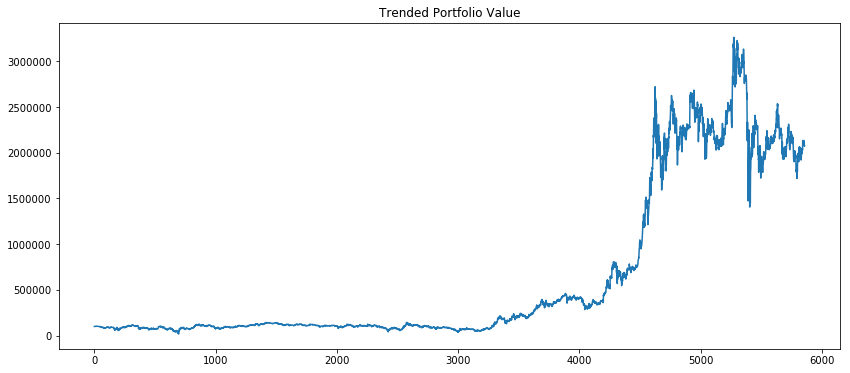

In [13]:
performance_summary(performance_30min_fee)

# 1 Hour Periods

## Load & Process

In [14]:
# load data
df = pd.read_csv('portfolio_export_all_features_1H_2018-01-03.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop('date', 1)

scaled_prices = process_data(df, currency_pairs)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
# print shape, head, tail
print('Shape:', scaled_prices.shape)
scaled_prices.iloc[np.r_[0:2, -2:0]]

Shape: (3336, 8)


,usdtbtc_close,usdtbch_close,usdteth_close,usdtxmr_close,usdtdash_close,usdtsan_close,usdtneo_close,usdtiota_close
date,,,,,,,,
2017-08-15 00:00:00,0.089068,0.013154,0.153302,0.018656,0.016462,0.027133,0.141395,0.133580
2017-08-15 01:00:00,0.090529,0.013504,0.148100,0.018086,0.014051,0.025456,0.141395,0.136104
2017-12-31 22:00:00,0.654223,0.583183,0.827182,0.677738,0.628365,0.804390,0.908667,0.620418
2017-12-31 23:00:00,0.650887,0.578471,0.828778,0.679127,0.622525,0.816082,0.908158,0.618834


## Trended

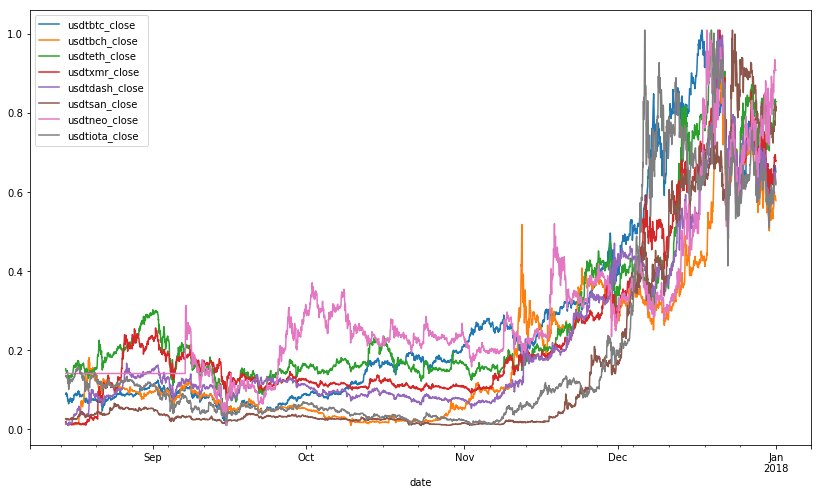

In [16]:
scaled_prices.plot(figsize = (14, 8));

# Benchmarks

## No Fee

In [90]:
train_window_len = int(len(scaled_prices[scaled_prices.index < datetime(2017, 9, 1)].index))

performance_1hr = trading_simulation(scaled_prices,
                                     init_capital = init_capital,
                                     train_window = train_window_len,
                                     progress_print = 10
                                    )

In [91]:
# backup the results
performance_1hr = [100000, 101030.44890713315, 101334.18942333103, 101413.18105801412, 101858.94609469488, 100475.30411237405, 101973.34270893481, 100748.04679985094, 101937.99186387936, 103075.84370797247, 102642.65904317419, 102679.50570475838, 102020.66123382108, 101770.86663336086, 100513.3051495846, 100771.76458631648, 101471.12320888779, 101378.56375126327, 100630.07393705755, 100139.83125676087, 99830.078707151304, 98760.440281997347, 98100.3007403558, 98885.839462479809, 98683.502564983442, 96259.352276684251, 94584.108429212487, 94447.832619462773, 91586.805717676631, 94460.156145331348, 88396.412205138738, 93754.30209086473, 92740.144107301399, 91602.146659574704, 89853.790190411906, 90804.657413102017, 90111.072423621663, 84025.802057927096, 87068.133810341431, 85843.085714461966, 86396.934588818593, 84457.169925538386, 85698.941782902461, 83908.560733909559, 83675.34373892103, 80944.814358811156, 82305.447259592605, 82275.068439292765, 86313.063589554848, 89701.93070406522, 91056.919039021508, 90802.872090967416, 90240.387527206403, 95406.345946717338, 96940.320151992186, 95652.163022516339, 94653.438419602346, 95548.104963869569, 91162.709876646462, 90269.113054307658, 88281.190914729727, 89736.843686931883, 84031.086667177806, 82323.142985067316, 86169.193648342916, 89048.397137001302, 90044.784233574566, 91534.90791327841, 92575.447427186882, 91271.034994649614, 93688.742275350727, 93317.4432858277, 93405.925143899367, 91627.389030798513, 91171.999294052424, 90079.812639933371, 89545.667073626406, 90697.930726011415, 89418.815685786292, 89469.93636969896, 84158.118304398115, 79297.405753305327, 81317.842073651787, 76909.556064177377, 63504.233835062769, 66338.761197903223, 74700.038576675084, 69939.653475063446, 69462.838499625534, 70704.570209818514, 70826.538252286409, 80176.143283897676, 86051.436698814738, 84693.399633098394, 85596.020863668818, 78195.08509933154, 72528.707661078501, 68607.062600760546, 56572.907228014592, 69500.080542238313, 61453.152030784287, 67739.026492989738, 59465.371237869811, 70920.536702575395, 82827.605098308166, 73996.966260104527, 75857.202299495446, 78166.078700403916, 77303.021408020082, 78266.502001451765, 82157.050364282608, 82817.306534540869, 80643.653151245613, 84056.048126479349, 90467.799752383842, 91400.929158822168, 92337.353116154016, 91236.829273130497, 89613.408925037569, 92595.548717036174, 88916.407161173935, 92503.336464467691, 95699.037244766296, 92157.015604393382, 92542.162358500267, 87194.381965072957, 88468.589449254971, 89728.555566179683, 93172.488189952259, 96664.265485943659, 94359.928043542663, 98708.092877489951, 101682.48783639603, 101706.45849545993, 100449.34517451341, 100003.66550448354, 102268.6874889132, 105033.42415880936, 110262.44729601878, 109345.02767640888, 111969.57144058761, 107919.65127433436, 109911.12121585864, 112090.74842146889, 111570.3796978513, 106357.17214534708, 102134.85813444562, 103899.51307288995, 106372.23284992155, 106352.43811756543, 107956.34958746463, 104643.37250950662, 103221.39287176522, 105602.04425638451, 108963.52174766766, 118485.0619768913, 123703.04219217767, 125392.76408199074, 124120.77614116392, 122816.62789074065, 123041.11849700926, 121116.85531505191, 119452.82450951276, 112427.42126348146, 112523.35763714282, 114063.88669756457, 111946.64327465567, 112714.11975589335, 115014.92686110735, 112730.32915251714, 107877.95321517019, 108965.15917779561, 107358.22321249776, 114237.6660395365, 110933.60715516147, 112459.85139753323, 111854.21734198809, 117821.09868609514, 115360.32056646718, 111933.75882612802, 110430.05192820428, 109482.35851028995, 88946.591512008541, 86295.11366074442, 91412.099083317007, 81841.286921235718, 80881.241870476893, 82462.60778534571, 73864.082530365995, 82871.080984608474, 83969.847526864411, 89399.090021441429, 86818.615319758261, 83581.357165484413, 83445.516297856011, 85979.627740846568, 87918.152944547124, 86388.639877539055, 94121.061135290103, 96283.252627361522, 93749.53635805464, 90890.702673946143, 94186.047147669742, 92814.738998773639, 96448.060653752589, 95717.396014268801, 92782.807198086055, 90347.27245248809, 90284.961147679322, 88415.547617926422, 86083.597503600729, 82974.755217356433, 87108.2147568129, 87202.675995447644, 88235.537705890776, 92698.333604134765, 92177.565493927526, 92440.278474428575, 89727.908252037625, 86371.078621402965, 86345.892029662791, 79910.44038228807, 78251.918252699325, 71035.403691759449, 71254.285057244459, 72232.849008022982, 67982.548839941068, 69069.648580735462, 71793.88687054858, 72680.855187431065, 76523.939564285189, 79058.139709875089, 74849.885758298158, 81937.318221037611, 84296.286936897144, 85899.49606373116, 84971.16697415791, 77442.474365137081, 76682.166477267601, 79692.29677317552, 78130.302954673811, 79051.963191376533, 85714.964492967454, 82812.124370880381, 87055.34359635353, 78213.881707881781, 74083.756211217755, 75868.545922411882, 77005.23429194912, 74604.891120785906, 77425.846253996831, 80208.653953542904, 76333.760296734283, 78585.957148083195, 81951.907031165989, 83279.831957998191, 82429.428532159858, 80001.178935129894, 79694.920417188434, 81149.893791340335, 79822.101586086908, 81114.390504632262, 80444.890088869142, 83111.695554110673, 92650.656717636128, 104939.79809777273, 106609.55858222699, 105992.50525307913, 109132.24702952485, 109240.09696255118, 109308.06797567764, 111016.51355691935, 110644.17379872044, 102604.8043268102, 103402.26032918502, 108808.04550752946, 109288.16219876645, 106437.13139313908, 103410.09963540128, 104196.84829205314, 100057.71649985191, 103530.74176482127, 99496.118126023328, 92290.908075643994, 97549.423697936552, 96220.847560549897, 100256.11865780698, 97887.875751562038, 98694.18014403095, 94922.435581665894, 90135.249243958271, 83398.161160079835, 76661.43080147091, 83002.279775155213, 80382.441866394685, 84563.726704041954, 77903.093408794899, 76833.200851381902, 76418.645847546679, 70479.296073063466, 68979.494837441656, 73115.39893363358, 72538.244752323269, 69288.544016558531, 74041.800007436861, 83751.362001718226, 80402.168731356564, 82132.634401856281, 78802.201896472572, 85269.902776528907, 84994.869171999511, 91471.844005639141, 85378.284489166414, 86353.352273315802, 86329.833395215406, 84116.936296094238, 78895.248498759698, 79213.705273898144, 79846.802696397237, 81993.531774152798, 85382.902061372035, 81788.69314445433, 77075.245802971593, 74700.94682586292, 63776.7686860463, 52380.366693939708, 60127.652250619016, 63222.584935382016, 59592.142798277244, 54567.244761204005, 45702.499394195329, 55743.769344503293, 52243.819538000425, 54724.218812588093, 47833.238505881076, 48763.953081869578, 42252.305701678699, 51936.345307689749, 57470.02037784268, 55497.821539341363, 55760.803722549477, 51422.51641062316, 52407.515021875239, 35407.469054249348, 35374.628007873594, 35733.445959142344, 26136.614545538156, 24251.968471732405, 19419.843807405989, 58013.359500232364, 64428.259166415221, 89271.954942995886, 90466.383871928061, 82156.448872353358, 84738.16611639128, 85426.254027271701, 91557.645009083091, 95529.777779410826, 102921.77206361663, 97083.131340802647, 92575.55629457676, 94427.833969570376, 101239.59794311966, 96304.416591946763, 98441.67892023077, 99227.817809113942, 103694.08473569989, 99409.720654900113, 102531.63677874127, 103532.33482035587, 90522.136013788491, 79826.158138872503, 89917.949390952563, 80341.283704684203, 84596.659937185832, 81874.458428096113, 82768.396385587024, 85723.715567477193, 88895.056119667366, 95940.086554207257, 93525.722904269613, 92228.919502452525, 92635.722276046028, 93562.65086999553, 92008.683892493631, 89679.141587648046, 88053.257813824632, 89073.203606350216, 89102.105469401038, 86219.189692057684, 82287.417629616742, 80760.196001476317, 79677.61302221111, 80117.47453030583, 85018.554889834471, 83267.294475368457, 82111.458062841208, 82889.922376283459, 90977.317054803614, 92529.33685906732, 93321.921297532594, 97577.556480771222, 100546.96517860822, 98236.218953154574, 99079.845602675457, 97823.345464608021, 96515.111110295853, 97216.400441628793, 95371.333590122376, 103903.13802489085, 111638.6945851029, 118612.52443383556, 114876.82079670505, 116830.110960506, 126014.48921241396, 131071.99132194815, 130763.02398311639, 133981.61231790466, 130684.10166741203, 137713.16653954037, 134380.86546957961, 145560.97568694057, 144059.48444558468, 135561.9295518724, 137525.93989903131, 134910.52683407185, 136323.17629645945, 140808.86088038288, 139327.06932240041, 137896.80323364126, 145458.2667094708, 144255.61564060519, 147207.08168532921, 139879.1149499077, 135839.8924833308, 136649.64906734304, 135145.2293173004, 128091.18191064085, 127580.99794663626, 133220.77996370825, 127782.64588105236, 130641.40355775564, 132051.6629962789, 138654.72167192475, 135346.7218967154, 137682.08428188827, 130486.07582770188, 132661.1197430699, 137550.02144767478, 137076.38755052886, 134902.99841276932, 134307.7476792885, 127780.77271362061, 126634.65257814847, 126911.98900487859, 127080.17871753586, 125813.58480278449, 127239.08730633603, 124815.92706730723, 125169.80763991782, 124309.89645227694, 121258.64113357622, 125578.09971131131, 132074.1417428696, 131783.960011811, 129208.23693757833, 128029.92799024397, 127374.99036462881, 126973.82353977072, 128704.66346710571, 135769.3007340965, 138024.09272172005, 136554.79917784265, 139327.43933050439, 137432.86921921396, 136863.64129257909, 133587.93642423497, 134966.44952904165, 133108.60513098293, 132951.01943280929, 127295.53573863473, 125036.45113066459, 120598.19832767671, 122757.4876721313, 117779.93346650456, 120809.43984583711, 121167.32354859213, 120554.27890324604, 122929.9987801867, 120468.27201209811, 120355.74561278868, 123494.58070080521, 119305.68910844407, 120276.8666613845, 120598.10537831608, 112079.40398013323, 106918.84205287378, 100128.48756796416, 96277.432746731152, 96837.723814802244, 92277.553749773186, 98055.210965269041, 98255.101065431314, 95851.540895865473, 94921.662459700558, 99420.634373645575, 98836.15941405113, 96288.452635312147, 101571.53166469818, 105529.2041678619, 105318.03985401904, 107783.89265960733, 97995.265757364046, 98319.399448769778, 90279.478711748234, 91074.997252847563, 87681.94169780286, 93828.783187267662, 89947.288206003344, 94124.152749884583, 88218.116656359285, 91804.274778170773, 91749.319903226395, 92863.957758333388, 95692.268900627008, 96750.133647334907, 99632.847054123311, 98017.209216421295, 98130.532311387302, 97523.368087012146, 95238.939907957058, 101426.52983306872, 99564.685469472111, 107403.86048624772, 106180.43449016125, 107266.12644704066, 107888.79130577594, 111350.50135933465, 111840.12597668037, 119471.06307068389, 121629.36303397009, 118562.31568820262, 119161.27086570488, 116578.29583399295, 112242.05828423693, 117928.6067182862, 115170.24430676682, 115142.72401746773, 117551.57135681494, 118294.18075759185, 114621.56651719495, 116402.838152868, 119334.11216416644, 115925.45307092951, 119803.61327343434, 119809.7211906937, 120199.52536169304, 108424.2443745604, 110151.59599745265, 104393.88751177542, 106233.47154589088, 107836.13362889644, 107654.21946039434, 106890.27241621989, 108058.8143378777, 109827.54965634651, 114330.16642302817, 109933.79753077666, 111049.84067391783, 110346.58134796441, 109816.01402032282, 106008.30372552859, 109623.2586849988, 107392.49572803538, 111251.27802155798, 113254.59120666677, 108794.9650279872, 111194.14917221757, 111789.05751117427, 119450.16561428903, 119000.51804164544, 123351.55104275362, 120314.70224455185, 119793.29238399286, 122148.21912374358, 119957.75199950926, 119677.45486892978, 121746.85765017886, 118158.46424427934, 119491.80869178541, 117828.82413534331, 132740.12313865902, 132882.08934755423, 130679.99759678825, 130032.01189533426, 130458.18245829846, 133546.0276515274, 134715.46223824917, 136790.11213370549, 131902.68608493172, 132719.84104474084, 134080.24619557135, 133332.87409054267, 131736.36941812705, 127996.583153083, 129089.47109149181, 122977.61631275795, 126591.71168182025, 128861.93176592428, 130681.86113596319, 130786.62276664154, 131848.55885876511, 133374.17246740032, 130512.7834016284, 129029.87511146728, 127038.39971541928, 126953.7026516402, 124327.69576751188, 124383.86754492756, 125193.25503224197, 124808.61863602545, 123256.35141180143, 123744.41964264514, 121048.896118531, 120005.82562638482, 122758.18475509592, 121600.70769370996, 122081.25755024786, 124648.95814692686, 121684.67947532472, 125449.37456751862, 123791.6684739757, 123038.51768946432, 124564.05977675467, 125488.1874935939, 135513.11789985118, 136098.97249867735, 137432.07478378003, 134217.3683405609, 137327.97209409976, 135480.33314511989, 135564.64435032546, 137105.01278018372, 145045.27893388137, 146423.97620195636, 143005.31416624459, 146866.37373138167, 145475.53439486501, 146286.10639837279, 143899.0971266155, 143782.749332006, 145502.20055321269, 144192.43182207621, 147837.3223476219, 145305.78318977338, 145159.85272820908, 144506.64588605519, 145056.76045619836, 145907.55562163302, 139311.76610352745, 139992.95160031685, 139851.35641408476, 139458.14304759965, 138537.06196164445, 152954.64547242245, 154119.58070523932, 157679.52821246517, 152815.02317090743, 152283.91662671548, 154753.81629141647, 157492.70215550606, 154764.96432523336, 157013.96322216309, 157781.13934480867, 155132.64204712171, 139906.20107026928, 136922.8618185005, 138541.39430303365, 135779.60984648779, 142871.9587840403, 145116.43202196542, 145367.42887048129, 140684.31674620701, 148129.76687962117, 154737.29808475546, 157975.76962159463, 152017.07134680514, 153942.28188608802, 156083.75330851352, 156242.65968429201, 152294.34432707491, 149982.67924466525, 150871.7659579599, 152588.7218369926, 152871.41754472867, 150884.35788919611, 151530.04583797819, 152718.61764678801, 158262.18963609828, 158878.27547240048, 155029.28533401951, 156343.37450483223, 159011.87844390766, 164647.61931016989, 167099.52255816577, 163254.84644869907, 169350.08507706836, 172468.24996336331, 172361.44521827859, 171009.86166945868, 170601.83319161105, 173846.71056655084, 173008.25331517437, 168585.94270369838, 169674.03699305831, 171133.66775635019, 171649.84594541293, 173345.73273123318, 169673.43749099268, 170847.52380659332, 171623.30452019739, 172418.48685876798, 170180.9447825313, 165179.57628113346, 166956.51174496533, 167912.03572613277, 168921.73164333284, 169784.00362024174, 169698.04683812027, 166809.15869198903, 165383.52500832052, 165869.52902862651, 164311.60183859829, 160221.24864573701, 160961.64471451321, 162526.88513492834, 164908.08302074621, 164414.70252358535, 163607.32775820376, 164408.64200173615, 163631.26182089653, 166445.38955836245, 169030.03573492722, 171433.55868068809, 170853.37283113896, 173115.04845103732, 173229.38829369238, 169886.47971284308, 170636.39051513418, 169732.50954216797, 173455.93628037712, 172834.04450380686, 169697.04635185894, 170618.19209209073, 171218.06175566942, 170475.19493046249, 162209.80273862983, 157846.94004970457, 160318.89431903599, 164081.66856752441, 159993.80298975221, 161364.10545086901, 159042.86421042876, 155875.13328654133, 158891.07061393821, 158874.07998137653, 155057.1432940549, 156313.81591344322, 160021.11748696075, 158920.87035031122, 159558.23846601511, 161340.71457691074, 162555.37587920955, 161955.59054207531, 147509.56258334735, 145325.48902199019, 145876.52234949614, 149149.90788440689, 144307.39324228588, 145865.52373327565, 145226.13142325403, 139271.70726025559, 136076.83663983503, 141416.7256067461, 144725.92948014472, 141169.09490835114, 145363.92834128812, 147620.13267757575, 144185.21985444298, 148399.50738170944, 145579.87737794197, 147909.86772910412, 151578.97596223967, 152951.69006532466, 151468.50064425822, 148261.45040152938, 150164.08088185522, 151411.75634433696, 153544.1310748324, 152824.58595526899, 152667.89977422656, 146666.78169116797, 141438.27605230294, 140213.7596136576, 141937.75916759425, 136330.63884781161, 141935.59108943818, 138827.34891536966, 141864.15481747448, 142903.68723026145, 145087.57626517868, 143593.48973320526, 143906.09718294683, 141121.32313542071, 144757.51881999342, 145317.25839232546, 144708.48907688176, 144853.09451239597, 144184.27086429315, 143409.32769088348, 138233.7578293226, 136432.19721965695, 134093.28686897835, 137207.266247858, 137832.88702339213, 138626.41506527949, 140598.56358769571, 145116.78105559055, 143130.47201320043, 150636.93418008368, 151036.26365972063, 150038.15667162137, 152575.62767955771, 154287.77647871128, 150295.94364679779, 153686.65475079426, 154651.26605403316, 151203.98267340998, 150553.90576265554, 152886.85274386889, 148253.3134282938, 149340.69906599593, 152282.40285133451, 149497.41501115437, 152249.38781705545, 151423.426731546, 155347.13525677554, 155874.53072296496, 157548.47364351619, 156426.60337595083, 158562.37251989264, 155463.25738399697, 155286.98109673633, 156877.85584804963, 150900.40299891832, 152964.38885961706, 150228.64606208066, 149357.93622262421, 144136.30828151305, 143822.66630308569, 146379.63745834352, 143979.6482646279, 143244.00728775904, 139082.42869921695, 141137.58920618292, 142858.95220551174, 148785.92135763765, 146590.4688870855, 145595.12944384495, 144185.33227454312, 145526.52244866095, 136392.68514377438, 139834.66887946043, 142092.43364959373, 140964.91714114329, 138358.05718995054, 139392.75466249551, 138690.31324790744, 138741.6460257073, 141990.14942317802, 144222.81323633649, 142097.5784687266, 143915.17642254615, 143522.40702961924, 142998.59280180282, 142561.65015486963, 141295.52873447747, 157406.02090431665, 155193.77776649114, 154580.06755450694, 155324.94151416782, 155492.72318890796, 154984.61176729057, 153721.55269552895, 154913.81489511882, 154172.93188296957, 155438.09055003195, 155445.83223816971, 153577.533961493, 155010.70990292769, 152027.04614529421, 151454.95854319367, 154722.47612218646, 154218.07517642522, 151868.5852078115, 150544.55219750511, 152618.65041188482, 151224.60126680596, 152967.27991652692, 149625.67290147071, 146277.32029769837, 146198.34391645453, 146082.87650526961, 141825.52925691273, 145322.29895474031, 142822.1716624703, 141298.1042746646, 140854.6613305776, 146024.74729440169, 143646.8527972252, 140493.18586861392, 140030.51662870875, 141102.03409539786, 142068.15231096116, 141860.03276465883, 138595.93692439268, 133995.21332769064, 126070.79904986441, 130924.52049433223, 127958.33678973456, 126609.50167032177, 122942.16834593136, 125900.18927958416, 127154.26391812009, 131217.3371284306, 132836.05192878336, 134474.99104298593, 131712.33064894713, 133010.17998771736, 132747.75423416088, 130032.83088060746, 129772.33304624785, 130348.89121085606, 129733.7990274683, 129609.26175593455, 133366.67278211997, 134151.24819955241, 138543.82198352276, 140159.10974847409, 144251.64758760942, 142923.2127967492, 139690.09986816897, 139520.49529120646, 145203.88395481731, 136995.6372910933, 140349.00811859872, 143101.41240915353, 140694.92107356031, 141121.64231034945, 139503.10362432062, 138710.610040603, 138475.15937426768, 139779.94859532657, 140914.24448535312, 138280.65097700374, 138578.294939771, 139467.87148045871, 139203.45140570524, 139738.7711129646, 139574.14829251182, 136222.51879905333, 136676.97753691027, 135999.94599574825, 136907.97089541273, 135000.52086317097, 136943.19177256495, 141120.9677726244, 142926.81818540188, 142315.04766119731, 143537.76919606116, 144112.82968504919, 143223.10067980879, 141817.17130848809, 142029.78106518733, 143041.0897767531, 143270.56876082771, 144799.42517259059, 146530.89345087437, 145765.37313845876, 145605.97408271575, 144396.95701851591, 140646.64293237106, 135739.71446821984, 137746.67162958722, 139362.46101296783, 141457.70967434417, 138007.46427300203, 139699.33806588582, 139721.37425154939, 134845.20477822327, 135928.25352018693, 131129.24692492295, 134660.09109921323, 130107.50610285616, 123593.26315008389, 105843.93260181035, 123364.62785239807, 126748.89433707068, 114986.37013541369, 117684.78793888885, 126218.88692258127, 116494.46745565186, 125306.34313365602, 120698.16301535699, 125933.57151410646, 136263.44712911732, 132669.71744551603, 127552.99977133967, 129296.15520349365, 133863.68979831951, 128579.32236871246, 132362.80016209721, 126964.8455799262, 125507.04450191335, 131216.87095110561, 127128.93330638454, 128822.55351118793, 129359.6819499913, 128413.35900551408, 126417.09643250328, 138968.71970328235, 141369.15059010033, 141223.4222619285, 139157.70967845488, 142930.39737939753, 136541.36002724001, 140194.20840299563, 142027.3142999858, 142025.36988030642, 143808.56736754905, 156185.98523293016, 161400.38568995902, 167045.68473583239, 159970.3185351658, 156373.78900038224, 149950.6622546587, 147808.18161866991, 150116.01685090625, 160421.25961852196, 159679.1397656753, 161473.70208194741, 158883.53874362312, 159119.21787117503, 153069.84997045394, 159316.44695854088, 162736.42215258389, 155275.1197751647, 155066.19488683552, 154198.38842050169, 150901.6989827808, 146896.10203263193, 144571.29484193973, 147853.08829069274, 148445.17699454114, 148971.81385766139, 142621.37495016647, 140131.52834900087, 129430.71381727381, 127727.37508829536, 130170.40676025415, 134014.0835169545, 135095.64634763455, 135566.75815403575, 130809.860543107, 129919.8599774802, 131372.73471330115, 129899.23215788024, 133963.67105849134, 135718.84926546784, 144013.47067454789, 141286.71022578402, 144138.82023031235, 143702.91131933697, 142525.36104547378, 136947.86316818625, 133459.65153827073, 139617.73813061748, 136698.77933221986, 137368.7821130791, 137768.7041569734, 146577.82312924729, 144807.98649201193, 150220.42204208532, 154876.12877130666, 151400.8409211089, 154407.57677017679, 155116.75384310755, 146891.99255198427, 149189.03002163747, 147200.19572794705, 149868.15289750422, 144590.67538049209, 146470.16484862828, 148705.72008751964, 149249.45021619642, 149485.03857155651, 139927.36057415808, 143218.11688200763, 143679.47805703909, 144568.11867293192, 142399.2273569181, 146230.73381182697, 147861.2166312651, 147960.08379420594, 145465.55600438884, 144222.08101489767, 141571.44542460205, 138869.23246297482, 140713.44232741997, 138593.50405007464, 139971.31738905481, 138581.42928068884, 139291.19294762329, 139632.13763328246, 141513.22458512447, 136514.60120031604, 138477.28555175257, 152574.38202101752, 157085.40483601193, 150764.32438754375, 142639.42313060968, 146385.05394071556, 150645.34510857012, 152190.61155638262, 155449.43162990111, 142534.82170938712, 146567.07578876009, 144916.97430855353, 145750.4143889143, 148199.39047190989, 148101.45788716423, 146188.14547945355, 132085.96676832781, 128524.73709858654, 139749.4203901123, 134212.74185463361, 134373.91917707885, 137065.55559296603, 137087.98436570013, 140982.2200413963, 143498.16587342063, 146776.45097860222, 148925.04890998584, 145690.55374147664, 150669.60340595696, 149353.37921617317, 150463.28774008731, 150030.26406432156, 149798.89841158179, 149151.71505904733, 150336.82559860763, 148867.66580164456, 145998.86039622783, 137824.42995162369, 137396.02301770163, 140719.35095319757, 137454.56220447499, 130610.16637908756, 129996.47597699627, 132503.05565019423, 131436.24068130608, 130765.03761711382, 133617.64151688875, 137339.85797126879, 134449.28468135843, 137022.03995298911, 134833.20464530145, 117954.09107019045, 124438.10350166104, 127673.29861458304, 129127.95705890632, 130248.80633316035, 121081.93234077544, 124502.85398921836, 121683.4487022899, 123475.40646561008, 123653.04452149887, 125081.59408891134, 120344.25626770643, 120500.53143277409, 121489.1736166561, 125455.77054554923, 115988.60669761854, 114479.79240677791, 112257.49677426748, 118421.7314082806, 111971.74063943415, 109672.51357349473, 110105.25757268224, 108557.14836995589, 113400.74783406346, 111366.45351860959, 107895.15539099171, 104922.60791085965, 104782.30903633256, 89697.856955158757, 95086.871108230538, 92534.797494921237, 87504.010145654989, 84745.264235976152, 85792.318632051931, 62890.572808099372, 71882.396383943516, 81036.997937081498, 84171.338956444539, 78670.798607516161, 97440.848442286544, 97060.597767517145, 95772.602069667875, 98600.510262804237, 91527.251195024393, 93522.956606647218, 94134.193818782485, 103002.46663883462, 108435.78422508512, 107180.90460116277, 109432.40858365603, 118232.67473079197, 114832.05458041794, 109870.52111176675, 103308.82722391326, 101946.10890387066, 103028.9045310424, 107306.15953944577, 114341.02942704418, 113720.48086149601, 121457.9326933953, 116113.63240294112, 119936.75336325551, 111941.70310057528, 107512.00513918878, 105205.43346253925, 106177.20432758643, 112799.85264286045, 114514.24037732006, 106633.31861314649, 105706.85092879954, 103530.11447042975, 103826.10819609003, 108082.38332009391, 101038.0163384965, 95993.16406328656, 96762.890424089303, 93158.229542978428, 95502.200685137504, 95789.419656619473, 94586.146290629171, 90598.228299672279, 90968.112233243883, 96458.226646678464, 82162.77819449862, 81758.768916215282, 83394.30378171982, 85435.690445281522, 85248.035530058172, 88773.76320914914, 92157.864146101405, 90368.119348454871, 94860.309836076645, 96327.605305907942, 104475.18536558485, 105932.34912837748, 107270.38172642516, 116089.92505842788, 136120.85577335465, 132182.22996866089, 131141.1959647006, 136661.40210926477, 142608.18438513015, 135306.44007945203, 148354.18817590718, 145296.72030308968, 147705.10122937639, 147439.1321344584, 149651.13157978945, 162805.7838763945, 179648.4823636238, 188984.74172363977, 182794.36501929312, 169619.2414995447, 175431.40782361175, 177101.36162366113, 177188.85148789678, 170628.23271985303, 160699.08662952439, 160472.86120084114, 159124.02596805268, 161173.89691759809, 150411.60158243508, 146532.4066800056, 172295.29991302223, 163203.8902997073, 158481.87299475033, 161340.43106054992, 160378.74894677527, 160613.19191314926, 151028.44891718598, 144669.26653868292, 150783.84808587516, 150238.722391307, 146175.39632092288, 143991.0904725228, 140289.69438512874, 144691.51339620043, 148162.8466648992, 145523.20354525227, 155415.91482499041, 152931.5889917661, 155558.99339119691, 157813.01461350516, 151660.17942590523, 155636.1470167106, 156179.31477965915, 154949.29405158642, 158202.12649289114, 154887.77811710921, 154834.6798950113, 154470.65892344128, 153987.7562775804, 158506.99697553279, 157934.80551485674, 157445.82971946945, 160701.08788241944, 146794.220726139, 149013.16971500812, 145872.49467646002, 142882.8690442665, 148968.13882435221, 142557.61006482609, 131644.05313583431, 131890.69944035646, 138205.41990359436, 137661.06499052965, 138467.43100747987, 132518.73493086963, 135908.45192511409, 135104.90862654173, 132670.64641570108, 128419.23531879185, 127803.19700713613, 117468.74036391031, 124609.01143065069, 135115.31239763665, 137879.36986093814, 132095.06071963575, 127872.49585994252, 128183.66571375754, 133459.82423785553, 141165.17957424035, 140377.22970522643, 140824.76360417946, 146186.74988499493, 142424.92054372129, 144344.46109166095, 145385.73874558017, 143014.99956903333, 142352.52202250139, 139671.52078479476, 140650.53618224943, 137086.60390524671, 138202.3082421592, 134166.17374542201, 133155.17496928884, 132567.28725433766, 134978.95760415672, 139707.90773139714, 141944.64921725783, 139170.16924484592, 136474.27986098555, 136950.44141629347, 131069.54409842631, 130727.46799754511, 121865.93886901178, 121757.6184562445, 124735.61441544593, 125123.75662117991, 120223.35095789787, 122008.12392682338, 127759.98067599608, 124162.087659122, 123277.61837929617, 119010.31437723147, 119218.42494157673, 117855.12315315091, 117036.87482811499, 120857.43503917282, 125378.12277974235, 127006.69638988665, 128011.10428342086, 129392.75903022767, 130737.98345706417, 127800.07173002796, 123239.61930301142, 124580.63279659078, 119655.2441841347, 117342.40587207886, 123702.55726611818, 117675.9596680735, 108597.35812393363, 108949.74079322419, 116734.50361729199, 120865.69277955823, 130522.98440020204, 123831.85725691561, 122199.83513573305, 129785.67209155207, 129504.61957420214, 126047.87258376766, 129181.19965807156, 127004.57199248638, 125213.90177514679, 123483.48853047256, 125670.51486465793, 121942.74446769504, 125840.52093660986, 125694.73508299666, 124182.67558428855, 122209.41738658659, 117160.78412508429, 119697.42962076869, 123954.79221136658, 121529.79817449611, 121891.51284989367, 121751.84950904838, 123635.10471365748, 126332.09325527416, 125511.41812318625, 127534.19674058291, 135286.26830605714, 134972.84353678161, 133620.13772159046, 129160.70425508698, 131984.24825449058, 126815.96359794328, 128914.46146913592, 130371.82465749295, 127959.87209999033, 124635.48866320345, 122838.9050912525, 125405.83423037246, 128887.74141699991, 129779.93511332045, 133053.34796053445, 125210.43024614878, 126730.21094974059, 122230.09583535994, 122991.96789487253, 121781.75097487195, 128268.60472373175, 126773.56011349535, 124515.87721704118, 119531.23116645133, 120985.24782177995, 120942.88165221554, 120049.76077794691, 116066.26830483554, 115348.63114121545, 116313.10457369857, 114066.06319103584, 113191.66478680281, 113858.24141204247, 114123.97248477518, 112922.84954160789, 105931.22174243652, 111182.87460615893, 106913.23980404773, 107779.53424569521, 105657.28744544153, 102436.7572539196, 105362.16386609065, 106180.19220724149, 101955.23029319661, 94186.761612780654, 95711.684466056729, 92670.951172251283, 104384.93605947847, 103416.13900864964, 100686.36110881422, 94747.853278328184, 93484.579119005939, 86424.829311773268, 78103.805046861977, 82735.671686039364, 79115.925136141814, 77965.244760548754, 80673.505542693703, 76225.93744991094, 77405.09772743503, 62103.451117608733, 57038.478036495355, 79943.218762938399, 66522.252616673592, 67654.531891402672, 80513.226061493304, 81934.73098492343, 84753.751963637769, 94713.993605432232, 113945.85527115714, 101014.98061256924, 98865.774598433258, 104026.73127398507, 93782.402897535983, 97682.638765550961, 95373.214271975317, 98717.950875734154, 102969.3667507005, 96935.919553194268, 107952.42262494263, 107937.64586350968, 109732.5026582117, 111028.90880802175, 105063.02737191629, 101902.7546792386, 101979.34859585974, 103062.94197311948, 101283.21489785328, 97691.189825008551, 102258.41937536743, 107476.62389317685, 106477.6660451229, 103064.54526086056, 100795.89996560052, 105490.37075956987, 105915.23042803169, 119062.27537392071, 119076.35610026578, 127700.69022584744, 117713.69718412159, 105762.87572177497, 107683.13794782331, 104995.47779226479, 110093.2380046863, 111625.72166256042, 109341.85840383876, 109842.23676723459, 109766.49588695318, 106711.09126614682, 109460.73444302041, 105823.69149381004, 106120.58867563437, 102441.49459436974, 102305.75233306953, 105870.5004551759, 104712.1352158449, 105514.50380022741, 106154.0615650344, 106440.52894347474, 113518.63420777145, 105944.88991512268, 105873.84888943117, 105521.4876900612, 104110.43651117597, 105654.58313205793, 104333.02423995656, 105951.52609893096, 98719.598619175405, 91968.427592597669, 84248.392690377703, 89364.925349187863, 92493.674588660826, 82777.619967290244, 82951.715775560588, 77095.320300772961, 80282.874519997553, 74365.531554540066, 74813.949000747394, 90423.586290793959, 83268.532129971893, 90807.751915938454, 89194.039068362123, 88234.171882101058, 89347.922337166834, 89852.05465882209, 93114.917966682959, 87925.937979897499, 82491.047249974596, 83892.936244514611, 87274.188921078254, 87269.162550078356, 79893.644296686922, 77402.925084368704, 77063.020800049402, 79091.007664843375, 78616.187354507856, 81506.338904194199, 92354.201910628733, 95328.656950039091, 102010.25322496644, 98577.531666764859, 97279.181831278896, 97411.177300542535, 95120.847132515933, 100374.98582128363, 103226.03841309054, 114413.73542809815, 108125.93650816129, 95302.095259662281, 102212.71255835916, 111687.81472756524, 104007.01492482417, 110063.81552018835, 110077.44569418396, 114065.04180245555, 115486.27390018529, 114650.60396040592, 126774.32638873236, 122696.98902579337, 129969.99476250351, 130793.56581533341, 129528.41417315429, 129571.04181550309, 129343.29832855609, 122811.55339670702, 118811.02245357099, 115534.60380114867, 105688.97589447853, 114684.53148675403, 111755.08128842046, 108702.71999556245, 106975.07982800575, 121899.2998857981, 119768.41914130429, 119117.76847449281, 123007.88730612493, 122419.50276834096, 130759.89354981505, 128223.23188236298, 130133.1620632253, 131673.03616203793, 149938.04438219292, 153861.3087075715, 166947.68513931354, 167404.72108559756, 152798.78089544602, 145646.74795277283, 151002.9341972408, 159300.76604479793, 156309.78785585862, 167764.35089902306, 189372.99354412506, 192485.7040905935, 193200.98206907188, 204333.600604573, 219421.53177943829, 205648.23116355142, 196389.36227623085, 204859.12350580556, 206488.46783306409, 202000.78373435466, 213602.56806517518, 224163.85159700856, 223752.4547091203, 234260.97331961343, 272514.82841560047, 267276.65277847659, 260700.82977383872, 272222.52695838409, 288132.45179479156, 280694.27306016401, 268744.38192897313, 269753.66385956743, 287634.72342560126, 292309.5939149019, 295743.7148659653, 305144.86695044371, 290637.97166975914, 295818.45878194971, 284987.63774749381, 262679.79962808039, 276249.58034846705, 258543.96192773466, 260766.37910156613, 273679.89926544763, 261265.27861727274, 265749.54874788068, 266204.39924503106, 264224.56010824902, 257689.95079515019, 256612.04727726619, 278281.24528299115, 267125.75112140912, 271846.53618520097, 231859.49975096024, 202348.20207802125, 231401.64106326504, 223147.54157909163, 232903.91896932741, 232157.61098084002, 210485.77189793909, 190323.94799238615, 206615.25058382982, 217965.53886096057, 240967.09969645232, 229925.44987374439, 227599.13384088967, 241384.70871307497, 242020.24013720272, 239071.57434509846, 227629.34825867935, 237533.82052081451, 227110.03318416333, 228655.85416148521, 237590.69073817861, 260912.91533420541, 258199.05802475254, 245140.12012529693, 251019.35318905261, 250583.24605339806, 263864.72828037234, 265304.81750371784, 251106.44976347996, 266125.60935251042, 304963.98698632792, 291937.5621789592, 302264.19417062681, 297258.90470801515, 297793.28988012078, 297425.36389201565, 331454.40827833372, 325615.43686566211, 322788.82381969987, 308120.84383747028, 291110.97932788357, 286872.31683084322, 256982.33792076964, 262996.06376384443, 282143.30395979935, 281339.7118664665, 284286.98822272476, 296601.26685256686, 299036.93528783391, 281148.99438357656, 282406.32042405545, 295760.24556784495, 301507.839351359, 299866.27224859269, 295043.05239181529, 311626.8934633311, 305707.6266562122, 304194.78000044002, 305574.43760215054, 290617.37981525483, 300767.96619413007, 315643.5278683441, 308759.22241370473, 325727.44451427093, 336532.10919323715, 328726.55123821419, 340750.44778422761, 327281.29624004144, 335867.46667543909, 342012.08496543235, 323882.9605898782, 316212.43631008867, 326722.94812968792, 327412.63470706448, 315458.70125441335, 304299.02269096446, 328485.23601432185, 312852.69890293293, 313182.05299398745, 315363.38289199636, 301510.04653723945, 301189.90804065432, 309773.06153756933, 320397.744801917, 306413.04588140105, 308202.02787768783, 304033.21522107162, 301312.162520791, 296520.84501213185, 289636.410135785, 281091.10942394368, 294295.43218609481, 291770.81062254979, 301803.84241374733, 306042.21053814405, 304096.99979027943, 294894.02078727342, 290529.65073541977, 303356.26190783415, 322178.07844183769, 338600.41703946266, 315984.94374386192, 325539.77106678858, 320476.92896209843, 330454.17393446859, 332076.79442750837, 343627.3078783502, 331676.40544130153, 335159.99388815206, 346419.90482147655, 361157.6968972449, 358635.12237807823, 338696.62810762599, 351285.75665607397, 348359.38939012395, 351386.22536233888, 355126.67579048488, 362046.1898260641, 361203.18563384481, 389987.12981189403, 401848.30961299042, 383555.70949535049, 392884.92825181887, 390773.92824237113, 391987.38137683389, 405186.78634995385, 413412.88351114962, 408042.85959077277, 425025.1385064628, 432675.66580658918, 438278.7402393145, 457826.48847207014, 471271.37150174746, 437833.4624425387, 420672.2576950065, 423777.05933123775, 461558.12604498066, 452965.10133651184, 453006.51464032294, 438573.29583868955, 461806.83358449623, 460762.03130252648, 446495.43763032445, 454947.82284940191, 463541.82886937849, 475445.60514137481, 462587.09251725429, 466683.73107297666, 470024.30243182776, 493076.4915444667, 523511.45113102283, 512758.50822966255, 528672.57163332775, 533990.20079977077, 542842.12393892417, 522403.29562270473, 502678.92781145906, 517333.42293094797, 489245.47690444195, 510534.84314723063, 496940.64969796716, 475047.19424323679, 492052.94260586856, 481724.93728398607, 434721.40351314016, 450910.54381261743, 456380.98538740358, 490955.70784309169, 505905.04860806023, 505202.47801764699, 524272.48037917132, 515919.94667251821, 492152.31084349123, 497000.88087667309, 499515.63905319071, 491493.96978236415, 466962.17352069734, 467569.20466049813, 491631.05955363379, 487820.52914809337, 481452.13666315534, 469109.44678383769, 450800.42897859588, 453864.15406215453, 476573.13379549951, 484463.42148227815, 490020.94562102354, 489294.72992627963, 489728.99676547141, 488756.59386046621, 493611.25901687902, 483075.21565588919, 479121.46145651996, 480340.45887812233, 467710.38134343969, 463831.73655525362, 464815.76119238243, 468959.37630008662, 483078.25612740905, 492611.53929725767, 488259.18581000931, 499976.60552221938, 511117.90237449523, 518327.18674429413, 512808.99409405759, 521573.08525884943, 514451.07963307417, 521339.94920396071, 519721.79034931387, 518034.78633264074, 510935.64446903724, 522324.05146217666, 522217.53020054457, 529967.32146098139, 531845.42130829208, 544578.49429404712, 552290.01503365941, 542300.58628705807, 554640.68928031705, 565696.76283345209, 558188.20995165303, 547821.71745044703, 546428.93275385734, 565464.18794169824, 552798.58034764614, 536495.03742632177, 545904.34117226652, 558490.70000529627, 545993.21044587484, 554107.90227306704, 556998.96902403166, 568175.33275885833, 572867.15160341654, 579519.38762935624, 584662.37630262354, 600532.14600475982, 587106.82616480405, 604047.99492301513, 593093.62184426899, 602936.14199260459, 615380.13457556709, 616718.8086737399, 612269.05150222662, 617843.06584932539, 613887.27638526878, 619356.44072438066, 621116.89955633821, 621547.16095134942, 633330.48008918238, 643835.62879672518, 653863.30922083557, 626477.12448859354, 634468.44141012081, 642408.65754917229, 634711.73711728002, 620759.10749082547, 553696.14396175661, 521423.35748539207, 575345.6541856525, 554718.11355951452, 575188.94156518474, 601461.28955485008, 583319.70704671217, 576634.33469308063, 579821.89325940749, 573348.39649945789, 571721.56703046605, 584482.27947060065, 617774.08465092781, 605623.2367866874, 599008.35761436785, 599907.66187676822, 572493.18065362482, 588707.52342847758, 582656.87304048508, 559084.67778963153, 576693.55995402287, 587547.37982474593, 592679.45740511524, 589660.90465584223, 605716.18181440013, 601697.94095408043, 602347.10749270651, 603870.53045613854, 612346.72485751985, 614910.86914610642, 631165.50866040273, 621812.92864620616, 615048.85733891651, 599687.20843770006, 582217.56081766938, 585069.34405822936, 596401.44531907374, 589344.18140371784, 576431.82984084031, 575556.94418628165, 576784.11816963553, 592192.44142973539, 593636.32924385404, 609904.317023376, 603362.56438877457, 604333.09496599319, 587389.55267600948, 603060.54433436366, 587874.15698066005, 587481.4793123987, 607385.45870112651, 604145.6349773386, 605192.64380968921, 602577.66354006971, 608021.29187492863, 608913.54103614751, 617028.69151166431, 612983.0984883107, 614120.96411868767, 612422.47782729729, 611855.72659104632, 610241.09776926204, 602032.99536847707, 568028.17069628311, 584424.09376287286, 593710.09270301042, 575815.61701305024, 570577.96835481108, 525093.78857897164, 515317.39071484911, 514000.64260559989, 529260.98910853022, 518732.17085503234, 524318.67709297931, 450429.86901452357, 462273.51219771919, 502092.27629156248, 502500.66409707919, 505796.44444303156, 501463.4928135926, 483825.10672246892, 488213.75829080393, 484800.43853128736, 498458.92150331638, 494807.95696118276, 473738.25153446052, 477695.57478257269, 495259.00058181572, 516879.06966302876, 523716.38256955805, 539228.45044954959, 537256.03022184502, 560954.31401671877, 521822.70505383058, 488229.04575919267, 506020.61244770727, 500869.73467901774, 510603.1300095272, 517197.78616353747, 548538.7203337414, 533161.94878502609, 522908.24845429615, 542594.0726569331, 540344.36760641902, 547727.55180315219, 577748.78184892726, 596155.09393104783, 586732.57095734379, 617855.87844700087, 617946.87863038271, 597415.49981733097, 579963.51929212105, 604649.33084380813, 588172.18687858188, 585816.27728155477, 575656.47163318493, 581125.06956536754, 574988.59250204801, 589170.02735622833, 583007.22164199315, 578693.61153810541, 573545.5849774098, 551994.65733325249, 559001.26490937942, 539514.68506527098, 544869.25605149835, 544271.22194127087, 560202.33917963679, 568992.70745156193, 549895.14478851738, 552468.61646641849, 547281.0898091303, 556720.47028014029, 570865.89328559663, 560683.24225536711, 562248.75621462159, 548332.71829268255, 562834.88412941911, 591507.88174637919, 590911.39957614045, 609676.14192688337, 595258.49241002812, 599261.28154825536, 600459.76040589542, 599262.16270633193, 603265.69647023757, 602631.83252384933, 607982.5325377048, 618988.31949059432, 612358.63962054485, 582901.79931360879, 695100.64459671534, 690183.45759416278, 703919.17602224404, 700303.13950228202, 710912.73867886933, 733352.16249698633, 720950.42417375848, 723571.98669629742, 720465.64640412538, 733522.67183736688, 746890.74921451823, 797153.46598460746, 820458.77737597376, 795255.71929331799, 828997.58843592182, 890593.82183738647, 894714.77522894321, 891405.68769489345, 890812.52342946397, 885810.66497732641, 869623.18893256597, 830441.37955349719, 855315.51526255929, 815032.77703508246, 814010.36095128802, 849288.53823167016, 807643.07001875422, 790086.48666842771, 935631.21816319018, 944161.65384439449, 965691.31374725827, 942027.09989306796, 948627.70701523207, 957078.99209340871, 944568.14072593511, 1062950.7191902322, 1065514.7433995411, 1120266.4167988533, 1126245.6076682415, 1068015.1288914168, 1120460.2040997823, 1175407.4784285603, 1163212.2830282755, 1091288.5935281597, 1116496.6569017291, 1151021.8015366064, 1160656.179538402, 1153354.5904801027, 1134452.2991184918, 1106319.9861158396, 1167616.7319973072, 1177833.9790810614, 1167096.2856963973, 1114592.2498516699, 1036086.8823995611, 1113975.7253236168, 1097604.0341661915, 847467.12017485313, 899188.48879279965, 1015450.3061388481, 998885.75405886758, 938702.2707800162, 981052.36676774477, 1043397.0531922153, 1017666.4092783368, 1030414.0589251178, 1044694.2007834462, 1002710.3213707393, 954617.38605137309, 993077.83525422891, 1026200.6703698386, 998363.76656837482, 898836.58710712416, 929300.98121905024, 938236.93173802318, 806152.38747258927, 893097.82148459507, 857779.99118120968, 890579.94991078041, 920467.11093555507, 944201.60073990328, 1000639.391737465, 932306.73919913848, 963179.65503926994, 978718.92529140296, 993515.54331905604, 996623.93843127007, 971870.20252381114, 965367.20473839017, 956808.86054773349, 977831.8927453194, 937875.42037712294, 914998.27196206036, 928039.10469839, 970703.30510229419, 1015427.2927526049, 972616.10594745586, 1009286.8433264822, 1047501.0655670163, 1090360.930223594, 1074575.0199393418, 1070046.7134586349, 1076279.0000260808, 1071294.0820580653, 1077688.8242150834, 1071714.3802519508, 1132080.364556415, 1141902.7282521585, 1105633.0354026353, 1105906.0104023321, 1074503.6615101164, 1097049.127706605, 1081168.7375854764, 1044831.0763598903, 1066072.4896676023, 1092830.1388664774, 1082238.0615641228, 1088745.9963063146, 1087087.108717625, 1125961.8234048989, 1102033.1526173775, 1095685.603756459, 1106443.5357051007, 1101659.0422597372, 1097370.3341439306, 1064160.5207759154, 1077283.7087792431, 1087501.7714018889, 1089465.4790941407, 1088008.4987073396, 1086676.0154673278, 1092133.5326570938, 1093128.8631801861, 1116865.5485495036, 1128981.6075803041, 1125134.8592725759, 1121642.4426207249, 1123006.2179633523, 1134848.7004306561, 1122039.8113902982, 1126670.128455417, 1142489.9231442623, 1153777.8117645758, 1206532.324747595, 1214804.6651885042, 1255296.4392577605, 1250640.5532739838, 1343428.0099002374, 1367100.0110445863, 1458648.3939427687, 1491906.5705997676, 1458822.9756777713, 1474783.5192341974, 1458171.6644241989, 1388879.5656079708, 1357979.3850884777, 1402209.0933515369, 1400290.7385746324, 1423669.9283160381, 1463523.4325684169, 1504367.8828705291, 1591403.4374317655, 1701749.8829513635, 1677861.0046252972, 1693824.9461906652, 1817491.2025268429, 1778288.2611425547, 1735907.1467887892, 1649777.1703929314, 1663759.0895365544, 1654537.4456734338, 1760228.1269629349, 1796848.4878951919, 1985624.7226589771, 1992545.6761966478, 2012458.1621686711, 1948702.3955376251, 1938211.7181451758, 1926139.5325713353, 1947017.1694984226, 1894983.6514005722, 1925870.763177501, 1894841.3143089679, 1789814.5904250937, 1739424.2994384959, 1819936.738925708, 1850490.3017996703, 1894277.4896129086, 1952561.7100230358, 1966857.4609831634, 2061903.2872163535, 2287044.2503954209, 2227233.4131544293, 2223683.2155571124, 2161729.0069793859, 2055441.3915586292, 2110799.632221764, 2308867.6398717631, 2299998.8795085833, 2285785.0413681036, 2312363.39376286, 2397239.1372963428, 2398397.2404428357, 2434779.9455080428, 2550035.476961093, 2508454.959257992, 2773594.6091902549, 2939819.2159256064, 2807544.9243340129, 2938343.9870681884, 2826148.6628236137, 2917953.7095847027, 3158325.6046376978, 3313234.1763851424, 3136978.6678476995, 3013000.5357189677, 2945337.1084221341, 2992633.3643404627, 2938612.7889954569, 2918921.9354522163, 2769213.1863664216, 2446899.8939252826, 2749670.5833785278, 2681575.1308256639, 2653547.5362955309, 2549528.6068325955, 2651770.049153734, 2843306.569160094, 2623751.4705475308, 2699756.2170707202, 2557196.3613763922, 2488559.6331105316, 2544874.3492697878, 2659019.1304950281, 2585701.3229519655, 2445449.6454710993, 2241058.3074199781, 2359445.4083233206, 2282668.9054018036, 2309370.5624218979, 2058266.1832028038, 2143795.5779268201, 2226763.5786879612, 2484956.8962806324, 2484797.2521766084, 2341699.255448848, 2174163.9180647964, 2365969.4739555228, 2431454.0566151375, 2470305.7054970851, 2735966.4380703964, 2660586.6592840622, 2681266.8697027396, 2579515.8650953379, 2444082.0858104634, 2538212.4792740131, 2460336.4678265126, 2442020.3196500614, 2434153.7217806587, 2385481.1106680757, 2517524.48781069, 2496123.9758734768, 2635108.4636429106, 2725353.2370381104, 2702942.970681929, 2602896.8976899507, 2651226.6477676644, 2731869.6861879351, 2623086.9312013462, 2771707.3409257149, 2889641.3867727881, 2836574.0218280707, 2907492.1087190025, 2904489.0528201484, 2864409.2470284803, 2913688.7416635645, 3051483.3881253274, 3140848.9942791192, 3087453.1304552746, 3107057.5774855958, 3180048.8498374741, 3286731.4403073499, 3218545.7296211771, 3158644.9533469789, 3196423.1680582464, 3262133.7641227269, 3227746.1802616324, 3179147.3241251674, 2983304.0513039096, 3077068.3339086026, 3071920.4353445992, 3166170.8340499303, 3127985.1641959189, 3133402.6849436024, 3013176.6021416946, 2853638.934929179, 2922690.0731783016, 2977693.0668000388, 2993621.3073308705, 3030908.4128440297, 3047865.1243381561, 3035830.745433826, 2850544.7062403997, 2694408.5419378378, 2639976.0929899709, 2421057.9168579816, 2648810.9339671158, 2675257.9107620623, 2790106.8520485405, 2726754.0034635696, 2654431.5156937838, 2737306.4500894705, 2740516.1911400622, 2727940.8560871594, 2754130.2649075305, 2859198.0109309247, 2832684.93194556, 2872579.7730255108, 2878158.4778699502, 2926438.1624509534, 2866645.1841206383, 2869201.3183668726, 2687329.3351835054, 2610833.9927256778, 2635762.5752678756, 2690134.5911484561, 2805771.5377876223, 2825228.5530612753, 2932558.5592632131, 2893471.8393384279, 2872116.4159520869, 2866268.874146529, 2912718.1669336171, 2903956.3358232239, 2869959.9884677785, 2951353.4033934907, 2920744.4247807343, 2837314.9821766247, 2869306.4893580857, 2887844.2392426371, 2820997.9010730647, 2846856.6157726818, 2890475.7072141329, 2945418.0868846197, 2961492.1443085908, 2976199.1900608381, 2954798.0605969685, 2986743.9812265313, 2962791.765571774, 3048333.382907643, 3042405.1766498699, 3082082.1422872269, 3094648.8772268128, 3081319.9658451979, 3105198.3700938565, 3091517.4107808936, 3186985.0412454829, 3477167.9038638966, 3400886.7264824798, 3489904.7315772343, 3515544.4244665955, 3404284.1629906478, 3438321.1002380606, 3507374.5417408962, 3543449.1610302515, 3565251.1055322895, 3500533.8571224646, 3424911.7099995571, 3629965.7232229318, 3502270.0808881661, 3406025.1474551121, 3563258.4657495748, 3593099.4859327115, 3719720.0088131111, 3648004.3654708071, 3518117.1791207008, 3260352.7765036616, 3333230.2144355951, 3288587.0908455383, 3473124.9276957992, 3442413.7834976371, 3413468.6925873598, 3417368.4108554199, 3495110.7952218745, 3420694.5682963645, 3378850.6969713797, 3505160.513185163, 3554126.6643106313, 3648867.1811413486, 3501596.3453967413, 3581006.5806931583, 3447500.4371825824, 3286872.9679311463, 3408687.008499539, 3212173.6181691703, 3360005.2841275809, 3414929.3424195279, 3435640.899809801, 3520193.664273343, 3635076.7096849103, 3589023.8106028703, 3504399.7238596636, 3679270.95720575, 3582626.1538520576, 3520339.424168475, 3545686.3629913237, 3576174.0365507714, 3534438.2211386226, 3462544.6018755487, 3395726.9750589994, 3472052.9003964812, 3377321.657724834, 3171212.7491255892, 3364227.6057944857, 3340614.3400256089, 3248665.3363625277, 3178681.5991189666, 3199548.8094996614, 2979437.3012486603, 3026726.9888380463, 3131411.2572718291, 3205785.5284395367, 3070951.1035615527, 2872924.5883080503, 2856653.9505184125, 2900526.3171893423, 3131385.7516056327, 3103544.1142470771, 3173546.4424518324, 3229790.2548194239, 3418220.4683146295, 3271601.3473258209, 3205155.226060098, 3222201.8009724356, 3288807.1889477693, 3325801.9304214981, 3279035.0909109758, 3349860.2783907368, 3377096.3880896275, 3312030.3005141523, 3262683.3264463502, 3227352.3335828092, 3294029.2745899516, 3299192.6466486016, 3297112.0705177919, 3335627.8432582351, 3339097.6935472703, 3365506.9037813456, 3418695.3051771745, 3386934.182871765, 3356010.0511855758, 3438618.8958351486, 3351798.7657827325, 3324272.3990580793, 3299644.7576489439, 3293426.8436174849, 3256536.2454901095, 3186813.8793409253, 3219940.3078275677, 3132035.3570715878, 3191940.2758351136, 3122808.5391722666, 3174874.1256593028, 3110974.1573710851, 3035508.5712890821, 3031137.7980120671, 3138035.8201277652, 3169544.73254521, 3157698.9598093247, 3143361.0562177808, 3209383.9721925571, 3157749.4739688719, 3192156.7589997007, 3173855.4990485013, 3079274.0427673878, 3077690.4930094373, 3128549.6951513607, 3090122.9480972821, 3127242.0665759565, 3118754.6871231738, 3212895.5070778127, 3157232.7929182705, 3143392.387015868, 3200443.0470382296, 3210796.2098289994, 3186020.5652834205, 3112858.7841496915, 3139262.5657612276, 3150452.8158202646, 3324318.0469342, 3403464.0103620244, 3439450.9858369352, 3340552.1444802256, 3309549.080383548, 3147056.6378184296, 3205752.6653758967, 3205916.6428764649, 3362720.1930549489, 3317275.9920823826, 3270321.7261897977, 3305976.542385783, 3274669.7770174467, 3358957.0535964202, 3409466.0073410654, 3542159.9733629283, 3568186.493624995, 3528436.2195388097, 3473381.9831205998, 3488913.564336326, 3446228.964573178, 3526832.8178885155, 3607145.6634456269, 3636491.8403673796, 3786589.9163558148, 3691494.6002385812, 3776509.6818500119, 3734028.376896318, 3718749.8992948029, 3757969.7431885321, 3711925.8203505781, 3762259.2434139205, 3730384.7530474276, 3776263.8237718521, 3780602.2295333971, 3817273.13009428, 3891079.1208999576, 3862979.578698216, 3755744.1195025477, 3541986.7746121939, 3480069.5538653131, 3548681.6722798455, 3910811.7656191527, 4215959.4223645777, 4176944.4386987933, 4311978.2669395516, 4649983.7897235602, 4672171.3177673742, 4750832.7517413255, 4733584.5577244014, 4214958.1581296679, 4330664.6781273019, 4575672.6863992317, 4211221.5202735011, 4009241.7647650759, 4342563.4054239905, 4256642.7535697436, 4446342.4897353901, 4295491.3479467444, 4249429.3434938798, 4284229.3453727737, 4499809.0957293203, 4534680.0409900583, 4619877.6433082484, 4678091.4055951834, 4631627.4167438345, 4416156.0474269157, 4436140.3865033854, 4306161.0151147973, 4311562.8678266145, 4451232.9807884172, 4409757.7380167013, 4354521.7048618775, 4277674.0535777258, 4188914.1453333506, 4269996.390367276, 4275144.0410227021, 4326455.9906574562, 4299767.5988964355, 4258792.5901214164, 4427051.0940399691, 4456198.4761424111, 4392870.4408450089, 4558595.7740140744, 4419781.6510346066, 4360526.410491595, 4378892.8625700623, 4408864.2697428791, 4442617.476351805, 4555664.8456926346, 4404146.5751285339, 4311970.2673090091, 4076350.2474209983, 4182466.4306706917, 4103821.8540753191, 4211006.5160158873, 4192176.5067200661, 4136025.8818491083, 4207951.3429550277, 4157515.4102682145, 4173135.3192973342, 3998298.1058239909, 3834657.5051171901, 3643535.5679143732, 3194915.5073047471, 3470087.4397612521, 3209000.3112813737, 3164062.7005139058, 2668241.8062265287, 2856284.2858104678, 3179843.1982977684, 3319630.3757779868, 3071908.5404954413, 2980693.5044525634, 2158688.7139813919, 2308262.6023546588, 2587986.9440639322, 2505932.1823187876, 2730101.7518045725, 2972178.9341043392, 2939076.6591068348, 3090959.0081194588, 2994283.1434963699, 3312252.9903389541, 2980387.5689389729, 2980782.6968215173, 3123392.2725328463, 3185605.6436959426, 3376425.4609930362, 3393917.4688751278, 3233664.9882180975, 3208624.4975364506, 3264027.4182321345, 3317009.2052849601, 3352488.2798823435, 3413992.9481228739, 3603738.0300758365, 3504042.8386603463, 3506596.4398324131, 3545356.557443934, 3400310.9484023647, 3493503.5609113155, 3429319.9317612192, 3385801.4162096255, 3403786.9952737158, 3444682.7854486597, 3446521.8563368963, 3331990.1617075177, 3178411.4445479657, 3125387.3112399252, 2925038.8339156406, 2714255.713521847, 2976184.4510228634, 2946308.2122026477, 2992866.185416705, 3128819.468709982, 3043096.6832392155, 3126132.2533051181, 2968768.8668248248, 2792705.4479140895, 2714666.833986863, 2691109.0346425762, 2893872.6148159169, 2956636.9940700014, 2868151.1775797931, 2865618.2025484513, 2822517.1974974959, 2737405.2474190383, 2722959.8769650925, 2877153.524645953, 2878288.5761138955, 2973682.2071738788, 3062810.8483806215, 3071906.8459262191, 3074150.1143039651, 2987720.8259806512, 2971367.6890754271, 3050161.5701908935, 3037948.0550398305, 3061669.3582726466, 3113892.4172692983, 3267134.5146768, 3277020.7535171751, 3303201.5049517504, 3342152.1980294203, 3440022.4918782236, 3225369.1122052679, 3126378.628951835, 3227475.0129668266, 3284021.0842640419, 3244988.9453155496, 3310445.1927997572, 3304030.8550722608, 3175292.7718068417, 3194740.0135459281, 3171707.76917936, 3165729.3542983648, 3176483.3778598914, 3224128.3529003477, 3220498.9121127743, 3322421.6599361426, 3345625.1219204888, 3311694.3175572501, 3360260.52378029, 3325201.6964005167, 3270215.2035546629, 3360071.5469130594, 3318103.9185518124, 3277665.6062945351, 3280073.2999939453, 3284713.4179204018, 3313610.7882845066, 3352676.5809609555, 3367486.0815838915, 3311489.168893232, 3302913.6844286686, 3341397.9518738436, 3354661.1794653134, 3368876.7615721007, 3463614.7964764601, 3468257.2960774982, 3524657.5367196333, 3561213.0753802052, 3624787.0452410229, 3642221.4982717792, 3696350.3370473161, 3772416.2732120482, 3712679.585746794, 3754974.9962241808, 3825973.145342424, 3707353.6995961037, 3612246.1293278919, 3610721.950478523, 3691224.5464703655, 3615170.2199366973, 3525991.2442650553, 3463838.2205803413, 3314137.9054415617, 3445362.3376997393, 3445955.257400318, 3406058.8318782705, 3373116.4835025575, 3449445.9710051371, 3477642.7877049735, 3402938.1918455595, 3387314.9030333115, 3405586.4499232508, 3073127.2126901289, 3202758.4997369982, 3172618.1764865834, 3000348.1828708122, 3046451.5226909732, 3136346.9145997898, 3130036.1350083207, 3159438.3578943424, 2972739.0014799302, 3040488.5770551236, 3073304.4673739253, 3101585.9196898723, 3136924.6210831548, 3175109.4752818607, 3098690.0014644144, 3137480.0215950739, 3025388.4120160909, 3119418.9480887959, 3147725.8747512642, 3214463.3131741071, 3244410.4679132458, 3322696.1492529893, 3268582.4014121224, 3276037.1012154417, 3420067.646030385, 3484081.0111713433, 3456665.2450481402, 3473374.241292886, 3514414.9211885957, 3365092.0894311625, 3369637.5344722928, 3225585.7378845471, 3160809.2234161813, 3301607.7975144386, 3278242.8517138809, 3304229.3265943094, 3379070.1837408734, 3437163.5799248498, 3427165.386702613, 3420461.6745708585, 3363875.3352107429, 3418202.9102626322, 3291722.8288738839, 3293832.3433181955, 3361503.3951479606, 3357351.8616279606, 3298400.7022654489, 3114479.1814196836, 3018633.8299925327, 3001758.0594415921, 2946221.4500231603, 3084557.6675842167, 3039712.3173820861, 3136252.1824356094, 3112087.1938893045, 3099485.929652187, 3041864.4949931107, 3074767.8055091272, 2846501.5189736001, 2848741.2125818301, 2838844.1853571921, 2818606.9342754702, 2708988.9205929339, 2922414.8268397916, 2909173.4358509658, 3109151.4133078922, 3061872.0491919289, 3035674.7893500552, 3081536.8878091904, 2977987.1392227267, 3132938.8371478752, 3073827.8377131857, 3212428.8983948925, 3129712.3686632644, 3101762.5818521483, 3098836.454129694, 3122322.4692604621, 3137656.0639330642, 3046871.6150186122, 3007604.8378456593, 3103413.035534021, 3140753.7914485098, 3165967.7296206043, 3137702.7807303737, 3221515.2779603479, 3221089.9798197965, 3317158.2319826693, 3327355.901008076, 3286600.8767698552, 3300121.2235091622, 3347038.0277427416, 3317411.8982818937, 3271184.7703322205, 3266332.5513161076]

Return: 32.66332551316108
Sharpe: 0.324471175616


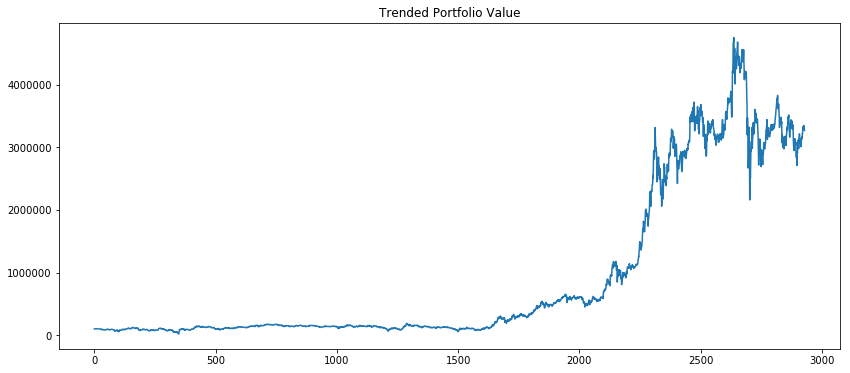

In [92]:
performance_summary(performance_1hr)

## Fee: 0.25%

In [17]:
train_window_len = int(len(scaled_prices[scaled_prices.index < datetime(2017, 9, 1)].index))

In [18]:
performance_1hr_fee = trading_simulation(scaled_prices,
                                         init_capital = init_capital,
                                         train_window = train_window_len,
                                         trading_fee = 0.0025,
                                         progress_print = 25
                                        )

Date: 2017-09-01 23:00:00
Capital: 98596.1431338

Date: 2017-09-03 00:00:00
Capital: 89365.2642639

Date: 2017-09-04 01:00:00
Capital: 90597.6550413

Date: 2017-09-05 02:00:00
Capital: 68581.5137321

Date: 2017-09-06 03:00:00
Capital: 90818.3692144

Date: 2017-09-07 04:00:00
Capital: 104098.355004

Date: 2017-09-08 05:00:00
Capital: 108263.152951

Date: 2017-09-09 06:00:00
Capital: 93607.2581877

Date: 2017-09-10 07:00:00
Capital: 69099.7456303

Date: 2017-09-11 08:00:00
Capital: 72123.9674332

Date: 2017-09-12 09:00:00
Capital: 99703.3368323

Date: 2017-09-13 10:00:00
Capital: 67737.8931153

Date: 2017-09-14 11:00:00
Capital: 61086.123175

Date: 2017-09-15 12:00:00
Capital: 55033.082314

Date: 2017-09-16 13:00:00
Capital: 79704.1385663

Date: 2017-09-17 14:00:00
Capital: 87014.9421293

Date: 2017-09-18 15:00:00
Capital: 129034.354423

Date: 2017-09-19 16:00:00
Capital: 128384.107133

Date: 2017-09-20 17:00:00
Capital: 128568.300791

Date: 2017-09-21 18:00:00
Capital: 90430.7664498

Da

In [23]:
# backup
performance_1hr_fee = [100000, 101030.44890713326, 101331.60379863867, 101407.6868619554, 101852.23084554436, 100467.58353449374, 101961.58161811363, 100730.32381922154, 101912.97434162162, 103039.40863641884, 102601.80535354298, 102634.69792984203, 101974.10104622893, 101722.77409533059, 100461.0861833012, 100713.24160763338, 101408.40346299425, 101314.16009210322, 100563.74555856598, 100070.68119641693, 99757.07181086269, 98685.786914909811, 98019.371992354136, 98800.723912589092, 98596.143133845209, 96172.019437630646, 94492.198553123555, 94345.0091219639, 91477.545167536708, 94339.241051340752, 88272.468564551527, 93606.446968056931, 92568.354694951879, 91417.161991026253, 89667.098273014693, 90610.80594261401, 89912.074345369794, 83835.732330098661, 86855.471680095143, 85614.691795485647, 86157.413459076546, 84212.862088206675, 85446.080120673956, 83655.160643509545, 83415.750593683624, 80686.929128073767, 82034.767674576113, 81991.430120568126, 86006.458287601607, 89365.264263930469, 90699.870100927481, 90439.486093989122, 89871.847376574588, 95013.910346344463, 96528.481803748873, 95232.754511614214, 94232.931351030755, 95114.420162750626, 90744.638475058164, 89844.359373915286, 87855.58434696414, 89298.221417322915, 83611.574057012112, 81898.281798739816, 85700.604320131562, 88546.358353933334, 89529.219634826062, 91003.009725441807, 92025.652007756406, 90720.939765897419, 93118.302228561384, 92742.731002524612, 92823.306970720325, 91054.5884298694, 90597.65504134573, 89504.90424165377, 88969.691690493652, 90108.090443590045, 88833.68211677896, 88875.662177949285, 83594.196376456093, 78748.449791469116, 80722.080904559756, 76305.187549444337, 62980.607099520785, 65758.109048826154, 73998.887268009916, 69264.543033244714, 68768.266053700383, 69967.586438439175, 70058.397007993481, 79294.571567336126, 85074.995277446811, 83700.390048815549, 84576.844190723918, 77255.744690555322, 71639.110978486453, 67747.387023513278, 55854.181959364272, 68581.513732103005, 60601.007580836696, 66772.004106556269, 58598.328667133654, 69858.924808729207, 81552.065154538082, 72830.518444099449, 74625.662499811166, 76876.546365922841, 76020.813475118921, 76962.235390587884, 80771.868092704157, 81411.376836518524, 79266.717982976203, 82614.49451328408, 88899.207954740763, 89799.094765605754, 90708.446924233664, 89617.855416817547, 88015.59975324494, 90940.401209170377, 87316.138044872627, 90821.932999212819, 93945.137647685668, 90454.177008028113, 90818.36921440193, 85563.898500243173, 86795.392165955142, 88017.805244939926, 91386.654175562959, 94802.720470354136, 92529.13741883717, 96780.562754913262, 99683.108697899588, 99698.99728433619, 98457.723752555554, 98014.604956559895, 100231.65668353658, 102934.74002314065, 108039.14779303827, 107126.93018982338, 109685.93901629843, 105709.62050648849, 107650.15622905114, 109772.81945714205, 109256.9855362048, 104145.86861074103, 99998.877782879834, 101716.21558661686, 104124.48990838544, 104098.3550038665, 105659.78224691359, 102411.83224758484, 101012.17405928439, 103336.6051266563, 106618.44750866602, 115923.10011923834, 121003.29435524817, 122551.29761505465, 121302.56260301221, 120021.92150947984, 120231.99810516843, 118348.76704501925, 116718.1747036118, 109848.17864100017, 109922.40834177847, 111407.32128009488, 109334.94922114747, 110074.33405711307, 112306.7604747259, 110069.61737809933, 105324.61449297507, 106374.00686002444, 104794.803059025, 111504.33856103809, 108263.15295122287, 109730.49481671819, 109125.61400277229, 114943.34313969918, 112527.51343096746, 109173.7875149146, 107698.89669873042, 106768.84079193595, 86739.67465666619, 84105.331982998148, 89077.24305720866, 79737.526271651674, 78778.709238496958, 80308.062699139147, 71927.856925410917, 80675.370708853938, 81722.365551268129, 86991.42923824543, 84467.472496897361, 81306.050290819316, 81165.811563243988, 83626.369750877944, 85505.667306661489, 84013.470247738413, 91524.195742918324, 93607.258187743239, 91137.006441841411, 88340.077344413512, 91535.807385015622, 90193.667600321161, 93714.001294952119, 92991.732033662236, 90134.724606371426, 87761.692104344693, 87691.871352425791, 85870.60946557112, 83599.672959577903, 80574.906489789297, 84580.155011996889, 84661.410333475971, 85660.412917107853, 89989.497395775223, 89472.510126441368, 89725.080694608638, 87089.013161202893, 83822.741600215901, 83789.890016114965, 77539.78461162679, 75911.504234588894, 68905.063830218598, 69099.745630319856, 70043.384746312484, 65909.112562770038, 66952.568416347902, 69586.268333073778, 70436.005520687497, 74158.057228308142, 76603.772078120965, 72518.649533381496, 79374.146130085559, 81639.617478309388, 83186.37893662526, 82281.417086618705, 74987.671936700048, 74233.442891609055, 77137.09264469333, 75618.01603583539, 76505.385950948563, 82950.513930185727, 80125.639577401962, 84223.692481599166, 75658.188553466302, 71642.779895612446, 73355.01647966764, 74447.278496313113, 72123.967433155718, 74845.063987350397, 77526.200553852686, 73774.345370107316, 75941.353194091265, 79185.272745985261, 80460.134182299269, 79635.338602779579, 77285.575147867174, 76983.755514503559, 78380.284954018585, 77094.050893727865, 78338.541228130169, 77688.835847308947, 80259.095280454872, 89463.381784728903, 101303.82010706105, 102885.01602775074, 102269.39945619462, 105292.70299965332, 105385.1721278145, 105444.01246013677, 107086.26104030402, 106718.35873775356, 98954.234643954638, 99703.336832307235, 104904.22577830334, 105353.05433876341, 102597.176848724, 99670.050419304083, 100420.08882517871, 96427.838452724623, 99763.486882354307, 95865.187208293326, 88912.614758202821, 93958.303595903068, 92666.149299184821, 96543.366622271162, 94252.353224380553, 95018.923401713211, 91379.888710309358, 86759.599745336891, 80263.050037454523, 73764.687286696528, 79842.848189026758, 77307.078282823699, 81317.166499324594, 74899.429576207389, 73855.031928136625, 73450.763762898845, 67737.893115306157, 66281.907011134739, 70248.071322036092, 69681.412223937383, 66551.987096574128, 71105.907590658477, 80417.661701176694, 77174.068913217052, 78824.288371205199, 75618.481285807851, 81810.040057990525, 81530.741419283208, 87736.88189260714, 81874.161107172244, 82793.865782180947, 82768.590824666346, 80640.413742745121, 75629.37865553709, 75920.380029097374, 76523.729721100506, 78577.185647236562, 81819.080507426872, 78366.170682441007, 73841.83539398032, 71555.363719540386, 61086.123174964676, 50148.699103328167, 57524.997045505472, 60466.527348692674, 56974.81684734828, 52162.67378448919, 43676.981640249978, 53246.966003031353, 49880.972602804934, 52228.904983719942, 45644.974003252304, 46516.549332509589, 40298.745269606727, 49516.710368243454, 54766.866643949201, 52869.600917738964, 53115.441120254371, 48978.445708255669, 49906.164030395288, 33714.044777968651, 33642.337905740031, 33970.271889626114, 24844.960778275083, 23032.353032046769, 18434.107860159165, 55033.082313968611, 61016.081350560722, 84462.214919417107, 85533.266047029087, 77666.105268551299, 80086.400827742196, 80724.562072725414, 86509.099100272055, 90247.098823309774, 97212.460528894153, 91680.993361012093, 87410.528244936271, 89148.558546596498, 95573.484185875175, 90899.265653273585, 92904.795905640261, 93641.284899215942, 97851.873533657461, 93798.793548289919, 96734.093436941199, 97670.778388830266, 85395.167597694614, 75277.96038831427, 84766.701212435524, 75717.565875523724, 79704.1385663361, 77129.709128313421, 77965.436385895649, 80746.45335623245, 83726.490995580316, 90353.830813614448, 88063.81159214818, 86837.151876060496, 87214.485672253781, 88083.502062590618, 86616.548531077569, 84419.963107242977, 82883.98717080304, 83840.191172406398, 83863.943174277025, 81147.96340177246, 77440.975698015638, 75994.636828867631, 74972.400824411539, 75382.888061765756, 79989.997931006423, 78331.008118255573, 77239.646182035242, 77969.205396108096, 85574.454441017471, 87014.942129345873, 87753.540264021125, 91753.294031401369, 94535.227512156125, 92355.817550775944, 93143.428491877916, 91958.924072549606, 90726.213581555086, 91380.594654705274, 89644.672130722087, 97659.446769364469, 104908.75567110295, 111443.06240512183, 107916.74650469067, 109742.78730105716, 118365.04481924206, 123093.07141788992, 122788.25101369037, 125806.7129145528, 122697.0625731035, 129287.78283591695, 126143.19077748925, 136629.5525518411, 135194.31783778575, 127213.36339825856, 129034.3544232884, 126574.58181012374, 127892.85923908805, 132097.00713349198, 130696.41017634101, 129350.31181966024, 136439.22409646431, 135293.56661209714, 138057.8497382928, 131178.75871786627, 127374.05148085415, 128122.77024602114, 126706.15188826728, 120088.68055586095, 119593.8720078206, 124874.58974212807, 119764.37923945324, 122429.61784776326, 123744.47684930338, 129926.25391005554, 126811.38683779007, 128991.58873435261, 122244.40313573791, 124264.96933127419, 128839.16677103135, 128384.10713258745, 126347.44765480628, 125784.8726116137, 119670.06107499801, 118581.56097236776, 118834.83895347609, 118987.51099612114, 117801.12506508487, 119132.86957814597, 116858.79601412488, 117184.22342537448, 116375.57285578374, 113516.96540086015, 117553.23533429336, 123623.52259758158, 123336.74830942886, 120924.54138148768, 119815.43670964733, 119199.76609574973, 118822.81413666143, 120439.23902072897, 127044.21634925524, 129137.29676222986, 127757.39490133818, 130347.16933577592, 128568.30079074348, 128030.89899622774, 124963.63379751577, 126245.4168871685, 124503.8724569008, 124352.12136022863, 119057.77335513168, 116931.90394836068, 112774.5254834888, 114782.67917745994, 110120.9122829769, 112941.45759019392, 113268.94107945569, 112690.66408883651, 114909.38871405914, 112602.82147004608, 112491.74019194531, 115421.89148219035, 111499.50005238815, 112397.26813497549, 112691.23678378301, 104728.91995632148, 99887.827278819284, 93532.713040299932, 89916.666864834318, 90430.766449798743, 86169.013796315208, 91551.196953458348, 91724.277658540828, 89469.829575653624, 88593.291279007157, 92790.065380608779, 92233.616828241444, 89850.568537131461, 94774.103061929316, 98453.376296738716, 98247.057823891839, 100546.24255144928, 91409.486781667249, 91688.973175719424, 84190.06558498615, 84912.422015760938, 81745.537568243191, 87467.024968088386, 83834.986860918638, 87718.626858130097, 82205.429372374754, 85532.822674330149, 85473.357346048695, 86509.477557949664, 89141.163145165949, 90119.926651196962, 92800.624611483247, 91288.438207214, 91388.546739088168, 90821.354698898736, 88691.909644605272, 94448.480601496471, 92700.605503812258, 99992.867885144369, 98835.816513198864, 99840.858052837939, 100417.87439118567, 103636.83852860902, 104084.46029081551, 111182.62978979724, 113173.14256790829, 110305.77306439825, 110855.80545910195, 108449.21538249346, 104409.56417439904, 109688.68570104399, 107110.14568097334, 107078.17023882811, 109316.88965125114, 110001.84033616851, 106583.06355370603, 108230.75178980512, 110950.24982775762, 107774.43147918445, 111371.65512411679, 111368.34277927494, 111723.73820623741, 100774.80247938466, 102352.50217688599, 96998.6486298237, 98694.336826635757, 100178.23577327796, 100005.53314417726, 99291.432011337893, 100373.80328407272, 102011.55226403069, 106187.15217788512, 102093.85027162544, 103119.99145131688, 102463.69624322097, 101969.39419657626, 98432.187025092455, 101779.63025040799, 99700.21220994569, 103277.18288918167, 105127.24434687223, 100979.55731161794, 103195.84290147123, 103741.98533313529, 110849.44576675964, 110414.47770739562, 114446.69686360302, 111619.21949760735, 111128.48548340728, 113311.30106035323, 111273.59183174613, 111008.51703399228, 112926.18907786382, 109593.11963249605, 110821.37862247281, 109276.016757622, 123100.49056343755, 123197.56517929849, 121144.80385485655, 120538.67051879808, 120929.11713731274, 123788.94557267748, 124865.73010755124, 126785.05619585901, 122250.18815068452, 122996.15613699514, 124253.97737244304, 123558.23431317438, 122076.1155070285, 118606.97969974697, 119610.96776970997, 113945.22818713852, 117279.30952012877, 119373.99192781662, 121054.10278250785, 121146.92990193874, 122127.19105616384, 123537.83649832723, 120884.0405445503, 119503.91030924409, 117656.02833006633, 117572.96819152113, 115136.64636860814, 115182.58007190964, 115931.09254855954, 115572.5773664724, 114133.59243007225, 114581.9342597021, 112082.39812631585, 111110.40720498237, 113656.1830261299, 112577.34986022988, 113017.63444120425, 115393.30458052787, 112643.35781418654, 116121.30950043745, 114578.28524978211, 113875.94385014751, 115286.13002472985, 116137.87196532951, 125413.01681177139, 125931.92243941539, 127157.99529452022, 124180.60581482535, 127051.05108926691, 125334.57674635053, 125408.32084891915, 126828.70759205316, 134170.02496184249, 135426.80942022585, 132261.79301724516, 135824.61210301961, 134529.49818574832, 135275.83594878757, 133066.66068906797, 132953.55923604278, 134540.36985499942, 133325.31807901539, 136690.65834162003, 134339.33373894123, 134195.68081318148, 133590.82967334471, 134097.86211586534, 134883.10745079239, 128781.17016936219, 129395.55214103049, 129258.88190274882, 128890.86866423853, 128036.65548328869, 141356.35546967934, 142399.3522070279, 145660.87877956859, 141159.20220347599, 140657.42855652064, 142935.88670429646, 145459.80921845447, 142934.26094197851, 145004.94860652517, 145708.22166361322, 143260.22980790507, 129193.55785998864, 126404.211353336, 127887.40812684038, 125331.93008338893, 131871.85721827188, 133926.79436035559, 134151.66508402998, 129824.21294949905, 136683.51835326225, 142762.52557063065, 145734.74973358569, 140229.53221980113, 141991.55352565134, 143960.81080422178, 144102.37077292739, 140458.85389902798, 138317.82424762764, 139132.38760276863, 140710.20830049511, 140966.92706124351, 139133.42529030453, 139724.22691993031, 140818.68820407649, 145927.46263709382, 146482.68085187391, 142932.59686240583, 144135.19505019247, 146591.35001420393, 151780.50903034187, 154027.6185535157, 150478.17384485499, 156087.16950874712, 158946.8539980354, 158835.67198165134, 157585.79092031642, 157204.04342456677, 160188.32507634425, 159408.28106480301, 155331.4007291875, 156323.72993842218, 157664.89100024381, 158137.07840022194, 159696.0328163114, 156309.07632756419, 157382.17982081848, 158093.53787805792, 158823.29490909819, 156760.37263616716, 152148.3966743403, 153773.48209695006, 154646.32441826095, 155571.91923745075, 156362.35428200604, 156278.47715950909, 153615.8039351537, 152296.32348840332, 152740.57647344127, 151304.12848217081, 147534.08044327545, 148206.39001025664, 149645.15129508989, 151833.95788853848, 151374.22568573646, 150629.75683310319, 151365.63196413909, 150645.89559694147, 153234.46313496993, 155607.39286340997, 157813.48681287578, 157273.88016647857, 159352.31711085117, 159452.34729490645, 156364.36238662299, 157045.47136118065, 156207.43505546998, 159631.42835193506, 159050.58617712738, 156160.56015127624, 157000.95135442389, 157548.22443695634, 156859.86431652805, 149252.98516908212, 145220.01695694719, 147484.04574523406, 150933.24328487884, 147164.50889476348, 148415.41332780756, 146277.33428341709, 143357.0327371796, 146123.34186449513, 146099.97882692813, 142587.99345986889, 143734.74963355059, 147140.33979069316, 146120.18492869154, 146703.43026118079, 148338.13233014321, 149449.89095992292, 148895.6756218847, 135612.54187195163, 133571.90783499146, 134071.38077709917, 137077.91976969072, 132620.05956393041, 134039.34536205465, 133447.98093185027, 127972.85516612261, 125023.80551511672, 129922.38990257027, 132950.05343169614, 129675.20907080246, 133520.04534316016, 135582.6336389636, 132422.71315477078, 136284.49194406392, 133685.5700936272, 135818.65950046972, 139182.32048165536, 140434.24247805504, 139067.90785402729, 136118.0227655925, 137857.37845281974, 138997.96501467764, 140952.604306978, 140287.19614424306, 140141.71261602623, 134631.70289224508, 129818.94825886055, 128683.05893136405, 130261.66510831649, 125110.55399050264, 130240.7919391715, 127376.06852642706, 130153.90916100812, 131100.59190137003, 133101.71004834541, 131726.08753102302, 132007.31863106281, 129451.94894725461, 132780.93716562173, 133286.00292458708, 132723.5697274463, 132854.66005378444, 132240.62350952672, 131528.34176341357, 126778.22002996076, 125114.24740302088, 122965.3077342475, 125815.38686870743, 126381.89139570702, 127105.76718321416, 128912.1591371715, 133050.18805770113, 131217.69477775038, 138092.34186556592, 138441.16432952794, 137522.76035426385, 139846.07881883509, 141409.50213162263, 137747.00452939433, 140845.25681101027, 141721.44969546792, 138560.21362293718, 137956.65859875912, 140089.82592726848, 135838.94393879859, 136824.58699940122, 139516.45990662201, 136958.31573059369, 139472.9269157055, 138710.01923002242, 142300.44874199881, 142774.5364937766, 144302.95567093184, 143271.60952305974, 145225.15429404928, 142381.50795617414, 142212.98145282845, 143667.07396984278, 138189.49232796059, 140065.7879347367, 137555.03668252699, 136751.55584193725, 131967.08789983613, 131667.97351190791, 134005.70924067654, 131802.86547961022, 131123.28543581523, 127311.10611987844, 129182.6479023649, 130746.01233774208, 136164.92643359862, 134142.33932636678, 133219.78750537173, 131927.54553491861, 133149.79764336476, 124787.76756355609, 127915.43725844871, 129968.90389042054, 128931.27140414498, 126544.22191643831, 127484.58207390828, 126839.80745266099, 126883.80093510925, 129850.85026690899, 131885.07427393942, 129935.76356527414, 131592.87462473795, 131229.58695890085, 130748.91129965048, 130347.8905299031, 129188.45528757035, 143915.13938381814, 141856.18520781089, 141285.84838106539, 141963.04994492457, 142111.98724748037, 141644.64411918737, 140487.40204180038, 141574.11399519327, 140894.31540678587, 142048.73509880071, 142051.63355091121, 140342.13046574718, 141647.33734368719, 138917.70440247585, 138388.15855821344, 141370.08486832536, 140901.78420986046, 138749.3855996473, 137534.39727928513, 139421.0827570465, 138142.88900944527, 139729.74833782809, 136673.42057224677, 133607.40973314992, 133527.60478474689, 133417.62183771926, 129524.82183728335, 132708.34979702695, 130417.02324443097, 129019.31188428536, 128610.99706393367, 133326.01008882115, 131143.29269007122, 128254.27219589963, 127823.45767424224, 128794.9133382923, 129674.30390439346, 129482.13878808988, 126502.0979019743, 122295.59976524365, 115052.99813480828, 119464.09947916686, 116733.40723535679, 115491.06475282954, 112141.88385133298, 114825.09918928222, 115954.78687019367, 119655.28283053235, 121121.91446353101, 122607.88577551788, 120082.95757839478, 121259.88606103968, 121003.68648440245, 118520.11549434933, 118276.50157011184, 118796.93587642183, 118232.85163805436, 118115.96494111339, 121537.34335545907, 122243.72223676514, 126241.86667495227, 127703.59289644042, 131428.644086721, 130209.04100446307, 127258.77158580217, 127096.92184597324, 132269.45864968983, 124780.23206168281, 127815.44312731462, 130303.02202045739, 128105.50560143161, 128484.79659708607, 127006.33168943308, 126276.41890784705, 126057.90568957673, 127243.5313823179, 128272.68309245963, 125872.8186385438, 126137.74934985951, 126944.38611340645, 126701.69077404795, 127187.90850923103, 127034.71052478693, 123982.44946650015, 124388.42149264921, 123766.04558121457, 124590.84071767698, 122850.92311382029, 124610.92055826637, 128404.74363050176, 130038.26899135478, 129476.20824755826, 130586.63332236007, 131106.87557448581, 130293.21317507052, 129011.91418305197, 129202.12291516253, 130120.65994350033, 130327.1104297937, 131717.28255159571, 133287.85106433599, 132586.39678492706, 132439.4902966042, 131338.44974580113, 127924.01389266718, 123452.27078689777, 125266.16462567006, 126712.08161466767, 128607.81226412617, 125466.33550062755, 126996.51328666802, 127011.01786502101, 122575.90535853476, 123548.4868867537, 119178.06003953899, 122376.15157710167, 118221.61696105835, 112283.87701449759, 96145.326311942888, 112014.48528116135, 115031.61694404994, 104340.28365121463, 106761.41912448435, 114477.55848998399, 105639.51247052195, 113606.39700373399, 109401.22497177494, 114135.05043006378, 123484.18496728531, 120201.55008428673, 115544.56355530056, 117111.07879631629, 121238.34100871917, 116440.90154168342, 119849.20773595425, 114945.88821937435, 113600.91736932023, 118762.53257472845, 115044.76013347734, 116563.79647006633, 117038.9122540117, 116179.16867762389, 114365.59831669604, 125709.60594525696, 127844.03044492363, 127702.20026484071, 125830.05640559091, 129236.61204444409, 123451.5508216907, 126739.16052900786, 128380.16629032596, 128372.06022133774, 129979.94932740492, 141162.8509465417, 145846.83889952247, 150936.17838763958, 144530.76601812334, 141263.17062675109, 135449.09833545054, 133499.489370336, 135579.03677297357, 144877.7302843261, 144184.33774113227, 145792.35779793269, 143448.13518547078, 143654.66401302163, 138190.50088169085, 143815.6923420332, 146884.96398429817, 140142.90466642787, 139937.55390881118, 139139.7869845478, 136161.2542297552, 132539.17594271377, 130432.67226173358, 133386.04041931467, 133912.47854721962, 134385.91425460024, 128655.39385555152, 126395.2211540195, 116733.86952183307, 115171.60971710655, 117361.40136801798, 120821.19446820833, 121787.54814606058, 122209.79985238987, 117915.83680266148, 117099.71499181403, 118402.32714412341, 117068.84670982609, 120728.11931568931, 122300.62435897469, 129771.02739703491, 127295.61495792583, 129857.90591141586, 129456.3499732062, 128391.73959013242, 123361.38235520748, 120205.5324121294, 125743.85247065578, 123099.91289645495, 123691.53801391218, 124044.59491378894, 131973.23834999389, 130360.12661429534, 135221.25711744779, 139396.96704505861, 136257.1311320758, 138951.26636807952, 139579.55127162946, 132176.44783136575, 134224.58695236477, 132425.80694543829, 134821.43467245577, 130064.64159566461, 131743.30631889185, 133747.81357147079, 134230.86820054986, 134440.9246421498, 125840.81822746465, 128778.26721030351, 129184.32864701984, 129980.92395762193, 128028.84362065789, 131468.35474146809, 132925.53445693737, 133010.73034610387, 130765.61755818958, 129642.25738934196, 127256.84905746815, 124821.94215233761, 126473.41061203029, 124561.9363811161, 125795.42751016554, 124542.2236730502, 125175.03730547898, 125477.53511403917, 127164.52973533596, 122663.48660713773, 124415.61265418559, 137071.83745983284, 141091.89887483689, 135401.85441546791, 128088.59222547332, 131433.4606391399, 135244.17162987849, 136621.72255462201, 139543.72073498857, 127941.78473635396, 131530.25498777977, 130038.02140309429, 130776.09682351025, 132965.12553722912, 132871.76603707869, 131149.71098085935, 118494.34633177402, 115268.67373443417, 125327.07986216262, 120337.9086744377, 120466.15144900307, 122870.98455798843, 122884.6196110365, 126373.35525883493, 128619.72170259707, 131550.33299310721, 133468.62673742263, 130564.9213442005, 135015.89351289207, 133823.31698800463, 134814.32584262415, 134422.92867175673, 134214.6650700249, 133632.8224110704, 134689.4765024338, 133370.58632369793, 130797.14895183931, 123467.70997973418, 123065.69361137878, 126035.9117922474, 123103.71345487081, 116965.16891502097, 116400.42918681726, 118636.14351151444, 117675.42920820678, 117071.75804369619, 119622.99645112938, 122948.62889321762, 120352.73774679033, 122649.14360642579, 120683.39753609239, 105570.52938098038, 111333.98755934277, 114203.44299117857, 115497.28555205013, 116496.56695945196, 108295.26181296303, 111333.81079373581, 108802.29600259465, 110397.22417828, 110551.29336958291, 111826.84748554601, 107588.42783882712, 107717.35126822331, 108597.38347401122, 112140.78400248947, 103670.28163551484, 102300.82554030971, 100308.71375019697, 105811.58763278714, 100035.42447875817, 97967.203980921418, 98348.627569809294, 96964.533188696485, 101287.25966094826, 99459.64675360886, 96353.441195326071, 93691.327058032824, 93559.420499767017, 80088.820536138781, 84864.82989110089, 82571.444902121904, 78076.15430339193, 75603.747221599784, 76531.65110752896, 56100.063270628772, 64062.5614078008, 72188.004622014516, 74959.046821389667, 70053.83033641777, 86752.486858343938, 86372.381726760766, 85212.649950485138, 87725.815134401026, 81426.599006769495, 83185.977458300506, 83722.480870564032, 91608.478861286989, 96419.959500889745, 95292.10828281664, 97287.785312337757, 105105.83701486458, 102063.77693521391, 97644.587990688233, 91802.683716086307, 90577.357968201366, 91536.431726917377, 95334.060188438569, 101574.0475580123, 101007.2561639027, 107871.62294225817, 103108.68884648269, 106491.33525441255, 99383.601883070631, 95433.815165298074, 93376.733291661076, 94234.111907914354, 100109.51809293011, 101616.13288018553, 94619.18668263944, 93779.822018020597, 91846.457990835261, 92104.17123442427, 95879.225899625511, 89621.416035522081, 85131.85559503836, 85803.241427502464, 82602.238060864038, 84672.399030441113, 84921.638703488425, 83853.220806424026, 80313.423383215966, 80632.438819848277, 85497.806242109073, 72816.533038543086, 72426.860507292367, 73867.494162989882, 75671.994105482139, 75501.215347553487, 78622.707431582865, 81611.708960325559, 80019.42719915518, 83992.471449058823, 85281.561758308846, 92491.377424674021, 93763.109772099895, 94944.21441002583, 102747.10590522358, 120452.84658760452, 116924.24861555912, 115994.78885314973, 120873.61366194085, 126120.65098111436, 119650.6212255006, 131170.90017036221, 128439.2553660523, 130555.92007956127, 130315.52950146821, 132269.9456007164, 143891.29117037862, 158745.15754468981, 166956.4119626357, 161467.55365473853, 149815.19297132356, 154918.73091744893, 156377.59800505888, 156451.090947005, 150657.44870432411, 141876.40749569403, 141654.79581349427, 140463.101682012, 142269.55253135518, 132765.28658444772, 129317.99563739312, 152044.29384533543, 143967.6004867169, 139782.39288195822, 142293.01443452304, 141438.54539538562, 141643.03609135767, 133188.43747562548, 127560.17071326455, 132937.08290461838, 132443.01578196761, 128858.52210710976, 126924.1395250299, 123656.74848323704, 127528.266900111, 130577.8703114391, 128243.98482994077, 136955.77988158411, 134745.04725482405, 137053.64682553851, 139033.62476581451, 133608.14291451903, 137096.91974301328, 137566.58338461095, 136480.7440156393, 139343.09701605549, 136416.85523305443, 136362.78006894945, 136041.01771949601, 135614.07670292395, 139592.98732612681, 139079.15978242207, 138644.93990884189, 141510.25332481376, 129257.63700988903, 131180.4139116641, 128405.59394039781, 125767.22204693971, 131116.77332499053, 125461.68276005208, 115844.0843014595, 116037.06472085022, 121586.5080839866, 121093.77618353139, 121799.27040508462, 116564.95274881955, 119533.16961028078, 118818.77343482811, 116676.21294706847, 112932.14002185353, 112381.09307954935, 103290.89365622459, 109545.27890897753, 118764.01544258496, 121170.06966132505, 116080.74540064442, 112357.83225200235, 112621.96121738396, 117254.80857409441, 124012.32252674249, 123303.25989004569, 123688.67446257695, 128396.38254777961, 125080.85001873162, 126758.23282790477, 127666.27068302932, 125582.21061431183, 124995.30816401094, 122639.74551018319, 123493.45276705864, 120360.06285882191, 121331.74497531676, 117785.11969346853, 116888.76528112593, 116370.48100890924, 118486.1830475553, 122631.82541008083, 124584.64599565862, 122144.66082252773, 119772.63331807172, 120184.58590558734, 115021.38143867449, 114708.32052408294, 106930.43301832411, 106815.9673676688, 109419.82408897529, 109753.75185160259, 105452.78842350375, 107007.3867340867, 112045.31398588809, 108877.69757059855, 108093.37714917352, 104349.7884852647, 104522.88879142854, 103325.10320432142, 102604.76349971161, 105952.34861094595, 109906.7944838033, 111324.36498469261, 112201.16628988434, 113409.95350580389, 114585.9542213987, 112008.10938592858, 108004.97250991542, 109170.13574630101, 104850.93329227055, 102813.7001554325, 108378.45416268655, 103085.27606927388, 95118.914096454362, 95407.650391108342, 102217.24624726828, 105817.11608534679, 114259.0754084017, 108381.26347407386, 106937.10674310722, 113571.8391488749, 113309.3357569681, 110280.26375122739, 113013.87682175943, 111101.17357733942, 109530.05045906091, 108012.51766483863, 109921.7151741492, 106656.49319704644, 110057.21753177287, 109921.19877048588, 108596.77261981292, 106867.91146928932, 102448.91422367268, 104655.77980476963, 108371.91740679654, 106242.64735042455, 106553.01431986169, 106429.93073718365, 108075.87670884232, 110429.25209443693, 109706.03030445985, 111471.2371954681, 118242.24955419116, 117951.41055328853, 116764.37331221701, 112864.62266894784, 115321.98543780457, 110799.77462034005, 112621.75487552304, 113888.25664433913, 111778.11111962009, 108868.99692405737, 107292.52432761145, 109530.58257915544, 112565.94783425864, 113337.50810460767, 116194.21952810475, 109338.32648812937, 110648.12316312379, 106713.71893522155, 107368.99339521423, 106310.80947925019, 111970.82031780199, 110651.74445929055, 108675.83872891837, 104320.57399000059, 105578.57050603237, 105536.99582085476, 104756.58574297087, 101278.674011275, 100643.83355926009, 101483.78458233351, 99521.130334803194, 98753.368499809425, 99333.004056533435, 99563.271747902822, 98514.824900467662, 92412.778379128053, 96978.211809165412, 93241.767415534036, 93986.752281373614, 92134.242519410036, 89321.440160989092, 91865.088719057327, 92571.870927721058, 88886.669080349835, 82105.519996866773, 83417.648016019477, 80761.985896788741, 90963.141095717205, 90093.607973605001, 87708.247746339432, 82529.61247331668, 81416.484947280929, 75265.486164327187, 68005.000202027935, 72018.968017681327, 68857.414651718762, 67847.169492757763, 70201.433356521389, 66325.616217125455, 67341.722752235524, 54025.358006599396, 49588.720350111485, 69487.960850233401, 57780.961028906313, 58732.816017489138, 69887.188981057436, 71092.732267779167, 73535.625883719666, 82170.826619004496, 98830.044767579704, 87577.125916769714, 85685.657769676443, 90153.163771115418, 81265.004130811241, 84621.48067813713, 82609.788824386604, 85501.71736695437, 89176.372033151565, 83942.448915090674, 93467.659907718291, 93431.011677080576, 94981.161800066242, 96099.347596729596, 90932.985255917272, 88185.210681722267, 88244.6110603626, 89181.606950498433, 87638.97382590195, 84527.102184459451, 88470.789499622973, 92974.984898348004, 92099.634246110654, 89143.884670457977, 87174.441451923005, 91229.402575092026, 91586.644272678677, 102954.13626108342, 102937.86895187359, 110389.1111247451, 101738.78669128039, 91390.524822168474, 93023.555077911238, 90695.162639609931, 95092.523623671732, 96405.02170744336, 94429.323616113077, 94856.500652231072, 94788.973320875826, 92150.005766384318, 94517.690622967493, 91370.671559341004, 91619.153786640556, 88440.710654186143, 88315.588048548932, 91392.129284186405, 90384.564325171392, 91073.400820699739, 91623.683950354447, 91869.555624876215, 97978.055348164926, 91426.886553518721, 91348.64136014432, 91039.13379868737, 89820.992974289911, 91150.117198261432, 90006.697404080318, 91400.057813207575, 85158.146608409312, 79319.905514220271, 72648.100620024939, 77042.616773894682, 79726.546533268149, 71345.431066515244, 71474.501794453114, 66423.893115343002, 69157.092665028846, 64052.002041609769, 64425.419561173148, 77864.22537182727, 71672.038233472878, 78139.792780477932, 76735.29654220982, 75902.942569934647, 76858.949368167407, 77290.20511916469, 80095.776582317019, 75625.679837092743, 70940.672675779104, 72134.403000490696, 75037.217329323554, 75025.631591132886, 68683.230894354245, 66526.656322615119, 66229.161306866605, 67970.930502397168, 67558.546853312102, 70039.846026134925, 79354.347390782103, 81886.074975622148, 87618.753431241043, 84656.444345675307, 83533.655212355065, 83644.18822246918, 81677.27223120784, 86183.729321568331, 88620.099681399341, 98218.154408440314, 92797.700975187356, 81779.313153859184, 87679.933112522573, 95788.219380935712, 89181.761010623013, 94357.318161621341, 94355.632471856734, 97772.314347266976, 98981.889171423201, 98262.644562323156, 108651.433111676, 105131.81460567356, 111351.76673626121, 112041.67174551594, 110956.13301265545, 110989.92471398477, 110793.79606146402, 105197.49416530257, 101757.15039607404, 98942.709773815688, 90504.564929253072, 98184.92243836046, 95658.18786416974, 93038.793594804374, 91553.672308379348, 104322.28504259272, 102467.29230420904, 101901.75868652323, 105228.20926560096, 104716.589805002, 111848.21239637457, 109660.95800828221, 111286.69975714109, 112598.46004581747, 128213.83040561223, 131528.59558398672, 142706.76105486075, 143069.38722627732, 130582.26120169141, 124440.36137605843, 129001.02237742767, 136077.52716686807, 133505.15906962156, 143280.26813495124, 161707.5479421686, 164318.56079281148, 164922.19258384869, 174422.05097576077, 187275.66959955465, 175490.01076187222, 167560.83114320127, 174766.7560897627, 176138.52984453036, 172306.97260677104, 182193.26300970526, 191175.40699975434, 190801.96518999024, 199753.72559213921, 232346.27156667007, 227800.16530107049, 222170.07462908688, 231974.45513016495, 245506.00559888064, 239135.01636939938, 228939.5109765802, 229773.77616192543, 244993.22836641822, 248936.36103833327, 251850.81084668159, 259849.14489174561, 247476.30032045278, 251855.98974712408, 242619.96038809742, 223607.33649636386, 235108.97195709508, 220013.25013807582, 221866.52172234585, 232843.05301385498, 222254.67434270319, 226042.49190252821, 226418.56684615297, 224733.51691411078, 219171.47237268218, 218240.86519576987, 236667.51083668019, 227135.90007433301, 231125.96850458739, 197118.48037464576, 171954.78137228271, 196573.25955276171, 189502.00501143574, 197763.82603723567, 197109.4762462533, 178704.15496615897, 161545.01044915331, 175326.50158477909, 184921.59138813781, 204409.48274828677, 194996.11413939795, 192999.96973220835, 204684.74011817758, 205194.378675043, 202693.02373823943, 192985.80665892002, 201357.608514377, 192501.26953055302, 193789.31123869968, 201358.33564841337, 221103.03792223593, 218754.35647889122, 207678.52539207973, 212630.99826795113, 212249.13283582899, 223493.16634248715, 224684.64499431843, 212657.17471094819, 225344.74530487508, 258194.74471398094, 247087.24822850956, 255798.82819440373, 251541.65119467356, 251983.22941718483, 251666.39221539747, 280455.18033641181, 275443.94351037027, 273028.67806163494, 260615.67833362229, 246199.04694626902, 242578.74540202785, 217295.47232616472, 222316.13005585357, 238482.78687982124, 237763.63996456043, 240249.4693856604, 250649.67359176272, 252681.86419050978, 237562.00985364363, 238586.54295658405, 249859.40777892547, 254686.28559296246, 253287.31609818811, 249209.80579216214, 263207.0477981781, 258173.11246371223, 256878.44358956296, 258040.28952751873, 245407.14006152417, 253945.95164143201, 266483.25092520268, 260640.35882469293, 274949.06779734709, 284032.17171237327, 277422.03979808145, 287550.15443030454, 276159.53112232534, 283375.38150057429, 288541.13549041783, 273234.0990253021, 266725.84684904822, 275574.9318437404, 276134.39564598596, 266048.72081562184, 256612.69184556912, 276983.63505362987, 263753.56363694597, 263998.29473480757, 265832.20131482842, 254150.3235965835, 253851.29929488286, 261075.66632890998, 270011.41927627684, 258204.45300319692, 259682.33370949741, 256157.67573894939, 253856.40677155103, 249814.07321088301, 244004.18596762992, 236791.14878898562, 247895.62986755016, 245741.74748723485, 254185.8983588696, 257734.19970732453, 256087.18788459839, 248333.22131847803, 244638.87032379114, 255428.30217602215, 271247.629626401, 285032.38604860514, 265962.26046656322, 273955.25066064438, 269670.92449001252, 278053.24685039488, 279397.47353566333, 289111.07597453287, 279032.72645087336, 281938.02336468647, 291402.28749337501, 303774.65466659656, 301622.06570485124, 284838.70427537215, 295382.52695971041, 292893.52362883184, 295430.38013362914, 298567.40827820101, 304376.86324229877, 303653.70381324372, 327846.96188204206, 337755.96184990712, 322356.88627107599, 330158.05833210505, 328364.53265302512, 329376.17841627577, 340464.65752005397, 347348.50264145544, 342819.5596886382, 357075.49209361244, 363466.6031620017, 368157.356173273, 384565.32069996861, 395816.53981686832, 367705.76697842043, 353225.8638831476, 355796.77519048273, 387504.86861965054, 380212.65613469156, 380220.07956448779, 368101.91993844364, 387570.3311752408, 386644.82030146179, 374656.19935043191, 381718.11588393827, 388910.70304958726, 398879.47612566553, 388067.40023889247, 391476.89384200831, 394270.49926080281, 413600.00957027334, 439077.84554842627, 429996.68262152356, 443308.38759261242, 447733.71287399868, 455144.45497620612, 437989.48836207797, 421411.29240561096, 433654.42757277907, 410081.16989991633, 427864.12520657369, 416428.06286149018, 398054.63565705868, 412256.84411047079, 403568.94575289928, 364172.15717221249, 377631.98039987142, 382179.09061805863, 411120.29865636822, 423564.11251468014, 422944.63164060412, 438901.43153020868, 431869.73115169047, 411957.6738735445, 415966.02788710134, 418054.27286771184, 411335.57344287034, 390788.78209775063, 391245.39799594483, 411367.92118514347, 408129.55019147723, 402786.85229611275, 392447.87099121581, 377106.07007443183, 379630.41603894468, 398614.59391011531, 405165.93914854073, 409797.13647982536, 409178.21106246777, 409539.40706934949, 408725.32204974175, 412782.96574273665, 403962.2701540282, 400634.20486179029, 401645.20892974309, 391078.95843256096, 387809.61342005269, 388624.21559003962, 392084.03302255279, 403879.49743924139, 411819.74106130039, 408161.44228593417, 417947.33549255528, 427235.7006445966, 433238.19562883821, 428610.97868804476, 435924.41137092764, 429953.86856475467, 435696.11185868061, 434329.47034020262, 432912.87868963729, 426976.71044459176, 436478.52340470336, 436365.81807137479, 442833.60568518075, 444385.07811872021, 455015.84426707705, 461432.02763448108, 453070.29266872088, 463358.6876461074, 472568.93626790616, 466273.68078405352, 457598.92417669622, 456413.90250896185, 472303.14863105468, 461685.31590622535, 448042.69368566456, 455866.04413170641, 466356.3805647954, 455894.91765208123, 462644.08902043669, 465040.91374136996, 474365.96079464117, 478259.61385041015, 483803.37242025149, 488082.87522844994, 501320.20801561925, 490080.42024893296, 504192.97390392906, 495014.82021659549, 503206.38706767652, 513571.01160331373, 514662.22054773336, 510945.586487322, 515587.82258856634, 512275.17294750508, 516830.72010715259, 518288.32034495875, 518643.21784095227, 528473.21340967808, 537214.09788144799, 545558.8709685778, 522688.85592907778, 529298.45620977902, 535902.44979561493, 529465.14733841387, 517810.41621810716, 461843.35293020814, 434792.52824248112, 479681.97606836347, 462375.90115261578, 479394.4404704349, 501246.61735803855, 486074.67319379211, 480466.59267762792, 483108.45189546095, 477705.11907685152, 476336.17141923372, 486964.291265968, 514673.26980202732, 504482.31224002596, 498940.66697399801, 499675.94167425967, 476833.94751689234, 490280.28074225591, 485207.85022669955, 465566.03318472276, 480178.85687636409, 489178.84390293167, 493428.97886182758, 490905.2816507208, 504263.70688257751, 500885.31848823075, 501416.10986025049, 502679.07129218546, 509731.68258796725, 511848.4227045399, 525373.217153545, 517554.93641196541, 511905.12798885669, 499105.85886854574, 484535.22207674495, 486872.00244965841, 496294.94966509589, 490398.97818486387, 479640.1526281868, 478885.29563489027, 479904.31340013538, 492719.37385279185, 493888.59916790051, 507419.74979712465, 501943.80746094848, 502737.5742761133, 488633.73477089789, 501633.83814941935, 488969.82329082594, 488611.65015758679, 505161.16159751359, 502425.45302905934, 503285.53427936119, 501107.76812993793, 505626.41500913666, 506347.89763659704, 513091.01372561359, 509710.04532071488, 510647.77628021745, 509229.30711278215, 508754.50088311802, 507391.39647291915, 500563.28714915831, 472273.65809579543, 485833.33039748127, 493516.11064514454, 478622.66000910883, 474232.27083643147, 436418.37558917695, 428200.13555379322, 427085.736543737, 439762.83236721682, 430983.38621559029, 435602.76472033409, 374206.54386224854, 383888.39179632493, 416896.57647725916, 417153.11790209659, 419871.22489084641, 416267.44030271604, 401616.88524351176, 405222.56423583243, 402374.76006685209, 413701.215276476, 410643.22472427506, 393145.92885266157, 396386.00916809926, 410945.74996661826, 428847.17937480088, 434474.64275144384, 447328.85227876296, 445660.50680466602, 465305.00564587757, 432800.2832177555, 404861.75025770621, 419543.73585636087, 415235.19651610777, 423286.06383586151, 428732.58005817269, 454698.19177099311, 441888.83850137476, 433359.25002210145, 449651.86958449485, 447746.9099942465, 453849.34820965107, 478708.79008606274, 493895.66966551368, 486051.91260100825, 511814.14458890801, 511825.06947131612, 494808.64043987927, 480312.85134877457, 500719.53991403524, 487024.91478393087, 485040.23742083705, 476623.36868868972, 481129.98697656742, 476038.15456424741, 487765.18918168673, 482633.96445725148, 479050.34698388993, 474779.92042621278, 456929.87329049339, 462684.56185803009, 446534.1955014714, 450925.16186308098, 450404.4736764956, 463584.07054593728, 470824.87559484155, 455004.43845200463, 457094.11958637286, 452787.24688081734, 460585.84677163314, 472268.63739934668, 463815.84925056604, 465087.9318215712, 453568.44377613958, 465534.76646669419, 489219.3540484577, 488666.72409524408, 504177.19479142781, 492216.42751187831, 495496.31031877868, 496476.36246358696, 495482.95815415424, 498788.78067692195, 498256.37353008718, 502677.03799296677, 511761.62645200267, 506257.90184773202, 481887.7773703516, 574570.63063225581, 570275.79761911067, 581573.73588604946, 578558.03515700332, 587312.63416511344, 605827.95454152278, 595537.21739981731, 597672.44798481779, 595101.21172027988, 605878.63115320983, 616893.00908922416, 658378.06025708816, 677519.43923541694, 656660.24067868257, 684467.13565665705, 735249.14185802417, 738523.61066066893, 735769.44155077252, 735273.02264167368, 731141.11850845825, 717769.94563548232, 685398.14849205385, 705844.7124673517, 672553.06945991074, 671626.42297663004, 700721.09235002683, 666291.5463267779, 651724.28417157964, 771738.46673034062, 778471.60915909195, 796170.10165042256, 776616.65277955157, 782009.07963979826, 788961.57202471339, 778631.0789408792, 876187.71982936445, 878056.55094840901, 923128.09640703164, 927941.62231226987, 879945.44197975844, 923029.54219330731, 968180.77732546267, 958023.57502812415, 898744.184838705, 919353.24011597165, 947728.67857964977, 955589.80575890432, 949558.57382421661, 933981.55292893248, 910782.45490989054, 961183.6026245323, 969466.92802735127, 960590.32767498225, 917352.54092482373, 852639.05150135374, 916563.02943738445, 902934.45032645552, 697115.64425367024, 739114.65225656761, 834559.39494561253, 820710.26424203767, 771229.99689382338, 805895.2599870516, 857016.42857493844, 835757.18416205351, 846172.67728031718, 857872.82289095444, 823368.74392967904, 783795.45539523067, 815270.9949205349, 842381.75027950283, 819464.98793716275, 737720.85228276998, 762513.42716097354, 769782.49433844769, 661397.13767338172, 732430.20592566032, 703294.81615215179, 730112.358778678, 754544.86734463263, 773938.1954718671, 820147.29361332278, 764032.4900033623, 789188.41833837237, 801856.37157386006, 813946.73839644878, 816462.92716902215, 796177.67979224026, 790800.01249271829, 783776.09799411229, 800979.3233933954, 768208.14325536415, 749389.78731815319, 760022.81976701552, 794934.98927655024, 831469.31030089525, 796326.20847443084, 826259.25983895396, 857465.69188648858, 892468.59007740952, 879461.27215221478, 875723.03997687425, 880814.18807953352, 876721.96488940716, 881944.93970421911, 877042.54930357705, 926430.5317236213, 934343.98903953354, 904647.46098576719, 904796.65974524477, 879102.02688304498, 897481.89482783643, 884444.94813626504, 854687.6718166318, 871987.70467343437, 893829.41233738966, 885111.74009598373, 890412.47864555474, 889039.77133855328, 920828.12562581291, 901181.11428805301, 895941.77312260156, 904725.42999064503, 900791.32961019233, 897274.83958665864, 870112.04740991024, 880773.53802733053, 889100.61467257037, 890685.16489449877, 889490.01563322358, 888397.68878447043, 892853.93402528809, 893656.48952976777, 913056.18600213761, 922912.26621458051, 919742.84606355475, 916877.21749366866, 917984.90125600889, 927662.50188526581, 917168.13614888536, 920926.71012340789, 933842.85934793111, 943036.63119661331, 986131.36459371727, 992784.05222500197, 1025857.6885663187, 1021970.3710281095, 1097782.5995308855, 1116933.2970956103, 1191679.3437806335, 1218659.4861366104, 1191568.065566441, 1204536.3208481963, 1190932.9300477128, 1134307.6733099341, 1108933.0922673705, 1144986.1996427353, 1143329.4344032879, 1162403.9404244679, 1194894.5290616071, 1228158.6922204031, 1299126.2953581356, 1389017.7937554372, 1369296.653048079, 1382254.2793898585, 1483137.3167534734, 1450899.4271117486, 1416241.8486838094, 1345890.0192070843, 1357119.3963352051, 1349549.6942809082, 1435720.4801785513, 1465369.6697753607, 1619241.4446998632, 1624499.1931073808, 1640642.4658294411, 1588626.5244178444, 1579945.1283177533, 1570082.9673630788, 1587076.3694195421, 1544621.0554597953, 1569689.7152662079, 1544337.4540158589, 1458678.7404966452, 1417402.9067683946, 1482903.6272852165, 1507631.6949893045, 1543242.80075244, 1590634.7479490847, 1602160.8470131906, 1679553.4717163704, 1862729.3163033058, 1813568.3748366819, 1810507.1084512086, 1760054.5991314375, 1673396.5322671733, 1718239.741675908, 1879341.6978296286, 1871721.6159734102, 1860053.5725751445, 1881646.0028717758, 1950655.0987006326, 1951416.564926628, 1980949.924559453, 2074643.9937509885, 2040584.392091867, 2256142.1080779419, 2390780.9258536175, 2282884.4636018127, 2388942.2973697847, 2297449.9521351336, 2371839.06858759, 2567011.4638636773, 2692407.7414744822, 2548864.3829369983, 2447787.4642771799, 2392569.3611912266, 2430850.5626799501, 2386876.6713024266, 2370774.2317546997, 2249141.0802903948, 1987090.5898824993, 2232235.150840071, 2176355.2668930427, 2153473.0562856216, 2069002.1605177703, 2151755.6225307239, 2306953.0837777862, 2128455.5259169051, 2189655.7616992025, 2073885.7401202996, 2017939.4306008189, 2063461.9825646717, 2155893.8396172067, 2096223.8496097098, 1982382.5759135648, 1816431.8269292265, 1911952.820657922, 1849505.4589534488, 1870982.1458040574, 1667496.5672320006, 1736257.804493783, 1803273.8141917326, 2012177.7382357488, 2011525.9972162894, 1895571.0856445879, 1759683.2877201647, 1914555.5772277345, 1967146.8122159583, 1998444.8712773162, 2213275.1507760468, 2151773.7788681975, 2168338.7097282978, 2086012.095755511, 1976294.2521908581, 2052123.9883277682, 1988977.5058734128, 1974014.0189765161, 1967618.197147263, 1928226.3141475916, 2034854.6740812762, 2017292.9771817587, 2129492.7495829612, 2202130.7246034201, 2183842.0564558636, 2102966.7984989728, 2141808.9193063448, 2206856.4090203862, 2118823.4300963827, 2238640.9356788583, 2333580.5693735657, 2290490.6657882426, 2347646.0928732906, 2345077.4842397529, 2312678.151174203, 2352383.3430731464, 2463528.7873927145, 2535389.3108162377, 2492108.4102867199, 2507825.3034968372, 2566687.5780462604, 2652640.1745021087, 2597398.4696217384, 2548925.637416156, 2579289.1908274414, 2632189.1267615603, 2604310.879688804, 2565030.1593233938, 2406924.8919891175, 2482167.2030466795, 2477824.9446069626, 2553783.6789835696, 2522796.1030610702, 2527089.6752259932, 2430111.2893453673, 2301216.7766641676, 2356571.9823546004, 2400778.4682990373, 2413509.4111998179, 2443533.8330172841, 2457129.0889955666, 2447393.2089724005, 2297993.2460988862, 2171769.3978566849, 2127586.9290505294, 1951057.563337652, 2134114.4910952756, 2154959.0670792535, 2247416.6095047225, 2196160.213276058, 2137787.4641552698, 2204381.8896135753, 2206799.4405010869, 2196655.2413946963, 2217718.5394082554, 2302267.858696878, 2280709.5922458181, 2312776.4401595513, 2317187.5451835832, 2356045.8369869543, 2307811.807493736, 2309749.4144017408, 2163323.9510485441, 2101388.7335602082, 2121298.5609427867, 2165007.0412082234, 2257956.6617496121, 2273380.5019983845, 2359704.2227556836, 2328039.7955336417, 2310780.4571698708, 2306032.6446465212, 2343372.3085361049, 2336229.8764806818, 2308862.473014825, 2374272.4846921861, 2349486.4812796703, 2282315.0602829326, 2307879.0141383391, 2322725.0164326769, 2268923.4848508667, 2289585.8740120153, 2324613.6590931825, 2368710.6919410382, 2381526.4803810404, 2393320.870025618, 2376081.6535657039, 2401727.2971633277, 2382403.0346985767, 2451139.3789802706, 2446201.0733388681, 2477992.4280704125, 2488016.5148302191, 2477275.2598716165, 2496421.7243683501, 2485375.0908070877, 2562089.8187651727, 2795158.1042047888, 2733267.3047112646, 2804643.8814557628, 2825069.3041147371, 2735609.9499117937, 2762733.8466431, 2818142.5774088711, 2846949.3470577965, 2864393.387720888, 2812240.6600257144, 2751354.8327122135, 2915922.717456433, 2812948.4205005951, 2735381.0407707598, 2861453.0980747887, 2885097.7085507833, 2986690.8147186758, 2928841.3063588403, 2824398.1878725742, 2617219.7878984003, 2675188.1955270148, 2639214.2040152331, 2787218.1531594032, 2762197.9148416948, 2738901.7823040155, 2741966.8552469751, 2804312.404488537, 2744453.6407356439, 2710733.7531482344, 2811978.8322766214, 2850999.7710161628, 2926878.2006829553, 2808564.4415934631, 2871951.218215527, 2764724.8423782289, 2635650.6575575899, 2732994.3512280197, 2575203.0509237731, 2693298.1878673378, 2737013.3352331738, 2753472.7540620873, 2821193.0969001316, 2913088.5635283771, 2875954.8487153165, 2808052.7183524626, 2947997.8985344577, 2870220.5676170546, 2820113.8302291338, 2840293.2385803987, 2864664.720210989, 2831082.9624462826, 2773410.052789378, 2719749.3926032847, 2780744.5977778882, 2704725.9250786668, 2539485.4673100677, 2693612.781786324, 2674322.8077314245, 2600663.5235133497, 2544459.051507602, 2561021.0398155972, 2384796.8643359155, 2422200.7973517305, 2505810.4724726961, 2565111.6574777588, 2457081.53942317, 2298387.4403860564, 2284976.7136900853, 2320035.7597130998, 2504598.7765573119, 2481872.7474697786, 2537721.9932400612, 2582554.471138387, 2733105.8210610296, 2615513.1416476434, 2562107.5971825188, 2575600.6252492731, 2628744.2364077154, 2658179.2762484518, 2620727.3655126402, 2677237.7908131601, 2698862.0861532264, 2646810.0504276576, 2607246.3852581368, 2578915.2910461053, 2632123.436620554, 2636115.8338277191, 2634440.475365743, 2665207.8015140239, 2667903.072168733, 2688979.3161278716, 2731409.7261982155, 2705928.476524774, 2681159.5107745607, 2747093.344589842, 2677572.4001805298, 2655411.4132027933, 2635684.3032269618, 2630668.3285991196, 2601189.1700733909, 2545425.2964139269, 2571743.9303768692, 2501444.3048800193, 2549109.2254059613, 2493782.932162432, 2535220.6570823919, 2484093.1856669062, 2423709.9282392743, 2420069.9737414187, 2505408.7861568197, 2530350.0472763302, 2520830.5308854445, 2509360.8864720599, 2562038.0939676757, 2520688.9161540931, 2548050.6465387829, 2533374.2830255334, 2457844.0226333737, 2456391.2330351588, 2496950.1181862247, 2466180.8954505376, 2495727.3605493312, 2488880.0738703427, 2563984.1229628557, 2519379.1078896127, 2508224.0987246386, 2553718.9126432347, 2561865.8333017277, 2542076.976054383, 2483654.0192144033, 2504573.6073665698, 2513448.773787139, 2652135.8468418545, 2714922.8362590401, 2743469.523947909, 2664513.1735051237, 2639588.9349778416, 2509931.316620959, 2556414.2011367893, 2556427.9083932335, 2681439.9590959582, 2644894.2775935428, 2607368.2390221041, 2635700.6355196089, 2610670.7512400094, 2677803.2407764541, 2717899.1737082899, 2823573.2799226032, 2844053.0268448507, 2812318.6026509674, 2768359.9402610441, 2780628.7126908693, 2746579.0036016316, 2810731.6592136887, 2874572.5915560112, 2897797.2935322141, 3017344.6960955057, 2941277.1064346256, 3008820.2286910298, 2974806.5083629396, 2962547.1593328882, 2993760.7886946783, 2957002.3788380814, 2997006.1448652283, 2971496.9511691835, 3007976.5753212166, 3011338.9438720047, 3040539.4932030789, 3099249.7521406151, 3076722.3941923333, 2991256.137395984, 2820804.6457662722, 2771074.130894457, 2825582.1528520458, 3113771.6720465412, 3355941.5841085794, 3324283.6706597549, 3431545.4994022436, 3700244.8665096425, 3717220.4177702689, 3779668.7029730491, 3765790.1934213722, 3353126.8417738033, 3444115.6672104588, 3638680.9384177946, 3348412.2581910808, 3187124.9488660172, 3451662.2982136146, 3382719.5378617295, 3533293.3540320317, 3413055.0834635552, 3376125.1059183436, 3403681.1471112845, 3574869.5178877334, 3602141.2989892755, 3669747.790762363, 3715817.9561050083, 3678776.3404849148, 3507527.4747022367, 3522969.8575753244, 3419708.0986040886, 3423725.5954438341, 3534619.1198847946, 3501409.6165544307, 3457470.0204049479, 3396345.3085616957, 3325723.4018441788, 3389905.5536697134, 3393830.8396899379, 3434534.1255236948, 3413241.4763987623, 3380662.2457114533, 3514128.8913855189, 3536929.835644641, 3486591.7547054864, 3617951.6738651767, 3507459.4476084025, 3460164.0060716458, 3474620.2201697659, 3498323.1399053987, 3525045.5822805208, 3614675.922549204, 3494237.5391470203, 3420804.420891047, 3233707.8171071997, 3317408.9182252754, 3254807.6636514231, 3339571.0724078799, 3324351.5942284414, 3279696.740655506, 3336615.6602156893, 3296473.6301427879, 3308757.5881524528, 3170053.5690696426, 3039978.4713525921, 2888130.3632423361, 2532188.9462330136, 2749315.7156439628, 2541844.8676222782, 2505734.7698463225, 2112998.9950370407, 2260860.2831021617, 2516551.8163077319, 2626512.3438808545, 2430255.3135705506, 2357617.6748278746, 1707306.7821375681, 1823866.8233819928, 2044558.1862644949, 1979198.0747675952, 2156071.3998922533, 2346767.1620703898, 2320157.2800699682, 2439977.9369022874, 2363372.5856683915, 2614133.2328587919, 2351650.3245113594, 2351307.6634822423, 2463786.651476582, 2512574.4487187378, 2662949.6257232353, 2676354.0566177592, 2549919.7112712911, 2529861.4487318443, 2573494.0555499494, 2615156.1564847198, 2643022.565464153, 2691440.1799351345, 2840898.6386413304, 2761943.2693010354, 2763759.5481073419, 2794303.3867009175, 2679911.17132163, 2753065.9693668, 2702305.5959161762, 2667887.9967618063, 2681968.7011397695, 2714140.416374838, 2715508.8413019842, 2625245.8708824283, 2504014.9053604072, 2461944.0280082426, 2304026.7615020634, 2137628.6198267089, 2343457.3565334454, 2319422.2542621987, 2356014.5121353325, 2462942.6982753836, 2395203.0421476369, 2460386.5104318531, 2336380.6090985304, 2197529.7373946803, 2135775.3524311045, 2117088.7214966901, 2276534.8234101953, 2325502.5896792002, 2255785.5419480745, 2253619.3966440582, 2219709.2481453344, 2152692.3181779808, 2141154.1508738892, 2262371.5792149939, 2262960.9885326559, 2337944.5862173098, 2407825.1777326935, 2414788.0805213992, 2416504.4848662, 2348518.3563280506, 2335478.3377639214, 2397366.899991354, 2387613.0950330333, 2406232.1923659346, 2447228.0345664881, 2567549.0985463141, 2575016.5426566997, 2595569.1191132246, 2626123.5076599885, 2702944.8568226798, 2534104.0064937775, 2455920.6029224177, 2535136.1507883621, 2579350.1594805233, 2548583.756241926, 2599914.285566228, 2594747.965073437, 2493634.2442467045, 2508648.0924040261, 2490513.5046531805, 2485772.3762334706, 2494204.7902671564, 2531578.4843714894, 2528635.4255962474, 2608635.9293820867, 2626652.1674917354, 2599928.0110612935, 2637962.6160467812, 2610328.9321591686, 2567096.1786397765, 2637511.9199760244, 2604394.9891324029, 2572573.3623868637, 2574383.699072327, 2578015.9435529304, 2600681.1442255708, 2631277.2476526806, 2642823.0997038949, 2598847.8197047506, 2592008.1849326557, 2622192.2579537714, 2632524.8209698536, 2643654.1640532985, 2717969.3946986883, 2721426.3605651557, 2765646.1868870035, 2794217.8034947836, 2844026.6591146318, 2857580.4829939571, 2900013.8191991136, 2959583.8554178178, 2912571.4779490475, 2945633.191285192, 3001243.5163382674, 2908058.6500621368, 2833229.5149049233, 2831847.412581075, 2894973.3419113969, 2835170.8359720041, 2765087.1943248012, 2716174.3675652891, 2598670.0270076785, 2701260.5463177003, 2701468.1579440939, 2670169.1771358494, 2644266.6092604119, 2704037.0843983614, 2725989.880346077, 2667377.6171542322, 2654985.6483692275, 2669276.0835210392, 2408664.4287573989, 2509588.3091820674, 2485719.6839113329, 2350691.8020601245, 2386470.0186283146, 2456797.4312091959, 2451678.2641594755, 2474688.7255661376, 2328398.7904481529, 2381089.9466502764, 2406654.8381159208, 2428736.8271628842, 2456353.2177157318, 2486183.6521614352, 2426272.5035206433, 2456493.5460151527, 2368658.1476548766, 2442050.9596039802, 2464025.4885792709, 2516210.6351103447, 2539520.7812710395, 2600737.8886608877, 2558231.3658256708, 2563959.8318267157, 2676646.6218659026, 2726458.2579811583, 2704879.7077390961, 2717900.5585870366, 2749981.5494768983, 2633061.5426278473, 2636325.4295687592, 2523596.1833780278, 2472640.8041955051, 2582652.5686220303, 2564102.2464227229, 2584380.8682259326, 2642865.0910384762, 2688152.7108873404, 2680219.6681645722, 2674912.7234868491, 2630625.4261724856, 2672997.2990958304, 2573987.0333505883, 2575387.8474343563, 2628292.9385421337, 2624914.8042794662, 2578788.3675972475, 2434881.2812562515, 2359601.6586666866, 2346222.5338283358, 2302781.2694373718, 2410792.0517474674, 2375475.7447196497, 2450826.0718529513, 2431752.8671565657, 2421858.8988469206, 2376802.531954092, 2402387.4820410684, 2223978.1588843232, 2225281.9128944073, 2217523.0696738074, 2201666.11374023, 2115985.8189468668, 2282460.9448590195, 2271704.7731982693, 2427795.819338643, 2390493.3819283345, 2369926.1445811549, 2405641.3426932576, 2324717.4762730449, 2445453.155719602, 2399016.7162070507, 2507069.0265035229, 2442242.0305193802, 2420252.1128020734, 2417914.5501941228, 2436220.5071085342, 2448138.3115281435, 2377275.0417840825, 2346462.7262561382, 2421108.5511641335, 2450043.9004217712, 2469625.5093218843, 2447528.5059545804, 2512841.6159219928, 2512323.5813052286, 2587246.767676888, 2595012.8841449399, 2563142.970804045, 2573592.7573043993, 2610117.4182036943, 2586923.4716253793, 2550812.9261967083, 2546936.6549207689]

Return: 25.4693665492
Sharpe: 0.324638891316


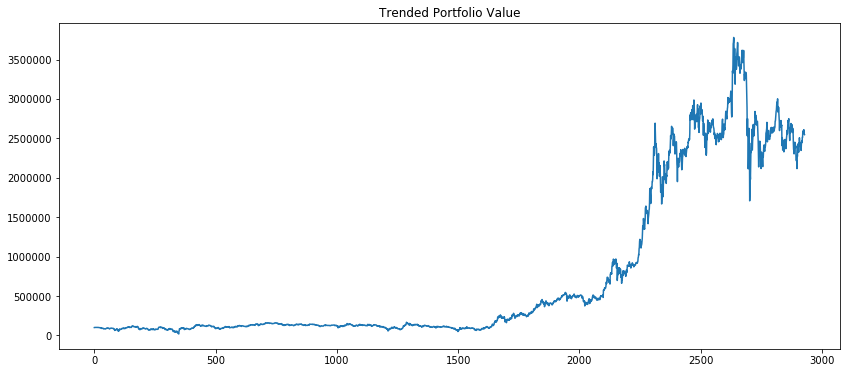

In [21]:
performance_summary(performance_1hr_fee)

# 6 Hour Periods

## Load & Process

In [26]:
# load data
df = pd.read_csv('portfolio_export_all_features_6H_2018-01-03.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop('date', 1)

scaled_prices = process_data(df, currency_pairs)

In [25]:
# print shape, head, tail
print('Shape:', scaled_prices.shape)
scaled_prices.iloc[np.r_[0:2, -2:0]]

Shape: (556, 8)


,usdtbtc_close,usdtbch_close,usdteth_close,usdtxmr_close,usdtdash_close,usdtsan_close,usdtneo_close,usdtiota_close
date,,,,,,,,
2017-08-15 00:00:00,0.090487,0.012615,0.151547,0.013596,0.010997,0.023604,0.315631,0.136143
2017-08-15 06:00:00,0.075995,0.013629,0.140650,0.010606,0.010000,0.026409,0.315631,0.125136
2017-12-31 12:00:00,0.656428,0.618483,0.862270,0.685345,0.654711,0.775465,0.964885,0.650861
2017-12-31 18:00:00,0.650887,0.611191,0.862477,0.678912,0.634700,0.815997,0.947301,0.634980


## Trended

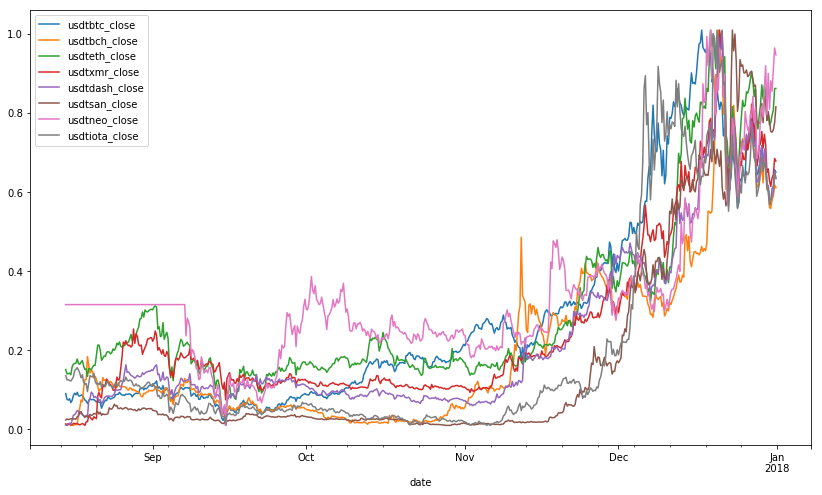

In [27]:
scaled_prices.plot(figsize = (14, 8));

# Benchmarks

## No Fee

In [94]:
train_window_len = int(len(scaled_prices[scaled_prices.index < datetime(2017, 9, 1)].index))

performance_6hr = trading_simulation(scaled_prices,
                                     init_capital = init_capital,
                                     train_window = train_window_len,
                                     progress_print = 10
                                    )

In [83]:
# backup the results
performance_6hr = [100000, 102632.49922053432, 101741.88975294316, 100010.58224189116, 97424.051776172579, 87225.35678341474, 88800.873210591832, 83588.843305306858, 84133.165680452817, 95935.654165437358, 86441.750070856942, 87919.0626484276, 91278.835884721397, 87030.066033833034, 61092.534095349802, 70239.595836445718, 66419.469815446602, 53754.244938807664, 68918.234363224474, 83757.057451605346, 80771.360752097215, 79815.754020420922, 93442.506667208319, 102406.58438242142, 104326.54668050598, 100667.29317692164, 99840.163690106827, 90595.822476992747, 89618.360159647928, 85703.648136702162, 83863.70248907902, 58797.126909961647, 63740.236692550978, 68408.137315210086, 69591.476826339305, 59935.319919024369, 63222.016896649278, 52403.469827598747, 48097.46410220315, 61891.666389628372, 55891.981503917763, 51255.374941547991, 52969.240867695895, 55433.384419643997, 65249.612767598643, 77313.696486530083, 76656.587042887622, 68925.634857312165, 67378.185216461541, 52604.380908683379, 44164.821631827195, 52740.288458917181, 60669.930446745639, 55767.8327607799, 41011.526700778566, 28832.017503838753, 33065.235967764405, 40544.337786108859, 13016.469448252174, 64659.063399654406, 68575.702253489071, 87321.146111212918, 75370.587405970815, 73983.319963623828, 77506.165812284627, 67061.797990317529, 68253.154587976518, 81529.725100220283, 78224.449538272951, 96537.263585553155, 102208.69720695325, 101279.23837506837, 110864.45749762144, 93591.168188454947, 98635.746346834931, 103336.2415055383, 93933.903144168376, 94693.74895746453, 94973.234838943186, 99313.224247856851, 94411.03770954223, 87655.362496081711, 84818.273883116839, 66280.397591465997, 68255.129702207705, 74717.654007491772, 62118.660047270285, 69105.042789850049, 75876.056366820427, 82234.880139829882, 95899.230663599476, 87430.550341078706, 91634.394695359049, 85082.226131854623, 83178.732509650668, 85261.105462107895, 84480.351292392268, 96430.746775926877, 97115.132807104645, 111989.53417156951, 120863.02410048805, 109794.85029205089, 122690.72098252384, 114484.95682558935, 111323.65665068482, 122526.34743626637, 134233.38606359935, 133841.82956409451, 140789.60721803637, 136217.96611864361, 129212.63422472595, 150095.03864558518, 150478.91642964195, 126766.36948117938, 148300.44669166248, 144812.91682677632, 143508.30659949491, 151810.98859512483, 165784.460299122, 167002.73557465393, 170974.18812656743, 166649.33215280349, 161640.98260036836, 162643.32955729609, 171674.36418833549, 177937.11410777061, 163543.67510540149, 159786.82167133002, 162084.01906257097, 147176.92736425967, 144418.03487487277, 144048.56450861332, 150705.00228880497, 153193.55148148071, 140723.24551057623, 143635.61612775933, 141443.90074203062, 128700.99066842876, 140109.59185607612, 146478.22375995503, 144449.39800716256, 151178.57839345539, 152762.3304688505, 139921.81254878212, 136086.41598114598, 141720.57829380131, 135234.49089900099, 139620.47752248295, 152997.27119085848, 152155.88224371808, 150325.64768564893, 145470.98679572999, 135489.21823401278, 136208.81493152925, 130033.10986116111, 110568.96846698475, 116454.31975227315, 111492.16257397553, 123834.06750165761, 118922.73999134575, 120526.43017800202, 122512.32386358497, 118829.30181380513, 125040.56483286907, 124603.55461267562, 122202.5047858597, 114754.37914822287, 110865.33344538027, 91433.121572690841, 99170.871218838205, 96970.229343885891, 94274.935402181436, 107039.62719203286, 106478.42304688708, 117217.86588003677, 119622.09518204199, 113346.76407501649, 109493.36391624753, 94679.964823581002, 95286.608713652531, 103898.82543943914, 100671.34609387138, 109138.48531760497, 110444.98991157689, 111232.80075815735, 105980.28939258296, 108086.31690767681, 111715.7926053117, 128071.66624374228, 124485.29933654419, 123346.81340206672, 107902.05795313201, 118075.724356381, 119885.37798269198, 108464.16828101002, 103017.07708376089, 105634.68771352663, 93396.578683639556, 93536.951021721412, 85732.246327260145, 86282.091103227533, 71905.841075469725, 52553.844297577067, 72777.188663647452, 83980.712075496005, 81505.244093299523, 98365.910871558706, 83533.379336663435, 82392.446467019152, 75007.088724713074, 62509.137432852935, 72451.968079623155, 86980.066501905458, 117631.81031649496, 124622.2138576018, 148644.71567010047, 134916.17227067478, 133379.53228668889, 126453.42879797079, 123613.88500623179, 125458.52516196489, 128150.69638040329, 132847.82063075542, 116508.59170129686, 108283.60176584851, 95782.631046522583, 104782.44987961621, 118420.30059682613, 116839.04936003409, 111436.18134225096, 108206.37291671016, 96487.186540998926, 95356.956231647899, 102954.02738431393, 94308.675905099051, 89471.116117820944, 101891.78363159015, 98502.906823130339, 92895.5394918815, 98870.695196714092, 107111.91349683169, 101830.26079201618, 106672.98452306821, 103068.61023117344, 95068.735974534793, 89791.37008925846, 83755.476631135287, 71581.368476848293, 72797.459357000247, 56522.81839142563, 56502.767907961723, 69994.743607839366, 71584.269828916178, 80727.779132257157, 76607.770682656905, 76457.774506734597, 96949.577866057502, 83487.593108782719, 80892.367874413772, 80109.378002957776, 79146.380465256007, 67152.26597999435, 54784.766058980909, 67044.492104285979, 64662.561446244385, 55359.217175752419, 71047.9606843074, 75231.060141967668, 85205.130665971446, 87181.692745492343, 100071.70871903354, 87810.068199098387, 92074.539677364592, 102397.27984073914, 112909.72466750583, 158613.79444761408, 168532.96347201589, 193603.73531230955, 233902.75230094625, 246361.63309691587, 215371.19622942488, 214839.47920390515, 187736.34166725291, 170972.77888866412, 183076.76331869388, 185279.90547775844, 202825.78639142949, 241883.65273571148, 260577.9028084903, 200936.28631018382, 236023.74522090005, 226634.14043730483, 233302.38860053607, 265681.49289568001, 254207.44846578332, 245392.02605826239, 239241.96660887575, 218760.57182620838, 228232.10751653326, 253008.43752782792, 258471.93555329327, 268669.80766080623, 309172.49393070606, 313940.83442412689, 357422.37228598847, 345191.55093541683, 351794.49281256739, 388239.90408290597, 373711.74080740329, 365002.5357116512, 375525.20130011614, 403712.47846589843, 437101.67833001312, 439860.11963862926, 446974.99267973797, 448212.97631105309, 466254.83493994153, 468078.91011032765, 491292.54148119106, 476142.59692823328, 479486.00540143519, 516241.31658283458, 536692.26776298753, 531638.69053997134, 520950.52210305433, 479422.12898184359, 478574.90120306856, 489034.66615731554, 471890.39879614429, 498126.99858091888, 512753.99282836833, 480953.22777907626, 490855.52602874697, 493539.49635492702, 485142.21506783378, 469967.83717110654, 415423.28166215215, 357843.36751944839, 384044.17638856231, 371188.02487767971, 424773.49333502358, 411617.45794733393, 432556.03587259195, 468998.48019477329, 457826.89218974242, 439689.59306872531, 447822.77634073357, 447856.52101693576, 476378.69946128764, 478232.07333186083, 536967.56017544877, 563777.19073967333, 615258.86522890255, 671834.81459906604, 644545.87744833215, 704265.82803556905, 818536.2003219563, 781225.07069200324, 795313.44259531074, 792787.02999405318, 658561.31693358521, 711055.06400417804, 655048.55622646632, 640186.98884365452, 697563.27556104201, 691320.68198468536, 726781.93157615897, 770960.91630977497, 788399.01626072964, 777223.93816986878, 774295.49949168938, 775429.44554417511, 788675.93944169127, 797870.75006321119, 886519.43960450927, 1025331.6083406132, 979886.90369826532, 1163009.1998940811, 1173404.6512337325, 1419655.0363135699, 1387178.7850138764, 1342164.8960596472, 1557011.5465737076, 1565752.9588055464, 1680109.8220891336, 1932833.4412272277, 1913084.8801803987, 1792610.6324341246, 1760111.3085733475, 1632319.8509570041, 1443372.7330268475, 1511208.2256355507, 1652655.5511039332, 1515356.347453421, 1671437.2981450083, 1809746.9291971058, 1965245.2974174982, 1923394.4848176523, 1912841.2940615239, 1774920.809010254, 1857428.9988380459, 1625483.7464330567, 1682706.2653651962, 1788550.0357546071, 1657234.989780366, 1747420.3979660051, 1778751.7902977518, 1818013.0645183772, 1816746.4217969405, 1838189.9611676822, 2016394.4739541537, 1977880.7547562758, 2091609.8863427278, 1962799.7798810429, 2170919.015904977, 2048326.5949508678, 2065242.9467915017, 2287781.036805585, 2165455.1343992124, 2104301.146466373, 2087324.3811826385, 1962378.4516825648, 1983942.0433482607, 2090138.825894421, 2122293.0416446654, 2194678.3911041613, 2049437.0507260822, 1988946.5846194744, 2041398.3377048762, 2164353.5465587205, 2187060.2262107776, 2447035.8757405505, 2502062.7916952684, 2488805.6505705905, 2822343.4495043838, 2776541.3894872554, 2857225.8177988818, 2884297.8952512159, 2586460.8024797835, 3360830.1246942268, 3280921.5573456893, 3044374.9538514842, 3353105.894127809, 3189753.0196869378, 3241726.1758096362, 3260660.5265993732, 3277492.9068158143, 3011967.5686142258, 3101949.6188889663, 2313870.7329452117, 2139556.5189123973, 1952914.810490249, 2163179.4510915484, 2372966.3596921405, 2671006.6497229282, 2562200.3871102436, 2303302.8411024082, 2197414.1538867815, 2002392.0985953861, 2088363.0949856353, 2264542.4289185209, 2228469.4696591753, 2420639.8147408012, 2351031.6932489662, 2419970.5972719546, 2460946.8438170003, 2420282.1832585712, 2424840.6229558154, 2563321.9732577, 2730229.8563923477, 2714484.6904766518, 2557024.4725325317, 2562062.0810380252, 2211366.0432210802, 2258590.7916679229, 2328614.9692674987, 2512892.2126410892, 2604433.8018401819, 2485525.450341627, 2624495.8050341923, 2655359.2623552196, 2389224.5420452193, 2482721.3618289898, 2306902.8427843857, 2411618.1180300061, 2458486.1935400437, 2533640.0490066828, 2679347.9438391714, 2619780.4913031058]

Return: 26.197804913031057
Sharpe: 0.222590414354


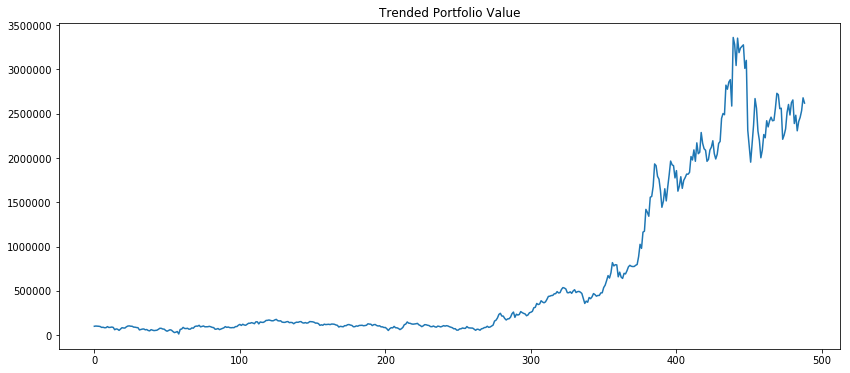

In [84]:
performance_summary(performance_6hr)

## Fee: 0.25%

In [31]:
train_window_len = int(len(scaled_prices[scaled_prices.index < datetime(2017, 9, 1)].index))

performance_6hr_fee = trading_simulation(scaled_prices,
                                         init_capital = init_capital,
                                         train_window = train_window_len,
                                         trading_fee = 0.0025,
                                         progress_print = 25
                                        )

In [30]:
# backup
performance_6hr_fee = [100000, 102632.49922053432, 101732.37527483022, 99985.736355959074, 97384.185939041956, 87179.908400021843, 88728.621669735192, 83488.104238895554, 84018.71246198361, 95789.774205137626, 86283.715260966041, 87720.639251863846, 91046.493718821483, 86800.434619258056, 60921.234536791795, 69969.222414094969, 66087.560204396039, 53437.140204320654, 68462.257533501761, 83129.512318611582, 80117.233907893678, 79141.95402855931, 92636.778222627996, 101486.07186064879, 103366.55516550012, 99728.719051491411, 98896.226939499466, 89733.616068505973, 88738.858530920101, 84822.728542008466, 82975.932001331457, 58171.259996856621, 62994.792180325392, 67580.63391532794, 68737.957530286978, 59192.101913931459, 62412.407900887432, 51717.917433089176, 47444.228167076762, 61037.458399374184, 55090.007017959761, 50502.272865865983, 52179.217259952471, 54601.990520055762, 64264.013998944305, 76117.308958277034, 75440.772084069409, 67820.309174438924, 66279.111826229768, 51742.444833699599, 43410.526499399835, 51815.081455894928, 59581.301337762408, 54749.331836526457, 40241.324253808918, 28264.48720045036, 32383.788157331055, 39686.670904945655, 12732.570142816185, 62878.154777740368, 66551.535744738256, 84658.84642774846, 73023.061947073948, 71632.053667575106, 75032.748461473515, 64914.410506769258, 66041.797859762999, 78878.421433523792, 75650.015209913778, 93340.644641876104, 98777.546215997136, 97840.618805142003, 107093.20215302084, 90384.254578747612, 95212.057610233183, 99736.245119947736, 90648.692928254401, 91355.941498311047, 91620.920440471527, 95805.439879625905, 91066.354203751311, 84538.864369677089, 81779.858791761741, 63900.227595158998, 65758.310562253726, 71974.585800106346, 59825.434600228444, 66520.392944454841, 73019.646774516208, 79121.285494042968, 92250.63778254854, 84074.235955198033, 88095.243520899734, 81783.905951209905, 79938.814241882836, 81932.904968020084, 81177.663724444326, 92656.121436289279, 93284.749943142582, 107564.8770905308, 116049.77909158242, 105402.87064961926, 117748.05238724023, 109841.231265904, 106777.80035618362, 117514.4145866274, 128712.60240613532, 128295.34854443096, 134937.72339929279, 130536.32955248933, 123807.12621716059, 143791.95282730114, 144109.44037755515, 121366.26657981146, 141916.31865437856, 138527.04338794874, 137261.7862268613, 145196.23556323399, 158538.07448414073, 159669.94621318683, 163449.54230678946, 159289.78619849461, 154483.87706465193, 155426.6219057061, 164047.54342936433, 170009.99466168677, 156238.00096695678, 152602.94701651265, 154778.43299207193, 140531.30021722944, 137862.06006381559, 137494.20370086571, 143842.57683206056, 146201.58826291823, 134292.64128827077, 137041.82864849723, 134934.9298465896, 122760.24313083444, 133609.46990679993, 139649.58552551729, 137694.56720740534, 144101.0953562856, 145593.84957607201, 133349.31253527376, 129664.0397299632, 135019.51701522665, 128814.73868935404, 132971.52147129754, 145698.67105224694, 144865.74845018703, 143105.74586141366, 138479.66125639985, 128962.97295856031, 129613.09012308613, 123710.87340838036, 105179.23062045981, 110728.87746879581, 105988.82423792445, 117708.25163238018, 113007.81861153964, 114506.42451951053, 116381.3692770031, 112876.70902492441, 118767.68783265223, 118337.88119525052, 116051.20808800065, 108970.16387479419, 105258.69578735733, 86800.719898867348, 94096.434814546446, 91976.367957865426, 89412.543050693625, 101511.69694105319, 100949.3732783317, 111127.65059523479, 113381.02190369966, 107426.71996674774, 103760.45085353543, 89714.762329224817, 90254.272349964449, 98406.318559266409, 95329.697647793073, 103339.09276752689, 104555.94219913684, 105295.45032238857, 100319.20762403484, 102299.97317083918, 105729.97278983341, 121199.0921645339, 117767.08046683333, 116669.40623116036, 102051.89754667039, 111618.37923819422, 113285.27515139425, 102483.3532570369, 97304.712106525811, 99764.167091686541, 88197.950523714127, 88301.067597219473, 80925.256074026634, 81425.615123601237, 67854.286328203729, 49568.436854020001, 68582.450079461851, 79084.205045600422, 76726.440144684064, 92587.257384794793, 78592.82277562948, 77483.54486333199, 70532.701675023432, 58765.499591926331, 68079.145059728689, 81701.798938770415, 110448.03173547366, 116935.41823666036, 139457.43028906977, 126526.20431179239, 125038.61383314125, 118541.37526676839, 115863.65975657829, 117585.99733817771, 120101.16008787838, 124494.7565223463, 109173.13651789789, 101430.53077391555, 89702.966807456512, 98100.005722587986, 110843.26379184512, 109331.61214390825, 104267.05621412634, 101232.73494822156, 90261.999029623592, 89177.612252341831, 96279.223801958258, 88178.065521828146, 83635.964417886105, 95234.593278176922, 92039.209811755311, 86787.078583013907, 92355.544498576535, 100036.62388439613, 95085.412351506166, 99594.176263835907, 96218.185002826591, 88742.291292125345, 83798.381730435038, 78153.869931148889, 66781.720565747353, 67887.365446688782, 52704.541225513538, 52647.901743241157, 65215.023975156335, 66663.888917478151, 75174.612550194681, 71317.69444203547, 71168.492738860339, 90236.941356482494, 77665.996515046165, 75222.464219149522, 74488.477700167161, 73586.870263075849, 62432.958318185083, 50912.022056904309, 62270.592904752099, 60031.041905163125, 51385.788239275244, 65921.077923862933, 69763.546097594473, 79002.287124191571, 80811.419138299432, 92754.560043012214, 81363.152635197446, 85284.688409212002, 94834.999923831769, 104544.80252091541, 146828.99143240237, 155899.01028200364, 179064.33970400027, 216267.39188277768, 227689.36930785901, 199020.88265639261, 198457.4349125296, 173402.42730822915, 157861.9901138565, 168997.12454634107, 171002.67791880507, 187186.74948592062, 223184.27609470606, 240337.0585342574, 185293.09899311917, 217486.10413391073, 208756.77287998097, 214872.66427003607, 244676.06044465306, 234037.56111928288, 225896.26989393411, 220214.81393068717, 201349.1231337105, 210017.77976114265, 232792.3789165896, 237761.11573011769, 247128.83681303146, 284357.21705007146, 288648.355045932, 328607.47508314863, 317265.84632465948, 323303.03646421421, 356779.388911949, 343347.68329288659, 335311.68221855367, 344957.93596669257, 370825.32906778221, 401422.26554830617, 403867.67370018846, 410264.85856191278, 411383.87202765874, 427882.47129674943, 429514.13433365797, 450773.86878234003, 436821.2173419664, 439821.42819363344, 473504.55489981419, 492174.52132595715, 487493.24403938936, 477666.33571837971, 439548.10492539464, 438673.83682133572, 448240.44419963186, 432496.54879729927, 456501.53433365334, 469844.37563217076, 440673.42302098527, 449665.40762191283, 452092.62895273662, 444388.88665332278, 430470.5805552745, 380479.7445962762, 327634.19418635807, 351482.09910116869, 339658.78967124299, 388658.29461703327, 376502.99571227276, 395611.4010414448, 428877.79520118103, 418580.3994498871, 401972.05761268124, 409365.46900729963, 409377.95082045306, 435441.40692536806, 437070.51427406113, 490733.41713739099, 515093.30025355174, 562064.48700136796, 613621.46191526577, 588572.86013035628, 643035.69589139195, 747211.92035629123, 712903.91312668798, 725666.56229954388, 723329.49969124794, 600851.86707919568, 648415.10520574427, 597232.28687033139, 583557.9782738114, 635822.05816639273, 630001.38753123255, 662302.61859783472, 702476.1611244689, 718262.38995086681, 708042.29287888156, 705349.14465759741, 706375.4223767044, 718436.98899776477, 726782.51571892609, 807510.13274946366, 933716.51997285197, 892030.64545119938, 1058605.148746998, 1067646.8913293581, 1291620.3650444932, 1261526.3553796583, 1220448.0542974775, 1415700.2630743242, 1423138.502177116, 1526940.3977884939, 1756332.2695338777, 1737823.5093101794, 1628190.7209798626, 1598399.4011642144, 1482217.6448439308, 1310391.0704419003, 1371532.984069163, 1499736.7211241575, 1374763.8243015928, 1515925.4464891045, 1640905.2055223179, 1781552.9703555037, 1743268.2733483096, 1733520.8778374468, 1608360.2002050427, 1682747.8943940969, 1472427.1954392756, 1523718.4733525547, 1619402.1905674909, 1500284.3950967821, 1581614.8111772945, 1609766.3996992188, 1645164.1300910532, 1643925.2877474988, 1663269.0346699606, 1824441.6356237251, 1789195.1097275568, 1891979.4905018941, 1775223.9179902135, 1963135.8311115706, 1851831.8159146451, 1866841.3576545485, 2067935.305369263, 1956888.4488250636, 1901353.7962240621, 1885877.2352161577, 1772955.034863695, 1792154.0114697125, 1888020.5020093187, 1916822.0221402503, 1982112.0413621888, 1850785.3602131014, 1795840.036911082, 1843058.4294550018, 1953941.1932825416, 1974159.4231676164, 2208607.3664113842, 2257675.5967222583, 2245451.3020598865, 2546255.3444920783, 2504192.7964103646, 2576795.876055269, 2600982.5939143887, 2332333.2702448885, 3029744.450058931, 2955996.3916165438, 2742506.950836747, 3020039.122562964, 2872237.4222028768, 2918646.5981305009, 2935561.5033856672, 2950524.7380821719, 2711454.7165995636, 2791844.2188318353, 2082400.0325994976, 1923885.8663855451, 1755701.7309356979, 1944268.5438716339, 2132306.8272033725, 2399590.3289145082, 2301198.4099124675, 2068451.6032451864, 1972804.8905068571, 1797500.1566172957, 1874217.3710383, 2032121.2351036191, 1999360.4193562779, 2171686.6752188932, 2108818.9952989761, 2170499.5966349212, 2207094.1286219927, 2170475.4558938676, 2174471.4701567846, 2298643.539264692, 2447987.3945012465, 2433498.2005077568, 2292237.6678164848, 2296396.373564783, 1982044.5523927631, 2023569.6186048675, 2086198.1022781974, 2251122.1288667554, 2332699.9744859585, 2226002.5359134795, 2350181.6164431083, 2377505.0827890979, 2139155.0715445383, 2222241.4937523021, 2064675.7008746802, 2157981.2888256512, 2199680.1266703606, 2266815.775292546, 2397000.8965625456, 2343373.3657679344]

Return: 23.433733657679344
Sharpe: 0.223775361057


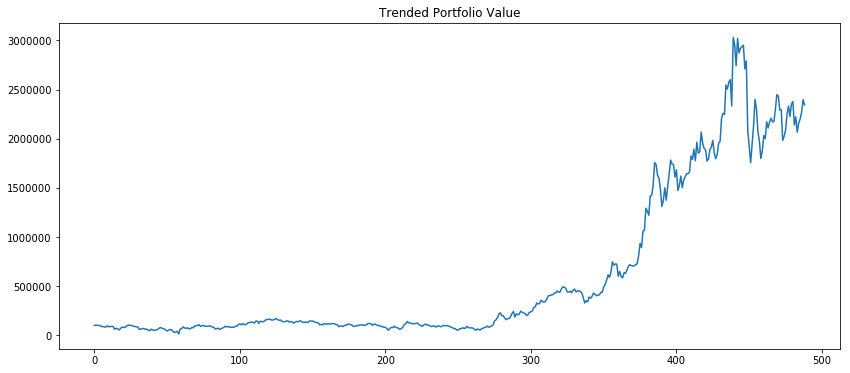

In [32]:
performance_summary(performance_6hr_fee)

# 24 Hour Periods

## Load & Process

In [180]:
# load data
df = pd.read_csv('portfolio_export_all_features_24H_2018-01-03.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop('date', 1)

scaled_prices = process_data(df, currency_pairs)

In [162]:
# print shape, head, tail
print('Shape:', scaled_prices.shape)
scaled_prices.iloc[np.r_[0:2, -2:0]]

Shape: (139, 8)


,usdtbtc_close,usdtbch_close,usdteth_close,usdtxmr_close,usdtdash_close,usdtsan_close,usdtneo_close,usdtiota_close
date,,,,,,,,
2017-08-15,0.067804,0.010000,0.119961,0.014800,0.010000,0.025530,0.261520,0.124046
2017-08-16,0.082318,0.010873,0.146524,0.014953,0.033099,0.026104,0.261520,0.149538
2017-12-30,0.582975,0.561392,0.807465,0.614537,0.609515,0.760925,0.905686,0.592011
2017-12-31,0.669618,0.614442,0.900542,0.678912,0.667099,0.824128,0.976038,0.646497


## Trended

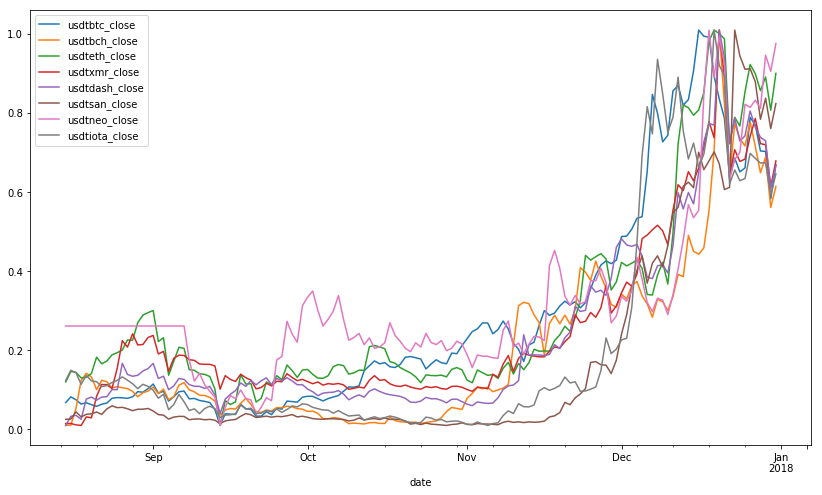

In [163]:
scaled_prices.plot(figsize = (14, 8));

# Benchmarks

## No Fee

In [86]:
train_window_len = int(len(scaled_prices[scaled_prices.index < datetime(2017, 9, 1)].index))

performance_24hr = trading_simulation(scaled_prices,
                                      init_capital = init_capital,
                                      train_window = train_window_len,
                                      progress_print = 10
                                     )

In [49]:
# backup the results
performance_24hr = [100000, 95628.635652434416, 82768.392410760498, 88307.986710376921, 60073.397160834378, 71366.759106611411, 93399.122004059478, 80067.126665243355, 55863.643122453781, 57845.987043079382, 50270.53798189581, 56860.299999464711, 60049.787011402354, 53145.582819000418, 22908.372045682139, 63024.213412172481, 77321.285887478298, 76859.519355125507, 117448.52213251304, 96003.191620914004, 96115.472202383229, 62415.198161235028, 74102.818290097988, 96049.207419967424, 86221.393541501529, 138038.73775408303, 127311.24686201839, 164514.40414161014, 177165.01484386396, 170269.96085384669, 202512.76579990791, 202872.71954848053, 190690.28211934652, 177218.10588655321, 165713.76700715121, 170175.55745042203, 158628.86816110334, 178107.62097843946, 161905.12165679515, 147461.43695241536, 152396.1581449183, 159085.63373515132, 115743.41972404768, 138451.76767995916, 150090.47530230065, 134400.76516133395, 144880.58251871335, 167496.09386181613, 151856.72109381572, 133298.70622927111, 105265.48287304059, 94591.629592590383, 91514.789232737065, 95812.797429671933, 159648.11215117868, 146829.23066309682, 124525.82841498782, 131953.85866540522, 105278.91230354263, 114003.58985315614, 119734.46898347068, 105781.94819555488, 77298.995866043872, 75392.750862424931, 107561.48209179599, 83977.078752047048, 65160.664981633679, 90761.847327535419, 99774.621217174281, 201088.65089434886, 261439.72691376734, 219613.9290275246, 325433.56361463462, 287095.61787441227, 295581.4695140961, 318057.38919837534, 453025.29016270599, 478244.92442531406, 586453.03062347113, 625370.78246080573, 654382.53073860484, 748629.41527130944, 673749.77020546806, 702232.86981798278, 591252.25995703973, 599752.63587158057, 644763.86446759372, 671456.82084957126, 882212.0317047548, 1231606.5209130773, 986729.09414154675, 1047824.0048719216, 1185678.3983870132, 1186965.5694668938, 1497756.8630509435, 2154797.3540990544, 2744598.2066692333, 2918899.7461546795, 2694679.7515489194, 3222637.9391950378, 3037428.3392888037, 2690909.4206632287, 2965205.5319476426, 3436279.8233035388, 3360382.9335549134, 3409529.9626289783, 3465193.7076011095, 3314033.7892336063, 4036805.9668346955, 4609306.9106088346, 5387783.5433897069, 5253371.238500081, 5028749.5979443276, 3474253.0112908585, 3700151.9191635237, 3627505.1191042224, 3853194.1073374143, 4105441.1963202907, 4081191.2571973726, 4001797.4197898069, 4210829.6921087522, 3800685.6987599018, 4134226.8636999596]

Return: 41.342268637
Sharpe: 0.361691250178


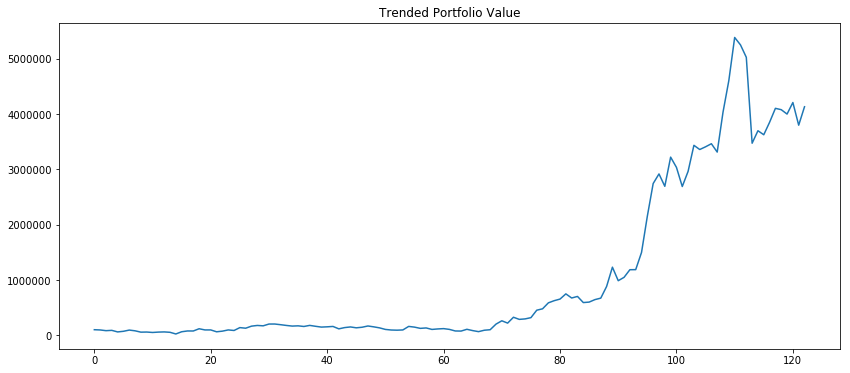

In [85]:
performance_summary(performance_24hr)

## Fee: 0.25%

In [184]:
train_window_len = int(len(scaled_prices[scaled_prices.index < datetime(2017, 9, 1)].index))

performance_24hr_fee = trading_simulation(scaled_prices,
                                          init_capital = init_capital,
                                          train_window = train_window_len,
                                          trading_fee = 0.0025,
                                          progress_print = 10
                                         )

In [186]:
# backup
performance_24hr_fee = [100000, 95628.635652434416, 82749.824596558581, 88242.024030079905, 59991.442557038215, 71183.84332366196, 93056.675395352882, 79724.549249732008, 55586.456403905002, 57499.999224049039, 49956.643330938161, 56457.951425784107, 59586.668349976047, 52706.922797552041, 22706.370035961496, 62273.703072094613, 76265.987751920446, 75733.58139851554, 115662.03941553316, 94459.926172816413, 94509.472806470105, 61365.020069467326, 72758.313676040678, 94265.321893752029, 84572.786605897985, 135354.16555479981, 124718.11657655335, 161063.15621020715, 173348.09293859635, 166566.35197744786, 198069.45546452669, 198342.38322200585, 186379.45673629359, 173163.52214892727, 161865.62988930009, 166182.82703119473, 154861.8572202595, 173844.12983577081, 157961.3164537425, 143810.55206145221, 148550.1210057007, 154965.00862194711, 112719.13191861028, 134708.64889118698, 145921.87534618113, 130641.79810747669, 140787.09184188745, 162734.74829897491, 147490.18652997634, 129417.64498016708, 102164.55553947628, 91743.776971250394, 88733.540204347795, 92890.524624284386, 154749.84613846938, 142182.39841706061, 120524.98070426862, 127647.27134327652, 101817.58465132629, 110173.65040637141, 115677.29468859558, 102166.12388515638, 74631.856778301502, 72725.232443869609, 103749.0399828067, 80939.229055447329, 62760.62288930807, 87358.629564059898, 95965.118606301839, 193372.27905096428, 251091.41556223857, 210800.92648382558, 312192.14077515423, 275186.53612477536, 283166.35967239074, 304672.49542268028, 433862.02890565124, 457672.31070305791, 561037.31153556914, 597992.41439929255, 625284.17500191194, 715241.69139028608, 643383.1475690034, 670325.87623619742, 564313.15623715252, 572150.13607374951, 615033.74308080424, 640384.04536898795, 841298.57584419136, 1173792.3540052811, 939746.89532934595, 997314.02921397844, 1128357.3546280528, 1129253.9420544382, 1424905.2412360327, 2048926.8312865552, 2607792.6601869832, 2771949.8794401223, 2558618.92975723, 3059029.6339790663, 2881972.4222181584, 2552799.1669808757, 2812073.4775511338, 3258060.5207144511, 3184756.6684719012, 3231143.3027355005, 3283465.4150782134, 3139888.4491435364, 3824276.4815346808, 4364687.2592901401, 5100154.8829506487, 4971133.0828154748, 4757872.046309947, 3286696.9705519625, 3496485.6486680992, 3427307.0674800007, 3640356.024410727, 3878097.3660813421, 3854602.0927556003, 3779461.0102128773, 3976677.7268501497, 3588894.779906522, 3902765.5777065512]

Return: 39.0276557771
Sharpe: 0.362200307978


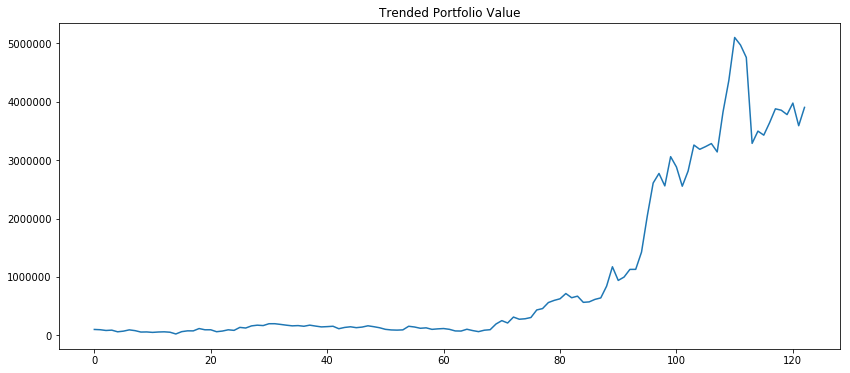

In [183]:
performance_summary(performance_24hr_fee)

# Buy and Hold
## (24hr)

### ETH

Return: 2.99522188075
Sharpe: 0.162886263825


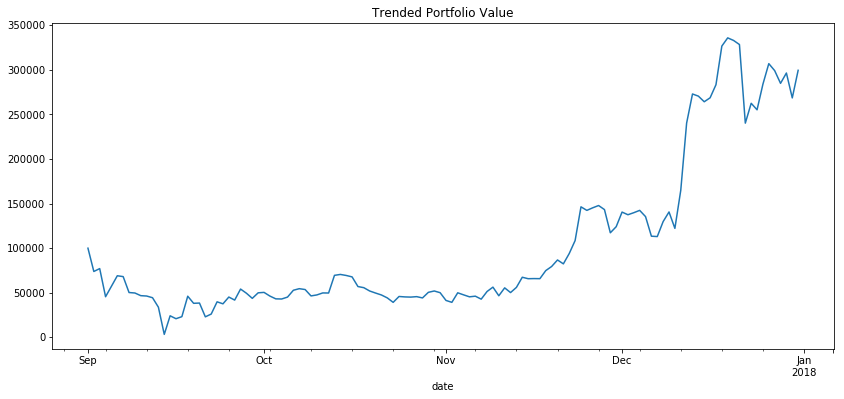

In [120]:
BAH_ETH = get_bah_performance(currency = 'ETH',
                              init_capital = init_capital,
                              scaled_price_df = scaled_prices
                             )

performance_summary(BAH_ETH)

### BTC

Return: 5.83681871374
Sharpe: 0.307922673317


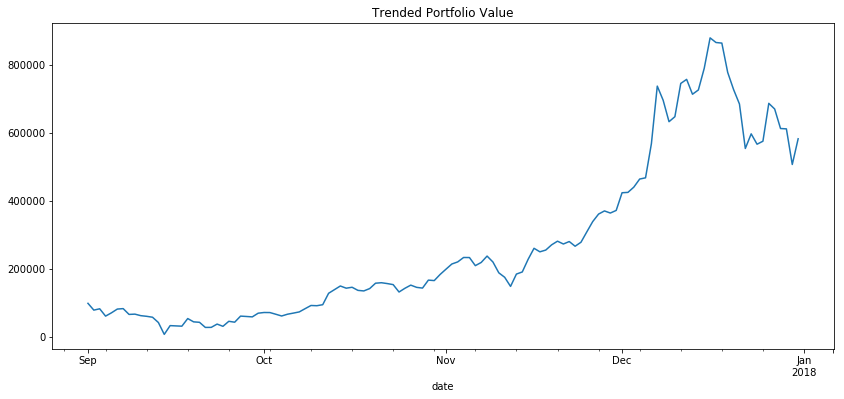

In [121]:
BAH_BTC = get_bah_performance(currency = 'BTC',
                              init_capital = init_capital,
                              scaled_price_df = scaled_prices
                             )

performance_summary(BAH_BTC)

### BCH

Return: 5.74171564386
Sharpe: 0.435611700873


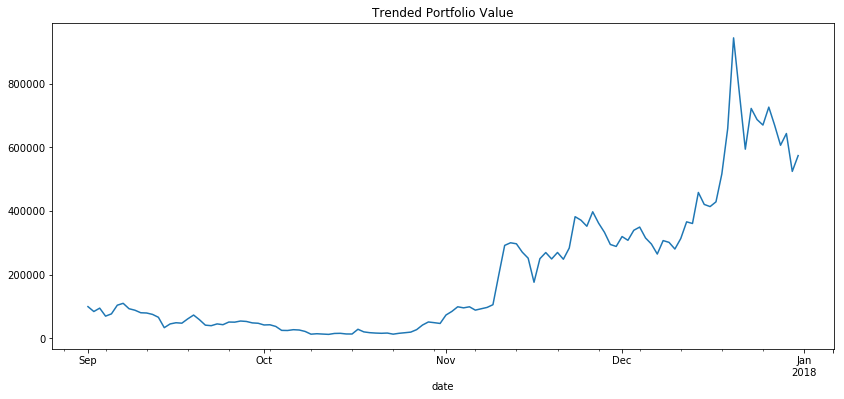

In [122]:
BAH_BCH = get_bah_performance(currency = 'BCH',
                              init_capital = init_capital,
                              scaled_price_df = scaled_prices
                             )

performance_summary(BAH_BCH)